In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from collections import deque

In [2]:
nx = 9
ny = 6
cm = None  # camera_matrix
dcoeff = None # distortion coefficient
PM = None # perspective_matrix
PMinv = None #inverse perspective matrix

In [3]:
def camera_callibrate(img, cm = None, dcoeff = None, nx = nx, ny = ny):
    imgpoints = []
    objpoints = []
    mesh = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objp = np.hstack((mesh, np.zeros(shape = (nx*ny,1))))
    objp = np.array(objp, dtype = np.float32)
    retval, corners = cv2.findChessboardCorners(img,(nx,ny), None)
    if retval == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        retval, cm, dcoeff, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], cm, dcoeff)
    
    return cm,dcoeff

In [4]:
ilist = os.listdir("./camera_cal/")

In [5]:
for im_name in ilist:
    filename = "./camera_cal/" + im_name
    img = mpimg.imread(filename)
    cm, dcoeff = camera_callibrate(img, cm, dcoeff)

In [6]:
def undistort(img, cm, dcoeff, fig_show = False):
    dest = cv2.undistort(img, cm, dcoeff)
    if fig_show == True:
        plt.figure()
        plt.imshow(dest)
    return dest

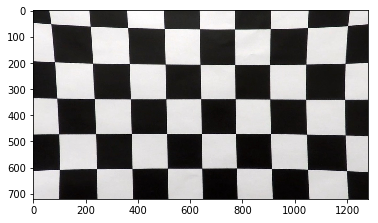

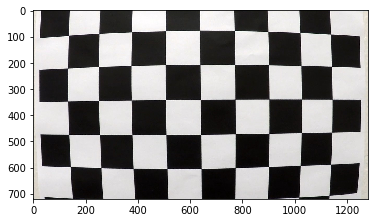

In [17]:
# for im_name in ilist:
filename = "./camera_cal/calibration1.jpg"
img = mpimg.imread(filename)
undist = undistort(img, cm, dcoeff)
plt.figure()
plt.imshow(undist)
plt.figure()
plt.imshow(img)
# plt.imsave("./output_images/undistort_calibration1.jpg", undist)

In [18]:
# inp_list = os.listdir("./test_images/")
# for im_name in inp_list:
#     filename = "./test_images/" + im_name
#     img = mpimg.imread(filename)
#     undist = undistort(img, cm, dcoeff)
#     fname = "./output_images/" + "undistorted_" + im_name
#     #warped = cv2.warpPerspective(undist, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR) 
#     plt.figure()
#     plt.imshow(undist)
#     cv2.imsave(fname = fname, arr = undist)

In [19]:
# # Code to display in interactive window - cv2.waitKey() and cv2.destroyAllWindows() are necessary 
# # to keep the window alive.... To close image window - press Enter on the image

# img = cv2.imread('./test_images/straight_lines2.jpg')
# undist = undistort(img, cm, dcoeff)
# warped = cv2.warpPerspective(undist, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR) 
# cv2.imshow('ImageWindow', warped)
# cv2.waitKey()
# cv2.destroyAllWindows()

In [20]:
# ym_per_pix = 3.0/125 # meters per pixel in y dimension
# xm_per_pix = 3.7/640 # meters per pixel in x dimension

ym_per_pix = 30.0/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

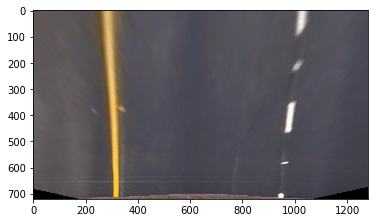

In [59]:
# Perspective matrix creation
img = mpimg.imread("./test_images/straight_lines1.jpg")
undist = undistort(img, cm, dcoeff)
# src = np.array([[484,528],[805,528],[1038,676],[265,676]],dtype=np.float32)
# dst = np.array([[200,400],[840,400],[840,600],[200,600]],dtype=np.float32)

# src = np.float32([[490, 482],[810, 482], [1250, 720],[40, 720]],dtype=np.float32)
# dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]],dtype=np.float32)

src = np.array([[585,460],[203,720],[1127,720],[695,460]],dtype=np.float32)
dst = np.array([[320,0],[320,720],[960,720],[960,0]],dtype=np.float32)

PM = cv2.getPerspectiveTransform(src, dst)
PMinv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(undist, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR) 
plt.imshow(warped)
plt.imsave(fname = "warp_st1.png", arr = warped)

In [47]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255), mode = 'mpimg'):
    # Calculate directional gradient
    # Apply threshold    
    if mode == 'mpimg':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif mode == 'cv2':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    if orient == 'x':
        grad = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    elif orient == 'y':
        grad = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
        
    max_grad = np.max(grad)
    grad = np.uint8(255*grad/ max_grad)
    
    grad_binary = np.zeros_like(grad)
    grad_binary[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255), mode = 'mpimg'):
    # Calculate gradient magnitude
    # Apply threshold
    if mode == 'mpimg':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif mode == 'cv2':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    gradx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    grady = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    
    grad = np.sqrt(gradx**2 + grady**2)
    
    max_grad = np.max(grad)
    grad = np.uint8(255*grad/ max_grad)
    
    grad_binary = np.zeros_like(grad)
    grad_binary[(grad >= mag_thresh[0]) & (grad <= mag_thresh[1])] = 1
    return grad_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2), mode = 'mpimg'):
    # Calculate gradient direction
    # Apply threshold
    if mode == 'mpimg':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif mode == 'cv2':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    gradx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    grady = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    
    dir_grad = np.arctan2(grady, gradx)
    
    binary_output = np.zeros_like(gray)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    
    return binary_output

def s_threshold(img, s_thres=(0,255), mode = 'mpimg'):
    
    if mode == 'mpimg':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif mode == 'cv2':
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    s = hls[:,:,2]
    binary_output = np.zeros_like(gray)
    binary_output[(s>=s_thres[0]) & (s<=s_thres[1])] = 1
    return binary_output

In [48]:
n = 50
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen = n)
        #average x values of the fitted line over the last n iterations
        self.bestx = 0     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([0,0,0], dtype='float') 
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([0,0,0], dtype='float')
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [60]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    fact = 2
    
    pixel_thres = 800
    while True:
        histogram = np.sum(binary_warped[binary_warped.shape[0]//fact:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)

        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        if (np.sum(histogram[leftx_base-100:leftx_base+100])) >=pixel_thres \
        and (np.sum(histogram[rightx_base-100:rightx_base+100])) >= pixel_thres :
            break
        else:
            fact *= 2
        if fact == 128:
            break
        # HYPERPARAMETERS
    # Choose the number of sliding windows
    
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    lane_centre = (leftx_current + rightx_current)//2

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         print((win_xleft_low,win_y_low),(win_xleft_high,win_y_high))

        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = [i for i in range(len(nonzerox)) \
                          if (nonzerox[i] <= win_xleft_high and nonzerox[i] >= win_xleft_low \
                              and nonzeroy[i] <= win_y_high and nonzeroy[i] >= win_y_low)]
        
        good_right_inds = [i for i in range(len(nonzerox)) \
                          if (nonzerox[i] <= win_xright_high and nonzerox[i] >= win_xright_low \
                              and nonzeroy[i] <= win_y_high and nonzeroy[i] >= win_y_low)]
        
        # Append these indices to the lists
        
        
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
#         print("Indices: ")
#         print(leftx_current, rightx_current)
#         print("Len points: ")
#         print(len(good_left_inds), len(good_right_inds))
        
        if len(good_left_inds) > minpix:
            left_lane_inds.append(good_left_inds)
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        

        if len(good_right_inds) > minpix:
            right_lane_inds.append(good_right_inds)
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixel index)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [61]:
def check_roughly_parallel(left_fit, right_fit, left_numpix, right_numpix, ploty, slope_thres = 0.15):
    
    yval = np.random.choice(ploty, size = ploty.shape[0]/10, replace=False) # randomly selects some points 
    slope_left = 2*left_fit[0]*yval + left_fit[1]                           # and checks for slope threshold
    slope_right = 2*right_fit[0]*yval + right_fit[1]
    retval = True
    
#     print(np.mean(np.abs(slope_left)))
#     print(np.mean(np.abs(slope_right)))
#    print(np.mean(np.abs(slope_left - slope_right)))
    if(np.mean(np.abs(slope_left - slope_right)) >= slope_thres):
        retval = False
        try:
            left_fitx = left_fit[0]*yval**2 + left_fit[1]*yval + left_fit[2]
            right_fitx = right_fit[0]*yval**2 + right_fit[1]*yval + right_fit[2]
            cval = np.mean(np.abs(left_fitx - right_fitx))
        except TypeError:
            cval = 0
        try:    
            if(left_numpix >= right_numpix):
                right_fit[0] = left_fit[0] 
                right_fit[1] = left_fit[1] 
                right_fit[2] = left_fit[2] + cval 
            else:
                left_fit[0] = right_fit[0] 
                left_fit[1] = right_fit[1] 
                left_fit[2] = right_fit[2] - cval 
        except TypeError:
            pass
       
    return retval, left_fit, right_fit 

In [62]:
def coeff_calc_in_metre(fit, xratio, yratio):
    
    fit[0] = xratio*fit[0]/((yratio)**2)
    fit[1] = xratio*fit[1]/(yratio)
    fit[2] = xratio*fit[2]
    
    return fit
    
def roc_calc(left_fit_orig, right_fit_orig, y_eval, xratio = xm_per_pix, yratio = ym_per_pix):    
    
    left_fit = np.copy(left_fit_orig)
    right_fit = np.copy(right_fit_orig)
    left_fit = coeff_calc_in_metre(left_fit, xratio, yratio)
    right_fit = coeff_calc_in_metre(right_fit, xratio, yratio)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.power((2*left_fit[0]*y_eval + left_fit[1])**2 + 1 , 1.5)/np.abs(2*left_fit[0])
    right_curverad = np.power((2*right_fit[0]*y_eval + right_fit[1])**2 + 1 , 1.5)/np.abs(2*right_fit[0])
    
    return (left_curverad, right_curverad)

In [63]:
def fit_polynomial(binary_warped, check_parallel = True):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, deg=2)
    right_fit = np.polyfit(righty, rightx, deg = 2)
       
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    if check_parallel == True:
        retval, left_fit, right_fit = check_roughly_parallel(left_fit, right_fit, len(lefty), len(righty), ploty)
#     if retval == True:
#         print("Lanes are roughly parallel")
#     else:
#         print("Curvature mismatch found --> Both lanes assigned curvature of lane with more pixels(strong/guiding lane)")
# #     print(left_fit)
# #     print(right_fit)
# #     left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
# #     right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
#     # Generate x and y values for plotting
    
    detected = False
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        detected = True
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    y_eval = np.max(ploty)*ym_per_pix
    
    roc = roc_calc(left_fit, right_fit, y_eval)
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='pink')
    
    lane_centre = (left_fitx[-1] + right_fitx[-1])/2.0
    
    set_line_param(left_line, detected, left_fitx, left_fit, roc[0], left_fitx[-1])
    set_line_param(right_line, detected, right_fitx, right_fit, roc[1], right_fitx[-1])
    
    return out_img, left_line, right_line, lane_centre, ploty

In [64]:
def set_line_param(line, detected, fitx, fit, roc, base_pos = 0):
    line.detected = detected
    qlen = len(line.recent_xfitted)
    line.recent_xfitted.append(fitx)
    line.bestx = np.mean(line.recent_xfitted)
    old_fit = line.current_fit
    line.current_fit = fit
    old_best_fit = line.best_fit
    line.best_fit = (old_best_fit*qlen + line.current_fit)/(qlen + 1)
    line.diffs = line.current_fit - old_fit
    line.radius_of_curvature = roc
    line.line_base_pos = base_pos


In [65]:
def search_around_poly(binary_warped, left_line, right_line, check_parallel = True):
    left_fit = left_line.best_fit
    right_fit = right_line.best_fit
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    lft_orig = np.copy(left_fit)
    rght_orig = np.copy(right_fit)
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    
    func_val = (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2])
    left_lane_inds = ((nonzerox >= func_val - margin) & (nonzerox <= func_val + margin))
    
    func_val = (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2])
    right_lane_inds = ((nonzerox >= func_val - margin) & (nonzerox <= func_val + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    try:
        left_fit = np.polyfit(lefty, leftx, deg=2)
        right_fit = np.polyfit(righty, rightx, deg = 2)
    except TypeError:
        left_fit = lft_orig
        right_fit = rght_orig
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    if check_parallel == True:
        retval, left_fit, right_fit = check_roughly_parallel(left_fit, right_fit, len(lefty), len(righty), ploty)

    # Generate x and y values for plotting
    detected = False
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        detected = True
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    y_eval = np.max(ploty)*ym_per_pix
    roc = roc_calc(left_line.current_fit, right_line.current_fit, y_eval)
    
    set_line_param(left_line, detected, left_fitx, left_fit, roc[0], left_fitx[-1])
    set_line_param(right_line, detected, right_fitx, right_fit, roc[1], right_fitx[-1])
    
    # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    lane_centre = (left_fitx[-1] + right_fitx[-1])/2.0
    
    return result, left_line,right_line, lane_centre, ploty


In [66]:
def draw_on_actual(warped, undist, left_fitx, right_fitx ,ploty):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, PMinv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

Left roc 2065.477, Right roc 7199.487
Left roc 442.611, Right roc 262.199
Left roc 3171.108, Right roc 3352.404
Left roc 1276.619, Right roc 655.261
Left roc 705.628, Right roc 2718.636
Left roc 947.637, Right roc 1251.809
Left roc 1300.959, Right roc 1260.779
Left roc 1039.596, Right roc 829.840


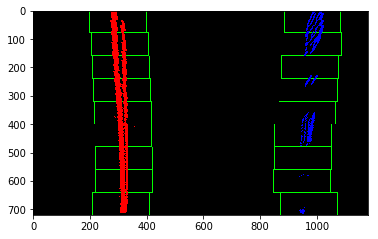

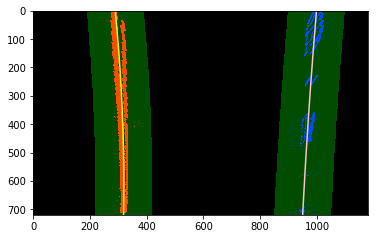

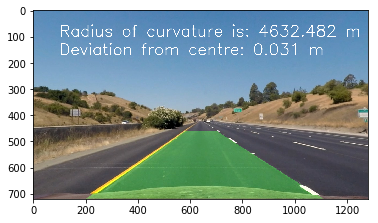

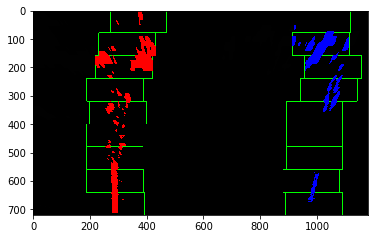

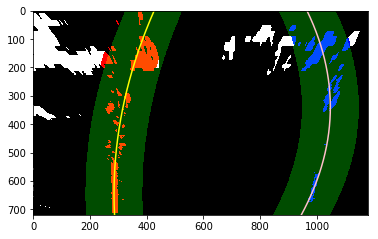

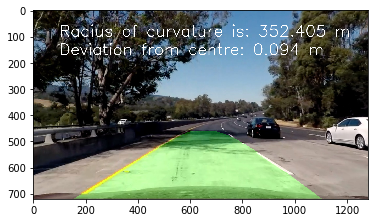

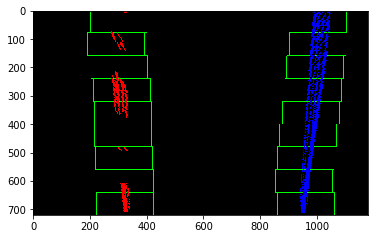

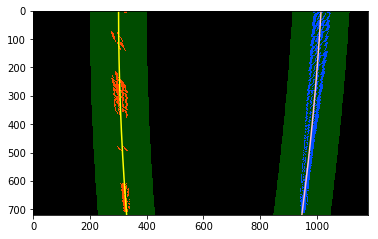

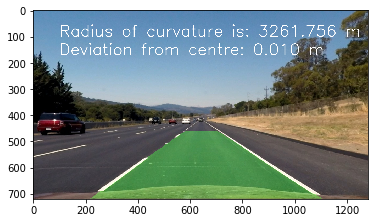

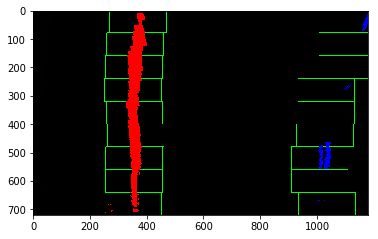

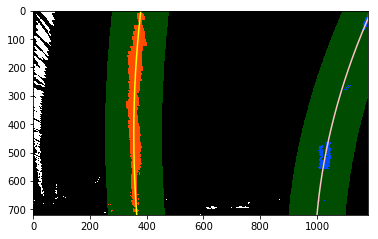

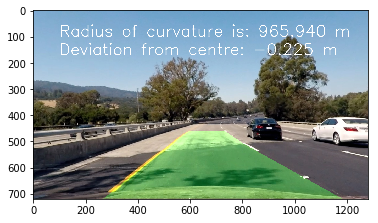

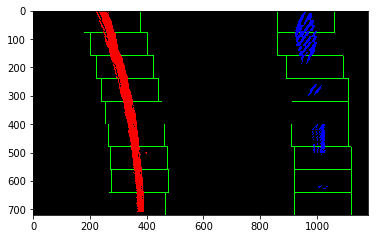

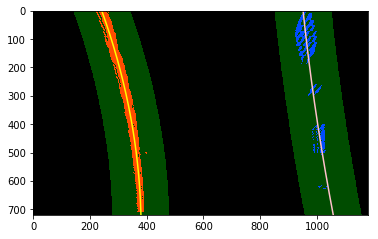

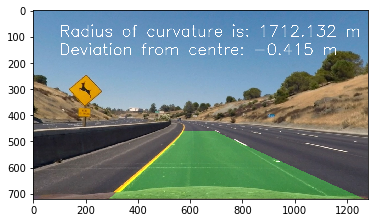

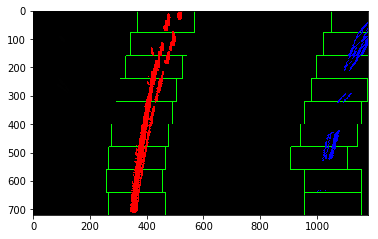

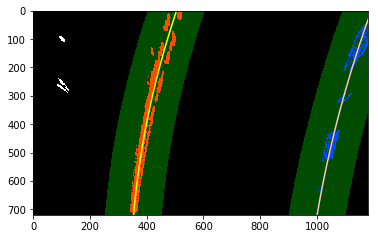

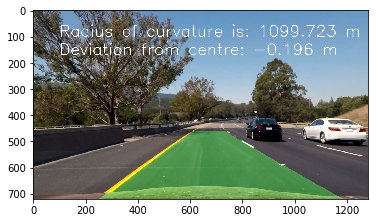

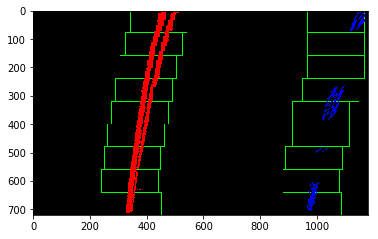

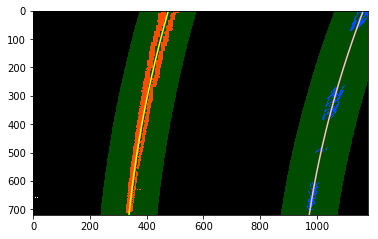

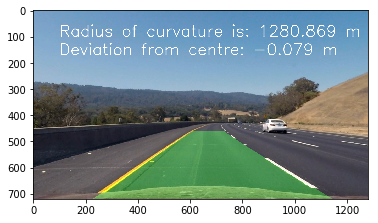

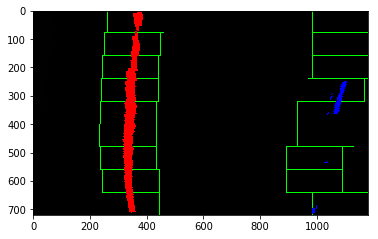

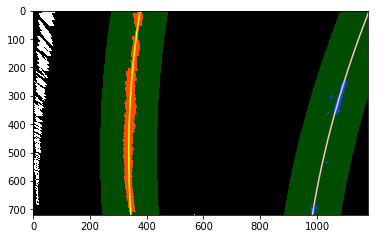

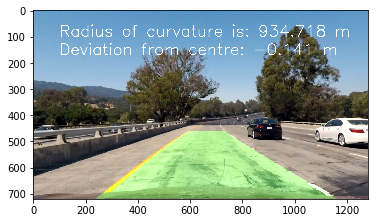

In [82]:
# Lines found without applying check_roughly_parallel

inp_list = os.listdir("./test_images/")

for im_name in inp_list:
    filename = "./test_images/" + im_name
    img = mpimg.imread(filename)
    img_work = np.copy(img)

    left_line = Line()
    right_line = Line()

    undist = undistort(img_work,cm,dcoeff)

    s_binary = s_threshold(undist, s_thres=(150,255))
    grad_x_binary = abs_sobel_thresh(undist, 'x', 5, (80,150))
    grad_y_binary = abs_sobel_thresh(undist, 'y', 5, (0,80))
    grad_binary = mag_thresh(undist, 5, (80, 180))
    dir_binary = dir_threshold(undist, 5, (0.7,1.3))

    plottable = np.zeros_like(s_binary)
    plottable[(s_binary == 1) | ((grad_x_binary == 1) & (grad_y_binary ==1)) | ((grad_binary ==1) & (dir_binary == 1))] = 1

    warped = cv2.warpPerspective(plottable, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR)

    out_img, left_line, right_line, lane_centre,ploty = fit_polynomial(warped[:,:-100], False)
    result, left_line, right_line, lane_centre, ploty = search_around_poly(warped[:,:-100],left_line, right_line, False)
    
    deviation = (undist.shape[1]/2.0 - lane_centre)*xm_per_pix
    dev_str = "Deviation from centre: {0:.3f} m".format(deviation)
    #print("Left roc %.3f, Right roc %.3f" %(left_line.radius_of_curvature, right_line.radius_of_curvature))
    roc = (left_line.radius_of_curvature + right_line.radius_of_curvature)/2.0
    roc_str = "Radius of curvature is: {0:.3f} m".format(roc)
    final = draw_on_actual(warped, undist, left_line.recent_xfitted[-1], right_line.recent_xfitted[-1], ploty)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final, roc_str, (100,100), font, 2, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(final, dev_str, (100,170), font, 2, (255,255,255),2,cv2.LINE_AA)
          
    plt.imshow(out_img, cmap='gray')
    plt.figure()
    plt.plot(left_line.recent_xfitted[-1], ploty, color='yellow')
    plt.plot(right_line.recent_xfitted[-1], ploty, color='pink')
    plt.imshow(result, cmap = 'gray')
    plt.figure()
    plt.imshow(final)
    plt.figure()

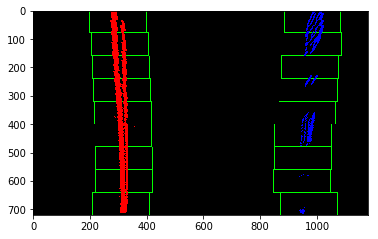

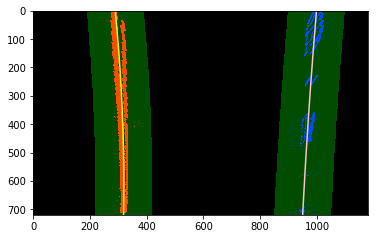

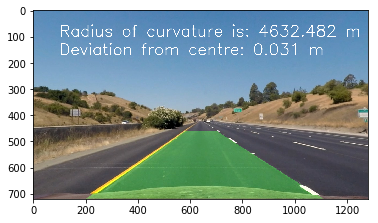

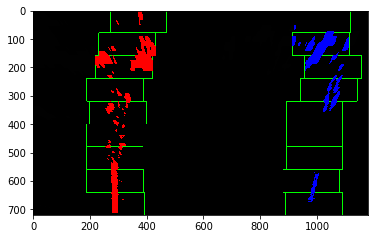

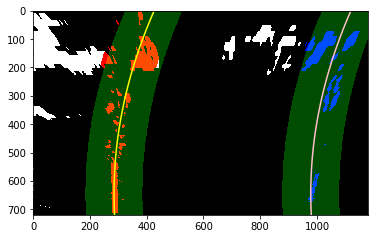

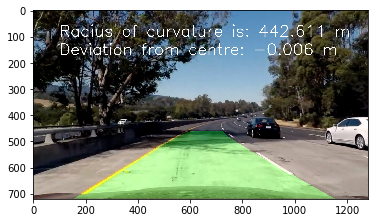

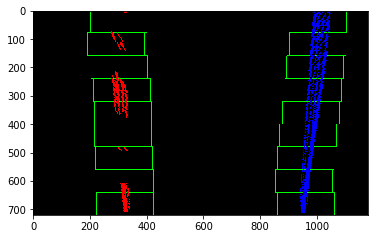

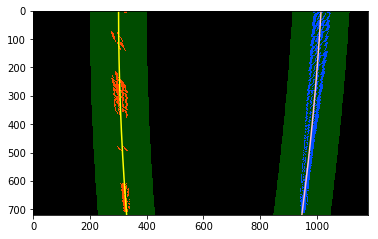

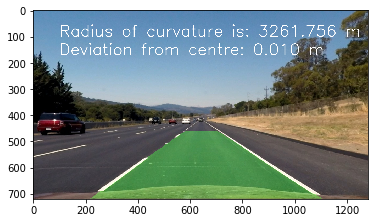

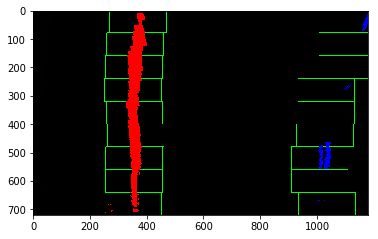

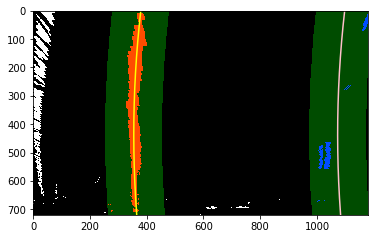

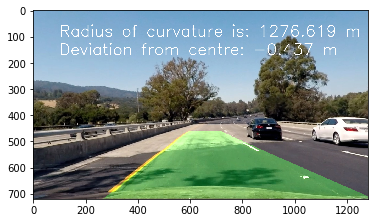

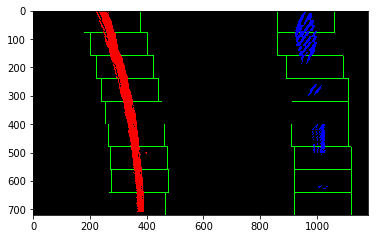

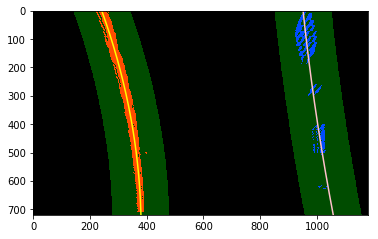

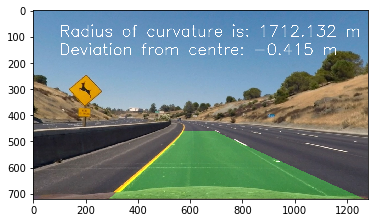

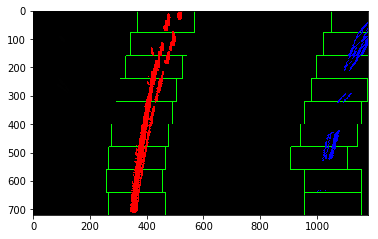

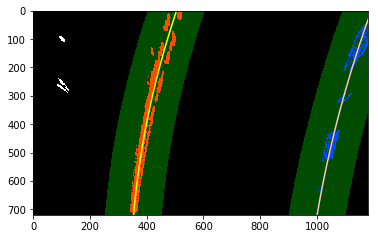

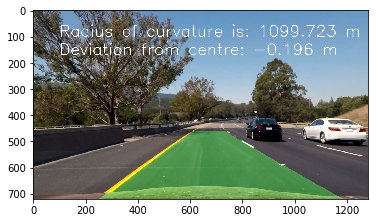

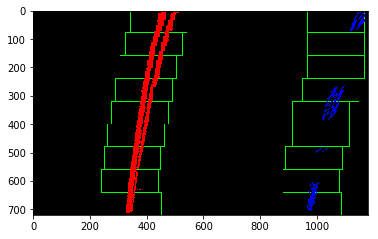

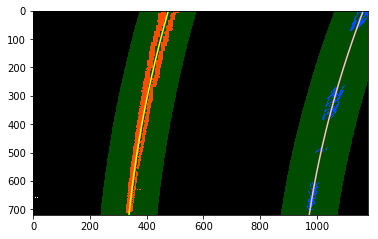

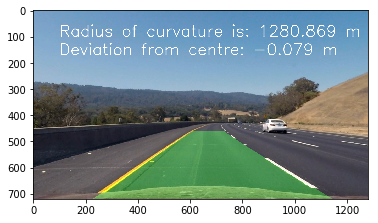

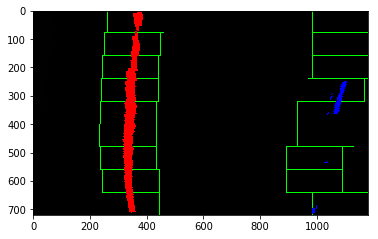

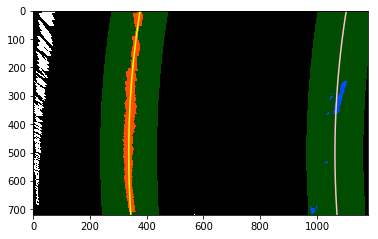

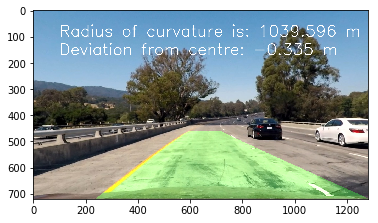

In [83]:
# Lines found with applying check_roughly_parallel

inp_list = os.listdir("./test_images/")

for im_name in inp_list:
    filename = "./test_images/" + im_name
    img = mpimg.imread(filename)
    img_work = np.copy(img)

    left_line = Line()
    right_line = Line()

    undist = undistort(img_work,cm,dcoeff)

    s_binary = s_threshold(undist, s_thres=(150,255))
    grad_x_binary = abs_sobel_thresh(undist, 'x', 5, (80,150))
    grad_y_binary = abs_sobel_thresh(undist, 'y', 5, (0,80))
    grad_binary = mag_thresh(undist, 5, (80, 180))
    dir_binary = dir_threshold(undist, 5, (0.7,1.3))

    plottable = np.zeros_like(s_binary)
    plottable[(s_binary == 1) | ((grad_x_binary == 1) & (grad_y_binary ==1)) | ((grad_binary ==1) & (dir_binary == 1))] = 1

    warped = cv2.warpPerspective(plottable, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR)

    out_img, left_line, right_line, lane_centre,ploty = fit_polynomial(warped[:,:-100])
    result, left_line, right_line, lane_centre, ploty = search_around_poly(warped[:,:-100],left_line, right_line)
    
    deviation = (undist.shape[1]/2.0 - lane_centre)*xm_per_pix
    dev_str = "Deviation from centre: {0:.3f} m".format(deviation)
    #print("Left roc %.3f, Right roc %.3f" %(left_line.radius_of_curvature, right_line.radius_of_curvature))
    roc = (left_line.radius_of_curvature + right_line.radius_of_curvature)/2.0
    roc_str = "Radius of curvature is: {0:.3f} m".format(roc)
    final = draw_on_actual(warped, undist, left_line.recent_xfitted[-1], right_line.recent_xfitted[-1], ploty)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final, roc_str, (100,100), font, 2, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(final, dev_str, (100,170), font, 2, (255,255,255),2,cv2.LINE_AA)
          
    plt.imshow(out_img, cmap='gray')
    plt.figure()
    plt.plot(left_line.recent_xfitted[-1], ploty, color='yellow')
    plt.plot(right_line.recent_xfitted[-1], ploty, color='pink')
    plt.imshow(result, cmap = 'gray')
    plt.figure()
    plt.imshow(final)
    plt.figure()

In [88]:
def draw(img):
    global IND
    global left_line
    global right_line
    global diff_thres
    
    img_work = np.copy(img)

    undist = undistort(img_work,cm,dcoeff)

    s_binary = s_threshold(undist, s_thres=(150,255))
    grad_x_binary = abs_sobel_thresh(undist, 'x', 5, (80,150))
    grad_y_binary = abs_sobel_thresh(undist, 'y', 5, (0,80))
    grad_binary = mag_thresh(undist, 5, (80, 180))
    dir_binary = dir_threshold(undist, 5, (0.7,1.3))

    plottable = np.zeros_like(s_binary)
    plottable[(s_binary == 1) | ((grad_x_binary == 1) & (grad_y_binary ==1)) | ((grad_binary ==1) & (dir_binary == 1))] = 1

    warped = cv2.warpPerspective(plottable, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR)
    
    if IND == 0: 
        out_img, left_line, right_line, lane_centre, ploty = fit_polynomial(warped[:,:])
    else:
        result, left_line, right_line, lane_centre, ploty = search_around_poly(warped[:,:],left_line, right_line)
    
    ldiff = np.mean(np.abs(left_line.diffs))
    rdiff = np.mean(np.abs(right_line.diffs))
    
    print(ldiff, rdiff, IND)
    
    if ((IND != 0) and ((ldiff >= diff_thres) or (rdiff >= diff_thres))):
        IND = -1
        print("resetting")
    
    IND += 1
    
    deviation = (undist.shape[1]/2.0 - lane_centre)*xm_per_pix
    dev_str = "Deviation from centre: {0:.3f} m".format(deviation)
    
    roc = (left_line.radius_of_curvature + right_line.radius_of_curvature)/2.0
    roc_str = "Radius of curvature is: {0:.3f} m".format(roc)
    
    
    final = draw_on_actual(warped, undist, left_line.recent_xfitted[-1], right_line.recent_xfitted[-1], ploty)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final, roc_str, (100,100), font, 2, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(final, dev_str, (100,170), font, 2, (255,255,255),2,cv2.LINE_AA)
    
    return final

In [89]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [90]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = draw(image)
   # print(np.mean(np.abs(left_line.diffs)), np.mean(np.abs(right_line.diffs)))
    return result

In [96]:
project_short_output = './project_video_short_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("./project_video.mp4").subclip(0,32)
left_line = Line()
right_line = Line()
IND = 0
diff_thres = 15.0

project_short_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_short_clip.write_videofile(project_short_output, audio=False)







t:   0%|          | 0/800 [00:00<?, ?it/s, now=None]

(91.331469146949118, 313.06888169801778, 0)
Moviepy - Building video ./project_video_short_output.mp4.
Moviepy - Writing video ./project_video_short_output.mp4









t:   0%|          | 2/800 [00:00<02:39,  5.00it/s, now=None]

(0.0079925090273165571, 0.29055816473467988, 1)








t:   0%|          | 3/800 [00:00<03:18,  4.01it/s, now=None]

(0.25325973952852188, 0.095339686749246866, 2)








t:   0%|          | 4/800 [00:01<03:42,  3.58it/s, now=None]

(0.021541862863119803, 21.868104870325066, 3)
resetting








t:   1%|          | 5/800 [00:02<06:11,  2.14it/s, now=None]

(0.32429221368478062, 0.43259925976104574, 0)








t:   1%|          | 6/800 [00:02<05:40,  2.33it/s, now=None]

(0.052383706571909078, 21.49786258757079, 1)
resetting








t:   1%|          | 7/800 [00:03<08:09,  1.62it/s, now=None]

(0.4415836836035581, 20.519623689498921, 0)








t:   1%|          | 8/800 [00:03<07:10,  1.84it/s, now=None]

(0.23774240663358018, 0.51893986104936662, 1)








t:   1%|          | 9/800 [00:04<06:22,  2.07it/s, now=None]

(0.49971558532912175, 22.437465193288443, 2)
resetting








t:   1%|▏         | 10/800 [00:04<07:51,  1.68it/s, now=None]

(0.87062288517575126, 22.271440571886401, 0)








t:   1%|▏         | 11/800 [00:05<06:46,  1.94it/s, now=None]

(0.70076485965274105, 0.60892494649759787, 1)








t:   2%|▏         | 12/800 [00:05<06:17,  2.09it/s, now=None]

(0.086635527389916756, 21.774041204585483, 2)
resetting








t:   2%|▏         | 13/800 [00:06<07:55,  1.66it/s, now=None]

(1.1325370983428134, 22.888406720792233, 0)








t:   2%|▏         | 14/800 [00:06<06:59,  1.87it/s, now=None]

(0.0067897277848069796, 23.946689505901158, 1)
resetting








t:   2%|▏         | 15/800 [00:07<08:35,  1.52it/s, now=None]

(0.26999563848580049, 2.5174215863544354, 0)








t:   2%|▏         | 16/800 [00:08<07:14,  1.81it/s, now=None]

(1.2963854714818936, 0.67489076897656775, 1)








t:   2%|▏         | 17/800 [00:08<06:17,  2.07it/s, now=None]

(0.33309247480570447, 2.3465075325283293, 2)








t:   2%|▏         | 18/800 [00:08<05:45,  2.26it/s, now=None]

(0.49089052981574216, 23.681714883683245, 3)
resetting








t:   2%|▏         | 19/800 [00:09<07:58,  1.63it/s, now=None]

(0.53368713137768409, 24.729404032316513, 0)








t:   2%|▎         | 20/800 [00:10<07:08,  1.82it/s, now=None]

(0.70158893535198319, 23.914125882775739, 1)
resetting








t:   3%|▎         | 21/800 [00:11<10:45,  1.21it/s, now=None]

(0.35697953914774172, 23.15187751515532, 0)








t:   3%|▎         | 22/800 [00:12<09:02,  1.43it/s, now=None]

(0.093829233106353896, 0.38333713677185349, 1)








t:   3%|▎         | 23/800 [00:12<07:35,  1.71it/s, now=None]

(1.4516338595041169, 21.5677117287707, 2)
resetting








t:   3%|▎         | 24/800 [00:13<09:01,  1.43it/s, now=None]

(0.064582042715799454, 0.54722761646862794, 0)








t:   3%|▎         | 25/800 [00:13<07:53,  1.64it/s, now=None]

(0.28242455058500165, 0.67524358517402228, 1)








t:   3%|▎         | 26/800 [00:14<07:11,  1.80it/s, now=None]

(0.22607090575118818, 0.51406375324407227, 2)








t:   3%|▎         | 27/800 [00:14<06:37,  1.94it/s, now=None]

(0.14746807867661493, 22.917743515809288, 3)
resetting








t:   4%|▎         | 28/800 [00:15<08:26,  1.52it/s, now=None]

(0.032850673340501214, 23.64705156727879, 0)








t:   4%|▎         | 29/800 [00:16<07:20,  1.75it/s, now=None]

(0.46898402673061218, 23.009831950110527, 1)
resetting








t:   4%|▍         | 30/800 [00:17<08:43,  1.47it/s, now=None]

(0.89351813671353009, 0.79764398453371266, 0)








t:   4%|▍         | 31/800 [00:17<07:28,  1.71it/s, now=None]

(0.015753654809525373, 0.28565011673807394, 1)








t:   4%|▍         | 32/800 [00:17<06:39,  1.92it/s, now=None]

(0.059683694243974857, 22.293301063345584, 2)
resetting








t:   4%|▍         | 33/800 [00:18<08:17,  1.54it/s, now=None]

(1.2411567100637284, 0.089856434746650352, 0)








t:   4%|▍         | 34/800 [00:19<07:14,  1.76it/s, now=None]

(1.012070681979373, 22.696975155029332, 1)
resetting








t:   4%|▍         | 35/800 [00:20<09:25,  1.35it/s, now=None]

(0.55746194084851752, 21.729853994020104, 0)








t:   4%|▍         | 36/800 [00:20<08:01,  1.59it/s, now=None]

(0.045538860926516933, 0.82833765445782692, 1)








t:   5%|▍         | 37/800 [00:20<06:59,  1.82it/s, now=None]

(0.29769845112286325, 0.56007585197235232, 2)








t:   5%|▍         | 38/800 [00:21<06:26,  1.97it/s, now=None]

(0.082475299535387958, 22.557943027674835, 3)
resetting








t:   5%|▍         | 39/800 [00:22<09:10,  1.38it/s, now=None]

(0.51027073893349428, 0.67305361502629502, 0)








t:   5%|▌         | 40/800 [00:22<07:41,  1.65it/s, now=None]

(0.066734112260830147, 24.359172737466142, 1)
resetting








t:   5%|▌         | 41/800 [00:23<09:06,  1.39it/s, now=None]

(0.13363631195224995, 25.787919597981958, 0)








t:   5%|▌         | 42/800 [00:24<07:45,  1.63it/s, now=None]

(0.2166599628118713, 0.099773380957459801, 1)








t:   5%|▌         | 43/800 [00:24<06:41,  1.88it/s, now=None]

(0.73533677424044253, 2.3166593923617671, 2)








t:   6%|▌         | 44/800 [00:25<06:11,  2.03it/s, now=None]

(0.33614685208125694, 1.6831845573464228, 3)








t:   6%|▌         | 45/800 [00:25<05:50,  2.15it/s, now=None]

(0.43879267679520345, 1.4755977647746013, 4)








t:   6%|▌         | 46/800 [00:25<05:31,  2.28it/s, now=None]

(1.3658274748702752, 26.172702663609485, 5)
resetting








t:   6%|▌         | 47/800 [00:26<07:35,  1.65it/s, now=None]

(0.26345730891826302, 25.819557450790899, 0)








t:   6%|▌         | 48/800 [00:27<06:47,  1.85it/s, now=None]

(1.1598724249671586, 1.9841008392228821, 1)








t:   6%|▌         | 49/800 [00:27<06:05,  2.05it/s, now=None]

(0.11911984369350792, 2.009471378933982, 2)








t:   6%|▋         | 50/800 [00:27<05:26,  2.30it/s, now=None]

(0.1531881868525998, 1.6260418408909267, 3)








t:   6%|▋         | 51/800 [00:28<05:05,  2.45it/s, now=None]

(0.10600444208219345, 2.5970815014168789, 4)








t:   6%|▋         | 52/800 [00:28<05:03,  2.47it/s, now=None]

(0.34689358127311998, 2.6843978967620958, 5)








t:   7%|▋         | 53/800 [00:29<05:05,  2.45it/s, now=None]

(1.5492488980444608, 0.45539713138314419, 6)








t:   7%|▋         | 54/800 [00:29<05:01,  2.47it/s, now=None]

(0.24635450548467816, 0.79692299017653412, 7)








t:   7%|▋         | 55/800 [00:29<05:05,  2.44it/s, now=None]

(0.19466581552255802, 1.4179605036812275, 8)








t:   7%|▋         | 56/800 [00:30<05:04,  2.44it/s, now=None]

(0.68803922787147798, 28.352061179358074, 9)
resetting








t:   7%|▋         | 57/800 [00:31<07:11,  1.72it/s, now=None]

(0.32387958573731057, 0.58966306174628225, 0)








t:   7%|▋         | 58/800 [00:31<06:27,  1.91it/s, now=None]

(0.24619189540197195, 24.647806065632764, 1)
resetting








t:   7%|▋         | 59/800 [00:32<08:03,  1.53it/s, now=None]

(0.18569710794237437, 1.33190671341922, 0)








t:   8%|▊         | 60/800 [00:32<07:06,  1.73it/s, now=None]

(0.81569903702059587, 0.5942773395090416, 1)








t:   8%|▊         | 61/800 [00:33<06:26,  1.91it/s, now=None]

(2.1983016341437711, 3.0157877988733772, 2)








t:   8%|▊         | 62/800 [00:33<05:50,  2.11it/s, now=None]

(1.329119744275105, 21.921755217307304, 3)
resetting








t:   8%|▊         | 63/800 [00:34<07:47,  1.58it/s, now=None]

(0.55904790844320473, 0.35947783848427689, 0)








t:   8%|▊         | 64/800 [00:35<07:00,  1.75it/s, now=None]

(0.24392781616535664, 0.31093762299869449, 1)








t:   8%|▊         | 65/800 [00:35<06:20,  1.93it/s, now=None]

(0.016529309404406629, 0.3323835848083973, 2)








t:   8%|▊         | 66/800 [00:35<05:51,  2.09it/s, now=None]

(0.64512677923844641, 23.406817872624515, 3)
resetting








t:   8%|▊         | 67/800 [00:36<07:43,  1.58it/s, now=None]

(0.57164982210013393, 2.6700710825516314, 0)








t:   8%|▊         | 68/800 [00:37<07:02,  1.73it/s, now=None]

(0.35062772564088968, 25.956467689629203, 1)
resetting








t:   9%|▊         | 69/800 [00:38<08:36,  1.41it/s, now=None]

(0.64404294762001901, 25.717032106148078, 0)








t:   9%|▉         | 70/800 [00:38<07:32,  1.61it/s, now=None]

(0.7465753124885901, 25.42545005517934, 1)
resetting








t:   9%|▉         | 71/800 [00:39<08:41,  1.40it/s, now=None]

(0.72116874601547798, 24.591533364213422, 0)








t:   9%|▉         | 72/800 [00:40<07:21,  1.65it/s, now=None]

(0.068298136927021941, 0.30090953152365324, 1)








t:   9%|▉         | 73/800 [00:40<06:26,  1.88it/s, now=None]

(0.69210401571762981, 2.231760429487013, 2)








t:   9%|▉         | 74/800 [00:40<05:52,  2.06it/s, now=None]

(0.18354500736677529, 26.292944830920348, 3)
resetting








t:   9%|▉         | 75/800 [00:41<07:46,  1.56it/s, now=None]

(0.7341010259272589, 0.16637415703680106, 0)








t:  10%|▉         | 76/800 [00:42<06:49,  1.77it/s, now=None]

(0.59372072963905587, 0.2674620414178363, 1)








t:  10%|▉         | 77/800 [00:42<06:09,  1.96it/s, now=None]

(0.043991605937960997, 0.1895871521477982, 2)








t:  10%|▉         | 78/800 [00:42<05:41,  2.11it/s, now=None]

(0.89929649656298372, 0.23034005705939217, 3)








t:  10%|▉         | 79/800 [00:43<05:17,  2.27it/s, now=None]

(1.2264096933138595, 0.0087911887002400727, 4)








t:  10%|█         | 80/800 [00:43<05:11,  2.31it/s, now=None]

(1.4118204191120629, 0.21077324442481346, 5)








t:  10%|█         | 81/800 [00:44<05:38,  2.13it/s, now=None]

(0.95213897020778793, 21.223607805022876, 6)
resetting








t:  10%|█         | 82/800 [00:45<08:33,  1.40it/s, now=None]

(0.81517374904662743, 1.8687564184178891, 0)








t:  10%|█         | 83/800 [00:45<07:22,  1.62it/s, now=None]

(0.63402417125705479, 22.401458345250386, 1)
resetting








t:  10%|█         | 84/800 [00:47<08:56,  1.33it/s, now=None]

(0.43618466566963199, 20.319903983813504, 0)








t:  11%|█         | 85/800 [00:47<07:47,  1.53it/s, now=None]

(0.83621082943548963, 2.589513316938747, 1)








t:  11%|█         | 86/800 [00:47<06:58,  1.71it/s, now=None]

(0.48005835456670448, 22.296250039764061, 2)
resetting








t:  11%|█         | 87/800 [00:48<08:26,  1.41it/s, now=None]

(1.1045880714460117, 0.4837166903654137, 0)








t:  11%|█         | 88/800 [00:49<07:18,  1.62it/s, now=None]

(0.59490715507769298, 0.43111812804217647, 1)








t:  11%|█         | 89/800 [00:49<06:36,  1.79it/s, now=None]

(0.58331762461351022, 0.34301888437946615, 2)








t:  11%|█▏        | 90/800 [00:50<05:57,  1.99it/s, now=None]

(0.48179184273620118, 0.095193063572114434, 3)








t:  11%|█▏        | 91/800 [00:50<05:24,  2.18it/s, now=None]

(2.1979052347653654, 0.010605810503264165, 4)








t:  12%|█▏        | 92/800 [00:50<05:12,  2.27it/s, now=None]

(1.499227097843929, 0.15552582193493092, 5)








t:  12%|█▏        | 93/800 [00:51<05:05,  2.31it/s, now=None]

(0.42872526146075013, 0.14815443435607131, 6)








t:  12%|█▏        | 94/800 [00:51<04:58,  2.37it/s, now=None]

(0.14116523361465685, 0.082793417862950774, 7)








t:  12%|█▏        | 95/800 [00:52<04:52,  2.41it/s, now=None]

(0.17673306299817615, 22.647076170933016, 8)
resetting








t:  12%|█▏        | 96/800 [00:52<06:39,  1.76it/s, now=None]

(0.94433767839270655, 22.106999101103085, 0)








t:  12%|█▏        | 97/800 [00:53<06:05,  1.93it/s, now=None]

(0.059798084006383721, 25.525169192418304, 1)
resetting








t:  12%|█▏        | 98/800 [00:54<07:36,  1.54it/s, now=None]

(0.34886615811182442, 24.804803631761917, 0)








t:  12%|█▏        | 99/800 [00:54<06:42,  1.74it/s, now=None]

(0.15320936655959011, 0.45656537373575151, 1)








t:  12%|█▎        | 100/800 [00:55<06:10,  1.89it/s, now=None]

(0.23896019630766108, 21.511759268370454, 2)
resetting








t:  13%|█▎        | 101/800 [00:56<07:48,  1.49it/s, now=None]

(0.26037271302150661, 21.988512889447907, 0)








t:  13%|█▎        | 102/800 [00:56<06:45,  1.72it/s, now=None]

(0.35371217857244425, 22.410572662516511, 1)
resetting








t:  13%|█▎        | 103/800 [00:57<08:05,  1.44it/s, now=None]

(1.2029344639735788, 22.677242363836815, 0)








t:  13%|█▎        | 104/800 [00:57<07:02,  1.65it/s, now=None]

(0.81704442660955989, 0.055023203470106641, 1)








t:  13%|█▎        | 105/800 [00:58<06:22,  1.82it/s, now=None]

(0.051765860156842758, 0.059911326624606742, 2)








t:  13%|█▎        | 106/800 [00:58<05:43,  2.02it/s, now=None]

(0.6761220358782225, 0.21621986700201246, 3)








t:  13%|█▎        | 107/800 [00:59<05:25,  2.13it/s, now=None]

(0.42561358272619998, 0.39882643167284965, 4)








t:  14%|█▎        | 108/800 [00:59<05:09,  2.23it/s, now=None]

(0.029950544109461238, 0.5761612825243797, 5)








t:  14%|█▎        | 109/800 [00:59<04:56,  2.33it/s, now=None]

(0.040213834031699439, 21.464720057854077, 6)
resetting








t:  14%|█▍        | 110/800 [01:00<07:16,  1.58it/s, now=None]

(0.10995023714037205, 0.51492395466812491, 0)








t:  14%|█▍        | 111/800 [01:01<06:21,  1.81it/s, now=None]

(0.087808329297239598, 20.861441581586458, 1)
resetting








t:  14%|█▍        | 112/800 [01:02<07:49,  1.46it/s, now=None]

(0.46697627617171017, 0.59390207176125975, 0)








t:  14%|█▍        | 113/800 [01:02<06:55,  1.65it/s, now=None]

(0.49905347961100838, 0.42395673418194124, 1)








t:  14%|█▍        | 114/800 [01:03<06:04,  1.88it/s, now=None]

(0.81742057298052206, 21.688377051925144, 2)
resetting








t:  14%|█▍        | 115/800 [01:04<07:32,  1.51it/s, now=None]

(0.06784763959687426, 0.47735334691214071, 0)








t:  14%|█▍        | 116/800 [01:04<06:33,  1.74it/s, now=None]

(0.69504761108945967, 23.074844354065046, 1)
resetting








t:  15%|█▍        | 117/800 [01:05<08:23,  1.36it/s, now=None]

(0.23533486102511114, 24.133021016734777, 0)








t:  15%|█▍        | 118/800 [01:05<07:15,  1.57it/s, now=None]

(0.062245828809914062, 2.012403614114052, 1)








t:  15%|█▍        | 119/800 [01:06<06:24,  1.77it/s, now=None]

(0.2075665840426659, 21.441290320306084, 2)
resetting








t:  15%|█▌        | 120/800 [01:07<07:52,  1.44it/s, now=None]

(0.23714932356212506, 22.231175389466525, 0)








t:  15%|█▌        | 121/800 [01:07<06:49,  1.66it/s, now=None]

(0.041495911085926117, 0.083212247338062553, 1)








t:  15%|█▌        | 122/800 [01:08<06:08,  1.84it/s, now=None]

(0.47145685379124208, 20.604859537366803, 2)
resetting








t:  15%|█▌        | 123/800 [01:09<07:46,  1.45it/s, now=None]

(0.20301005650572931, 0.17519337844018326, 0)








t:  16%|█▌        | 124/800 [01:09<06:42,  1.68it/s, now=None]

(0.24796926406281469, 20.35096199233654, 1)
resetting








t:  16%|█▌        | 125/800 [01:10<08:15,  1.36it/s, now=None]

(0.089273896200062416, 1.0265403604551795, 0)








t:  16%|█▌        | 126/800 [01:11<07:05,  1.59it/s, now=None]

(0.10219490706270655, 22.893592795284992, 1)
resetting








t:  16%|█▌        | 127/800 [01:12<08:15,  1.36it/s, now=None]

(0.41987134509323804, 24.642699689915219, 0)








t:  16%|█▌        | 128/800 [01:12<07:05,  1.58it/s, now=None]

(0.40713463774685704, 25.400060846793323, 1)
resetting








t:  16%|█▌        | 129/800 [01:13<09:40,  1.16it/s, now=None]

(0.76382092149445813, 25.189928021321876, 0)








t:  16%|█▋        | 130/800 [01:14<08:43,  1.28it/s, now=None]

(0.72697805828540807, 0.20701271585906697, 1)








t:  16%|█▋        | 131/800 [01:14<07:39,  1.46it/s, now=None]

(0.42301906523875538, 2.0441165030231407, 2)








t:  16%|█▋        | 132/800 [01:15<06:45,  1.65it/s, now=None]

(0.42538216124008943, 1.4352294931266414, 3)








t:  17%|█▋        | 133/800 [01:15<06:19,  1.76it/s, now=None]

(0.546275315511635, 0.24493954531624609, 4)








t:  17%|█▋        | 134/800 [01:16<05:42,  1.95it/s, now=None]

(0.043389661094144362, 0.5408964889289799, 5)








t:  17%|█▋        | 135/800 [01:16<05:09,  2.15it/s, now=None]

(0.29081407947745663, 1.271436580338881, 6)








t:  17%|█▋        | 136/800 [01:16<05:08,  2.15it/s, now=None]

(0.51892139929682479, 24.364391440393561, 7)
resetting








t:  17%|█▋        | 137/800 [01:17<06:41,  1.65it/s, now=None]

(0.35489821157785711, 0.44495270620577537, 0)








t:  17%|█▋        | 138/800 [01:18<05:56,  1.86it/s, now=None]

(0.0079408568085375959, 0.47320468243534303, 1)








t:  17%|█▋        | 139/800 [01:18<05:38,  1.95it/s, now=None]

(0.35093744550216316, 21.763116116961516, 2)
resetting








t:  18%|█▊        | 140/800 [01:19<07:05,  1.55it/s, now=None]

(0.218727437259333, 1.1979480062965526, 0)








t:  18%|█▊        | 141/800 [01:20<06:27,  1.70it/s, now=None]

(0.39617704162719064, 0.052079570931362042, 1)








t:  18%|█▊        | 142/800 [01:20<05:44,  1.91it/s, now=None]

(0.4529010061008964, 0.44530657305285531, 2)








t:  18%|█▊        | 143/800 [01:20<05:08,  2.13it/s, now=None]

(0.1087543884988476, 0.56265036936314095, 3)








t:  18%|█▊        | 144/800 [01:21<04:35,  2.39it/s, now=None]

(0.48677695867313459, 0.64602342780465183, 4)








t:  18%|█▊        | 145/800 [01:21<04:25,  2.46it/s, now=None]

(0.042994596449878082, 1.5257446202903211, 5)








t:  18%|█▊        | 146/800 [01:21<04:05,  2.66it/s, now=None]

(0.41682501263820498, 21.55355001112838, 6)
resetting








t:  18%|█▊        | 147/800 [01:22<05:38,  1.93it/s, now=None]

(0.26884047192585497, 22.402040220360387, 0)








t:  18%|█▊        | 148/800 [01:23<04:59,  2.18it/s, now=None]

(0.11515313058661104, 21.309537156486343, 1)
resetting








t:  19%|█▊        | 149/800 [01:24<06:41,  1.62it/s, now=None]

(1.7917405339597672, 18.878609268420711, 0)








t:  19%|█▉        | 150/800 [01:24<05:46,  1.87it/s, now=None]

(0.37359201537306119, 20.12767488945271, 1)
resetting








t:  19%|█▉        | 151/800 [01:25<06:49,  1.59it/s, now=None]

(0.8338580407625038, 0.53635641968149184, 0)








t:  19%|█▉        | 152/800 [01:25<05:57,  1.81it/s, now=None]

(0.027550903100569901, 0.42415161249530509, 1)








t:  19%|█▉        | 153/800 [01:25<05:25,  1.98it/s, now=None]

(0.59950423651934548, 22.022626867164686, 2)
resetting








t:  19%|█▉        | 154/800 [01:26<07:00,  1.53it/s, now=None]

(0.80388930412544157, 0.71776461123482038, 0)








t:  19%|█▉        | 155/800 [01:27<06:06,  1.76it/s, now=None]

(0.66987167967570416, 22.931928522268805, 1)
resetting








t:  20%|█▉        | 156/800 [01:28<07:30,  1.43it/s, now=None]

(1.0704669609317548, 0.096754641420055895, 0)








t:  20%|█▉        | 157/800 [01:28<06:54,  1.55it/s, now=None]

(0.17771331692288908, 0.16137774219417786, 1)








t:  20%|█▉        | 158/800 [01:29<05:54,  1.81it/s, now=None]

(0.1366672464142972, 0.70601186293534235, 2)








t:  20%|█▉        | 159/800 [01:29<05:23,  1.98it/s, now=None]

(0.34241437387162893, 0.26123252898674471, 3)








t:  20%|██        | 160/800 [01:30<05:13,  2.04it/s, now=None]

(1.2566400213329507, 24.525385247545525, 4)
resetting








t:  20%|██        | 161/800 [01:31<07:24,  1.44it/s, now=None]

(0.21469544173756247, 2.263872537940014, 0)








t:  20%|██        | 162/800 [01:31<06:32,  1.62it/s, now=None]

(1.624869120717624, 22.110774962684093, 1)
resetting








t:  20%|██        | 163/800 [01:32<08:20,  1.27it/s, now=None]

(0.5238078284018739, 0.46948344888931764, 0)








t:  20%|██        | 164/800 [01:33<07:20,  1.45it/s, now=None]

(1.0607769375249632, 20.7027583586129, 1)
resetting








t:  21%|██        | 165/800 [01:34<08:33,  1.24it/s, now=None]

(0.012854296719115359, 21.515580269979267, 0)








t:  21%|██        | 166/800 [01:34<07:03,  1.50it/s, now=None]

(0.16527781966694291, 25.053755856251513, 1)
resetting








t:  21%|██        | 167/800 [01:35<07:46,  1.36it/s, now=None]

(1.155255463026996, 2.4226364214989569, 0)








t:  21%|██        | 168/800 [01:36<06:45,  1.56it/s, now=None]

(0.72782301877138933, 1.2668146541028076, 1)








t:  21%|██        | 169/800 [01:36<06:08,  1.71it/s, now=None]

(1.4700258952766625, 0.12960984417594018, 2)








t:  21%|██▏       | 170/800 [01:36<05:28,  1.92it/s, now=None]

(0.92258650707976353, 1.8832625377814975, 3)








t:  21%|██▏       | 171/800 [01:37<05:07,  2.05it/s, now=None]

(0.63664731224931548, 23.219871217715745, 4)
resetting








t:  22%|██▏       | 172/800 [01:38<06:26,  1.63it/s, now=None]

(1.0477567676914534, 25.869291641732321, 0)








t:  22%|██▏       | 173/800 [01:38<05:52,  1.78it/s, now=None]

(0.72466566917692232, 1.8093808660516479, 1)








t:  22%|██▏       | 174/800 [01:39<05:18,  1.96it/s, now=None]

(0.33700133522841774, 2.2558115379373245, 2)








t:  22%|██▏       | 175/800 [01:39<04:51,  2.14it/s, now=None]

(0.77064708239644719, 22.001036770006735, 3)
resetting








t:  22%|██▏       | 176/800 [01:40<06:10,  1.68it/s, now=None]

(0.11763936871277324, 0.26574361474455205, 0)








t:  22%|██▏       | 177/800 [01:40<05:25,  1.91it/s, now=None]

(0.46563557988421173, 21.788695757612487, 1)
resetting








t:  22%|██▏       | 178/800 [01:41<06:56,  1.49it/s, now=None]

(0.086767978990802727, 22.311989127833399, 0)








t:  22%|██▏       | 179/800 [01:41<05:55,  1.75it/s, now=None]

(0.64549393214038064, 22.085176574751074, 1)
resetting








t:  22%|██▎       | 180/800 [01:43<07:40,  1.35it/s, now=None]

(0.006646518274087302, 0.089831621501276757, 0)








t:  23%|██▎       | 181/800 [01:43<06:30,  1.58it/s, now=None]

(0.12757440403910181, 22.192255981718461, 1)
resetting








t:  23%|██▎       | 182/800 [01:44<07:09,  1.44it/s, now=None]

(0.43177081172037973, 0.8350726194356316, 0)








t:  23%|██▎       | 183/800 [01:44<05:57,  1.73it/s, now=None]

(0.8816957958019298, 0.31045534140519909, 1)








t:  23%|██▎       | 184/800 [01:44<05:07,  2.00it/s, now=None]

(0.951698834595054, 0.53500739444420409, 2)








t:  23%|██▎       | 185/800 [01:45<04:53,  2.09it/s, now=None]

(1.1975542558094545, 0.037283827884328664, 3)








t:  23%|██▎       | 186/800 [01:45<04:48,  2.13it/s, now=None]

(0.059145585066674229, 0.51987742065986231, 4)








t:  23%|██▎       | 187/800 [01:46<04:38,  2.20it/s, now=None]

(2.0007508783102286, 0.45129396932416221, 5)








t:  24%|██▎       | 188/800 [01:46<04:27,  2.28it/s, now=None]

(0.67332011510060041, 0.34335104029227947, 6)








t:  24%|██▎       | 189/800 [01:46<04:07,  2.47it/s, now=None]

(0.41980558241920218, 23.302867628891764, 7)
resetting








t:  24%|██▍       | 190/800 [01:47<05:44,  1.77it/s, now=None]

(0.32958207408443474, 0.82196866649124667, 0)








t:  24%|██▍       | 191/800 [01:48<05:35,  1.82it/s, now=None]

(0.0049798371500104485, 0.69074544045763997, 1)








t:  24%|██▍       | 192/800 [01:48<04:51,  2.09it/s, now=None]

(0.83785318411745913, 1.728258871125699, 2)








t:  24%|██▍       | 193/800 [01:49<04:44,  2.13it/s, now=None]

(0.45425696222419337, 1.7012169521401723, 3)








t:  24%|██▍       | 194/800 [01:49<04:35,  2.20it/s, now=None]

(0.31660004442156703, 2.1259212074038816, 4)








t:  24%|██▍       | 195/800 [01:49<04:12,  2.40it/s, now=None]

(0.16811898303145104, 0.40569849629597665, 5)








t:  24%|██▍       | 196/800 [01:50<04:04,  2.47it/s, now=None]

(0.075197883573789231, 26.539618231055101, 6)
resetting








t:  25%|██▍       | 197/800 [01:51<06:32,  1.54it/s, now=None]

(1.44602702603074, 27.788674494483601, 0)








t:  25%|██▍       | 198/800 [01:51<05:49,  1.72it/s, now=None]

(2.1306224815696937, 26.807749535710357, 1)
resetting








t:  25%|██▍       | 199/800 [01:53<07:45,  1.29it/s, now=None]

(0.86323860873322966, 0.32384295513528222, 0)








t:  25%|██▌       | 200/800 [01:53<06:42,  1.49it/s, now=None]

(2.492086181547434, 24.861043024071666, 1)
resetting








t:  25%|██▌       | 201/800 [01:55<08:58,  1.11it/s, now=None]

(0.18180596728029189, 0.30841146039772049, 0)








t:  25%|██▌       | 202/800 [01:55<07:12,  1.38it/s, now=None]

(1.8714218242165757, 0.025741825414610859, 1)








t:  25%|██▌       | 203/800 [01:55<05:58,  1.66it/s, now=None]

(1.9377264601977766, 0.81568288489444907, 2)








t:  26%|██▌       | 204/800 [01:55<05:06,  1.94it/s, now=None]

(1.8108981525894865, 0.33810290680519378, 3)








t:  26%|██▌       | 205/800 [01:56<04:31,  2.19it/s, now=None]

(0.21350545142132915, 1.9019670493169494, 4)








t:  26%|██▌       | 206/800 [01:56<04:02,  2.45it/s, now=None]

(0.48436538290328696, 1.0735504373461187, 5)








t:  26%|██▌       | 207/800 [01:56<03:47,  2.60it/s, now=None]

(0.20133941835108804, 23.541874585882542, 6)
resetting








t:  26%|██▌       | 208/800 [01:57<05:04,  1.95it/s, now=None]

(1.8683985521208604, 0.30200317478417454, 0)








t:  26%|██▌       | 209/800 [01:58<04:37,  2.13it/s, now=None]

(0.29687482600161264, 27.266733575240295, 1)
resetting








t:  26%|██▋       | 210/800 [01:58<05:38,  1.75it/s, now=None]

(0.075702752846193669, 3.2225610106049207, 0)








t:  26%|██▋       | 211/800 [01:59<04:52,  2.01it/s, now=None]

(0.71245606767065872, 23.448805420916926, 1)
resetting








t:  26%|██▋       | 212/800 [02:00<05:51,  1.67it/s, now=None]

(1.7014054966248799, 23.86846059720483, 0)








t:  27%|██▋       | 213/800 [02:00<05:03,  1.93it/s, now=None]

(0.21161607988135847, 24.684957794967143, 1)
resetting








t:  27%|██▋       | 214/800 [02:01<05:54,  1.65it/s, now=None]

(0.67828178193784805, 23.959761187732195, 0)








t:  27%|██▋       | 215/800 [02:01<05:08,  1.90it/s, now=None]

(0.13037685819364628, 0.29638259160646313, 1)








t:  27%|██▋       | 216/800 [02:01<04:37,  2.10it/s, now=None]

(0.12154308377605905, 0.95831014438067375, 2)








t:  27%|██▋       | 217/800 [02:02<04:43,  2.06it/s, now=None]

(1.0140295298408715, 1.2076748927449688, 3)








t:  27%|██▋       | 218/800 [02:02<04:17,  2.26it/s, now=None]

(0.17356556680112203, 1.8205434463029739, 4)








t:  27%|██▋       | 219/800 [02:03<03:59,  2.43it/s, now=None]

(0.44052152372633052, 1.0100402428523443, 5)








t:  28%|██▊       | 220/800 [02:03<03:43,  2.60it/s, now=None]

(1.2991371786403036, 0.35679314985511762, 6)








t:  28%|██▊       | 221/800 [02:03<03:35,  2.69it/s, now=None]

(2.4811547913180076, 1.5240535597791647, 7)








t:  28%|██▊       | 222/800 [02:04<03:20,  2.89it/s, now=None]

(0.49586158368863692, 0.28115471448830487, 8)








t:  28%|██▊       | 223/800 [02:04<03:14,  2.97it/s, now=None]

(0.2494414362439967, 1.2308439576631289, 9)








t:  28%|██▊       | 224/800 [02:04<03:23,  2.83it/s, now=None]

(0.78074494216696211, 0.70375769782329722, 10)








t:  28%|██▊       | 225/800 [02:05<03:32,  2.70it/s, now=None]

(0.3154905218028613, 0.26627826449081632, 11)








t:  28%|██▊       | 226/800 [02:05<03:18,  2.89it/s, now=None]

(0.11824156710233995, 1.8375649340163227, 12)








t:  28%|██▊       | 227/800 [02:05<03:09,  3.02it/s, now=None]

(0.73148114346972859, 0.16737789630272179, 13)








t:  28%|██▊       | 228/800 [02:06<03:01,  3.16it/s, now=None]

(1.3074864554973555, 2.2446750135254483, 14)








t:  29%|██▊       | 229/800 [02:06<03:05,  3.07it/s, now=None]

(0.020794406890753778, 5.1891332046089413, 15)








t:  29%|██▉       | 230/800 [02:06<03:06,  3.06it/s, now=None]

(0.3002829736041765, 0.6956677289232478, 16)








t:  29%|██▉       | 231/800 [02:07<03:07,  3.03it/s, now=None]

(0.19398741253171867, 1.5069885102472751, 17)








t:  29%|██▉       | 232/800 [02:07<03:02,  3.11it/s, now=None]

(0.15320638694084529, 2.0790259919578564, 18)








t:  29%|██▉       | 233/800 [02:07<03:04,  3.07it/s, now=None]

(3.2207084013686256, 2.2721305174851998, 19)








t:  29%|██▉       | 234/800 [02:08<03:03,  3.09it/s, now=None]

(1.5858447253051307, 0.47092024071327776, 20)








t:  29%|██▉       | 235/800 [02:08<03:02,  3.09it/s, now=None]

(1.70414512981871, 2.019174917624357, 21)








t:  30%|██▉       | 236/800 [02:08<02:59,  3.14it/s, now=None]

(0.41782851060334192, 1.0079672536066975, 22)








t:  30%|██▉       | 237/800 [02:08<02:58,  3.16it/s, now=None]

(0.88199857545482063, 0.3246095631577981, 23)








t:  30%|██▉       | 238/800 [02:09<02:53,  3.24it/s, now=None]

(1.7082574141869502, 3.4412730917912211, 24)








t:  30%|██▉       | 239/800 [02:09<02:56,  3.18it/s, now=None]

(1.2293693076588161, 3.2609533972567579, 25)








t:  30%|███       | 240/800 [02:09<02:50,  3.29it/s, now=None]

(0.08633542704044285, 3.7012450896019256, 26)








t:  30%|███       | 241/800 [02:10<03:02,  3.06it/s, now=None]

(0.90032069490217248, 1.6907179549328786, 27)








t:  30%|███       | 242/800 [02:10<03:04,  3.02it/s, now=None]

(2.5977138426967286, 6.4060350214370283, 28)








t:  30%|███       | 243/800 [02:10<03:07,  2.98it/s, now=None]

(0.66672772692577709, 2.0726081180404408, 29)








t:  30%|███       | 244/800 [02:11<03:10,  2.93it/s, now=None]

(1.6575711403104438, 1.2977487435254282, 30)








t:  31%|███       | 245/800 [02:11<03:22,  2.74it/s, now=None]

(0.85294076677176145, 0.85795977667952628, 31)








t:  31%|███       | 246/800 [02:12<03:47,  2.44it/s, now=None]

(2.8796855668933916, 3.8707783025256561, 32)








t:  31%|███       | 247/800 [02:12<03:59,  2.31it/s, now=None]

(1.0663121564043447, 4.1358550150596036, 33)








t:  31%|███       | 248/800 [02:13<03:42,  2.48it/s, now=None]

(1.3880789585537678, 2.0404527812157154, 34)








t:  31%|███       | 249/800 [02:13<03:39,  2.51it/s, now=None]

(1.7916828048019617, 1.2456523014019005, 35)








t:  31%|███▏      | 250/800 [02:13<03:31,  2.60it/s, now=None]

(0.53208482462831797, 2.2188059535012408, 36)








t:  31%|███▏      | 251/800 [02:14<03:59,  2.29it/s, now=None]

(0.65342595332016673, 1.2136864462214547, 37)








t:  32%|███▏      | 252/800 [02:14<04:08,  2.20it/s, now=None]

(0.58077557494193321, 24.825739434476329, 38)
resetting








t:  32%|███▏      | 253/800 [02:16<07:34,  1.20it/s, now=None]

(0.4684333033099759, 23.905624663139406, 0)








t:  32%|███▏      | 254/800 [02:16<06:16,  1.45it/s, now=None]

(0.37593782647098806, 24.294784253634905, 1)
resetting








t:  32%|███▏      | 255/800 [02:18<07:54,  1.15it/s, now=None]

(0.06019866272749954, 25.248102736455269, 0)








t:  32%|███▏      | 256/800 [02:18<06:59,  1.30it/s, now=None]

(0.11861997545880847, 0.63201109576246983, 1)








t:  32%|███▏      | 257/800 [02:19<06:36,  1.37it/s, now=None]

(0.84835112281745306, 25.653679664055502, 2)
resetting








t:  32%|███▏      | 258/800 [02:20<07:55,  1.14it/s, now=None]

(0.2395137040199338, 26.16998697134899, 0)








t:  32%|███▏      | 259/800 [02:20<06:36,  1.37it/s, now=None]

(0.76224224778397887, 0.4702927188428947, 1)








t:  32%|███▎      | 260/800 [02:21<05:34,  1.62it/s, now=None]

(0.022097567493039944, 1.4888589721734851, 2)








t:  33%|███▎      | 261/800 [02:21<04:57,  1.81it/s, now=None]

(0.66281760358684771, 0.11729681731835991, 3)








t:  33%|███▎      | 262/800 [02:22<04:32,  1.97it/s, now=None]

(0.16354453588919271, 23.761682259891757, 4)
resetting








t:  33%|███▎      | 263/800 [02:23<06:15,  1.43it/s, now=None]

(0.47492337008676566, 0.13299471220646952, 0)








t:  33%|███▎      | 264/800 [02:23<05:26,  1.64it/s, now=None]

(0.4728557501412663, 0.14482913416145107, 1)








t:  33%|███▎      | 265/800 [02:24<05:00,  1.78it/s, now=None]

(0.37114521296743819, 0.19514066760848711, 2)








t:  33%|███▎      | 266/800 [02:24<04:33,  1.95it/s, now=None]

(0.35094212717187023, 0.048765236672410645, 3)








t:  33%|███▎      | 267/800 [02:24<04:14,  2.10it/s, now=None]

(1.8653770222112855, 0.29748258543619921, 4)








t:  34%|███▎      | 268/800 [02:25<03:55,  2.26it/s, now=None]

(1.4686738954037788, 0.11454945985542798, 5)








t:  34%|███▎      | 269/800 [02:25<03:51,  2.29it/s, now=None]

(0.033653747819244469, 0.24733986218806081, 6)








t:  34%|███▍      | 270/800 [02:26<03:40,  2.40it/s, now=None]

(0.656987578727949, 0.33142802092577056, 7)








t:  34%|███▍      | 271/800 [02:26<03:36,  2.44it/s, now=None]

(1.7806874431955972, 0.051099556203749001, 8)








t:  34%|███▍      | 272/800 [02:26<03:30,  2.51it/s, now=None]

(0.23765142421387334, 0.38374523986176406, 9)








t:  34%|███▍      | 273/800 [02:27<03:33,  2.47it/s, now=None]

(2.4920680954232561, 0.35251805014952337, 10)








t:  34%|███▍      | 274/800 [02:27<03:26,  2.54it/s, now=None]

(1.2386168335833403, 0.25490812292702791, 11)








t:  34%|███▍      | 275/800 [02:28<03:31,  2.48it/s, now=None]

(1.1484871841298145, 0.20018801760777391, 12)








t:  34%|███▍      | 276/800 [02:28<03:32,  2.47it/s, now=None]

(0.2540876660923202, 0.070843324551738154, 13)








t:  35%|███▍      | 277/800 [02:28<03:36,  2.42it/s, now=None]

(0.32208948704714213, 0.001140477786337161, 14)








t:  35%|███▍      | 278/800 [02:29<03:31,  2.47it/s, now=None]

(0.75674241045445079, 0.16806004594290103, 15)








t:  35%|███▍      | 279/800 [02:29<03:28,  2.50it/s, now=None]

(0.77356247271571588, 0.1942098441829915, 16)








t:  35%|███▌      | 280/800 [02:30<03:24,  2.55it/s, now=None]

(0.86743945983892878, 0.25726019678290452, 17)








t:  35%|███▌      | 281/800 [02:30<03:24,  2.53it/s, now=None]

(1.4086990304758944, 0.1855473326911509, 18)








t:  35%|███▌      | 282/800 [02:30<03:23,  2.54it/s, now=None]

(0.31415369485197314, 0.5424679962164014, 19)








t:  35%|███▌      | 283/800 [02:31<03:24,  2.52it/s, now=None]

(0.95795684263407432, 0.36216956665698335, 20)








t:  36%|███▌      | 284/800 [02:31<03:20,  2.57it/s, now=None]

(0.0020190195284986311, 0.16570280934623613, 21)








t:  36%|███▌      | 285/800 [02:31<03:20,  2.57it/s, now=None]

(0.35580020391909994, 0.37292549802998143, 22)








t:  36%|███▌      | 286/800 [02:32<03:16,  2.62it/s, now=None]

(0.23482097702432661, 0.39811680437650127, 23)








t:  36%|███▌      | 287/800 [02:32<03:14,  2.64it/s, now=None]

(0.31614268574051624, 0.33484654285560639, 24)








t:  36%|███▌      | 288/800 [02:33<03:20,  2.55it/s, now=None]

(0.5337751893816679, 0.057123628675356079, 25)








t:  36%|███▌      | 289/800 [02:33<03:24,  2.50it/s, now=None]

(0.13192664416250563, 0.3979506439003429, 26)








t:  36%|███▋      | 290/800 [02:33<03:21,  2.54it/s, now=None]

(1.6871107878431415, 0.26404422397327304, 27)








t:  36%|███▋      | 291/800 [02:34<03:21,  2.52it/s, now=None]

(0.20798330571626408, 0.59678342793348971, 28)








t:  36%|███▋      | 292/800 [02:34<03:21,  2.52it/s, now=None]

(1.8298481889370433, 0.14497079259569864, 29)








t:  37%|███▋      | 293/800 [02:35<04:06,  2.06it/s, now=None]

(0.39560128321212762, 0.21875426823849339, 30)








t:  37%|███▋      | 294/800 [02:36<05:14,  1.61it/s, now=None]

(0.17518395378685311, 0.5619586104678328, 31)








t:  37%|███▋      | 295/800 [02:36<04:43,  1.78it/s, now=None]

(0.42810151358346832, 0.7239111895647633, 32)








t:  37%|███▋      | 296/800 [02:37<04:11,  2.00it/s, now=None]

(0.55652890342893069, 0.46102513523128036, 33)








t:  37%|███▋      | 297/800 [02:37<03:47,  2.22it/s, now=None]

(0.6661480321940656, 0.50024928622793907, 34)








t:  37%|███▋      | 298/800 [02:37<03:30,  2.38it/s, now=None]

(0.43133534208420382, 0.39109209200700196, 35)








t:  37%|███▋      | 299/800 [02:38<03:21,  2.48it/s, now=None]

(0.13098473957461584, 0.34482799820348337, 36)








t:  38%|███▊      | 300/800 [02:38<03:15,  2.55it/s, now=None]

(0.10487672372507757, 0.070461787360832751, 37)








t:  38%|███▊      | 301/800 [02:38<03:13,  2.58it/s, now=None]

(0.94452740453760786, 0.080023938162666217, 38)








t:  38%|███▊      | 302/800 [02:39<03:07,  2.65it/s, now=None]

(0.28567121303449766, 0.83881133466124558, 39)








t:  38%|███▊      | 303/800 [02:39<03:37,  2.29it/s, now=None]

(1.7337900415958976, 0.72466443048651608, 40)








t:  38%|███▊      | 304/800 [02:40<03:26,  2.41it/s, now=None]

(0.38898371677486848, 0.13666673440386068, 41)








t:  38%|███▊      | 305/800 [02:40<03:39,  2.25it/s, now=None]

(0.45750190126435658, 0.33453843313440351, 42)








t:  38%|███▊      | 306/800 [02:41<03:32,  2.32it/s, now=None]

(0.45899801000592561, 0.99034179631793895, 43)








t:  38%|███▊      | 307/800 [02:41<03:42,  2.22it/s, now=None]

(2.2599754760008781, 1.005836857753055, 44)








t:  38%|███▊      | 308/800 [02:42<03:34,  2.29it/s, now=None]

(0.74349434860458274, 0.5430622170306002, 45)








t:  39%|███▊      | 309/800 [02:42<03:24,  2.40it/s, now=None]

(1.5557962470135063, 0.7131366447498193, 46)








t:  39%|███▉      | 310/800 [02:42<03:18,  2.47it/s, now=None]

(0.19762356545333762, 0.49241866472915669, 47)








t:  39%|███▉      | 311/800 [02:43<03:18,  2.46it/s, now=None]

(0.24056960784293893, 0.31776467728191943, 48)








t:  39%|███▉      | 312/800 [02:43<03:14,  2.51it/s, now=None]

(0.28496168562891716, 0.024840600267879553, 49)








t:  39%|███▉      | 313/800 [02:43<03:07,  2.60it/s, now=None]

(0.26860636196494692, 0.256567968225899, 50)








t:  39%|███▉      | 314/800 [02:44<03:04,  2.64it/s, now=None]

(0.63544852513399586, 0.073841890490367379, 51)








t:  39%|███▉      | 315/800 [02:44<03:17,  2.46it/s, now=None]

(0.098181573634121375, 0.63168276210535501, 52)








t:  40%|███▉      | 316/800 [02:45<03:45,  2.15it/s, now=None]

(0.39373278750483826, 0.46037391112309439, 53)








t:  40%|███▉      | 317/800 [02:45<03:47,  2.12it/s, now=None]

(0.62772539260875837, 0.39205625020954282, 54)








t:  40%|███▉      | 318/800 [02:46<03:31,  2.28it/s, now=None]

(0.86349261902297958, 0.71148323557371018, 55)








t:  40%|███▉      | 319/800 [02:46<03:33,  2.25it/s, now=None]

(1.7231916036503183, 0.83011607098961038, 56)








t:  40%|████      | 320/800 [02:47<03:50,  2.08it/s, now=None]

(0.0084793254880014528, 0.43418511692526424, 57)








t:  40%|████      | 321/800 [02:47<03:35,  2.22it/s, now=None]

(0.40411083809800991, 0.43408628253127429, 58)








t:  40%|████      | 322/800 [02:48<03:24,  2.34it/s, now=None]

(0.055352045107273921, 0.40440827337700574, 59)








t:  40%|████      | 323/800 [02:48<03:22,  2.35it/s, now=None]

(0.34174609038705056, 0.27171463684487002, 60)








t:  40%|████      | 324/800 [02:48<03:18,  2.39it/s, now=None]

(1.1622850284653732, 0.018068313285584895, 61)








t:  41%|████      | 325/800 [02:49<03:14,  2.44it/s, now=None]

(0.37621686024033879, 0.019174456654659618, 62)








t:  41%|████      | 326/800 [02:49<03:10,  2.49it/s, now=None]

(0.97226528170121485, 0.6986433522829868, 63)








t:  41%|████      | 327/800 [02:50<03:08,  2.51it/s, now=None]

(0.020500064496149748, 0.55604663397042231, 64)








t:  41%|████      | 328/800 [02:50<03:06,  2.54it/s, now=None]

(0.088707880546357976, 0.64015570531724741, 65)








t:  41%|████      | 329/800 [02:50<03:01,  2.59it/s, now=None]

(0.40243706189347389, 0.19656478185535634, 66)








t:  41%|████▏     | 330/800 [02:51<03:07,  2.50it/s, now=None]

(2.0656753742743428, 0.94589067760847734, 67)








t:  41%|████▏     | 331/800 [02:51<03:10,  2.46it/s, now=None]

(1.3824223707737024, 0.83830339022050682, 68)








t:  42%|████▏     | 332/800 [02:52<03:10,  2.46it/s, now=None]

(1.4437304834049813, 0.76521197689324383, 69)








t:  42%|████▏     | 333/800 [02:52<03:09,  2.47it/s, now=None]

(0.90729886345553512, 0.74594495980589703, 70)








t:  42%|████▏     | 334/800 [02:52<03:06,  2.50it/s, now=None]

(0.68761386291802695, 0.34238943815627754, 71)








t:  42%|████▏     | 335/800 [02:53<03:10,  2.44it/s, now=None]

(0.24416830643085288, 0.39492401196297894, 72)








t:  42%|████▏     | 336/800 [02:53<03:18,  2.34it/s, now=None]

(0.26606234715895477, 0.038732820383203102, 73)








t:  42%|████▏     | 337/800 [02:54<03:13,  2.39it/s, now=None]

(1.8754719098480246, 0.079441170123660546, 74)








t:  42%|████▏     | 338/800 [02:54<03:15,  2.36it/s, now=None]

(0.02144226360447346, 0.70272804262410371, 75)








t:  42%|████▏     | 339/800 [02:54<03:12,  2.39it/s, now=None]

(0.011048950828149891, 1.0962837999648716, 76)








t:  42%|████▎     | 340/800 [02:55<03:13,  2.38it/s, now=None]

(0.64414537965176699, 0.42914365843278673, 77)








t:  43%|████▎     | 341/800 [02:55<03:15,  2.35it/s, now=None]

(0.24424438089416278, 0.16884588401509285, 78)








t:  43%|████▎     | 342/800 [02:56<03:12,  2.38it/s, now=None]

(1.972455913933679, 0.033429191346104871, 79)








t:  43%|████▎     | 343/800 [02:56<03:08,  2.43it/s, now=None]

(0.92478743310130052, 0.38054090278396324, 80)








t:  43%|████▎     | 344/800 [02:56<03:03,  2.48it/s, now=None]

(0.90988775567319324, 0.31288522135530999, 81)








t:  43%|████▎     | 345/800 [02:57<03:04,  2.47it/s, now=None]

(1.6115985249157152, 0.42539197405163565, 82)








t:  43%|████▎     | 346/800 [02:57<03:05,  2.44it/s, now=None]

(0.51243336381114124, 0.12310552664576509, 83)








t:  43%|████▎     | 347/800 [02:58<03:04,  2.45it/s, now=None]

(0.16996731778505747, 0.21212498011556635, 84)








t:  44%|████▎     | 348/800 [02:58<03:01,  2.49it/s, now=None]

(0.92012864626450686, 0.053682848863720413, 85)








t:  44%|████▎     | 349/800 [02:58<02:58,  2.53it/s, now=None]

(0.25842620216929024, 0.66867569386388048, 86)








t:  44%|████▍     | 350/800 [02:59<02:55,  2.56it/s, now=None]

(0.2190777575211473, 0.19861192066484767, 87)








t:  44%|████▍     | 351/800 [02:59<02:56,  2.55it/s, now=None]

(0.54558488902719071, 0.67655937345263906, 88)








t:  44%|████▍     | 352/800 [03:00<02:54,  2.56it/s, now=None]

(0.073518003376413052, 0.4418342740509249, 89)








t:  44%|████▍     | 353/800 [03:00<02:52,  2.59it/s, now=None]

(0.17972878738820963, 0.12344782655675417, 90)








t:  44%|████▍     | 354/800 [03:00<02:50,  2.61it/s, now=None]

(1.3341596413433476, 0.60003607793304425, 91)








t:  44%|████▍     | 355/800 [03:01<02:50,  2.61it/s, now=None]

(0.33013484949116262, 0.89265253763845365, 92)








t:  44%|████▍     | 356/800 [03:01<02:49,  2.62it/s, now=None]

(0.21169642090900972, 1.1346975851656349, 93)








t:  45%|████▍     | 357/800 [03:02<02:49,  2.61it/s, now=None]

(0.086885855471196496, 0.75568314176425078, 94)








t:  45%|████▍     | 358/800 [03:02<02:48,  2.62it/s, now=None]

(1.1911981109482526, 0.32414137722042685, 95)








t:  45%|████▍     | 359/800 [03:02<02:47,  2.63it/s, now=None]

(0.40707699788977303, 0.10230216171359315, 96)








t:  45%|████▌     | 360/800 [03:03<02:50,  2.58it/s, now=None]

(0.054869541264713363, 0.84973393472864756, 97)








t:  45%|████▌     | 361/800 [03:03<02:51,  2.56it/s, now=None]

(0.51423603108053528, 0.53027706742270719, 98)








t:  45%|████▌     | 362/800 [03:04<02:52,  2.54it/s, now=None]

(0.87154046926920981, 0.86834340500404494, 99)








t:  45%|████▌     | 363/800 [03:04<02:49,  2.58it/s, now=None]

(1.7847040901163018, 0.25186896044131085, 100)








t:  46%|████▌     | 364/800 [03:04<02:50,  2.55it/s, now=None]

(2.0668012046450093, 0.27921010170960164, 101)








t:  46%|████▌     | 365/800 [03:05<02:51,  2.53it/s, now=None]

(2.7882292643336903, 0.27356407215833412, 102)








t:  46%|████▌     | 366/800 [03:05<02:57,  2.45it/s, now=None]

(0.77385034688443, 0.1852207747874319, 103)








t:  46%|████▌     | 367/800 [03:06<02:56,  2.45it/s, now=None]

(0.81291745018655837, 0.99553329823591363, 104)








t:  46%|████▌     | 368/800 [03:06<02:55,  2.46it/s, now=None]

(0.28244337318933738, 0.72262114145499678, 105)








t:  46%|████▌     | 369/800 [03:06<02:51,  2.51it/s, now=None]

(0.067629167764034187, 0.72667250420166996, 106)








t:  46%|████▋     | 370/800 [03:07<02:56,  2.44it/s, now=None]

(1.3226973414469809, 17.519653011783145, 107)
resetting








t:  46%|████▋     | 371/800 [03:08<04:25,  1.61it/s, now=None]

(1.6347941562232566, 18.204418312867457, 0)








t:  46%|████▋     | 372/800 [03:08<03:59,  1.79it/s, now=None]

(0.4752185691852357, 0.16094868244301361, 1)








t:  47%|████▋     | 373/800 [03:09<03:32,  2.01it/s, now=None]

(3.218289863440011, 0.79997599102075689, 2)








t:  47%|████▋     | 374/800 [03:09<03:14,  2.19it/s, now=None]

(2.5450975443148263, 0.16903661521092628, 3)








t:  47%|████▋     | 375/800 [03:09<03:07,  2.26it/s, now=None]

(3.3831645819109561, 0.85745483431479552, 4)








t:  47%|████▋     | 376/800 [03:10<03:02,  2.33it/s, now=None]

(1.1733876833466583, 0.0017595975444811987, 5)








t:  47%|████▋     | 377/800 [03:10<02:54,  2.43it/s, now=None]

(1.9253376637901674, 0.19884824176708324, 6)








t:  47%|████▋     | 378/800 [03:11<02:49,  2.49it/s, now=None]

(3.0312773530743709, 0.26728998545805832, 7)








t:  47%|████▋     | 379/800 [03:11<02:56,  2.39it/s, now=None]

(0.8464699854485721, 0.62013593158580604, 8)








t:  48%|████▊     | 380/800 [03:11<02:52,  2.43it/s, now=None]

(0.71798973810952027, 0.379915312465053, 9)








t:  48%|████▊     | 381/800 [03:12<02:48,  2.48it/s, now=None]

(2.3314794008182576, 0.50115497511051454, 10)








t:  48%|████▊     | 382/800 [03:12<02:48,  2.47it/s, now=None]

(1.290020558308077, 0.52364754596330199, 11)








t:  48%|████▊     | 383/800 [03:13<02:48,  2.47it/s, now=None]

(0.73695854247601311, 0.3237366010735766, 12)








t:  48%|████▊     | 384/800 [03:13<02:47,  2.49it/s, now=None]

(0.11017739845270935, 0.77477342273840499, 13)








t:  48%|████▊     | 385/800 [03:13<02:47,  2.48it/s, now=None]

(0.14667938944335129, 0.76988102893524035, 14)








t:  48%|████▊     | 386/800 [03:14<02:46,  2.49it/s, now=None]

(1.101556574514015, 0.5603873824572726, 15)








t:  48%|████▊     | 387/800 [03:14<02:39,  2.59it/s, now=None]

(1.1796974995194893, 0.54888215645030636, 16)








t:  48%|████▊     | 388/800 [03:15<02:49,  2.43it/s, now=None]

(0.72226255934170069, 0.47221674252088297, 17)








t:  49%|████▊     | 389/800 [03:15<02:43,  2.52it/s, now=None]

(0.22140127547239141, 0.059155409001222431, 18)








t:  49%|████▉     | 390/800 [03:15<02:45,  2.47it/s, now=None]

(0.37950713343117309, 0.39742605415491217, 19)








t:  49%|████▉     | 391/800 [03:16<02:43,  2.50it/s, now=None]

(0.87360417309929372, 0.78964862541102965, 20)








t:  49%|████▉     | 392/800 [03:16<02:42,  2.52it/s, now=None]

(0.4913927451124418, 5.2154092072719962, 21)








t:  49%|████▉     | 393/800 [03:17<02:39,  2.56it/s, now=None]

(1.0621949001637614, 1.6663481641856601, 22)








t:  49%|████▉     | 394/800 [03:17<02:38,  2.56it/s, now=None]

(0.21955013533881237, 1.1994261886574273, 23)








t:  49%|████▉     | 395/800 [03:17<02:41,  2.51it/s, now=None]

(0.76692657876182169, 0.33229642109434115, 24)








t:  50%|████▉     | 396/800 [03:18<02:40,  2.52it/s, now=None]

(0.14164428988065339, 0.73065375937735821, 25)








t:  50%|████▉     | 397/800 [03:18<02:47,  2.41it/s, now=None]

(1.1908686696588919, 0.47467593536929503, 26)








t:  50%|████▉     | 398/800 [03:19<03:03,  2.19it/s, now=None]

(0.53265456779844123, 0.45734113176691521, 27)








t:  50%|████▉     | 399/800 [03:19<03:17,  2.03it/s, now=None]

(0.16331410528455084, 0.27468203794280083, 28)








t:  50%|█████     | 400/800 [03:20<03:25,  1.94it/s, now=None]

(0.16712649195231746, 0.39224038028732716, 29)








t:  50%|█████     | 401/800 [03:20<03:29,  1.90it/s, now=None]

(0.39776350971305646, 0.24086081431867853, 30)








t:  50%|█████     | 402/800 [03:21<03:27,  1.92it/s, now=None]

(0.22467433078223589, 0.73300469396789281, 31)








t:  50%|█████     | 403/800 [03:21<03:22,  1.96it/s, now=None]

(0.058369909598492621, 1.9758740516318098, 32)








t:  50%|█████     | 404/800 [03:22<03:12,  2.06it/s, now=None]

(0.42921304698053914, 1.705237616573134, 33)








t:  51%|█████     | 405/800 [03:22<02:59,  2.20it/s, now=None]

(0.23836217224725834, 1.2783120628013525, 34)








t:  51%|█████     | 406/800 [03:23<02:54,  2.26it/s, now=None]

(0.57532053642124681, 1.4729942175174837, 35)








t:  51%|█████     | 407/800 [03:23<02:42,  2.42it/s, now=None]

(0.1098594293981882, 0.36088168232862672, 36)








t:  51%|█████     | 408/800 [03:23<02:39,  2.45it/s, now=None]

(0.04329278478738597, 0.52446627137385982, 37)








t:  51%|█████     | 409/800 [03:24<02:41,  2.43it/s, now=None]

(0.23409176632808557, 0.83643545990195867, 38)








t:  51%|█████▏    | 410/800 [03:24<02:39,  2.45it/s, now=None]

(0.033216619538051696, 0.59177060550184168, 39)








t:  51%|█████▏    | 411/800 [03:25<02:42,  2.39it/s, now=None]

(0.43638812912075214, 0.38257685043697248, 40)








t:  52%|█████▏    | 412/800 [03:25<02:34,  2.52it/s, now=None]

(0.12520985843161894, 0.41546224397799869, 41)








t:  52%|█████▏    | 413/800 [03:25<02:26,  2.64it/s, now=None]

(0.089583875907788449, 0.05467607665318349, 42)








t:  52%|█████▏    | 414/800 [03:26<02:34,  2.51it/s, now=None]

(0.20792434119058445, 0.23763325300136118, 43)








t:  52%|█████▏    | 415/800 [03:26<02:35,  2.47it/s, now=None]

(0.11527956204662249, 3.2880430811022463, 44)








t:  52%|█████▏    | 416/800 [03:27<02:38,  2.42it/s, now=None]

(0.20471364814220275, 0.54037265842678173, 45)








t:  52%|█████▏    | 417/800 [03:27<02:35,  2.46it/s, now=None]

(0.47668030764885017, 1.3856537030557192, 46)








t:  52%|█████▏    | 418/800 [03:27<02:31,  2.52it/s, now=None]

(0.15444955032724542, 1.1551232369043611, 47)








t:  52%|█████▏    | 419/800 [03:28<02:29,  2.55it/s, now=None]

(0.32916736137128744, 0.35736756587229551, 48)








t:  52%|█████▎    | 420/800 [03:28<02:21,  2.68it/s, now=None]

(0.29195671282190239, 0.20939690581611495, 49)








t:  53%|█████▎    | 421/800 [03:29<02:33,  2.46it/s, now=None]

(0.26075553306554206, 0.48749415528731377, 50)








t:  53%|█████▎    | 422/800 [03:29<02:45,  2.29it/s, now=None]

(0.062982511695975019, 1.0295241235044694, 51)








t:  53%|█████▎    | 423/800 [03:30<02:48,  2.24it/s, now=None]

(0.12770982133963849, 0.094818816405778675, 52)








t:  53%|█████▎    | 424/800 [03:30<02:52,  2.18it/s, now=None]

(0.34027074704126498, 0.23018016532832083, 53)








t:  53%|█████▎    | 425/800 [03:31<02:52,  2.17it/s, now=None]

(0.14455492963398286, 0.19917143095894826, 54)








t:  53%|█████▎    | 426/800 [03:31<02:55,  2.13it/s, now=None]

(0.087857184163708926, 0.028871869736991015, 55)








t:  53%|█████▎    | 427/800 [03:31<02:49,  2.20it/s, now=None]

(0.63406874891618215, 1.0286279117242636, 56)








t:  54%|█████▎    | 428/800 [03:32<02:45,  2.25it/s, now=None]

(0.31613862009028854, 0.30862212278015727, 57)








t:  54%|█████▎    | 429/800 [03:32<02:47,  2.22it/s, now=None]

(0.020552320670440626, 0.34554404773460878, 58)








t:  54%|█████▍    | 430/800 [03:33<02:44,  2.25it/s, now=None]

(0.0033959526048665443, 0.18507096379637014, 59)








t:  54%|█████▍    | 431/800 [03:33<02:49,  2.17it/s, now=None]

(0.017725003893271325, 0.063195507077938154, 60)








t:  54%|█████▍    | 432/800 [03:34<02:36,  2.35it/s, now=None]

(1.2206898562745117, 0.10460934976584481, 61)








t:  54%|█████▍    | 433/800 [03:34<02:32,  2.41it/s, now=None]

(0.27162540566897386, 0.54832752890861747, 62)








t:  54%|█████▍    | 434/800 [03:34<02:31,  2.42it/s, now=None]

(2.0279298027804158, 0.46901941748640791, 63)








t:  54%|█████▍    | 435/800 [03:35<02:35,  2.35it/s, now=None]

(0.1737100114293112, 0.38080647279569374, 64)








t:  55%|█████▍    | 436/800 [03:35<02:27,  2.46it/s, now=None]

(0.43767716334928891, 0.34862225689997711, 65)








t:  55%|█████▍    | 437/800 [03:36<02:22,  2.55it/s, now=None]

(1.1323644174457013, 0.027842005626321539, 66)








t:  55%|█████▍    | 438/800 [03:36<02:21,  2.56it/s, now=None]

(1.151363785834103, 0.40184376291853457, 67)








t:  55%|█████▍    | 439/800 [03:36<02:14,  2.69it/s, now=None]

(0.54077689102344395, 0.39420051658226996, 68)








t:  55%|█████▌    | 440/800 [03:37<02:10,  2.75it/s, now=None]

(0.50388820835549353, 0.651250743425284, 69)








t:  55%|█████▌    | 441/800 [03:37<02:10,  2.75it/s, now=None]

(0.88107710643937842, 0.27657951324757152, 70)








t:  55%|█████▌    | 442/800 [03:37<02:17,  2.61it/s, now=None]

(0.58756375650925829, 0.13747563069675089, 71)








t:  55%|█████▌    | 443/800 [03:38<02:30,  2.37it/s, now=None]

(0.1135592944882467, 0.0061890419847364575, 72)








t:  56%|█████▌    | 444/800 [03:38<02:19,  2.56it/s, now=None]

(0.1696731594140215, 0.076161957103645039, 73)








t:  56%|█████▌    | 445/800 [03:39<02:16,  2.61it/s, now=None]

(0.22578280406107487, 0.2947050147500026, 74)








t:  56%|█████▌    | 446/800 [03:39<02:09,  2.72it/s, now=None]

(0.025954685206532765, 0.85909355771222218, 75)








t:  56%|█████▌    | 447/800 [03:40<02:27,  2.39it/s, now=None]

(0.096377470259185027, 0.37865254663476988, 76)








t:  56%|█████▌    | 448/800 [03:40<02:32,  2.30it/s, now=None]

(0.34654519241520315, 0.019541397372362563, 77)








t:  56%|█████▌    | 449/800 [03:40<02:19,  2.52it/s, now=None]

(0.018897372516403336, 0.20106559781828934, 78)








t:  56%|█████▋    | 450/800 [03:41<02:27,  2.37it/s, now=None]

(0.14603402125938381, 0.38153222826475286, 79)








t:  56%|█████▋    | 451/800 [03:42<03:14,  1.79it/s, now=None]

(0.18820779743920305, 0.38199033616091266, 80)








t:  56%|█████▋    | 452/800 [03:42<03:21,  1.73it/s, now=None]

(0.53967884242540676, 1.5031933666808552, 81)








t:  57%|█████▋    | 453/800 [03:43<03:14,  1.79it/s, now=None]

(0.082082941496860531, 0.29268610487887908, 82)








t:  57%|█████▋    | 454/800 [03:43<03:16,  1.76it/s, now=None]

(0.10126151645799948, 0.22139202697788171, 83)








t:  57%|█████▋    | 455/800 [03:44<03:06,  1.85it/s, now=None]

(0.26942190458627402, 0.17596563337356877, 84)








t:  57%|█████▋    | 456/800 [03:44<02:57,  1.94it/s, now=None]

(0.79986164312103269, 0.39061127004154722, 85)








t:  57%|█████▋    | 457/800 [03:45<03:00,  1.90it/s, now=None]

(0.26630271374812636, 0.08182499102855767, 86)








t:  57%|█████▋    | 458/800 [03:45<03:04,  1.86it/s, now=None]

(1.0728733125857299, 0.28588193675538903, 87)








t:  57%|█████▋    | 459/800 [03:46<03:06,  1.83it/s, now=None]

(0.55124661361374749, 0.34957431427310276, 88)








t:  57%|█████▊    | 460/800 [03:47<03:02,  1.86it/s, now=None]

(0.93780060690978306, 0.51760757507268562, 89)








t:  58%|█████▊    | 461/800 [03:47<02:44,  2.06it/s, now=None]

(1.000670370717702, 0.81240433176536231, 90)








t:  58%|█████▊    | 462/800 [03:47<02:32,  2.22it/s, now=None]

(0.03114086719673018, 0.23322338233501397, 91)








t:  58%|█████▊    | 463/800 [03:48<02:46,  2.03it/s, now=None]

(1.5051163474044549, 1.5771576056739542, 92)








t:  58%|█████▊    | 464/800 [03:48<02:45,  2.03it/s, now=None]

(0.44971112076910363, 0.80988849530694695, 93)








t:  58%|█████▊    | 465/800 [03:49<02:46,  2.01it/s, now=None]

(0.21636225116980057, 1.241639202202923, 94)








t:  58%|█████▊    | 466/800 [03:49<02:49,  1.98it/s, now=None]

(0.074692330618596064, 0.063644880735093112, 95)








t:  58%|█████▊    | 467/800 [03:50<03:00,  1.84it/s, now=None]

(0.16201582030217296, 0.26689778585961355, 96)








t:  58%|█████▊    | 468/800 [03:50<02:51,  1.94it/s, now=None]

(0.0089565108521523808, 0.31898680055624756, 97)








t:  59%|█████▊    | 469/800 [03:51<02:37,  2.10it/s, now=None]

(0.23194438985121399, 0.27828709348676067, 98)








t:  59%|█████▉    | 470/800 [03:51<02:31,  2.18it/s, now=None]

(0.086117826553664401, 0.35264417795652775, 99)








t:  59%|█████▉    | 471/800 [03:52<02:28,  2.22it/s, now=None]

(0.20265964824253901, 0.3781398793305244, 100)








t:  59%|█████▉    | 472/800 [03:52<02:23,  2.28it/s, now=None]

(0.24505707799446863, 0.036215595143172512, 101)








t:  59%|█████▉    | 473/800 [03:52<02:19,  2.35it/s, now=None]

(0.094152783711649979, 0.094628984142185693, 102)








t:  59%|█████▉    | 474/800 [03:53<02:20,  2.31it/s, now=None]

(0.074225357243682441, 0.34470507400199274, 103)








t:  59%|█████▉    | 475/800 [03:53<02:18,  2.35it/s, now=None]

(0.28793593922381405, 0.68275828775865843, 104)








t:  60%|█████▉    | 476/800 [03:54<02:12,  2.45it/s, now=None]

(0.54249719370008076, 0.48954651964867452, 105)








t:  60%|█████▉    | 477/800 [03:54<02:08,  2.51it/s, now=None]

(0.11813036270287193, 0.2443522281490956, 106)








t:  60%|█████▉    | 478/800 [03:54<02:06,  2.55it/s, now=None]

(0.41694255254515156, 0.28087762386049936, 107)








t:  60%|█████▉    | 479/800 [03:55<02:09,  2.48it/s, now=None]

(0.057294102312112016, 0.040359542819506232, 108)








t:  60%|██████    | 480/800 [03:55<02:04,  2.56it/s, now=None]

(0.008009056501233144, 0.34906797025467012, 109)








t:  60%|██████    | 481/800 [03:56<02:04,  2.55it/s, now=None]

(0.094694092076808178, 0.96506610680693095, 110)








t:  60%|██████    | 482/800 [03:56<02:01,  2.61it/s, now=None]

(0.26117215804973576, 1.1826482095357074, 111)








t:  60%|██████    | 483/800 [03:56<02:03,  2.56it/s, now=None]

(0.66039611739081527, 0.50592280296115788, 112)








t:  60%|██████    | 484/800 [03:57<02:03,  2.56it/s, now=None]

(0.45512303577321617, 0.43006043962500345, 113)








t:  61%|██████    | 485/800 [03:57<02:02,  2.56it/s, now=None]

(0.82294229702206634, 0.18952463548422893, 114)








t:  61%|██████    | 486/800 [03:58<02:06,  2.48it/s, now=None]

(0.044932467540518765, 0.23776522706062234, 115)








t:  61%|██████    | 487/800 [03:58<02:12,  2.36it/s, now=None]

(0.64420397935798557, 2.163775138184473, 116)








t:  61%|██████    | 488/800 [03:59<02:11,  2.37it/s, now=None]

(0.11842575150578415, 0.024515898627603495, 117)








t:  61%|██████    | 489/800 [03:59<02:08,  2.41it/s, now=None]

(0.37903279513223792, 0.60998910401569029, 118)








t:  61%|██████▏   | 490/800 [03:59<02:16,  2.28it/s, now=None]

(0.18754825810871922, 0.2047994601906751, 119)








t:  61%|██████▏   | 491/800 [04:00<02:30,  2.06it/s, now=None]

(0.3614180363821311, 0.085846422001835121, 120)








t:  62%|██████▏   | 492/800 [04:00<02:27,  2.08it/s, now=None]

(0.076645664842934863, 0.39457193625930193, 121)








t:  62%|██████▏   | 493/800 [04:01<02:20,  2.19it/s, now=None]

(0.17901121220595936, 1.001529590061772, 122)








t:  62%|██████▏   | 494/800 [04:01<02:28,  2.06it/s, now=None]

(0.078051528430045564, 0.50553166571384278, 123)








t:  62%|██████▏   | 495/800 [04:02<02:31,  2.02it/s, now=None]

(0.29175576705735107, 0.83411217653605796, 124)








t:  62%|██████▏   | 496/800 [04:02<02:27,  2.06it/s, now=None]

(0.16077268617192367, 0.18677033475404692, 125)








t:  62%|██████▏   | 497/800 [04:03<02:25,  2.08it/s, now=None]

(0.078149512818541336, 0.008723660284122272, 126)








t:  62%|██████▏   | 498/800 [04:03<02:28,  2.03it/s, now=None]

(0.1494594571600156, 0.55173014335050963, 127)








t:  62%|██████▏   | 499/800 [04:04<02:34,  1.94it/s, now=None]

(0.36676855862584251, 1.0043099008183303, 128)








t:  62%|██████▎   | 500/800 [04:04<02:27,  2.03it/s, now=None]

(0.18801789866086524, 0.61691433983320731, 129)








t:  63%|██████▎   | 501/800 [04:05<02:20,  2.13it/s, now=None]

(1.380196730146207, 1.1254054190149574, 130)








t:  63%|██████▎   | 502/800 [04:05<02:19,  2.14it/s, now=None]

(0.075503586416248214, 0.49383409617434731, 131)








t:  63%|██████▎   | 503/800 [04:06<02:23,  2.07it/s, now=None]

(1.6944153522950931, 0.81144721203312964, 132)








t:  63%|██████▎   | 504/800 [04:06<02:20,  2.10it/s, now=None]

(1.9057983000357723, 1.3566688802764444, 133)








t:  63%|██████▎   | 505/800 [04:07<02:10,  2.25it/s, now=None]

(0.045243243752898517, 1.0831380539836288, 134)








t:  63%|██████▎   | 506/800 [04:07<02:03,  2.38it/s, now=None]

(0.46542897739286332, 1.1211499665796352, 135)








t:  63%|██████▎   | 507/800 [04:07<02:02,  2.38it/s, now=None]

(0.18043436307126062, 0.67324378857575884, 136)








t:  64%|██████▎   | 508/800 [04:08<02:02,  2.39it/s, now=None]

(0.91301361775025047, 0.68317328395976151, 137)








t:  64%|██████▎   | 509/800 [04:08<02:01,  2.40it/s, now=None]

(0.59948961057693784, 0.10270470091175744, 138)








t:  64%|██████▍   | 510/800 [04:09<01:56,  2.50it/s, now=None]

(1.3935684101885568, 0.084341243829830645, 139)








t:  64%|██████▍   | 511/800 [04:09<02:01,  2.37it/s, now=None]

(0.39796868357352749, 2.4353549024483994, 140)








t:  64%|██████▍   | 512/800 [04:09<01:58,  2.43it/s, now=None]

(0.46323106483129828, 3.8981106882710033, 141)








t:  64%|██████▍   | 513/800 [04:10<01:55,  2.49it/s, now=None]

(0.80718920940146477, 0.24373508094042642, 142)








t:  64%|██████▍   | 514/800 [04:10<01:51,  2.56it/s, now=None]

(1.247946885297418, 1.8926597582607159, 143)








t:  64%|██████▍   | 515/800 [04:11<01:50,  2.58it/s, now=None]

(0.26722016555753153, 0.3175090016372476, 144)








t:  64%|██████▍   | 516/800 [04:11<01:51,  2.55it/s, now=None]

(0.087324264171632804, 0.59718877708372931, 145)








t:  65%|██████▍   | 517/800 [04:11<01:49,  2.59it/s, now=None]

(0.1410449639764397, 0.82914242438752506, 146)








t:  65%|██████▍   | 518/800 [04:12<01:45,  2.68it/s, now=None]

(0.37863736966299405, 0.25299263276199108, 147)








t:  65%|██████▍   | 519/800 [04:12<01:47,  2.63it/s, now=None]

(0.10361699200363107, 0.36453367401162545, 148)








t:  65%|██████▌   | 520/800 [04:12<01:46,  2.64it/s, now=None]

(0.080964706664616554, 1.2196158911029618, 149)








t:  65%|██████▌   | 521/800 [04:13<01:43,  2.70it/s, now=None]

(0.25689864487255115, 0.29010660045910247, 150)








t:  65%|██████▌   | 522/800 [04:13<01:42,  2.72it/s, now=None]

(0.0037935969668812836, 0.20261625817405984, 151)








t:  65%|██████▌   | 523/800 [04:14<01:46,  2.60it/s, now=None]

(0.10275794209681521, 1.1120675655293244, 152)








t:  66%|██████▌   | 524/800 [04:14<01:45,  2.61it/s, now=None]

(0.068851671877127193, 1.0312762318722632, 153)








t:  66%|██████▌   | 525/800 [04:14<01:42,  2.67it/s, now=None]

(0.1666601860581495, 1.1180010254961925, 154)








t:  66%|██████▌   | 526/800 [04:15<01:41,  2.69it/s, now=None]

(0.053712568561542127, 0.50513116310182615, 155)








t:  66%|██████▌   | 527/800 [04:15<01:46,  2.58it/s, now=None]

(0.19769971722309945, 0.26117410523151313, 156)








t:  66%|██████▌   | 528/800 [04:16<01:43,  2.63it/s, now=None]

(0.1851609850544115, 0.5362178905905397, 157)








t:  66%|██████▌   | 529/800 [04:16<01:40,  2.71it/s, now=None]

(0.31725329408286013, 0.69709189136808103, 158)








t:  66%|██████▋   | 530/800 [04:16<01:37,  2.76it/s, now=None]

(0.36579221723039734, 0.84098373554474604, 159)








t:  66%|██████▋   | 531/800 [04:17<01:38,  2.74it/s, now=None]

(0.32266662221037018, 0.012034464643385609, 160)








t:  66%|██████▋   | 532/800 [04:17<01:38,  2.71it/s, now=None]

(0.1833699660149041, 2.0288426589383191, 161)








t:  67%|██████▋   | 533/800 [04:17<01:38,  2.71it/s, now=None]

(0.28816022770290667, 1.1305019647622678, 162)








t:  67%|██████▋   | 534/800 [04:18<01:38,  2.71it/s, now=None]

(0.15668658570043548, 0.90458226522131024, 163)








t:  67%|██████▋   | 535/800 [04:18<01:39,  2.66it/s, now=None]

(0.065893597720657018, 0.37119658464915101, 164)








t:  67%|██████▋   | 536/800 [04:18<01:38,  2.68it/s, now=None]

(0.079854717904450964, 0.12585827809399688, 165)








t:  67%|██████▋   | 537/800 [04:19<01:39,  2.65it/s, now=None]

(0.071799879360656738, 0.059593614481061617, 166)








t:  67%|██████▋   | 538/800 [04:19<01:46,  2.45it/s, now=None]

(0.50453883134223843, 0.47159580285843833, 167)








t:  67%|██████▋   | 539/800 [04:20<01:46,  2.44it/s, now=None]

(0.11553932944211522, 0.3097194117378646, 168)








t:  68%|██████▊   | 540/800 [04:20<01:44,  2.48it/s, now=None]

(0.70097263060005899, 0.17398150231503107, 169)








t:  68%|██████▊   | 541/800 [04:20<01:39,  2.60it/s, now=None]

(0.053597158892633695, 4.6880391558656713, 170)








t:  68%|██████▊   | 542/800 [04:21<01:40,  2.57it/s, now=None]

(0.67767523494240545, 3.4229873915003282, 171)








t:  68%|██████▊   | 543/800 [04:21<01:43,  2.49it/s, now=None]

(0.66108781668188388, 3.5264439772266432, 172)








t:  68%|██████▊   | 544/800 [04:22<01:39,  2.58it/s, now=None]

(0.11836454261921227, 2.9204673397804632, 173)








t:  68%|██████▊   | 545/800 [04:22<01:40,  2.53it/s, now=None]

(0.59207947143717854, 4.0865805230997747, 174)








t:  68%|██████▊   | 546/800 [04:23<01:47,  2.37it/s, now=None]

(0.3554609404722231, 17.549138663479891, 175)
resetting








t:  68%|██████▊   | 547/800 [04:24<02:54,  1.45it/s, now=None]

(0.27134057630289798, 12.722901026192035, 0)








t:  68%|██████▊   | 548/800 [04:24<02:31,  1.66it/s, now=None]

(0.48087038958975187, 0.94253141278987729, 1)








t:  69%|██████▊   | 549/800 [04:25<02:18,  1.81it/s, now=None]

(0.1285417672760687, 0.74858755326227755, 2)








t:  69%|██████▉   | 550/800 [04:25<02:06,  1.98it/s, now=None]

(0.17431493293843392, 0.53749861581224556, 3)








t:  69%|██████▉   | 551/800 [04:25<01:56,  2.15it/s, now=None]

(2.6903814908206818, 0.86269695987188655, 4)








t:  69%|██████▉   | 552/800 [04:26<01:49,  2.27it/s, now=None]

(0.062106908844179999, 0.11784967161308452, 5)








t:  69%|██████▉   | 553/800 [04:26<01:48,  2.28it/s, now=None]

(0.40900531142131152, 0.10866334455449005, 6)








t:  69%|██████▉   | 554/800 [04:27<01:42,  2.40it/s, now=None]

(1.3047105582793996, 0.013122623867804434, 7)








t:  69%|██████▉   | 555/800 [04:27<01:40,  2.44it/s, now=None]

(0.097498082539296302, 0.73945177786832794, 8)








t:  70%|██████▉   | 556/800 [04:27<01:39,  2.45it/s, now=None]

(0.93106024072487614, 2.1751322111605114, 9)








t:  70%|██████▉   | 557/800 [04:28<01:40,  2.43it/s, now=None]

(0.11017643626595709, 5.5689905445315011, 10)








t:  70%|██████▉   | 558/800 [04:28<01:37,  2.49it/s, now=None]

(0.22341448586041879, 0.33921438409293753, 11)








t:  70%|██████▉   | 559/800 [04:29<01:34,  2.55it/s, now=None]

(0.011757570076123795, 2.7511807328967191, 12)








t:  70%|███████   | 560/800 [04:29<01:32,  2.59it/s, now=None]

(0.54315304535503806, 0.2549925932665798, 13)








t:  70%|███████   | 561/800 [04:29<01:35,  2.51it/s, now=None]

(0.38464508444362933, 0.59151354372463927, 14)








t:  70%|███████   | 562/800 [04:30<01:32,  2.57it/s, now=None]

(7.8630329265890815, 0.1678830896050594, 15)








t:  70%|███████   | 563/800 [04:30<01:33,  2.55it/s, now=None]

(0.21862698348062459, 0.20174257725122022, 16)








t:  70%|███████   | 564/800 [04:31<01:30,  2.61it/s, now=None]

(8.0646644753819654, 1.9192375393148744, 17)








t:  71%|███████   | 565/800 [04:31<01:30,  2.61it/s, now=None]

(0.37964479480449903, 5.1511243441662131, 18)








t:  71%|███████   | 566/800 [04:31<01:28,  2.64it/s, now=None]

(0.97910324859043563, 1.6143734210247311, 19)








t:  71%|███████   | 567/800 [04:32<01:34,  2.47it/s, now=None]

(0.455070834423492, 9.2604301431351175, 20)








t:  71%|███████   | 568/800 [04:32<01:35,  2.44it/s, now=None]

(0.076317470339201679, 4.7935162844438572, 21)








t:  71%|███████   | 569/800 [04:33<01:42,  2.25it/s, now=None]

(0.16185536954352384, 0.38863313127349985, 22)








t:  71%|███████▏  | 570/800 [04:33<01:40,  2.29it/s, now=None]

(0.044193733139014681, 0.38643771773135532, 23)








t:  71%|███████▏  | 571/800 [04:33<01:35,  2.40it/s, now=None]

(0.0023662824838737262, 0.53569018975237281, 24)








t:  72%|███████▏  | 572/800 [04:34<01:33,  2.45it/s, now=None]

(0.15756234097791938, 0.55792933510452836, 25)








t:  72%|███████▏  | 573/800 [04:34<01:33,  2.44it/s, now=None]

(0.13305572552439279, 1.2241633804729997, 26)








t:  72%|███████▏  | 574/800 [04:35<01:32,  2.46it/s, now=None]

(0.17040885165000932, 0.85667726700405256, 27)








t:  72%|███████▏  | 575/800 [04:35<01:31,  2.45it/s, now=None]

(0.16008100583390955, 1.0217602202322296, 28)








t:  72%|███████▏  | 576/800 [04:35<01:28,  2.54it/s, now=None]

(0.013023964635642982, 0.23896661491112423, 29)








t:  72%|███████▏  | 577/800 [04:36<01:29,  2.49it/s, now=None]

(0.036591561169531196, 0.016787410550961803, 30)








t:  72%|███████▏  | 578/800 [04:36<01:30,  2.45it/s, now=None]

(0.013763837822380567, 1.5082852019603721, 31)








t:  72%|███████▏  | 579/800 [04:37<01:27,  2.53it/s, now=None]

(0.11895841524749218, 1.0988116593382593, 32)








t:  72%|███████▎  | 580/800 [04:37<01:26,  2.55it/s, now=None]

(0.068263196469184009, 0.88483965691728772, 33)








t:  73%|███████▎  | 581/800 [04:37<01:25,  2.57it/s, now=None]

(0.01794903095454688, 0.49666010281380163, 34)








t:  73%|███████▎  | 582/800 [04:38<01:24,  2.59it/s, now=None]

(0.0077030673410664078, 0.4321338073595451, 35)








t:  73%|███████▎  | 583/800 [04:38<01:22,  2.62it/s, now=None]

(0.050223013617355629, 0.0034096058448875675, 36)








t:  73%|███████▎  | 584/800 [04:39<01:22,  2.62it/s, now=None]

(0.041299234223646016, 0.073607101216410606, 37)








t:  73%|███████▎  | 585/800 [04:39<01:23,  2.57it/s, now=None]

(0.050872163905404187, 0.67168991061439354, 38)








t:  73%|███████▎  | 586/800 [04:39<01:22,  2.60it/s, now=None]

(0.13230798137421382, 0.28755703343570294, 39)








t:  73%|███████▎  | 587/800 [04:40<01:21,  2.61it/s, now=None]

(0.14813020055428575, 0.066882838643069098, 40)








t:  74%|███████▎  | 588/800 [04:40<01:19,  2.67it/s, now=None]

(0.078760395649989948, 0.2709960114067238, 41)








t:  74%|███████▎  | 589/800 [04:41<01:22,  2.56it/s, now=None]

(0.082252683562825155, 0.17182337434252451, 42)








t:  74%|███████▍  | 590/800 [04:41<01:20,  2.60it/s, now=None]

(0.011239202183588577, 0.19870893157371375, 43)








t:  74%|███████▍  | 591/800 [04:41<01:19,  2.63it/s, now=None]

(0.097274317519203013, 0.014019419068810489, 44)








t:  74%|███████▍  | 592/800 [04:42<01:17,  2.69it/s, now=None]

(0.011852307001630176, 0.18560855193213119, 45)








t:  74%|███████▍  | 593/800 [04:42<01:19,  2.61it/s, now=None]

(0.012434677306327815, 0.2447406321999642, 46)








t:  74%|███████▍  | 594/800 [04:42<01:20,  2.57it/s, now=None]

(0.15103990879112225, 0.22449770658618975, 47)








t:  74%|███████▍  | 595/800 [04:43<01:17,  2.64it/s, now=None]

(0.24508962172498513, 0.13183749069915662, 48)








t:  74%|███████▍  | 596/800 [04:43<01:16,  2.65it/s, now=None]

(0.0031627664022667052, 0.0694864852729042, 49)








t:  75%|███████▍  | 597/800 [04:44<01:18,  2.59it/s, now=None]

(0.043066720228080481, 0.048025248162651489, 50)








t:  75%|███████▍  | 598/800 [04:44<01:17,  2.59it/s, now=None]

(0.46063212983154656, 0.11177897567198918, 51)








t:  75%|███████▍  | 599/800 [04:44<01:23,  2.41it/s, now=None]

(0.075527864997167196, 0.36887345286187179, 52)








t:  75%|███████▌  | 600/800 [04:45<01:32,  2.17it/s, now=None]

(0.18189233061905433, 0.13387280345428312, 53)








t:  75%|███████▌  | 601/800 [04:45<01:35,  2.09it/s, now=None]

(0.28659883050235108, 0.096699267097170014, 54)








t:  75%|███████▌  | 602/800 [04:46<01:37,  2.04it/s, now=None]

(0.59608019480171348, 0.0076123151437839263, 55)








t:  75%|███████▌  | 603/800 [04:46<01:35,  2.05it/s, now=None]

(0.34856235730464541, 0.020659878268819844, 56)








t:  76%|███████▌  | 604/800 [04:47<01:37,  2.00it/s, now=None]

(0.80761048533058644, 0.085686688590278628, 57)








t:  76%|███████▌  | 605/800 [04:47<01:34,  2.06it/s, now=None]

(0.1545405069670607, 0.017415536791074587, 58)








t:  76%|███████▌  | 606/800 [04:48<01:30,  2.15it/s, now=None]

(0.3551873718173939, 0.19441394875823492, 59)








t:  76%|███████▌  | 607/800 [04:48<01:25,  2.27it/s, now=None]

(0.27700352826088998, 0.05688942565164163, 60)








t:  76%|███████▌  | 608/800 [04:49<01:20,  2.39it/s, now=None]

(0.12290238118480308, 0.024653194991305236, 61)








t:  76%|███████▌  | 609/800 [04:49<01:22,  2.33it/s, now=None]

(0.098785600186343789, 0.01758192221039526, 62)








t:  76%|███████▋  | 610/800 [04:50<01:25,  2.23it/s, now=None]

(0.37337676247696899, 0.049050834176768789, 63)








t:  76%|███████▋  | 611/800 [04:50<01:28,  2.13it/s, now=None]

(0.16894104411702149, 0.066547464022259903, 64)








t:  76%|███████▋  | 612/800 [04:51<01:27,  2.16it/s, now=None]

(0.12999466093449893, 0.044847972094085788, 65)








t:  77%|███████▋  | 613/800 [04:51<01:24,  2.21it/s, now=None]

(0.076904262681475682, 0.0026567104637227382, 66)








t:  77%|███████▋  | 614/800 [04:51<01:21,  2.29it/s, now=None]

(0.21191560039883495, 0.014025377963150122, 67)








t:  77%|███████▋  | 615/800 [04:52<01:17,  2.40it/s, now=None]

(0.099423987775717468, 0.0, 68)








t:  77%|███████▋  | 616/800 [04:52<01:14,  2.48it/s, now=None]

(0.080280748026115026, 0.0, 69)








t:  77%|███████▋  | 617/800 [04:53<01:14,  2.46it/s, now=None]

(0.26629019811667187, 0.0018337996908395526, 70)








t:  77%|███████▋  | 618/800 [04:53<01:12,  2.50it/s, now=None]

(0.056182388652824551, 0.0018337996908395526, 71)








t:  77%|███████▋  | 619/800 [04:53<01:10,  2.58it/s, now=None]

(0.17490713535004151, 0.0, 72)








t:  78%|███████▊  | 620/800 [04:54<01:07,  2.65it/s, now=None]

(0.071255483519967952, 0.0, 73)








t:  78%|███████▊  | 621/800 [04:54<01:11,  2.49it/s, now=None]

(0.090853742557564218, 0.0, 74)








t:  78%|███████▊  | 622/800 [04:55<01:13,  2.41it/s, now=None]

(0.14740584157719835, 0.0, 75)








t:  78%|███████▊  | 623/800 [04:55<01:11,  2.47it/s, now=None]

(0.044815773602154919, 0.0, 76)








t:  78%|███████▊  | 624/800 [04:55<01:11,  2.46it/s, now=None]

(0.055225371244196096, 0.013702988241285663, 77)








t:  78%|███████▊  | 625/800 [04:56<01:10,  2.48it/s, now=None]

(0.051919128656491086, 0.0019792651600161275, 78)








t:  78%|███████▊  | 626/800 [04:56<01:08,  2.52it/s, now=None]

(0.3340484505393273, 0.0019813361150124147, 79)








t:  78%|███████▊  | 627/800 [04:56<01:06,  2.59it/s, now=None]

(0.23056405757515683, 0.0086794316801723243, 80)








t:  78%|███████▊  | 628/800 [04:57<01:04,  2.66it/s, now=None]

(0.19661562895331089, 0.0035735945771592031, 81)








t:  79%|███████▊  | 629/800 [04:57<01:06,  2.59it/s, now=None]

(0.49029954605655118, 0.0065259425876549341, 82)








t:  79%|███████▉  | 630/800 [04:58<01:05,  2.60it/s, now=None]

(0.30318370057156713, 0.0040153032965805262, 83)








t:  79%|███████▉  | 631/800 [04:58<01:04,  2.62it/s, now=None]

(0.23339127812836291, 0.016068599363698217, 84)








t:  79%|███████▉  | 632/800 [04:58<01:03,  2.64it/s, now=None]

(0.59411862845506669, 0.20017712713190128, 85)








t:  79%|███████▉  | 633/800 [04:59<01:04,  2.57it/s, now=None]

(0.67887332450837301, 0.062831085911621357, 86)








t:  79%|███████▉  | 634/800 [04:59<01:04,  2.56it/s, now=None]

(0.17799769337505714, 0.35623768936679495, 87)








t:  79%|███████▉  | 635/800 [05:00<01:02,  2.63it/s, now=None]

(0.30618274066340989, 0.063096654689680468, 88)








t:  80%|███████▉  | 636/800 [05:00<01:04,  2.54it/s, now=None]

(0.66649242582310986, 0.094521824808894442, 89)








t:  80%|███████▉  | 637/800 [05:00<01:04,  2.51it/s, now=None]

(0.39957990302146618, 0.11767018542291174, 90)








t:  80%|███████▉  | 638/800 [05:01<01:03,  2.55it/s, now=None]

(0.31953080054145766, 0.014970131989608559, 91)








t:  80%|███████▉  | 639/800 [05:01<01:02,  2.59it/s, now=None]

(1.0532797525403377, 0.0080779581577348891, 92)








t:  80%|████████  | 640/800 [05:01<01:00,  2.63it/s, now=None]

(0.41609767729759334, 0.028320660866922989, 93)








t:  80%|████████  | 641/800 [05:02<01:02,  2.56it/s, now=None]

(0.29050354179918769, 0.061436913516336622, 94)








t:  80%|████████  | 642/800 [05:02<01:00,  2.59it/s, now=None]

(0.81098489735081936, 0.0059089702828356953, 95)








t:  80%|████████  | 643/800 [05:03<01:01,  2.57it/s, now=None]

(0.1174242917898715, 0.56119578104808088, 96)








t:  80%|████████  | 644/800 [05:03<00:59,  2.61it/s, now=None]

(0.70339593347616469, 21.111705969599548, 97)
resetting








t:  81%|████████  | 645/800 [05:04<01:26,  1.79it/s, now=None]

(0.78350594458770351, 1.8761624002238537, 0)








t:  81%|████████  | 646/800 [05:04<01:20,  1.92it/s, now=None]

(0.30339240700839171, 1.2655455078525775, 1)








t:  81%|████████  | 647/800 [05:05<01:11,  2.13it/s, now=None]

(0.081920648250913011, 1.9385719122590723, 2)








t:  81%|████████  | 648/800 [05:05<01:06,  2.29it/s, now=None]

(0.097874252163269712, 0.0097544432987884053, 3)








t:  81%|████████  | 649/800 [05:06<01:05,  2.30it/s, now=None]

(0.0070493535213858524, 1.1160127538715534, 4)








t:  81%|████████▏ | 650/800 [05:06<01:04,  2.34it/s, now=None]

(0.10645210937285149, 1.496241027244597, 5)








t:  81%|████████▏ | 651/800 [05:06<01:02,  2.39it/s, now=None]

(0.97876705147428111, 0.40859114817332681, 6)








t:  82%|████████▏ | 652/800 [05:07<01:00,  2.46it/s, now=None]

(0.18920343809113802, 23.997699623192631, 7)
resetting








t:  82%|████████▏ | 653/800 [05:08<01:28,  1.67it/s, now=None]

(6.8480457566957051, 1.0882327012145914, 0)








t:  82%|████████▏ | 654/800 [05:08<01:21,  1.79it/s, now=None]

(7.2792628408596363, 26.027104759012587, 1)
resetting








t:  82%|████████▏ | 655/800 [05:09<01:46,  1.36it/s, now=None]

(5.7103745119729554, 25.676121494075378, 0)








t:  82%|████████▏ | 656/800 [05:10<01:32,  1.56it/s, now=None]

(5.4420490342053114, 26.997079170455894, 1)
resetting








t:  82%|████████▏ | 657/800 [05:11<01:49,  1.31it/s, now=None]

(7.5164352398796543, 9.0955019238254611, 0)








t:  82%|████████▏ | 658/800 [05:11<01:32,  1.53it/s, now=None]

(7.0813490191630484, 5.8960076224067146, 1)








t:  82%|████████▏ | 659/800 [05:12<01:19,  1.77it/s, now=None]

(0.41831457060520211, 0.12798571292222741, 2)








t:  82%|████████▎ | 660/800 [05:12<01:10,  2.00it/s, now=None]

(0.63033430387353784, 2.5995722463766273, 3)








t:  83%|████████▎ | 661/800 [05:12<01:04,  2.17it/s, now=None]

(0.61302088830745405, 2.6020272069957984, 4)








t:  83%|████████▎ | 662/800 [05:13<01:00,  2.27it/s, now=None]

(0.77096974228619353, 0.5653833071972092, 5)








t:  83%|████████▎ | 663/800 [05:13<00:57,  2.38it/s, now=None]

(0.95671616002812077, 24.648008221503911, 6)
resetting








t:  83%|████████▎ | 664/800 [05:14<01:23,  1.63it/s, now=None]

(1.8336425086129367, 23.064709601544326, 0)








t:  83%|████████▎ | 665/800 [05:15<01:14,  1.81it/s, now=None]

(1.7616369596610311, 21.49444829097239, 1)
resetting








t:  83%|████████▎ | 666/800 [05:16<01:31,  1.46it/s, now=None]

(0.044510537533106014, 0.4413412191188868, 0)








t:  83%|████████▎ | 667/800 [05:16<01:20,  1.65it/s, now=None]

(1.6594162595850754, 0.36320222681807829, 1)








t:  84%|████████▎ | 668/800 [05:16<01:10,  1.89it/s, now=None]

(0.13171607177348812, 0.1565454271405651, 2)








t:  84%|████████▎ | 669/800 [05:17<01:04,  2.02it/s, now=None]

(0.46061705851074231, 21.891182412674578, 3)
resetting








t:  84%|████████▍ | 670/800 [05:18<01:25,  1.52it/s, now=None]

(2.585713652392128, 2.1590870442780319, 0)








t:  84%|████████▍ | 671/800 [05:18<01:14,  1.73it/s, now=None]

(2.5770719689200949, 0.88501495296032362, 1)








t:  84%|████████▍ | 672/800 [05:19<01:07,  1.90it/s, now=None]

(0.16284581392095496, 0.47531285389708211, 2)








t:  84%|████████▍ | 673/800 [05:19<01:06,  1.91it/s, now=None]

(0.83300866776146243, 2.9114278694525955, 3)








t:  84%|████████▍ | 674/800 [05:20<01:04,  1.95it/s, now=None]

(0.22204608914109572, 0.24680960532991789, 4)








t:  84%|████████▍ | 675/800 [05:20<01:03,  1.95it/s, now=None]

(0.18593517971974693, 0.75531010271913868, 5)








t:  84%|████████▍ | 676/800 [05:21<01:01,  2.01it/s, now=None]

(0.13503503892223317, 24.637932230362939, 6)
resetting








t:  85%|████████▍ | 677/800 [05:22<01:18,  1.56it/s, now=None]

(2.6896957810533659, 23.632208433963019, 0)








t:  85%|████████▍ | 678/800 [05:22<01:08,  1.78it/s, now=None]

(3.0773921711053878, 23.539009304657281, 1)
resetting








t:  85%|████████▍ | 679/800 [05:23<01:21,  1.49it/s, now=None]

(3.899453399018332, 0.49649776647130528, 0)








t:  85%|████████▌ | 680/800 [05:23<01:11,  1.68it/s, now=None]

(3.6056439176035742, 0.25847578218812289, 1)








t:  85%|████████▌ | 681/800 [05:24<01:01,  1.92it/s, now=None]

(0.14069493515236861, 23.898072824403286, 2)
resetting








t:  85%|████████▌ | 682/800 [05:25<01:29,  1.31it/s, now=None]

(4.0643969228729144, 2.1965699724099683, 0)








t:  85%|████████▌ | 683/800 [05:25<01:15,  1.55it/s, now=None]

(3.8996994329254391, 1.2829135369364943, 1)








t:  86%|████████▌ | 684/800 [05:26<01:07,  1.72it/s, now=None]

(0.2616636808084814, 0.50817504354873166, 2)








t:  86%|████████▌ | 685/800 [05:26<01:02,  1.84it/s, now=None]

(0.64216628292993916, 1.800920407738672, 3)








t:  86%|████████▌ | 686/800 [05:27<00:58,  1.94it/s, now=None]

(0.031249258788394144, 1.234608765859635, 4)








t:  86%|████████▌ | 687/800 [05:27<00:53,  2.12it/s, now=None]

(0.22723165667659365, 0.72075203342510008, 5)








t:  86%|████████▌ | 688/800 [05:27<00:49,  2.28it/s, now=None]

(0.0099315020555199168, 1.1274356094384761, 6)








t:  86%|████████▌ | 689/800 [05:28<00:48,  2.31it/s, now=None]

(0.6846786161195707, 23.323133571103792, 7)
resetting








t:  86%|████████▋ | 690/800 [05:29<01:02,  1.77it/s, now=None]

(9.223353492117301, 0.77231358616374346, 0)








t:  86%|████████▋ | 691/800 [05:29<00:56,  1.92it/s, now=None]

(7.8447160723563174, 0.72214619941148239, 1)








t:  86%|████████▋ | 692/800 [05:29<00:50,  2.14it/s, now=None]

(0.17367924532129855, 1.3075304580345175, 2)








t:  87%|████████▋ | 693/800 [05:30<00:47,  2.23it/s, now=None]

(0.95909535415598335, 17.949018715259886, 3)
resetting








t:  87%|████████▋ | 694/800 [05:31<01:18,  1.35it/s, now=None]

(3.8441042401626255, 19.915199659959484, 0)








t:  87%|████████▋ | 695/800 [05:32<01:09,  1.52it/s, now=None]

(3.7638012437957333, 22.028429385291592, 1)
resetting








t:  87%|████████▋ | 696/800 [05:33<01:35,  1.09it/s, now=None]

(4.8177910201657888, 4.5550311352318422, 0)








t:  87%|████████▋ | 697/800 [05:34<01:25,  1.20it/s, now=None]

(4.3289068539220965, 4.1746343217067423, 1)








t:  87%|████████▋ | 698/800 [05:34<01:14,  1.36it/s, now=None]

(0.16622761044550619, 0.78619207243090095, 2)








t:  87%|████████▋ | 699/800 [05:35<01:05,  1.54it/s, now=None]

(1.0466401853281047, 20.743055413784592, 3)
resetting








t:  88%|████████▊ | 700/800 [05:37<01:36,  1.04it/s, now=None]

(3.1299261419758468, 1.5609083468038039, 0)








t:  88%|████████▊ | 701/800 [05:37<01:26,  1.15it/s, now=None]

(3.6529345048489819, 0.12299679601393215, 1)








t:  88%|████████▊ | 702/800 [05:38<01:13,  1.32it/s, now=None]

(0.33599830489961291, 0.012887467302439582, 2)








t:  88%|████████▊ | 703/800 [05:38<01:07,  1.44it/s, now=None]

(0.39877364623218309, 0.08601787166426017, 3)








t:  88%|████████▊ | 704/800 [05:39<01:02,  1.54it/s, now=None]

(0.57407335588643982, 0.10704079216544819, 4)








t:  88%|████████▊ | 705/800 [05:39<00:58,  1.61it/s, now=None]

(0.20073212838001672, 20.334942744020477, 5)
resetting








t:  88%|████████▊ | 706/800 [05:41<01:34,  1.00s/it, now=None]

(2.7480567550717452, 2.3008568835584211, 0)








t:  88%|████████▊ | 707/800 [05:42<01:19,  1.17it/s, now=None]

(2.8882314648418448, 2.5749073447497923, 1)








t:  88%|████████▊ | 708/800 [05:42<01:09,  1.32it/s, now=None]

(0.25153701635456777, 0.39562423006143116, 2)








t:  89%|████████▊ | 709/800 [05:43<01:03,  1.42it/s, now=None]

(0.31174208348662014, 0.10194750450488183, 3)








t:  89%|████████▉ | 710/800 [05:43<00:58,  1.53it/s, now=None]

(0.84409508713944448, 2.1161168272733621, 4)








t:  89%|████████▉ | 711/800 [05:44<00:56,  1.58it/s, now=None]

(0.14342339408153218, 1.5579587956513539, 5)








t:  89%|████████▉ | 712/800 [05:45<00:53,  1.66it/s, now=None]

(0.10725521481124717, 0.011495738468014612, 6)








t:  89%|████████▉ | 713/800 [05:45<00:51,  1.68it/s, now=None]

(0.74732852531879068, 22.250889133324531, 7)
resetting








t:  89%|████████▉ | 714/800 [05:46<01:06,  1.30it/s, now=None]

(5.0593312426502974, 0.046198515085614233, 0)








t:  89%|████████▉ | 715/800 [05:47<00:55,  1.53it/s, now=None]

(6.3028480747691313, 0.69600680712927587, 1)








t:  90%|████████▉ | 716/800 [05:47<00:46,  1.82it/s, now=None]

(0.20935465933531358, 0.45599299341802407, 2)








t:  90%|████████▉ | 717/800 [05:47<00:43,  1.90it/s, now=None]

(0.14529679670801268, 0.58646356212801354, 3)








t:  90%|████████▉ | 718/800 [05:48<00:37,  2.17it/s, now=None]

(0.41828501189378664, 21.964715101539834, 4)
resetting








t:  90%|████████▉ | 719/800 [05:49<00:49,  1.65it/s, now=None]

(2.6481840122903275, 2.0183110942406945, 0)








t:  90%|█████████ | 720/800 [05:49<00:41,  1.91it/s, now=None]

(2.7492604749744665, 3.0723377760898138, 1)








t:  90%|█████████ | 721/800 [05:49<00:36,  2.14it/s, now=None]

(0.35614385320401132, 0.67830117759718567, 2)








t:  90%|█████████ | 722/800 [05:50<00:33,  2.35it/s, now=None]

(0.39772067876113776, 2.0278859752611433, 3)








t:  90%|█████████ | 723/800 [05:50<00:33,  2.32it/s, now=None]

(0.093069586647502769, 3.336696800784225, 4)








t:  90%|█████████ | 724/800 [05:51<00:32,  2.33it/s, now=None]

(0.16557743661814944, 2.3471495712263004, 5)








t:  91%|█████████ | 725/800 [05:51<00:31,  2.39it/s, now=None]

(0.037153237407134734, 22.453063644211682, 6)
resetting








t:  91%|█████████ | 726/800 [05:52<00:40,  1.81it/s, now=None]

(6.2639344452089771, 21.501381086075394, 0)








t:  91%|█████████ | 727/800 [05:52<00:37,  1.96it/s, now=None]

(6.1680004882210113, 19.507915252758064, 1)
resetting








t:  91%|█████████ | 728/800 [05:54<00:54,  1.33it/s, now=None]

(4.290537840056813, 19.406525173149021, 0)








t:  91%|█████████ | 729/800 [05:54<00:47,  1.51it/s, now=None]

(5.3121027240364471, 19.875421911280824, 1)
resetting








t:  91%|█████████▏| 730/800 [05:55<00:55,  1.26it/s, now=None]

(2.7143486776403658, 17.421299522254099, 0)








t:  91%|█████████▏| 731/800 [05:56<00:47,  1.45it/s, now=None]

(3.0452852566978041, 1.6615903023971388, 1)








t:  92%|█████████▏| 732/800 [05:56<00:40,  1.68it/s, now=None]

(0.17522848500310692, 0.048021925283884957, 2)








t:  92%|█████████▏| 733/800 [05:56<00:36,  1.82it/s, now=None]

(0.16723465224376008, 2.0486428840815036, 3)








t:  92%|█████████▏| 734/800 [05:57<00:33,  1.96it/s, now=None]

(0.16573305903498917, 1.0632881667147773, 4)








t:  92%|█████████▏| 735/800 [05:57<00:31,  2.09it/s, now=None]

(0.097181364259296132, 4.0791213017317522, 5)








t:  92%|█████████▏| 736/800 [05:58<00:31,  2.02it/s, now=None]

(0.059429462722015956, 0.0025041356039266272, 6)








t:  92%|█████████▏| 737/800 [05:58<00:29,  2.12it/s, now=None]

(0.036050186429672164, 2.565749622262028, 7)








t:  92%|█████████▏| 738/800 [05:59<00:27,  2.26it/s, now=None]

(0.23895346947318319, 22.291513389656341, 8)
resetting








t:  92%|█████████▏| 739/800 [05:59<00:35,  1.73it/s, now=None]

(1.3137919356286634, 24.929378145736894, 0)








t:  92%|█████████▎| 740/800 [06:00<00:31,  1.91it/s, now=None]

(1.0661196251057656, 24.489733450009126, 1)
resetting








t:  93%|█████████▎| 741/800 [06:01<00:41,  1.44it/s, now=None]

(0.30511763404933395, 22.077122629319859, 0)








t:  93%|█████████▎| 742/800 [06:01<00:34,  1.68it/s, now=None]

(0.41299512609530037, 1.5683836367801727, 1)








t:  93%|█████████▎| 743/800 [06:02<00:29,  1.90it/s, now=None]

(0.14347184807224039, 0.30266120091825843, 2)








t:  93%|█████████▎| 744/800 [06:02<00:26,  2.09it/s, now=None]

(0.21026230524320907, 1.3982915685004202, 3)








t:  93%|█████████▎| 745/800 [06:02<00:25,  2.15it/s, now=None]

(0.081253496786540244, 1.2584202251176089, 4)








t:  93%|█████████▎| 746/800 [06:03<00:23,  2.33it/s, now=None]

(0.11360382493229626, 0.14506737355931254, 5)








t:  93%|█████████▎| 747/800 [06:03<00:23,  2.28it/s, now=None]

(0.056419964679698009, 1.05823106975911, 6)








t:  94%|█████████▎| 748/800 [06:04<00:22,  2.33it/s, now=None]

(0.057498127903828689, 0.50627277338703125, 7)








t:  94%|█████████▎| 749/800 [06:04<00:21,  2.35it/s, now=None]

(0.12852219049390518, 1.3655034959959371, 8)








t:  94%|█████████▍| 750/800 [06:04<00:20,  2.42it/s, now=None]

(0.09632773337001943, 0.78533431759848027, 9)








t:  94%|█████████▍| 751/800 [06:05<00:20,  2.42it/s, now=None]

(0.025323247868413154, 1.1162798544798223, 10)








t:  94%|█████████▍| 752/800 [06:05<00:18,  2.55it/s, now=None]

(0.40680686267346716, 21.794234029621123, 11)
resetting








t:  94%|█████████▍| 753/800 [06:07<00:34,  1.36it/s, now=None]

(0.3740757582038543, 30.306805250624581, 0)








t:  94%|█████████▍| 754/800 [06:07<00:29,  1.55it/s, now=None]

(0.077998147486710148, 11.785158103991648, 1)








t:  94%|█████████▍| 755/800 [06:08<00:24,  1.80it/s, now=None]

(0.18524403569591749, 1.7544016145079706, 2)








t:  94%|█████████▍| 756/800 [06:08<00:22,  1.92it/s, now=None]

(0.79874486592373695, 1.2237718165425326, 3)








t:  95%|█████████▍| 757/800 [06:08<00:20,  2.05it/s, now=None]

(0.010096749420039223, 0.3728746999842758, 4)








t:  95%|█████████▍| 758/800 [06:09<00:20,  2.10it/s, now=None]

(0.097201799098496522, 4.0643407195765935, 5)








t:  95%|█████████▍| 759/800 [06:09<00:17,  2.29it/s, now=None]

(0.087217175127508498, 0.58147300899784915, 6)








t:  95%|█████████▌| 760/800 [06:10<00:16,  2.43it/s, now=None]

(0.48019362809200211, 1.037702361821039, 7)








t:  95%|█████████▌| 761/800 [06:10<00:15,  2.45it/s, now=None]

(0.067084058872659696, 0.96124376278190304, 8)








t:  95%|█████████▌| 762/800 [06:10<00:16,  2.36it/s, now=None]

(0.092695932509426052, 3.8157358551765572, 9)








t:  95%|█████████▌| 763/800 [06:11<00:15,  2.42it/s, now=None]

(0.46438326586710194, 3.4190579119878191, 10)








t:  96%|█████████▌| 764/800 [06:11<00:14,  2.54it/s, now=None]

(0.40872060099552887, 1.4139291334374129, 11)








t:  96%|█████████▌| 765/800 [06:11<00:13,  2.69it/s, now=None]

(0.16945165879746793, 2.8327841917254823, 12)








t:  96%|█████████▌| 766/800 [06:12<00:12,  2.65it/s, now=None]

(0.080124616856853001, 3.9725653399664593, 13)








t:  96%|█████████▌| 767/800 [06:12<00:12,  2.63it/s, now=None]

(0.25619318345644332, 1.1594197985183967, 14)








t:  96%|█████████▌| 768/800 [06:13<00:11,  2.68it/s, now=None]

(0.66720221519543044, 1.9207397160825597, 15)








t:  96%|█████████▌| 769/800 [06:13<00:12,  2.47it/s, now=None]

(0.45903231055055516, 0.37348478762844711, 16)








t:  96%|█████████▋| 770/800 [06:13<00:12,  2.40it/s, now=None]

(0.60787188212574905, 0.64865993801001254, 17)








t:  96%|█████████▋| 771/800 [06:14<00:11,  2.42it/s, now=None]

(0.14451409183533523, 0.95697730303343764, 18)








t:  96%|█████████▋| 772/800 [06:14<00:11,  2.43it/s, now=None]

(0.20558250498635719, 2.0118235383550926, 19)








t:  97%|█████████▋| 773/800 [06:15<00:11,  2.30it/s, now=None]

(0.19492382545491038, 1.3180448183978828, 20)








t:  97%|█████████▋| 774/800 [06:15<00:11,  2.26it/s, now=None]

(0.24477367332300429, 1.0157280811278837, 21)








t:  97%|█████████▋| 775/800 [06:16<00:11,  2.21it/s, now=None]

(0.45100608664318581, 1.7014146689639873, 22)








t:  97%|█████████▋| 776/800 [06:16<00:10,  2.29it/s, now=None]

(0.19735350358934858, 1.6157283650752829, 23)








t:  97%|█████████▋| 777/800 [06:17<00:10,  2.26it/s, now=None]

(0.56847729661982227, 28.178668216851563, 24)
resetting








t:  97%|█████████▋| 778/800 [06:18<00:14,  1.47it/s, now=None]

(2.2975989669539145, 38.525485046810601, 0)








t:  97%|█████████▋| 779/800 [06:18<00:12,  1.63it/s, now=None]

(2.0042885746938546, 17.047638412951244, 1)
resetting








t:  98%|█████████▊| 780/800 [06:19<00:14,  1.34it/s, now=None]

(2.1812639804927891, 2.8116815571702438, 0)








t:  98%|█████████▊| 781/800 [06:20<00:13,  1.45it/s, now=None]

(2.3425930238232779, 1.6716847017712635, 1)








t:  98%|█████████▊| 782/800 [06:20<00:11,  1.60it/s, now=None]

(0.37282224518019574, 0.10882711377488176, 2)








t:  98%|█████████▊| 783/800 [06:21<00:09,  1.76it/s, now=None]

(0.61935545289395655, 0.97338803321620615, 3)








t:  98%|█████████▊| 784/800 [06:21<00:08,  1.90it/s, now=None]

(0.1705775144472326, 1.1324713763943601, 4)








t:  98%|█████████▊| 785/800 [06:22<00:07,  1.92it/s, now=None]

(0.13571329358344073, 1.7368693242574222, 5)








t:  98%|█████████▊| 786/800 [06:22<00:07,  1.93it/s, now=None]

(0.23423168786631662, 1.5572840470469951, 6)








t:  98%|█████████▊| 787/800 [06:23<00:06,  2.05it/s, now=None]

(0.13645944992054901, 0.4089262009770569, 7)








t:  98%|█████████▊| 788/800 [06:23<00:05,  2.22it/s, now=None]

(0.02896489858423355, 3.3100695134296423, 8)








t:  99%|█████████▊| 789/800 [06:23<00:05,  2.19it/s, now=None]

(0.034160875596332387, 23.464028409279223, 9)
resetting








t:  99%|█████████▉| 790/800 [06:25<00:06,  1.46it/s, now=None]

(0.43098334040828634, 21.657368878849628, 0)








t:  99%|█████████▉| 791/800 [06:25<00:05,  1.66it/s, now=None]

(0.45656685006293746, 0.42597748154583887, 1)








t:  99%|█████████▉| 792/800 [06:26<00:04,  1.72it/s, now=None]

(0.51261293789644458, 1.9259895003176883, 2)








t:  99%|█████████▉| 793/800 [06:26<00:03,  1.89it/s, now=None]

(0.16553153617447361, 1.2859016073126279, 3)








t:  99%|█████████▉| 794/800 [06:27<00:03,  1.85it/s, now=None]

(0.095450234084778193, 0.24066973926097388, 4)








t:  99%|█████████▉| 795/800 [06:27<00:02,  1.89it/s, now=None]

(0.02573071947195732, 3.4314752496788032, 5)








t: 100%|█████████▉| 796/800 [06:28<00:02,  1.96it/s, now=None]

(0.057632037337285578, 1.5279750009259063, 6)








t: 100%|█████████▉| 797/800 [06:28<00:01,  1.96it/s, now=None]

(0.39676688420185324, 1.6554003631093372, 7)








t: 100%|█████████▉| 798/800 [06:29<00:01,  1.91it/s, now=None]

(0.0063677365047153716, 23.115985375154168, 8)
resetting








t: 100%|█████████▉| 799/800 [06:30<00:00,  1.40it/s, now=None]

(0.86169032168606641, 32.693903199881255, 0)








t: 100%|██████████| 800/800 [06:30<00:00,  1.57it/s, now=None]

(1.0984815552850444, 30.529976452780932, 1)
resetting


(9.2535301854735135, 0.20465048880475409, 0)
Moviepy - Done !
Moviepy - video ready ./project_video_short_output.mp4
CPU times: user 10min 8s, sys: 2min 4s, total: 12min 12s
Wall time: 6min 34s


In [97]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_short_output))

In [98]:
project_output = './project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")

left_line = Line()
right_line = Line()
IND = 0
diff_thres = 15.0

project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)







t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

(91.331469146949118, 314.94592178691681, 0)
Moviepy - Building video ./project_video_output.mp4.
Moviepy - Writing video ./project_video_output.mp4









t:   0%|          | 2/1260 [00:00<04:26,  4.72it/s, now=None]

(0.0079925090273165571, 0.16672175445830215, 1)








t:   0%|          | 3/1260 [00:00<05:13,  4.01it/s, now=None]

(0.25325973952852188, 0.5799029848456273, 2)








t:   0%|          | 4/1260 [00:01<05:49,  3.60it/s, now=None]

(0.021541862863119803, 1.5936644493341019, 3)








t:   0%|          | 5/1260 [00:01<06:05,  3.43it/s, now=None]

(0.3281905408904055, 22.264921125237876, 4)
resetting








t:   0%|          | 6/1260 [00:02<09:36,  2.17it/s, now=None]

(0.056074138159187874, 22.02180739155283, 0)








t:   1%|          | 7/1260 [00:02<08:57,  2.33it/s, now=None]

(0.44315725485972085, 21.049575405871966, 1)
resetting








t:   1%|          | 8/1260 [00:03<11:47,  1.77it/s, now=None]

(0.24289322206179087, 0.51811184814440658, 0)








t:   1%|          | 9/1260 [00:03<10:22,  2.01it/s, now=None]

(0.50308493388282371, 0.73266709572441513, 1)








t:   1%|          | 10/1260 [00:04<09:26,  2.21it/s, now=None]

(0.87430431841686396, 0.57054013631941902, 2)








t:   1%|          | 11/1260 [00:04<08:47,  2.37it/s, now=None]

(0.69708342641162835, 0.61260404445034988, 3)








t:   1%|          | 12/1260 [00:04<08:23,  2.48it/s, now=None]

(0.086635527389916756, 0.67689731858856728, 4)








t:   1%|          | 13/1260 [00:05<07:55,  2.62it/s, now=None]

(1.1307974174946196, 22.899180889754891, 5)
resetting








t:   1%|          | 14/1260 [00:06<12:26,  1.67it/s, now=None]

(0.0045780219121820355, 0.28374733029133492, 0)








t:   1%|          | 15/1260 [00:06<10:38,  1.95it/s, now=None]

(0.27027333549776916, 0.24694704149671251, 1)








t:   1%|▏         | 16/1260 [00:06<09:22,  2.21it/s, now=None]

(1.2971351935182933, 24.570422074406256, 2)
resetting








t:   1%|▏         | 17/1260 [00:08<15:36,  1.33it/s, now=None]

(0.33242421973115094, 24.995793595864686, 0)








t:   1%|▏         | 18/1260 [00:08<12:54,  1.60it/s, now=None]

(0.49022227474118857, 1.2807711690319823, 1)








t:   2%|▏         | 19/1260 [00:09<11:37,  1.78it/s, now=None]

(0.52544296080583441, 1.2820814948123043, 2)








t:   2%|▏         | 20/1260 [00:09<10:32,  1.96it/s, now=None]

(0.69334476478013363, 23.711069173077362, 3)
resetting








t:   2%|▏         | 21/1260 [00:10<13:16,  1.56it/s, now=None]

(0.35697953914774172, 24.808542034257396, 0)








t:   2%|▏         | 22/1260 [00:10<11:18,  1.82it/s, now=None]

(0.093829233106353896, 1.6559277055138288, 1)








t:   2%|▏         | 23/1260 [00:11<09:59,  2.06it/s, now=None]

(1.4516338595041169, 0.39279397734261434, 2)








t:   2%|▏         | 24/1260 [00:11<08:57,  2.30it/s, now=None]

(0.067135974663255493, 22.112168313689654, 3)
resetting








t:   2%|▏         | 25/1260 [00:12<14:12,  1.45it/s, now=None]

(0.2861985416475219, 0.68808258932213073, 0)








t:   2%|▏         | 26/1260 [00:13<13:08,  1.57it/s, now=None]

(0.22485084663612401, 0.50546636569504866, 1)








t:   2%|▏         | 27/1260 [00:13<12:51,  1.60it/s, now=None]

(0.14746807867661493, 23.262168802038829, 2)
resetting








t:   2%|▏         | 28/1260 [00:15<18:33,  1.11it/s, now=None]

(0.032850673340501214, 1.5646154063725304, 0)








t:   2%|▏         | 29/1260 [00:15<16:13,  1.27it/s, now=None]

(0.46898402673061218, 1.2332981034009338, 1)








t:   2%|▏         | 30/1260 [00:16<14:12,  1.44it/s, now=None]

(0.89211587068382692, 1.0655317884724533, 2)








t:   2%|▏         | 31/1260 [00:16<13:05,  1.57it/s, now=None]

(0.014351388779822184, 1.2539290531657936, 3)








t:   3%|▎         | 32/1260 [00:17<12:01,  1.70it/s, now=None]

(0.059683694243974857, 22.052933513324163, 4)
resetting








t:   3%|▎         | 33/1260 [00:18<14:54,  1.37it/s, now=None]

(1.2411567100637284, 0.089856434746650352, 0)








t:   3%|▎         | 34/1260 [00:18<12:29,  1.63it/s, now=None]

(1.012070681979373, 22.634851094227827, 1)
resetting








t:   3%|▎         | 35/1260 [00:19<14:41,  1.39it/s, now=None]

(0.55746194084851752, 21.667729933218599, 0)








t:   3%|▎         | 36/1260 [00:20<12:23,  1.65it/s, now=None]

(0.045538860926516933, 0.82833765445782692, 1)








t:   3%|▎         | 37/1260 [00:20<10:53,  1.87it/s, now=None]

(0.29769845112286325, 21.098357151083984, 2)
resetting








t:   3%|▎         | 38/1260 [00:21<13:28,  1.51it/s, now=None]

(0.090452054218327207, 22.170262425787971, 0)








t:   3%|▎         | 39/1260 [00:21<11:43,  1.74it/s, now=None]

(0.52743066912592829, 0.40216573342805845, 1)








t:   3%|▎         | 40/1260 [00:22<10:24,  1.95it/s, now=None]

(0.057550936751335387, 26.226536192253718, 2)
resetting








t:   3%|▎         | 41/1260 [00:23<13:31,  1.50it/s, now=None]

(0.13363631195224995, 0.711192850157086, 0)








t:   3%|▎         | 42/1260 [00:23<11:33,  1.76it/s, now=None]

(0.2166599628118713, 0.53042163592556479, 1)








t:   3%|▎         | 43/1260 [00:23<10:18,  1.97it/s, now=None]

(0.73533677424044253, 0.65164539121261622, 2)








t:   3%|▎         | 44/1260 [00:24<09:50,  2.06it/s, now=None]

(0.33614685208125694, 0.88710472102966331, 3)








t:   4%|▎         | 45/1260 [00:24<09:12,  2.20it/s, now=None]

(0.43879267679520345, 1.7642438326004433, 4)








t:   4%|▎         | 46/1260 [00:25<08:31,  2.37it/s, now=None]

(1.3658274748702752, 1.9412474661061274, 5)








t:   4%|▎         | 47/1260 [00:25<08:07,  2.49it/s, now=None]

(0.26376060969690523, 0.81150470395291363, 6)








t:   4%|▍         | 48/1260 [00:25<07:50,  2.58it/s, now=None]

(1.160175725745801, 0.2951425703036904, 7)








t:   4%|▍         | 49/1260 [00:26<08:05,  2.49it/s, now=None]

(0.11911984369350792, 1.4386235714986872, 8)








t:   4%|▍         | 50/1260 [00:26<07:50,  2.57it/s, now=None]

(0.1531881868525998, 0.21933259735532507, 9)








t:   4%|▍         | 51/1260 [00:26<07:47,  2.59it/s, now=None]

(0.10600444208219345, 0.87443693943610212, 10)








t:   4%|▍         | 52/1260 [00:27<07:48,  2.58it/s, now=None]

(0.34689358127311998, 0.06638351526353678, 11)








t:   4%|▍         | 53/1260 [00:27<07:53,  2.55it/s, now=None]

(1.5492488980444608, 0.072614888697802124, 12)








t:   4%|▍         | 54/1260 [00:28<08:11,  2.45it/s, now=None]

(0.24635450548467816, 1.2685062108866547, 13)








t:   4%|▍         | 55/1260 [00:28<08:36,  2.33it/s, now=None]

(0.19466581552255802, 1.5205675628985, 14)








t:   4%|▍         | 56/1260 [00:29<07:51,  2.55it/s, now=None]

(0.68803922787147798, 27.085582106079361, 15)
resetting








t:   5%|▍         | 57/1260 [00:30<13:11,  1.52it/s, now=None]

(0.32387958573731057, 26.059552672189508, 0)








t:   5%|▍         | 58/1260 [00:30<11:30,  1.74it/s, now=None]

(0.24619189540197195, 1.158431126635372, 1)








t:   5%|▍         | 59/1260 [00:31<10:20,  1.94it/s, now=None]

(0.18255350816728774, 0.95781525358844466, 2)








t:   5%|▍         | 60/1260 [00:31<09:23,  2.13it/s, now=None]

(0.81254993410818421, 1.0175467762984722, 3)








t:   5%|▍         | 61/1260 [00:31<09:09,  2.18it/s, now=None]

(2.1983016341437711, 2.3132045126200338, 4)








t:   5%|▍         | 62/1260 [00:32<08:22,  2.39it/s, now=None]

(1.329119744275105, 23.522940739685804, 5)
resetting








t:   5%|▌         | 63/1260 [00:33<12:15,  1.63it/s, now=None]

(0.55904790844320473, 0.35947783848427689, 0)








t:   5%|▌         | 64/1260 [00:33<11:05,  1.80it/s, now=None]

(0.24392781616535664, 0.31093762299869449, 1)








t:   5%|▌         | 65/1260 [00:34<10:22,  1.92it/s, now=None]

(0.016529309404406629, 24.802465190759964, 2)
resetting








t:   5%|▌         | 66/1260 [00:35<12:45,  1.56it/s, now=None]

(0.6482527415482745, 0.80041136393376933, 0)








t:   5%|▌         | 67/1260 [00:35<10:55,  1.82it/s, now=None]

(0.56858178741041721, 0.41439068941222362, 1)








t:   5%|▌         | 68/1260 [00:35<09:59,  1.99it/s, now=None]

(0.3568217226404346, 25.40337280503374, 2)
resetting








t:   5%|▌         | 69/1260 [00:36<13:49,  1.44it/s, now=None]

(0.64404294762001901, 0.1572178826287203, 0)








t:   6%|▌         | 70/1260 [00:37<12:06,  1.64it/s, now=None]

(0.7465753124885901, 22.521118497993402, 1)
resetting








t:   6%|▌         | 71/1260 [00:38<14:12,  1.39it/s, now=None]

(0.72116874601547798, 21.776039368097827, 0)








t:   6%|▌         | 72/1260 [00:38<12:29,  1.58it/s, now=None]

(0.068298136927021941, 25.920777311820242, 1)
resetting








t:   6%|▌         | 73/1260 [00:40<18:32,  1.07it/s, now=None]

(0.70526673168865495, 0.82876917657313465, 0)








t:   6%|▌         | 74/1260 [00:40<15:12,  1.30it/s, now=None]

(0.17050811814170266, 0.32026177910812309, 1)








t:   6%|▌         | 75/1260 [00:41<12:51,  1.54it/s, now=None]

(0.74722967381508221, 24.726588741544621, 2)
resetting








t:   6%|▌         | 76/1260 [00:42<14:57,  1.32it/s, now=None]

(0.60394574768955234, 22.427619852563765, 0)








t:   6%|▌         | 77/1260 [00:42<12:55,  1.53it/s, now=None]

(0.041087934216377041, 22.879749628915874, 1)
resetting








t:   6%|▌         | 78/1260 [00:43<14:50,  1.33it/s, now=None]

(0.8880917012367292, 0.22613210323709118, 0)








t:   6%|▋         | 79/1260 [00:43<12:36,  1.56it/s, now=None]

(1.2150681082485064, 0.0128001086923534, 1)








t:   6%|▋         | 80/1260 [00:44<11:00,  1.79it/s, now=None]

(1.4118204191120629, 23.082615010917731, 2)
resetting








t:   6%|▋         | 81/1260 [00:45<13:57,  1.41it/s, now=None]

(0.95947209427386804, 22.66629028445907, 0)








t:   7%|▋         | 82/1260 [00:45<11:56,  1.64it/s, now=None]

(0.82559039241643772, 0.20446403603329633, 1)








t:   7%|▋         | 83/1260 [00:46<10:38,  1.84it/s, now=None]

(0.63710769056078498, 0.28089036012323404, 2)








t:   7%|▋         | 84/1260 [00:46<09:31,  2.06it/s, now=None]

(0.44439359945013246, 22.45439411551078, 3)
resetting








t:   7%|▋         | 85/1260 [00:47<12:54,  1.52it/s, now=None]

(0.81912173006898614, 0.63686772073935127, 0)








t:   7%|▋         | 86/1260 [00:47<11:07,  1.76it/s, now=None]

(0.4889385201527075, 21.204840414308109, 1)
resetting








t:   7%|▋         | 87/1260 [00:48<14:00,  1.40it/s, now=None]

(1.1045880714460117, 0.4837166903654137, 0)








t:   7%|▋         | 88/1260 [00:49<12:14,  1.60it/s, now=None]

(0.59490715507769298, 0.43111812804217647, 1)








t:   7%|▋         | 89/1260 [00:49<11:09,  1.75it/s, now=None]

(0.58331762461351022, 0.34301888437946615, 2)








t:   7%|▋         | 90/1260 [00:50<09:58,  1.95it/s, now=None]

(0.48179184273620118, 0.095193063572114434, 3)








t:   7%|▋         | 91/1260 [00:50<09:24,  2.07it/s, now=None]

(2.1979052347653654, 0.010605810503264165, 4)








t:   7%|▋         | 92/1260 [00:50<08:52,  2.19it/s, now=None]

(1.499227097843929, 23.196217327067504, 5)
resetting








t:   7%|▋         | 93/1260 [00:51<12:07,  1.60it/s, now=None]

(0.42893740599687818, 23.197315996573725, 0)








t:   7%|▋         | 94/1260 [00:52<10:40,  1.82it/s, now=None]

(0.14095718273849583, 0.076520699790309191, 1)








t:   8%|▊         | 95/1260 [00:52<09:44,  1.99it/s, now=None]

(0.17673306299817615, 0.15752354764451806, 2)








t:   8%|▊         | 96/1260 [00:53<09:00,  2.15it/s, now=None]

(0.94433313747222158, 0.37469942390030564, 3)








t:   8%|▊         | 97/1260 [00:53<08:40,  2.24it/s, now=None]

(0.059793543085898841, 23.920864405961307, 4)
resetting








t:   8%|▊         | 98/1260 [00:54<11:58,  1.62it/s, now=None]

(0.34886615811182442, 23.192644747019813, 0)








t:   8%|▊         | 99/1260 [00:54<10:45,  1.80it/s, now=None]

(0.15320936655959011, 0.45656537373575151, 1)








t:   8%|▊         | 100/1260 [00:55<09:56,  1.94it/s, now=None]

(0.23896019630766108, 0.2446579923463231, 2)








t:   8%|▊         | 101/1260 [00:55<09:10,  2.11it/s, now=None]

(0.26178069686540972, 0.23655122650868343, 3)








t:   8%|▊         | 102/1260 [00:56<08:39,  2.23it/s, now=None]

(0.35512016241634742, 0.20441772570500358, 4)








t:   8%|▊         | 103/1260 [00:56<08:23,  2.30it/s, now=None]

(1.2003576623301797, 0.068102584369682653, 5)








t:   8%|▊         | 104/1260 [00:56<08:14,  2.34it/s, now=None]

(0.81446762496616054, 0.044786024136935283, 6)








t:   8%|▊         | 105/1260 [00:57<07:57,  2.42it/s, now=None]

(0.051765860156842758, 0.059911326624606742, 7)








t:   8%|▊         | 106/1260 [00:57<07:28,  2.57it/s, now=None]

(0.6761220358782225, 0.21621986700201246, 8)








t:   8%|▊         | 107/1260 [00:58<07:27,  2.58it/s, now=None]

(0.42561358272619998, 0.39882643167284965, 9)








t:   9%|▊         | 108/1260 [00:58<07:35,  2.53it/s, now=None]

(0.029950544109461238, 0.5761612825243797, 10)








t:   9%|▊         | 109/1260 [00:58<07:33,  2.54it/s, now=None]

(0.040213834031699439, 21.149699839097785, 11)
resetting








t:   9%|▊         | 110/1260 [00:59<11:04,  1.73it/s, now=None]

(0.10995023714037205, 0.61814207865351989, 0)








t:   9%|▉         | 111/1260 [01:00<10:15,  1.87it/s, now=None]

(0.087808329297239598, 21.677524644589138, 1)
resetting








t:   9%|▉         | 112/1260 [01:01<14:02,  1.36it/s, now=None]

(0.46697627617171017, 0.59390207176125975, 0)








t:   9%|▉         | 113/1260 [01:01<12:23,  1.54it/s, now=None]

(0.49905347961100838, 0.42395673418194124, 1)








t:   9%|▉         | 114/1260 [01:02<11:00,  1.74it/s, now=None]

(0.81742057298052206, 21.088380159190084, 2)
resetting








t:   9%|▉         | 115/1260 [01:03<14:02,  1.36it/s, now=None]

(0.06784763959687426, 21.90520065621428, 0)








t:   9%|▉         | 116/1260 [01:03<12:17,  1.55it/s, now=None]

(0.69504761108945967, 22.451336523359174, 1)
resetting








t:   9%|▉         | 117/1260 [01:04<14:18,  1.33it/s, now=None]

(0.23533486102511114, 22.409251226552271, 0)








t:   9%|▉         | 118/1260 [01:05<12:09,  1.57it/s, now=None]

(0.062245828809914062, 24.353073793170861, 1)
resetting








t:   9%|▉         | 119/1260 [01:06<14:30,  1.31it/s, now=None]

(0.19966365154513985, 0.078652131683150037, 0)








t:  10%|▉         | 120/1260 [01:06<12:26,  1.53it/s, now=None]

(0.22405775209454384, 23.300347314223824, 1)
resetting








t:  10%|▉         | 121/1260 [01:07<14:49,  1.28it/s, now=None]

(0.048989235039173497, 0.055805020742862803, 0)








t:  10%|▉         | 122/1260 [01:08<12:31,  1.51it/s, now=None]

(0.47396567874315226, 22.841299042916617, 1)
resetting








t:  10%|▉         | 123/1260 [01:09<14:29,  1.31it/s, now=None]

(0.20301005650572931, 21.947841617630075, 0)








t:  10%|▉         | 124/1260 [01:09<12:25,  1.52it/s, now=None]

(0.24796926406281469, 0.71423447507680293, 1)








t:  10%|▉         | 125/1260 [01:09<10:53,  1.74it/s, now=None]

(0.08395366632534107, 22.679447216918586, 2)
resetting








t:  10%|█         | 126/1260 [01:10<13:19,  1.42it/s, now=None]

(0.090077019514553366, 23.489305462319326, 0)








t:  10%|█         | 127/1260 [01:11<11:43,  1.61it/s, now=None]

(0.42876706293649486, 0.48417457932030444, 1)








t:  10%|█         | 128/1260 [01:11<10:19,  1.83it/s, now=None]

(0.40947318551109491, 24.055188505363869, 2)
resetting








t:  10%|█         | 129/1260 [01:12<13:02,  1.45it/s, now=None]

(0.76382092149445813, 1.0536387576648154, 0)








t:  10%|█         | 130/1260 [01:13<11:31,  1.63it/s, now=None]

(0.72697805828540807, 0.86260903687611956, 1)








t:  10%|█         | 131/1260 [01:13<11:01,  1.71it/s, now=None]

(0.42301906523875538, 2.2760070093926745, 2)








t:  10%|█         | 132/1260 [01:14<10:28,  1.80it/s, now=None]

(0.42538216124008943, 1.9969678728001981, 3)








t:  11%|█         | 133/1260 [01:14<09:38,  1.95it/s, now=None]

(0.546275315511635, 1.8663169571013556, 4)








t:  11%|█         | 134/1260 [01:15<09:16,  2.02it/s, now=None]

(0.043389661094144362, 25.584720985720395, 5)
resetting








t:  11%|█         | 135/1260 [01:16<12:44,  1.47it/s, now=None]

(0.2952241068857463, 23.700907987463776, 0)








t:  11%|█         | 136/1260 [01:16<11:10,  1.68it/s, now=None]

(0.51451137188853513, 1.5839238878579531, 1)








t:  11%|█         | 137/1260 [01:17<09:58,  1.88it/s, now=None]

(0.36580168606426877, 21.922428904101636, 2)
resetting








t:  11%|█         | 138/1260 [01:18<12:35,  1.49it/s, now=None]

(0.0088356626504027935, 0.47757714410551261, 0)








t:  11%|█         | 139/1260 [01:18<11:07,  1.68it/s, now=None]

(0.35577418355401164, 0.5456114810774424, 1)








t:  11%|█         | 140/1260 [01:18<10:09,  1.84it/s, now=None]

(0.22024050133373171, 22.649532432941111, 2)
resetting








t:  11%|█         | 141/1260 [01:19<12:54,  1.44it/s, now=None]

(0.39117417962011625, 0.81720256917946499, 0)








t:  11%|█▏        | 142/1260 [01:20<11:13,  1.66it/s, now=None]

(0.45639080403357207, 0.92524844482128055, 1)








t:  11%|█▏        | 143/1260 [01:20<09:58,  1.87it/s, now=None]

(0.1087543884988476, 24.84867453914357, 2)
resetting








t:  11%|█▏        | 144/1260 [01:21<12:49,  1.45it/s, now=None]

(0.49046679816412914, 23.897667850135225, 0)








t:  12%|█▏        | 145/1260 [01:22<11:13,  1.65it/s, now=None]

(0.039304756958883524, 22.684321404421254, 1)
resetting








t:  12%|█▏        | 146/1260 [01:23<13:23,  1.39it/s, now=None]

(0.41685351739408089, 0.27479051431813262, 0)








t:  12%|█▏        | 147/1260 [01:23<11:37,  1.60it/s, now=None]

(0.26220044296499839, 22.163491312244179, 1)
resetting








t:  12%|█▏        | 148/1260 [01:24<14:10,  1.31it/s, now=None]

(0.10914507641161653, 21.076384140710129, 0)








t:  12%|█▏        | 149/1260 [01:25<12:08,  1.52it/s, now=None]

(1.7876839769900643, 0.76255460207401649, 1)








t:  12%|█▏        | 150/1260 [01:25<10:35,  1.75it/s, now=None]

(0.37842492760045321, 0.49551097760425417, 2)








t:  12%|█▏        | 151/1260 [01:25<09:34,  1.93it/s, now=None]

(0.84254077883500633, 0.52667066077570446, 3)








t:  12%|█▏        | 152/1260 [01:26<09:05,  2.03it/s, now=None]

(0.03623364117307247, 0.43383737140109241, 4)








t:  12%|█▏        | 153/1260 [01:26<08:41,  2.12it/s, now=None]

(0.59950423651934548, 0.32262252729670993, 5)








t:  12%|█▏        | 154/1260 [01:26<08:08,  2.27it/s, now=None]

(0.80186706633600657, 22.24880006835664, 6)
resetting








t:  12%|█▏        | 155/1260 [01:27<11:13,  1.64it/s, now=None]

(0.65861420246624924, 0.81855256587093617, 0)








t:  12%|█▏        | 156/1260 [01:28<10:03,  1.83it/s, now=None]

(1.0845871561084592, 0.73136346505858718, 1)








t:  12%|█▏        | 157/1260 [01:28<09:13,  1.99it/s, now=None]

(0.1825982726795736, 23.417209904126452, 2)
resetting








t:  13%|█▎        | 158/1260 [01:29<11:51,  1.55it/s, now=None]

(0.14230231164154694, 0.72128584825185804, 0)








t:  13%|█▎        | 159/1260 [01:30<10:36,  1.73it/s, now=None]

(0.33689050783149482, 0.2459585436702291, 1)








t:  13%|█▎        | 160/1260 [01:30<09:31,  1.92it/s, now=None]

(1.2566400213329507, 24.305531747929408, 2)
resetting








t:  13%|█▎        | 161/1260 [01:31<12:05,  1.51it/s, now=None]

(0.21469544173756247, 23.773536856746599, 0)








t:  13%|█▎        | 162/1260 [01:31<10:29,  1.74it/s, now=None]

(1.624869120717624, 21.314650499419869, 1)
resetting








t:  13%|█▎        | 163/1260 [01:32<12:46,  1.43it/s, now=None]

(0.5238078284018739, 22.165391092570577, 0)








t:  13%|█▎        | 164/1260 [01:33<11:11,  1.63it/s, now=None]

(1.0607769375249632, 0.5064099392662188, 1)








t:  13%|█▎        | 165/1260 [01:33<09:58,  1.83it/s, now=None]

(0.016254953565654564, 0.30874093218587412, 2)








t:  13%|█▎        | 166/1260 [01:34<08:59,  2.03it/s, now=None]

(0.16187716921204273, 24.355373245381859, 3)
resetting








t:  13%|█▎        | 167/1260 [01:35<11:53,  1.53it/s, now=None]

(1.155255463026996, 2.8028336276134116, 0)








t:  13%|█▎        | 168/1260 [01:35<10:26,  1.74it/s, now=None]

(0.72782301877138933, 0.6697544774655414, 1)








t:  13%|█▎        | 169/1260 [01:35<09:25,  1.93it/s, now=None]

(1.4700258952766625, 26.391820453892493, 2)
resetting








t:  13%|█▎        | 170/1260 [01:36<12:08,  1.50it/s, now=None]

(0.91806634602910131, 25.550194691072594, 0)








t:  14%|█▎        | 171/1260 [01:37<11:03,  1.64it/s, now=None]

(0.64107711233754439, 1.1292162797765888, 1)








t:  14%|█▎        | 172/1260 [01:37<09:59,  1.81it/s, now=None]

(1.052432594624362, 0.90973485224400807, 2)








t:  14%|█▎        | 173/1260 [01:38<09:11,  1.97it/s, now=None]

(0.71998984224401374, 1.7330167288511074, 3)








t:  14%|█▍        | 174/1260 [01:38<08:23,  2.16it/s, now=None]

(0.33700133522841774, 22.687290559830277, 4)
resetting








t:  14%|█▍        | 175/1260 [01:39<11:19,  1.60it/s, now=None]

(0.77027411273191737, 21.291556628071046, 0)








t:  14%|█▍        | 176/1260 [01:39<09:57,  1.82it/s, now=None]

(0.12376188532578614, 21.956766281741295, 1)
resetting








t:  14%|█▍        | 177/1260 [01:40<12:31,  1.44it/s, now=None]

(0.4794781543431797, 0.30085899143037576, 0)








t:  14%|█▍        | 178/1260 [01:41<10:46,  1.67it/s, now=None]

(0.074757356402541955, 0.22822129594999119, 1)








t:  14%|█▍        | 179/1260 [01:41<09:31,  1.89it/s, now=None]

(0.64083048458086123, 22.739310189908384, 2)
resetting








t:  14%|█▍        | 180/1260 [01:42<12:33,  1.43it/s, now=None]

(0.006646518274087302, 0.22377341350727542, 0)








t:  14%|█▍        | 181/1260 [01:43<10:57,  1.64it/s, now=None]

(0.12757440403910181, 22.973665440082886, 1)
resetting








t:  14%|█▍        | 182/1260 [01:44<14:26,  1.24it/s, now=None]

(0.43177081172037973, 0.8350726194356316, 0)








t:  15%|█▍        | 183/1260 [01:44<12:02,  1.49it/s, now=None]

(0.8816957958019298, 0.31045534140519909, 1)








t:  15%|█▍        | 184/1260 [01:45<10:46,  1.66it/s, now=None]

(0.951698834595054, 0.53500739444420409, 2)








t:  15%|█▍        | 185/1260 [01:45<09:36,  1.87it/s, now=None]

(1.1975542558094545, 0.037283827884328664, 3)








t:  15%|█▍        | 186/1260 [01:46<08:51,  2.02it/s, now=None]

(0.059145585066674229, 0.51987742065986231, 4)








t:  15%|█▍        | 187/1260 [01:46<08:13,  2.17it/s, now=None]

(2.0007508783102286, 0.45129396932416221, 5)








t:  15%|█▍        | 188/1260 [01:46<07:47,  2.29it/s, now=None]

(0.67332011510060041, 0.34335104029227947, 6)








t:  15%|█▌        | 189/1260 [01:47<07:40,  2.33it/s, now=None]

(0.41980558241920218, 0.32566109563904061, 7)








t:  15%|█▌        | 190/1260 [01:47<07:28,  2.39it/s, now=None]

(0.3304973530110516, 24.858271603225827, 8)
resetting








t:  15%|█▌        | 191/1260 [01:48<10:37,  1.68it/s, now=None]

(0.0069341711542323901, 0.037614399808513346, 0)








t:  15%|█▌        | 192/1260 [01:49<09:44,  1.83it/s, now=None]

(0.83896357760832274, 2.2343674860457052, 1)








t:  15%|█▌        | 193/1260 [01:49<09:00,  1.97it/s, now=None]

(0.45425696222419337, 2.9090640597164712, 2)








t:  15%|█▌        | 194/1260 [01:49<08:19,  2.13it/s, now=None]

(0.31660004442156703, 0.48150608689528429, 3)








t:  15%|█▌        | 195/1260 [01:50<07:59,  2.22it/s, now=None]

(0.16811898303145104, 1.4315235454977995, 4)








t:  16%|█▌        | 196/1260 [01:50<07:46,  2.28it/s, now=None]

(0.075197883573789231, 1.4546719856668213, 5)








t:  16%|█▌        | 197/1260 [01:51<07:25,  2.38it/s, now=None]

(1.4514061770790831, 0.89439746010796695, 6)








t:  16%|█▌        | 198/1260 [01:51<07:15,  2.44it/s, now=None]

(2.1252431524637543, 2.0441760888825051, 7)








t:  16%|█▌        | 199/1260 [01:51<07:09,  2.47it/s, now=None]

(0.87111579430625419, 2.317357170400054, 8)








t:  16%|█▌        | 200/1260 [01:52<07:21,  2.40it/s, now=None]

(2.4841046040048185, 1.1458321278536856, 9)








t:  16%|█▌        | 201/1260 [01:52<07:14,  2.44it/s, now=None]

(0.17795623330173094, 1.0868532853308588, 10)








t:  16%|█▌        | 202/1260 [01:53<07:10,  2.46it/s, now=None]

(1.8675720902380146, 0.33543973524925397, 11)








t:  16%|█▌        | 203/1260 [01:53<07:01,  2.51it/s, now=None]

(1.9377264601977766, 1.4409149021133265, 12)








t:  16%|█▌        | 204/1260 [01:53<07:05,  2.48it/s, now=None]

(1.8108981525894865, 1.4789572945554414, 13)








t:  16%|█▋        | 205/1260 [01:54<07:04,  2.48it/s, now=None]

(0.21350545142132915, 0.7091851127022083, 14)








t:  16%|█▋        | 206/1260 [01:54<07:04,  2.49it/s, now=None]

(0.48436538290328696, 25.45310925098855, 15)
resetting








t:  16%|█▋        | 207/1260 [01:55<10:27,  1.68it/s, now=None]

(0.20091749935101452, 24.853207024223973, 0)








t:  17%|█▋        | 208/1260 [01:56<09:26,  1.86it/s, now=None]

(1.8760208467302386, 0.8487408233221756, 1)








t:  17%|█▋        | 209/1260 [01:56<08:34,  2.04it/s, now=None]

(0.3041033589493905, 2.5419574829119158, 2)








t:  17%|█▋        | 210/1260 [01:56<08:08,  2.15it/s, now=None]

(0.082907935958814225, 1.2243216014309148, 3)








t:  17%|█▋        | 211/1260 [01:57<07:48,  2.24it/s, now=None]

(0.71966125078327936, 24.019484412650595, 4)
resetting








t:  17%|█▋        | 212/1260 [01:58<10:54,  1.60it/s, now=None]

(1.7014054966248799, 0.34903909484379231, 0)








t:  17%|█▋        | 213/1260 [01:58<09:37,  1.81it/s, now=None]

(0.21161607988135847, 0.46745810291852075, 1)








t:  17%|█▋        | 214/1260 [01:59<08:42,  2.00it/s, now=None]

(0.67329219342577906, 0.42478942221064414, 2)








t:  17%|█▋        | 215/1260 [01:59<08:06,  2.15it/s, now=None]

(0.12538727607664954, 24.205576359622629, 3)
resetting








t:  17%|█▋        | 216/1260 [02:00<11:15,  1.55it/s, now=None]

(0.13060083070307493, 0.33887126747658297, 0)








t:  17%|█▋        | 217/1260 [02:00<09:49,  1.77it/s, now=None]

(1.0049717829138556, 24.01631899364213, 1)
resetting








t:  17%|█▋        | 218/1260 [02:01<12:00,  1.45it/s, now=None]

(0.17756572884556268, 27.397505002944254, 0)








t:  17%|█▋        | 219/1260 [02:02<10:13,  1.70it/s, now=None]

(0.44444992522496024, 0.99722777369295723, 1)








t:  17%|█▋        | 220/1260 [02:02<09:09,  1.89it/s, now=None]

(1.2991371786403036, 1.1287984462415519, 2)








t:  18%|█▊        | 221/1260 [02:03<08:47,  1.97it/s, now=None]

(2.4811547913180076, 1.7244039192571305, 3)








t:  18%|█▊        | 222/1260 [02:03<08:34,  2.02it/s, now=None]

(0.49586158368863692, 0.67791929446814958, 4)








t:  18%|█▊        | 223/1260 [02:04<08:24,  2.05it/s, now=None]

(0.2494414362439967, 0.81060207749721114, 5)








t:  18%|█▊        | 224/1260 [02:04<08:33,  2.02it/s, now=None]

(0.78074494216696211, 2.2707330280134106, 6)








t:  18%|█▊        | 225/1260 [02:05<08:28,  2.04it/s, now=None]

(0.3154905218028613, 25.988102593774936, 7)
resetting








t:  18%|█▊        | 226/1260 [02:06<11:25,  1.51it/s, now=None]

(0.27487779573717902, 0.25064699915040234, 0)








t:  18%|█▊        | 227/1260 [02:06<09:49,  1.75it/s, now=None]

(0.57484519715258819, 0.14992066430408682, 1)








t:  18%|█▊        | 228/1260 [02:06<08:33,  2.01it/s, now=None]

(1.3074864554973555, 26.892639798704533, 2)
resetting








t:  18%|█▊        | 229/1260 [02:07<10:29,  1.64it/s, now=None]

(0.015078565706115954, 2.4587532349787167, 0)








t:  18%|█▊        | 230/1260 [02:08<09:18,  1.85it/s, now=None]

(0.29456713241953869, 3.5753115573029191, 1)








t:  18%|█▊        | 231/1260 [02:08<09:13,  1.86it/s, now=None]

(0.19398741253171867, 1.7163166035717288, 2)








t:  18%|█▊        | 232/1260 [02:09<09:17,  1.84it/s, now=None]

(0.15320638694084529, 1.1685816304751107, 3)








t:  18%|█▊        | 233/1260 [02:09<08:58,  1.91it/s, now=None]

(3.2207084013686256, 2.0260479193229632, 4)








t:  19%|█▊        | 234/1260 [02:10<08:47,  1.94it/s, now=None]

(1.5924098941394613, 1.4281989336370595, 5)








t:  19%|█▊        | 235/1260 [02:10<08:59,  1.90it/s, now=None]

(1.6975799609843794, 5.4894652176048737, 6)








t:  19%|█▊        | 236/1260 [02:11<08:57,  1.90it/s, now=None]

(0.41003324320932072, 1.7800204496327092, 7)








t:  19%|█▉        | 237/1260 [02:11<09:13,  1.85it/s, now=None]

(0.87420330806079949, 1.6108467673825639, 8)








t:  19%|█▉        | 238/1260 [02:12<08:51,  1.92it/s, now=None]

(1.7082574141869502, 26.452642875551572, 9)
resetting








t:  19%|█▉        | 239/1260 [02:13<11:28,  1.48it/s, now=None]

(0.83015164862547575, 24.07508535322205, 0)








t:  19%|█▉        | 240/1260 [02:13<10:02,  1.69it/s, now=None]

(0.48555308607378317, 1.7887443646482473, 1)








t:  19%|█▉        | 241/1260 [02:14<08:59,  1.89it/s, now=None]

(0.90032069490217248, 26.524046343470214, 2)
resetting








t:  19%|█▉        | 242/1260 [02:15<11:30,  1.47it/s, now=None]

(2.3690975010992199, 28.561037231974353, 0)








t:  19%|█▉        | 243/1260 [02:15<10:07,  1.67it/s, now=None]

(0.89534406852328552, 0.87933380797051963, 1)








t:  19%|█▉        | 244/1260 [02:15<09:14,  1.83it/s, now=None]

(1.6575711403104438, 2.157440892274002, 2)








t:  19%|█▉        | 245/1260 [02:16<08:41,  1.95it/s, now=None]

(0.85294076677176145, 1.9963562015112659, 3)








t:  20%|█▉        | 246/1260 [02:16<08:20,  2.03it/s, now=None]

(2.8796855668933916, 0.24087355455527035, 4)








t:  20%|█▉        | 247/1260 [02:17<08:09,  2.07it/s, now=None]

(1.0663121564043447, 0.74406485806234812, 5)








t:  20%|█▉        | 248/1260 [02:17<07:50,  2.15it/s, now=None]

(1.3880789585537678, 2.2022000738255803, 6)








t:  20%|█▉        | 249/1260 [02:18<07:54,  2.13it/s, now=None]

(1.7916828048019617, 3.6508888802553954, 7)








t:  20%|█▉        | 250/1260 [02:18<07:34,  2.22it/s, now=None]

(0.53208482462831797, 1.9496195914350096, 8)








t:  20%|█▉        | 251/1260 [02:18<07:08,  2.35it/s, now=None]

(0.65342595332016673, 0.42833402148406724, 9)








t:  20%|██        | 252/1260 [02:19<06:51,  2.45it/s, now=None]

(0.58077557494193321, 23.8570992742595, 10)
resetting








t:  20%|██        | 253/1260 [02:20<09:56,  1.69it/s, now=None]

(0.4684333033099759, 24.355126065787619, 0)








t:  20%|██        | 254/1260 [02:20<08:55,  1.88it/s, now=None]

(0.37593782647098806, 0.40143585825115718, 1)








t:  20%|██        | 255/1260 [02:21<08:08,  2.06it/s, now=None]

(0.36402539085273888, 0.4110608681847035, 2)








t:  20%|██        | 256/1260 [02:21<07:50,  2.13it/s, now=None]

(0.53792934131622749, 0.12272508443073943, 3)








t:  20%|██        | 257/1260 [02:21<07:24,  2.26it/s, now=None]

(0.84835112281745306, 0.70293325772505988, 4)








t:  20%|██        | 258/1260 [02:22<07:07,  2.35it/s, now=None]

(0.24493154022482164, 0.99262406438190987, 5)








t:  21%|██        | 259/1260 [02:22<06:49,  2.44it/s, now=None]

(0.76766008398886676, 25.021092218118515, 6)
resetting








t:  21%|██        | 260/1260 [02:23<09:59,  1.67it/s, now=None]

(0.02400354215286768, 23.382597910636758, 0)








t:  21%|██        | 261/1260 [02:24<08:53,  1.87it/s, now=None]

(0.66094722812174289, 0.10768472530269053, 1)








t:  21%|██        | 262/1260 [02:24<08:09,  2.04it/s, now=None]

(0.16354453588919271, 23.636724934806068, 2)
resetting








t:  21%|██        | 263/1260 [02:25<11:11,  1.48it/s, now=None]

(0.47492337008676566, 19.285498458689482, 0)








t:  21%|██        | 264/1260 [02:25<09:50,  1.69it/s, now=None]

(0.4728557501412663, 19.563322305057401, 1)
resetting








t:  21%|██        | 265/1260 [02:27<12:11,  1.36it/s, now=None]

(0.37843842596653937, 0.18521306948026575, 0)








t:  21%|██        | 266/1260 [02:27<10:43,  1.55it/s, now=None]

(0.34375724770914734, 0.038837638544189312, 1)








t:  21%|██        | 267/1260 [02:28<10:08,  1.63it/s, now=None]

(1.8653770222112855, 0.29748258543619921, 2)








t:  21%|██▏       | 268/1260 [02:28<09:43,  1.70it/s, now=None]

(1.4686738954037788, 0.11454945985542798, 3)








t:  21%|██▏       | 269/1260 [02:28<08:50,  1.87it/s, now=None]

(0.033653747819244469, 0.24733986218806081, 4)








t:  21%|██▏       | 270/1260 [02:29<08:00,  2.06it/s, now=None]

(0.656987578727949, 0.33142802092577056, 5)








t:  22%|██▏       | 271/1260 [02:29<07:54,  2.08it/s, now=None]

(1.7806874431955972, 0.051099556203749001, 6)








t:  22%|██▏       | 272/1260 [02:30<07:26,  2.21it/s, now=None]

(0.23765142421387334, 0.38374523986176406, 7)








t:  22%|██▏       | 273/1260 [02:30<07:00,  2.35it/s, now=None]

(2.4920680954232561, 0.35251805014952337, 8)








t:  22%|██▏       | 274/1260 [02:30<06:43,  2.45it/s, now=None]

(1.2386168335833403, 0.25490812292702791, 9)








t:  22%|██▏       | 275/1260 [02:31<06:37,  2.48it/s, now=None]

(1.1484871841298145, 0.20018801760777391, 10)








t:  22%|██▏       | 276/1260 [02:31<06:40,  2.46it/s, now=None]

(0.2540876660923202, 0.070843324551738154, 11)








t:  22%|██▏       | 277/1260 [02:32<06:28,  2.53it/s, now=None]

(0.32208948704714213, 0.001140477786337161, 12)








t:  22%|██▏       | 278/1260 [02:32<06:12,  2.64it/s, now=None]

(0.75674241045445079, 0.16806004594290103, 13)








t:  22%|██▏       | 279/1260 [02:32<06:03,  2.70it/s, now=None]

(0.77356247271571588, 0.1942098441829915, 14)








t:  22%|██▏       | 280/1260 [02:33<06:10,  2.64it/s, now=None]

(0.86743945983892878, 0.25726019678290452, 15)








t:  22%|██▏       | 281/1260 [02:33<06:02,  2.70it/s, now=None]

(1.4086990304758944, 0.1855473326911509, 16)








t:  22%|██▏       | 282/1260 [02:33<05:54,  2.76it/s, now=None]

(0.31415369485197314, 0.5424679962164014, 17)








t:  22%|██▏       | 283/1260 [02:34<05:51,  2.78it/s, now=None]

(0.95795684263407432, 0.36216956665698335, 18)








t:  23%|██▎       | 284/1260 [02:34<06:03,  2.69it/s, now=None]

(0.0020190195284986311, 0.16570280934623613, 19)








t:  23%|██▎       | 285/1260 [02:35<06:11,  2.62it/s, now=None]

(0.35580020391909994, 0.37292549802998143, 20)








t:  23%|██▎       | 286/1260 [02:35<06:13,  2.61it/s, now=None]

(0.23482097702432661, 0.39811680437650127, 21)








t:  23%|██▎       | 287/1260 [02:35<06:12,  2.61it/s, now=None]

(0.31614268574051624, 0.33484654285560639, 22)








t:  23%|██▎       | 288/1260 [02:36<06:13,  2.60it/s, now=None]

(0.5337751893816679, 0.057123628675356079, 23)








t:  23%|██▎       | 289/1260 [02:36<06:01,  2.69it/s, now=None]

(0.13192664416250563, 0.3979506439003429, 24)








t:  23%|██▎       | 290/1260 [02:36<06:04,  2.66it/s, now=None]

(1.6871107878431415, 0.26404422397327304, 25)








t:  23%|██▎       | 291/1260 [02:37<06:05,  2.65it/s, now=None]

(0.20798330571626408, 0.59678342793348971, 26)








t:  23%|██▎       | 292/1260 [02:37<06:16,  2.57it/s, now=None]

(1.8298481889370433, 0.14497079259569864, 27)








t:  23%|██▎       | 293/1260 [02:38<06:11,  2.60it/s, now=None]

(0.39560128321212762, 0.21875426823849339, 28)








t:  23%|██▎       | 294/1260 [02:38<06:23,  2.52it/s, now=None]

(0.17518395378685311, 0.5619586104678328, 29)








t:  23%|██▎       | 295/1260 [02:38<06:08,  2.62it/s, now=None]

(0.42810151358346832, 0.7239111895647633, 30)








t:  23%|██▎       | 296/1260 [02:39<06:08,  2.62it/s, now=None]

(0.55652890342893069, 0.46102513523128036, 31)








t:  24%|██▎       | 297/1260 [02:39<06:02,  2.65it/s, now=None]

(0.6661480321940656, 0.50024928622793907, 32)








t:  24%|██▎       | 298/1260 [02:40<06:10,  2.60it/s, now=None]

(0.43133534208420382, 0.39109209200700196, 33)








t:  24%|██▎       | 299/1260 [02:40<06:07,  2.62it/s, now=None]

(0.13098473957461584, 0.34482799820348337, 34)








t:  24%|██▍       | 300/1260 [02:40<06:13,  2.57it/s, now=None]

(0.10487672372507757, 0.070461787360832751, 35)








t:  24%|██▍       | 301/1260 [02:41<06:11,  2.58it/s, now=None]

(0.94452740453760786, 0.080023938162666217, 36)








t:  24%|██▍       | 302/1260 [02:41<06:11,  2.58it/s, now=None]

(0.28567121303449766, 0.83881133466124558, 37)








t:  24%|██▍       | 303/1260 [02:41<06:13,  2.56it/s, now=None]

(1.7337900415958976, 0.72466443048651608, 38)








t:  24%|██▍       | 304/1260 [02:42<06:17,  2.53it/s, now=None]

(0.38898371677486848, 0.13666673440386068, 39)








t:  24%|██▍       | 305/1260 [02:42<06:06,  2.61it/s, now=None]

(0.45750190126435658, 0.33453843313440351, 40)








t:  24%|██▍       | 306/1260 [02:43<06:09,  2.58it/s, now=None]

(0.45899801000592561, 0.99034179631793895, 41)








t:  24%|██▍       | 307/1260 [02:43<06:16,  2.53it/s, now=None]

(2.2599754760008781, 1.005836857753055, 42)








t:  24%|██▍       | 308/1260 [02:43<06:30,  2.44it/s, now=None]

(0.74349434860458274, 0.5430622170306002, 43)








t:  25%|██▍       | 309/1260 [02:44<06:18,  2.51it/s, now=None]

(1.5557962470135063, 0.7131366447498193, 44)








t:  25%|██▍       | 310/1260 [02:44<06:18,  2.51it/s, now=None]

(0.19762356545333762, 0.49241866472915669, 45)








t:  25%|██▍       | 311/1260 [02:45<06:17,  2.51it/s, now=None]

(0.24056960784293893, 0.31776467728191943, 46)








t:  25%|██▍       | 312/1260 [02:45<06:12,  2.55it/s, now=None]

(0.28496168562891716, 0.024840600267879553, 47)








t:  25%|██▍       | 313/1260 [02:45<06:01,  2.62it/s, now=None]

(0.26860636196494692, 0.256567968225899, 48)








t:  25%|██▍       | 314/1260 [02:46<06:06,  2.58it/s, now=None]

(0.63544852513399586, 0.073841890490367379, 49)








t:  25%|██▌       | 315/1260 [02:46<06:03,  2.60it/s, now=None]

(0.098181573634121375, 0.63168276210535501, 50)








t:  25%|██▌       | 316/1260 [02:47<06:17,  2.50it/s, now=None]

(0.39373278750483826, 0.46037391112309439, 51)








t:  25%|██▌       | 317/1260 [02:47<06:09,  2.55it/s, now=None]

(0.62772539260875837, 0.39205625020954282, 52)








t:  25%|██▌       | 318/1260 [02:47<06:11,  2.54it/s, now=None]

(0.86349261902297958, 0.71148323557371018, 53)








t:  25%|██▌       | 319/1260 [02:48<06:09,  2.55it/s, now=None]

(1.7231916036503183, 0.83011607098961038, 54)








t:  25%|██▌       | 320/1260 [02:48<06:10,  2.54it/s, now=None]

(0.0084793254880014528, 0.43418511692526424, 55)








t:  25%|██▌       | 321/1260 [02:49<06:08,  2.55it/s, now=None]

(0.40411083809800991, 0.43408628253127429, 56)








t:  26%|██▌       | 322/1260 [02:49<06:05,  2.56it/s, now=None]

(0.055352045107273921, 0.40440827337700574, 57)








t:  26%|██▌       | 323/1260 [02:49<06:08,  2.54it/s, now=None]

(0.34174609038705056, 0.27171463684487002, 58)








t:  26%|██▌       | 324/1260 [02:50<05:59,  2.60it/s, now=None]

(1.1622850284653732, 0.018068313285584895, 59)








t:  26%|██▌       | 325/1260 [02:50<05:55,  2.63it/s, now=None]

(0.37621686024033879, 0.019174456654659618, 60)








t:  26%|██▌       | 326/1260 [02:50<05:55,  2.63it/s, now=None]

(0.97226528170121485, 0.6986433522829868, 61)








t:  26%|██▌       | 327/1260 [02:51<06:01,  2.58it/s, now=None]

(0.020500064496149748, 0.55604663397042231, 62)








t:  26%|██▌       | 328/1260 [02:51<06:04,  2.56it/s, now=None]

(0.088707880546357976, 0.64015570531724741, 63)








t:  26%|██▌       | 329/1260 [02:52<05:56,  2.61it/s, now=None]

(0.40243706189347389, 0.19656478185535634, 64)








t:  26%|██▌       | 330/1260 [02:52<06:03,  2.56it/s, now=None]

(2.0656753742743428, 0.94589067760847734, 65)








t:  26%|██▋       | 331/1260 [02:52<06:04,  2.55it/s, now=None]

(1.3824223707737024, 0.83830339022050682, 66)








t:  26%|██▋       | 332/1260 [02:53<05:56,  2.60it/s, now=None]

(1.4437304834049813, 0.76521197689324383, 67)








t:  26%|██▋       | 333/1260 [02:53<05:48,  2.66it/s, now=None]

(0.90729886345553512, 0.74594495980589703, 68)








t:  27%|██▋       | 334/1260 [02:54<05:51,  2.63it/s, now=None]

(0.68761386291802695, 0.34238943815627754, 69)








t:  27%|██▋       | 335/1260 [02:54<05:57,  2.58it/s, now=None]

(0.24416830643085288, 0.39492401196297894, 70)








t:  27%|██▋       | 336/1260 [02:54<05:59,  2.57it/s, now=None]

(0.26606234715895477, 0.038732820383203102, 71)








t:  27%|██▋       | 337/1260 [02:55<06:02,  2.55it/s, now=None]

(1.8754719098480246, 0.079441170123660546, 72)








t:  27%|██▋       | 338/1260 [02:55<05:59,  2.56it/s, now=None]

(0.02144226360447346, 0.70272804262410371, 73)








t:  27%|██▋       | 339/1260 [02:56<06:01,  2.55it/s, now=None]

(0.011048950828149891, 1.0962837999648716, 74)








t:  27%|██▋       | 340/1260 [02:56<05:51,  2.62it/s, now=None]

(0.64414537965176699, 0.42914365843278673, 75)








t:  27%|██▋       | 341/1260 [02:56<05:50,  2.62it/s, now=None]

(0.24424438089416278, 0.16884588401509285, 76)








t:  27%|██▋       | 342/1260 [02:57<05:49,  2.63it/s, now=None]

(1.972455913933679, 0.033429191346104871, 77)








t:  27%|██▋       | 343/1260 [02:57<06:02,  2.53it/s, now=None]

(0.92478743310130052, 0.38054090278396324, 78)








t:  27%|██▋       | 344/1260 [02:57<06:10,  2.47it/s, now=None]

(0.90988775567319324, 0.31288522135530999, 79)








t:  27%|██▋       | 345/1260 [02:58<06:03,  2.51it/s, now=None]

(1.6115985249157152, 0.42539197405163565, 80)








t:  27%|██▋       | 346/1260 [02:58<06:00,  2.53it/s, now=None]

(0.51243336381114124, 0.12310552664576509, 81)








t:  28%|██▊       | 347/1260 [02:59<06:00,  2.53it/s, now=None]

(0.16996731778505747, 0.21212498011556635, 82)








t:  28%|██▊       | 348/1260 [02:59<05:51,  2.60it/s, now=None]

(0.92012864626450686, 0.053682848863720413, 83)








t:  28%|██▊       | 349/1260 [02:59<05:49,  2.60it/s, now=None]

(0.25842620216929024, 0.66867569386388048, 84)








t:  28%|██▊       | 350/1260 [03:00<05:44,  2.64it/s, now=None]

(0.2190777575211473, 0.19861192066484767, 85)








t:  28%|██▊       | 351/1260 [03:00<05:46,  2.63it/s, now=None]

(0.54558488902719071, 0.67655937345263906, 86)








t:  28%|██▊       | 352/1260 [03:01<05:43,  2.64it/s, now=None]

(0.073518003376413052, 0.4418342740509249, 87)








t:  28%|██▊       | 353/1260 [03:01<05:38,  2.68it/s, now=None]

(0.17972878738820963, 0.12344782655675417, 88)








t:  28%|██▊       | 354/1260 [03:01<05:46,  2.62it/s, now=None]

(1.3341596413433476, 0.60003607793304425, 89)








t:  28%|██▊       | 355/1260 [03:02<05:48,  2.60it/s, now=None]

(0.33013484949116262, 0.89265253763845365, 90)








t:  28%|██▊       | 356/1260 [03:02<05:53,  2.56it/s, now=None]

(0.21169642090900972, 1.1346975851656349, 91)








t:  28%|██▊       | 357/1260 [03:02<05:47,  2.60it/s, now=None]

(0.086885855471196496, 0.75568314176425078, 92)








t:  28%|██▊       | 358/1260 [03:03<05:49,  2.58it/s, now=None]

(1.1911981109482526, 0.32414137722042685, 93)








t:  28%|██▊       | 359/1260 [03:03<05:53,  2.55it/s, now=None]

(0.40707699788977303, 0.10230216171359315, 94)








t:  29%|██▊       | 360/1260 [03:04<05:52,  2.56it/s, now=None]

(0.054869541264713363, 0.84973393472864756, 95)








t:  29%|██▊       | 361/1260 [03:04<05:47,  2.58it/s, now=None]

(0.51423603108053528, 0.53027706742270719, 96)








t:  29%|██▊       | 362/1260 [03:04<06:05,  2.46it/s, now=None]

(0.87154046926920981, 0.86834340500404494, 97)








t:  29%|██▉       | 363/1260 [03:05<06:16,  2.39it/s, now=None]

(1.7847040901163018, 0.25186896044131085, 98)








t:  29%|██▉       | 364/1260 [03:05<06:16,  2.38it/s, now=None]

(2.0668012046450093, 0.27921010170960164, 99)








t:  29%|██▉       | 365/1260 [03:06<06:31,  2.28it/s, now=None]

(2.7882292643336903, 0.27356407215833412, 100)








t:  29%|██▉       | 366/1260 [03:06<06:46,  2.20it/s, now=None]

(0.77385034688443, 0.1852207747874319, 101)








t:  29%|██▉       | 367/1260 [03:07<06:50,  2.18it/s, now=None]

(0.81291745018655837, 0.99553329823591363, 102)








t:  29%|██▉       | 368/1260 [03:07<06:49,  2.18it/s, now=None]

(0.28244337318933738, 0.72262114145499678, 103)








t:  29%|██▉       | 369/1260 [03:08<06:44,  2.20it/s, now=None]

(0.067629167764034187, 0.72667250420166996, 104)








t:  29%|██▉       | 370/1260 [03:08<06:57,  2.13it/s, now=None]

(1.3226973414469809, 0.59954925598998687, 105)








t:  29%|██▉       | 371/1260 [03:09<06:27,  2.30it/s, now=None]

(1.643122815721638, 0.087650846060930585, 106)








t:  30%|██▉       | 372/1260 [03:09<06:09,  2.41it/s, now=None]

(0.46688990968685412, 0.15825848359869443, 107)








t:  30%|██▉       | 373/1260 [03:09<05:40,  2.61it/s, now=None]

(3.218289863440011, 0.79997599102075689, 108)








t:  30%|██▉       | 374/1260 [03:10<05:21,  2.76it/s, now=None]

(2.5450975443148263, 0.16903661521092628, 109)








t:  30%|██▉       | 375/1260 [03:10<05:11,  2.84it/s, now=None]

(3.3831645819109561, 0.85745483431479552, 110)








t:  30%|██▉       | 376/1260 [03:10<05:00,  2.95it/s, now=None]

(1.1733876833466583, 0.0017595975444811987, 111)








t:  30%|██▉       | 377/1260 [03:10<04:52,  3.02it/s, now=None]

(1.9253376637901674, 0.19884824176708324, 112)








t:  30%|███       | 378/1260 [03:11<05:04,  2.89it/s, now=None]

(3.0312773530743709, 0.26728998545805832, 113)








t:  30%|███       | 379/1260 [03:11<05:17,  2.78it/s, now=None]

(0.8464699854485721, 0.62013593158580604, 114)








t:  30%|███       | 380/1260 [03:12<05:28,  2.68it/s, now=None]

(0.71798973810952027, 0.379915312465053, 115)








t:  30%|███       | 381/1260 [03:12<05:26,  2.69it/s, now=None]

(2.3314794008182576, 0.50115497511051454, 116)








t:  30%|███       | 382/1260 [03:12<05:29,  2.66it/s, now=None]

(1.290020558308077, 0.52364754596330199, 117)








t:  30%|███       | 383/1260 [03:13<05:39,  2.58it/s, now=None]

(0.73695854247601311, 0.3237366010735766, 118)








t:  30%|███       | 384/1260 [03:13<05:42,  2.56it/s, now=None]

(0.11017739845270935, 0.77477342273840499, 119)








t:  31%|███       | 385/1260 [03:14<05:36,  2.60it/s, now=None]

(0.14667938944335129, 0.76988102893524035, 120)








t:  31%|███       | 386/1260 [03:14<05:45,  2.53it/s, now=None]

(1.101556574514015, 0.5603873824572726, 121)








t:  31%|███       | 387/1260 [03:14<05:53,  2.47it/s, now=None]

(1.1796974995194893, 0.54888215645030636, 122)








t:  31%|███       | 388/1260 [03:15<05:55,  2.45it/s, now=None]

(0.72226255934170069, 0.47221674252088297, 123)








t:  31%|███       | 389/1260 [03:15<05:41,  2.55it/s, now=None]

(0.22140127547239141, 0.059155409001222431, 124)








t:  31%|███       | 390/1260 [03:16<05:36,  2.58it/s, now=None]

(0.37950713343117309, 0.39742605415491217, 125)








t:  31%|███       | 391/1260 [03:16<05:37,  2.58it/s, now=None]

(0.87360417309929372, 0.78964862541102965, 126)








t:  31%|███       | 392/1260 [03:16<05:42,  2.54it/s, now=None]

(0.4913927451124418, 5.2154092072719962, 127)








t:  31%|███       | 393/1260 [03:17<05:32,  2.60it/s, now=None]

(1.0621949001637614, 1.6663481641856601, 128)








t:  31%|███▏      | 394/1260 [03:17<05:33,  2.60it/s, now=None]

(0.21955013533881237, 1.1994261886574273, 129)








t:  31%|███▏      | 395/1260 [03:18<05:31,  2.61it/s, now=None]

(0.76692657876182169, 0.33229642109434115, 130)








t:  31%|███▏      | 396/1260 [03:18<05:31,  2.60it/s, now=None]

(0.14164428988065339, 0.73065375937735821, 131)








t:  32%|███▏      | 397/1260 [03:18<05:21,  2.69it/s, now=None]

(1.1908686696588919, 0.47467593536929503, 132)








t:  32%|███▏      | 398/1260 [03:19<05:25,  2.65it/s, now=None]

(0.53265456779844123, 0.45734113176691521, 133)








t:  32%|███▏      | 399/1260 [03:19<05:32,  2.59it/s, now=None]

(0.16331410528455084, 0.27468203794280083, 134)








t:  32%|███▏      | 400/1260 [03:19<05:46,  2.48it/s, now=None]

(0.16712649195231746, 0.39224038028732716, 135)








t:  32%|███▏      | 401/1260 [03:20<05:34,  2.57it/s, now=None]

(0.39776350971305646, 0.24086081431867853, 136)








t:  32%|███▏      | 402/1260 [03:20<05:29,  2.60it/s, now=None]

(0.22467433078223589, 0.73300469396789281, 137)








t:  32%|███▏      | 403/1260 [03:21<05:37,  2.54it/s, now=None]

(0.058369909598492621, 1.9758740516318098, 138)








t:  32%|███▏      | 404/1260 [03:21<05:57,  2.39it/s, now=None]

(0.42921304698053914, 1.705237616573134, 139)








t:  32%|███▏      | 405/1260 [03:22<06:19,  2.25it/s, now=None]

(0.23836217224725834, 1.2783120628013525, 140)








t:  32%|███▏      | 406/1260 [03:22<06:13,  2.29it/s, now=None]

(0.57532053642124681, 1.4729942175174837, 141)








t:  32%|███▏      | 407/1260 [03:23<06:32,  2.17it/s, now=None]

(0.1098594293981882, 0.36088168232862672, 142)








t:  32%|███▏      | 408/1260 [03:23<06:30,  2.18it/s, now=None]

(0.04329278478738597, 0.52446627137385982, 143)








t:  32%|███▏      | 409/1260 [03:23<06:38,  2.14it/s, now=None]

(0.23409176632808557, 0.83643545990195867, 144)








t:  33%|███▎      | 410/1260 [03:24<06:44,  2.10it/s, now=None]

(0.033216619538051696, 0.59177060550184168, 145)








t:  33%|███▎      | 411/1260 [03:25<07:01,  2.02it/s, now=None]

(0.43638812912075214, 0.38257685043697248, 146)








t:  33%|███▎      | 412/1260 [03:25<07:04,  2.00it/s, now=None]

(0.12520985843161894, 0.41546224397799869, 147)








t:  33%|███▎      | 413/1260 [03:26<07:02,  2.00it/s, now=None]

(0.089583875907788449, 0.05467607665318349, 148)








t:  33%|███▎      | 414/1260 [03:26<06:43,  2.10it/s, now=None]

(0.20792434119058445, 0.23763325300136118, 149)








t:  33%|███▎      | 415/1260 [03:26<06:52,  2.05it/s, now=None]

(0.11527956204662249, 3.2880430811022463, 150)








t:  33%|███▎      | 416/1260 [03:27<06:51,  2.05it/s, now=None]

(0.20471364814220275, 0.54037265842678173, 151)








t:  33%|███▎      | 417/1260 [03:27<07:01,  2.00it/s, now=None]

(0.47668030764885017, 1.3856537030557192, 152)








t:  33%|███▎      | 418/1260 [03:28<06:41,  2.10it/s, now=None]

(0.15444955032724542, 1.1551232369043611, 153)








t:  33%|███▎      | 419/1260 [03:28<06:25,  2.18it/s, now=None]

(0.32916736137128744, 0.35736756587229551, 154)








t:  33%|███▎      | 420/1260 [03:29<06:07,  2.29it/s, now=None]

(0.29195671282190239, 0.20939690581611495, 155)








t:  33%|███▎      | 421/1260 [03:29<05:47,  2.42it/s, now=None]

(0.26075553306554206, 0.48749415528731377, 156)








t:  33%|███▎      | 422/1260 [03:29<05:48,  2.40it/s, now=None]

(0.062982511695975019, 1.0295241235044694, 157)








t:  34%|███▎      | 423/1260 [03:30<05:49,  2.39it/s, now=None]

(0.12770982133963849, 0.094818816405778675, 158)








t:  34%|███▎      | 424/1260 [03:30<05:42,  2.44it/s, now=None]

(0.34027074704126498, 0.23018016532832083, 159)








t:  34%|███▎      | 425/1260 [03:31<05:31,  2.52it/s, now=None]

(0.14455492963398286, 0.19917143095894826, 160)








t:  34%|███▍      | 426/1260 [03:31<05:27,  2.55it/s, now=None]

(0.087857184163708926, 0.028871869736991015, 161)








t:  34%|███▍      | 427/1260 [03:32<05:38,  2.46it/s, now=None]

(0.63406874891618215, 1.0286279117242636, 162)








t:  34%|███▍      | 428/1260 [03:32<05:28,  2.53it/s, now=None]

(0.31613862009028854, 0.30862212278015727, 163)








t:  34%|███▍      | 429/1260 [03:32<05:36,  2.47it/s, now=None]

(0.020552320670440626, 0.34554404773460878, 164)








t:  34%|███▍      | 430/1260 [03:33<05:26,  2.54it/s, now=None]

(0.0033959526048665443, 0.18507096379637014, 165)








t:  34%|███▍      | 431/1260 [03:33<05:27,  2.53it/s, now=None]

(0.017725003893271325, 0.063195507077938154, 166)








t:  34%|███▍      | 432/1260 [03:33<05:20,  2.58it/s, now=None]

(1.2206898562745117, 0.10460934976584481, 167)








t:  34%|███▍      | 433/1260 [03:34<05:19,  2.59it/s, now=None]

(0.27162540566897386, 0.54832752890861747, 168)








t:  34%|███▍      | 434/1260 [03:34<05:13,  2.64it/s, now=None]

(2.0279298027804158, 0.46901941748640791, 169)








t:  35%|███▍      | 435/1260 [03:35<05:24,  2.55it/s, now=None]

(0.1737100114293112, 0.38080647279569374, 170)








t:  35%|███▍      | 436/1260 [03:35<05:27,  2.51it/s, now=None]

(0.43767716334928891, 0.34862225689997711, 171)








t:  35%|███▍      | 437/1260 [03:35<05:27,  2.52it/s, now=None]

(1.1323644174457013, 0.027842005626321539, 172)








t:  35%|███▍      | 438/1260 [03:36<05:32,  2.47it/s, now=None]

(1.151363785834103, 0.40184376291853457, 173)








t:  35%|███▍      | 439/1260 [03:36<05:43,  2.39it/s, now=None]

(0.54077689102344395, 0.39420051658226996, 174)








t:  35%|███▍      | 440/1260 [03:37<05:42,  2.39it/s, now=None]

(0.50388820835549353, 0.651250743425284, 175)








t:  35%|███▌      | 441/1260 [03:37<05:37,  2.43it/s, now=None]

(0.88107710643937842, 0.27657951324757152, 176)








t:  35%|███▌      | 442/1260 [03:37<05:35,  2.44it/s, now=None]

(0.58756375650925829, 0.13747563069675089, 177)








t:  35%|███▌      | 443/1260 [03:38<05:42,  2.38it/s, now=None]

(0.1135592944882467, 0.0061890419847364575, 178)








t:  35%|███▌      | 444/1260 [03:38<05:31,  2.46it/s, now=None]

(0.1696731594140215, 0.076161957103645039, 179)








t:  35%|███▌      | 445/1260 [03:39<05:20,  2.55it/s, now=None]

(0.22578280406107487, 0.2947050147500026, 180)








t:  35%|███▌      | 446/1260 [03:39<05:13,  2.59it/s, now=None]

(0.025954685206532765, 0.85909355771222218, 181)








t:  35%|███▌      | 447/1260 [03:39<05:29,  2.47it/s, now=None]

(0.096377470259185027, 0.37865254663476988, 182)








t:  36%|███▌      | 448/1260 [03:40<05:20,  2.54it/s, now=None]

(0.34654519241520315, 0.019541397372362563, 183)








t:  36%|███▌      | 449/1260 [03:40<05:21,  2.53it/s, now=None]

(0.018897372516403336, 0.20106559781828934, 184)








t:  36%|███▌      | 450/1260 [03:41<05:13,  2.58it/s, now=None]

(0.14603402125938381, 0.38153222826475286, 185)








t:  36%|███▌      | 451/1260 [03:41<05:16,  2.56it/s, now=None]

(0.18820779743920305, 0.38199033616091266, 186)








t:  36%|███▌      | 452/1260 [03:41<05:10,  2.61it/s, now=None]

(0.53967884242540676, 1.5031933666808552, 187)








t:  36%|███▌      | 453/1260 [03:42<05:08,  2.62it/s, now=None]

(0.082082941496860531, 0.29268610487887908, 188)








t:  36%|███▌      | 454/1260 [03:42<05:00,  2.68it/s, now=None]

(0.10126151645799948, 0.22139202697788171, 189)








t:  36%|███▌      | 455/1260 [03:43<05:46,  2.32it/s, now=None]

(0.26942190458627402, 0.17596563337356877, 190)








t:  36%|███▌      | 456/1260 [03:43<05:35,  2.40it/s, now=None]

(0.79986164312103269, 0.39061127004154722, 191)








t:  36%|███▋      | 457/1260 [03:43<05:35,  2.39it/s, now=None]

(0.26630271374812636, 0.08182499102855767, 192)








t:  36%|███▋      | 458/1260 [03:44<05:26,  2.45it/s, now=None]

(1.0728733125857299, 0.28588193675538903, 193)








t:  36%|███▋      | 459/1260 [03:44<05:30,  2.42it/s, now=None]

(0.55124661361374749, 0.34957431427310276, 194)








t:  37%|███▋      | 460/1260 [03:45<05:24,  2.47it/s, now=None]

(0.93780060690978306, 0.51760757507268562, 195)








t:  37%|███▋      | 461/1260 [03:45<05:17,  2.52it/s, now=None]

(1.000670370717702, 0.81240433176536231, 196)








t:  37%|███▋      | 462/1260 [03:45<05:05,  2.61it/s, now=None]

(0.03114086719673018, 0.23322338233501397, 197)








t:  37%|███▋      | 463/1260 [03:46<05:14,  2.53it/s, now=None]

(1.5051163474044549, 1.5771576056739542, 198)








t:  37%|███▋      | 464/1260 [03:46<05:07,  2.59it/s, now=None]

(0.44971112076910363, 0.80988849530694695, 199)








t:  37%|███▋      | 465/1260 [03:47<05:16,  2.51it/s, now=None]

(0.21636225116980057, 1.241639202202923, 200)








t:  37%|███▋      | 466/1260 [03:47<05:14,  2.53it/s, now=None]

(0.074692330618596064, 0.063644880735093112, 201)








t:  37%|███▋      | 467/1260 [03:47<05:17,  2.50it/s, now=None]

(0.16201582030217296, 0.26689778585961355, 202)








t:  37%|███▋      | 468/1260 [03:48<05:11,  2.55it/s, now=None]

(0.0089565108521523808, 0.31898680055624756, 203)








t:  37%|███▋      | 469/1260 [03:48<05:10,  2.55it/s, now=None]

(0.23194438985121399, 0.27828709348676067, 204)








t:  37%|███▋      | 470/1260 [03:49<05:02,  2.61it/s, now=None]

(0.086117826553664401, 0.35264417795652775, 205)








t:  37%|███▋      | 471/1260 [03:49<05:05,  2.58it/s, now=None]

(0.20265964824253901, 0.3781398793305244, 206)








t:  37%|███▋      | 472/1260 [03:49<04:58,  2.64it/s, now=None]

(0.24505707799446863, 0.036215595143172512, 207)








t:  38%|███▊      | 473/1260 [03:50<05:00,  2.62it/s, now=None]

(0.094152783711649979, 0.094628984142185693, 208)








t:  38%|███▊      | 474/1260 [03:50<04:55,  2.66it/s, now=None]

(0.074225357243682441, 0.34470507400199274, 209)








t:  38%|███▊      | 475/1260 [03:50<04:56,  2.65it/s, now=None]

(0.28793593922381405, 0.68275828775865843, 210)








t:  38%|███▊      | 476/1260 [03:51<05:04,  2.57it/s, now=None]

(0.54249719370008076, 0.48954651964867452, 211)








t:  38%|███▊      | 477/1260 [03:51<05:00,  2.61it/s, now=None]

(0.11813036270287193, 0.2443522281490956, 212)








t:  38%|███▊      | 478/1260 [03:52<04:54,  2.66it/s, now=None]

(0.41694255254515156, 0.28087762386049936, 213)








t:  38%|███▊      | 479/1260 [03:52<04:57,  2.63it/s, now=None]

(0.057294102312112016, 0.040359542819506232, 214)








t:  38%|███▊      | 480/1260 [03:52<04:54,  2.65it/s, now=None]

(0.008009056501233144, 0.34906797025467012, 215)








t:  38%|███▊      | 481/1260 [03:53<05:05,  2.55it/s, now=None]

(0.094694092076808178, 0.96506610680693095, 216)








t:  38%|███▊      | 482/1260 [03:53<04:59,  2.60it/s, now=None]

(0.26117215804973576, 1.1826482095357074, 217)








t:  38%|███▊      | 483/1260 [03:54<05:08,  2.52it/s, now=None]

(0.66039611739081527, 0.50592280296115788, 218)








t:  38%|███▊      | 484/1260 [03:54<05:00,  2.58it/s, now=None]

(0.45512303577321617, 0.43006043962500345, 219)








t:  38%|███▊      | 485/1260 [03:54<04:59,  2.59it/s, now=None]

(0.82294229702206634, 0.18952463548422893, 220)








t:  39%|███▊      | 486/1260 [03:55<05:00,  2.58it/s, now=None]

(0.044932467540518765, 0.23776522706062234, 221)








t:  39%|███▊      | 487/1260 [03:55<05:08,  2.51it/s, now=None]

(0.64420397935798557, 2.163775138184473, 222)








t:  39%|███▊      | 488/1260 [03:56<05:04,  2.54it/s, now=None]

(0.11842575150578415, 0.024515898627603495, 223)








t:  39%|███▉      | 489/1260 [03:56<05:08,  2.50it/s, now=None]

(0.37903279513223792, 0.60998910401569029, 224)








t:  39%|███▉      | 490/1260 [03:56<05:01,  2.55it/s, now=None]

(0.18754825810871922, 0.2047994601906751, 225)








t:  39%|███▉      | 491/1260 [03:57<05:19,  2.40it/s, now=None]

(0.3614180363821311, 0.085846422001835121, 226)








t:  39%|███▉      | 492/1260 [03:57<05:01,  2.54it/s, now=None]

(0.076645664842934863, 0.39457193625930193, 227)








t:  39%|███▉      | 493/1260 [03:58<05:09,  2.48it/s, now=None]

(0.17901121220595936, 1.001529590061772, 228)








t:  39%|███▉      | 494/1260 [03:58<05:09,  2.47it/s, now=None]

(0.078051528430045564, 0.50553166571384278, 229)








t:  39%|███▉      | 495/1260 [03:59<05:56,  2.14it/s, now=None]

(0.29175576705735107, 0.83411217653605796, 230)








t:  39%|███▉      | 496/1260 [03:59<07:07,  1.79it/s, now=None]

(0.16077268617192367, 0.18677033475404692, 231)








t:  39%|███▉      | 497/1260 [04:00<06:55,  1.84it/s, now=None]

(0.078149512818541336, 0.008723660284122272, 232)








t:  40%|███▉      | 498/1260 [04:00<06:22,  1.99it/s, now=None]

(0.1494594571600156, 0.55173014335050963, 233)








t:  40%|███▉      | 499/1260 [04:01<05:59,  2.12it/s, now=None]

(0.36676855862584251, 1.0043099008183303, 234)








t:  40%|███▉      | 500/1260 [04:01<05:40,  2.23it/s, now=None]

(0.18801789866086524, 0.61691433983320731, 235)








t:  40%|███▉      | 501/1260 [04:01<05:28,  2.31it/s, now=None]

(1.380196730146207, 1.1254054190149574, 236)








t:  40%|███▉      | 502/1260 [04:02<05:17,  2.39it/s, now=None]

(0.075503586416248214, 0.49383409617434731, 237)








t:  40%|███▉      | 503/1260 [04:02<05:18,  2.38it/s, now=None]

(1.6944153522950931, 0.81144721203312964, 238)








t:  40%|████      | 504/1260 [04:03<05:04,  2.48it/s, now=None]

(1.9057983000357723, 1.3566688802764444, 239)








t:  40%|████      | 505/1260 [04:03<05:08,  2.45it/s, now=None]

(0.045243243752898517, 1.0831380539836288, 240)








t:  40%|████      | 506/1260 [04:03<04:59,  2.52it/s, now=None]

(0.46542897739286332, 1.1211499665796352, 241)








t:  40%|████      | 507/1260 [04:04<05:03,  2.48it/s, now=None]

(0.18043436307126062, 0.67324378857575884, 242)








t:  40%|████      | 508/1260 [04:04<04:53,  2.56it/s, now=None]

(0.91301361775025047, 0.68317328395976151, 243)








t:  40%|████      | 509/1260 [04:05<04:49,  2.59it/s, now=None]

(0.59948961057693784, 0.10270470091175744, 244)








t:  40%|████      | 510/1260 [04:05<04:44,  2.64it/s, now=None]

(1.3935684101885568, 0.084341243829830645, 245)








t:  41%|████      | 511/1260 [04:05<05:01,  2.48it/s, now=None]

(0.39796868357352749, 2.4353549024483994, 246)








t:  41%|████      | 512/1260 [04:06<04:55,  2.53it/s, now=None]

(0.46323106483129828, 3.8981106882710033, 247)








t:  41%|████      | 513/1260 [04:06<04:49,  2.58it/s, now=None]

(0.80718920940146477, 0.24373508094042642, 248)








t:  41%|████      | 514/1260 [04:07<04:49,  2.58it/s, now=None]

(1.247946885297418, 1.8926597582607159, 249)








t:  41%|████      | 515/1260 [04:07<04:52,  2.54it/s, now=None]

(0.26722016555753153, 0.3175090016372476, 250)








t:  41%|████      | 516/1260 [04:07<05:03,  2.45it/s, now=None]

(0.087324264171632804, 0.59718877708372931, 251)








t:  41%|████      | 517/1260 [04:08<05:25,  2.28it/s, now=None]

(0.1410449639764397, 0.82914242438752506, 252)








t:  41%|████      | 518/1260 [04:08<05:41,  2.17it/s, now=None]

(0.37863736966299405, 0.25299263276199108, 253)








t:  41%|████      | 519/1260 [04:09<06:24,  1.93it/s, now=None]

(0.10361699200363107, 0.36453367401162545, 254)








t:  41%|████▏     | 520/1260 [04:10<06:27,  1.91it/s, now=None]

(0.080964706664616554, 1.2196158911029618, 255)








t:  41%|████▏     | 521/1260 [04:10<06:36,  1.86it/s, now=None]

(0.25689864487255115, 0.29010660045910247, 256)








t:  41%|████▏     | 522/1260 [04:11<07:14,  1.70it/s, now=None]

(0.0037935969668812836, 0.20261625817405984, 257)








t:  42%|████▏     | 523/1260 [04:11<07:07,  1.73it/s, now=None]

(0.10275794209681521, 1.1120675655293244, 258)








t:  42%|████▏     | 524/1260 [04:12<06:50,  1.80it/s, now=None]

(0.068851671877127193, 1.0312762318722632, 259)








t:  42%|████▏     | 525/1260 [04:12<06:31,  1.88it/s, now=None]

(0.1666601860581495, 1.1180010254961925, 260)








t:  42%|████▏     | 526/1260 [04:13<06:14,  1.96it/s, now=None]

(0.053712568561542127, 0.50513116310182615, 261)








t:  42%|████▏     | 527/1260 [04:14<06:59,  1.75it/s, now=None]

(0.19769971722309945, 0.26117410523151313, 262)








t:  42%|████▏     | 528/1260 [04:14<06:52,  1.77it/s, now=None]

(0.1851609850544115, 0.5362178905905397, 263)








t:  42%|████▏     | 529/1260 [04:15<06:20,  1.92it/s, now=None]

(0.31725329408286013, 0.69709189136808103, 264)








t:  42%|████▏     | 530/1260 [04:15<05:45,  2.11it/s, now=None]

(0.36579221723039734, 0.84098373554474604, 265)








t:  42%|████▏     | 531/1260 [04:15<05:52,  2.07it/s, now=None]

(0.32266662221037018, 0.012034464643385609, 266)








t:  42%|████▏     | 532/1260 [04:16<06:07,  1.98it/s, now=None]

(0.1833699660149041, 2.0288426589383191, 267)








t:  42%|████▏     | 533/1260 [04:16<05:54,  2.05it/s, now=None]

(0.28816022770290667, 1.1305019647622678, 268)








t:  42%|████▏     | 534/1260 [04:17<05:29,  2.20it/s, now=None]

(0.15668658570043548, 0.90458226522131024, 269)








t:  42%|████▏     | 535/1260 [04:17<05:16,  2.29it/s, now=None]

(0.065893597720657018, 0.37119658464915101, 270)








t:  43%|████▎     | 536/1260 [04:18<05:08,  2.34it/s, now=None]

(0.079854717904450964, 0.12585827809399688, 271)








t:  43%|████▎     | 537/1260 [04:18<05:04,  2.37it/s, now=None]

(0.071799879360656738, 0.059593614481061617, 272)








t:  43%|████▎     | 538/1260 [04:18<04:57,  2.43it/s, now=None]

(0.50453883134223843, 0.47159580285843833, 273)








t:  43%|████▎     | 539/1260 [04:19<05:01,  2.39it/s, now=None]

(0.11553932944211522, 0.3097194117378646, 274)








t:  43%|████▎     | 540/1260 [04:19<04:56,  2.43it/s, now=None]

(0.70097263060005899, 0.17398150231503107, 275)








t:  43%|████▎     | 541/1260 [04:20<04:49,  2.48it/s, now=None]

(0.053597158892633695, 4.6880391558656713, 276)








t:  43%|████▎     | 542/1260 [04:20<04:50,  2.48it/s, now=None]

(0.67767523494240545, 3.4229873915003282, 277)








t:  43%|████▎     | 543/1260 [04:20<04:50,  2.47it/s, now=None]

(0.66108781668188388, 3.5264439772266432, 278)








t:  43%|████▎     | 544/1260 [04:21<05:01,  2.38it/s, now=None]

(0.11836454261921227, 2.9204673397804632, 279)








t:  43%|████▎     | 545/1260 [04:21<04:52,  2.44it/s, now=None]

(0.59207947143717854, 4.0865805230997747, 280)








t:  43%|████▎     | 546/1260 [04:22<04:45,  2.50it/s, now=None]

(0.3554609404722231, 17.804396478206563, 281)
resetting








t:  43%|████▎     | 547/1260 [04:23<07:39,  1.55it/s, now=None]

(0.27134057630289798, 0.61682649228028497, 0)








t:  43%|████▎     | 548/1260 [04:23<07:04,  1.68it/s, now=None]

(0.48087038958975187, 11.421395946839716, 1)








t:  44%|████▎     | 549/1260 [04:24<06:46,  1.75it/s, now=None]

(0.1285417672760687, 0.74858755326227755, 2)








t:  44%|████▎     | 550/1260 [04:24<06:21,  1.86it/s, now=None]

(0.17431493293843392, 0.53749861581224556, 3)








t:  44%|████▎     | 551/1260 [04:25<05:47,  2.04it/s, now=None]

(2.6903814908206818, 0.86269695987188655, 4)








t:  44%|████▍     | 552/1260 [04:25<05:25,  2.17it/s, now=None]

(0.062106908844179999, 0.11784967161308452, 5)








t:  44%|████▍     | 553/1260 [04:26<05:21,  2.20it/s, now=None]

(0.40900531142131152, 0.10866334455449005, 6)








t:  44%|████▍     | 554/1260 [04:26<05:17,  2.22it/s, now=None]

(1.3047105582793996, 0.013122623867804434, 7)








t:  44%|████▍     | 555/1260 [04:26<05:36,  2.10it/s, now=None]

(0.097498082539296302, 0.73945177786832794, 8)








t:  44%|████▍     | 556/1260 [04:27<05:42,  2.05it/s, now=None]

(0.93106024072487614, 2.1325186178304265, 9)








t:  44%|████▍     | 557/1260 [04:27<05:39,  2.07it/s, now=None]

(0.11017643626595709, 5.284200853045312, 10)








t:  44%|████▍     | 558/1260 [04:28<05:22,  2.18it/s, now=None]

(0.22341448586041879, 0.56324386136877058, 11)








t:  44%|████▍     | 559/1260 [04:28<05:12,  2.24it/s, now=None]

(0.011757570076123795, 2.6753965312916748, 12)








t:  44%|████▍     | 560/1260 [04:29<04:57,  2.36it/s, now=None]

(0.54315304535503806, 0.19367383128737259, 13)








t:  45%|████▍     | 561/1260 [04:29<05:12,  2.24it/s, now=None]

(0.38464508444362933, 0.55397457911230441, 14)








t:  45%|████▍     | 562/1260 [04:30<05:01,  2.32it/s, now=None]

(7.8630329265890815, 0.1678830896050594, 15)








t:  45%|████▍     | 563/1260 [04:30<05:01,  2.31it/s, now=None]

(0.21862698348062459, 0.20174257725122022, 16)








t:  45%|████▍     | 564/1260 [04:30<05:00,  2.32it/s, now=None]

(8.0646644753819654, 1.8577452661884211, 17)








t:  45%|████▍     | 565/1260 [04:31<05:27,  2.13it/s, now=None]

(0.37964479480449903, 5.2126166172926665, 18)








t:  45%|████▍     | 566/1260 [04:32<05:45,  2.01it/s, now=None]

(0.97910324859043563, 1.6143734210247311, 19)








t:  45%|████▌     | 567/1260 [04:32<06:00,  1.92it/s, now=None]

(0.455070834423492, 9.2604301431351175, 20)








t:  45%|████▌     | 568/1260 [04:33<05:56,  1.94it/s, now=None]

(0.076317470339201679, 4.7935162844438572, 21)








t:  45%|████▌     | 569/1260 [04:33<06:07,  1.88it/s, now=None]

(0.16185536954352384, 0.38863313127349985, 22)








t:  45%|████▌     | 570/1260 [04:34<05:59,  1.92it/s, now=None]

(0.044193733139014681, 0.38643771773135532, 23)








t:  45%|████▌     | 571/1260 [04:34<06:19,  1.81it/s, now=None]

(0.0023662824838737262, 0.53569018975237281, 24)








t:  45%|████▌     | 572/1260 [04:35<06:11,  1.85it/s, now=None]

(0.15756234097791938, 0.56896488608939799, 25)








t:  45%|████▌     | 573/1260 [04:35<06:14,  1.83it/s, now=None]

(0.13305572552439279, 1.21312782948813, 26)








t:  46%|████▌     | 574/1260 [04:36<06:09,  1.86it/s, now=None]

(0.17040885165000932, 0.85667726700405256, 27)








t:  46%|████▌     | 575/1260 [04:36<05:46,  1.98it/s, now=None]

(0.16008100583390955, 1.0217602202322296, 28)








t:  46%|████▌     | 576/1260 [04:37<05:22,  2.12it/s, now=None]

(0.013023964635642982, 0.23896661491112423, 29)








t:  46%|████▌     | 577/1260 [04:37<05:35,  2.04it/s, now=None]

(0.036591561169531196, 0.016787410550961803, 30)








t:  46%|████▌     | 578/1260 [04:38<05:30,  2.06it/s, now=None]

(0.013763837822380567, 1.5082852019603721, 31)








t:  46%|████▌     | 579/1260 [04:38<05:44,  1.98it/s, now=None]

(0.11895841524749218, 1.0988116593382593, 32)








t:  46%|████▌     | 580/1260 [04:39<05:39,  2.00it/s, now=None]

(0.068263196469184009, 0.88483965691728772, 33)








t:  46%|████▌     | 581/1260 [04:39<06:04,  1.86it/s, now=None]

(0.01794903095454688, 0.49666010281380163, 34)








t:  46%|████▌     | 582/1260 [04:40<06:18,  1.79it/s, now=None]

(0.0077030673410664078, 0.4321338073595451, 35)








t:  46%|████▋     | 583/1260 [04:41<06:33,  1.72it/s, now=None]

(0.050223013617355629, 0.0034096058448875675, 36)








t:  46%|████▋     | 584/1260 [04:41<06:20,  1.78it/s, now=None]

(0.041299234223646016, 0.073607101216410606, 37)








t:  46%|████▋     | 585/1260 [04:42<06:14,  1.80it/s, now=None]

(0.050872163905404187, 0.67168991061439354, 38)








t:  47%|████▋     | 586/1260 [04:42<06:08,  1.83it/s, now=None]

(0.13230798137421382, 0.28755703343570294, 39)








t:  47%|████▋     | 587/1260 [04:43<06:19,  1.77it/s, now=None]

(0.14813020055428575, 0.066882838643069098, 40)








t:  47%|████▋     | 588/1260 [04:43<05:54,  1.90it/s, now=None]

(0.078760395649989948, 0.2709960114067238, 41)








t:  47%|████▋     | 589/1260 [04:44<05:42,  1.96it/s, now=None]

(0.082252683562825155, 0.17182337434252451, 42)








t:  47%|████▋     | 590/1260 [04:44<05:50,  1.91it/s, now=None]

(0.011239202183588577, 0.19870893157371375, 43)








t:  47%|████▋     | 591/1260 [04:45<05:53,  1.89it/s, now=None]

(0.097274317519203013, 0.014019419068810489, 44)








t:  47%|████▋     | 592/1260 [04:45<05:47,  1.93it/s, now=None]

(0.011852307001630176, 0.18560855193213119, 45)








t:  47%|████▋     | 593/1260 [04:46<05:58,  1.86it/s, now=None]

(0.012434677306327815, 0.2447406321999642, 46)








t:  47%|████▋     | 594/1260 [04:46<05:57,  1.86it/s, now=None]

(0.15103990879112225, 0.22449770658618975, 47)








t:  47%|████▋     | 595/1260 [04:47<06:07,  1.81it/s, now=None]

(0.24508962172498513, 0.13183749069915662, 48)








t:  47%|████▋     | 596/1260 [04:48<06:16,  1.76it/s, now=None]

(0.0031627664022667052, 0.0694864852729042, 49)








t:  47%|████▋     | 597/1260 [04:48<06:15,  1.77it/s, now=None]

(0.043066720228080481, 0.048025248162651489, 50)








t:  47%|████▋     | 598/1260 [04:49<05:55,  1.86it/s, now=None]

(0.46063212983154656, 0.11177897567198918, 51)








t:  48%|████▊     | 599/1260 [04:49<05:47,  1.90it/s, now=None]

(0.075527864997167196, 0.36887345286187179, 52)








t:  48%|████▊     | 600/1260 [04:50<05:39,  1.95it/s, now=None]

(0.18189233061905433, 0.13387280345428312, 53)








t:  48%|████▊     | 601/1260 [04:50<05:41,  1.93it/s, now=None]

(0.28659883050235108, 0.096699267097170014, 54)








t:  48%|████▊     | 602/1260 [04:51<05:14,  2.09it/s, now=None]

(0.59608019480171348, 0.0076123151437839263, 55)








t:  48%|████▊     | 603/1260 [04:51<05:00,  2.19it/s, now=None]

(0.34856235730464541, 0.020659878268819844, 56)








t:  48%|████▊     | 604/1260 [04:51<04:28,  2.44it/s, now=None]

(0.80761048533058644, 0.085686688590278628, 57)








t:  48%|████▊     | 605/1260 [04:52<04:33,  2.40it/s, now=None]

(0.1545405069670607, 0.017415536791074587, 58)








t:  48%|████▊     | 606/1260 [04:52<04:42,  2.32it/s, now=None]

(0.3551873718173939, 0.19441394875823492, 59)








t:  48%|████▊     | 607/1260 [04:53<04:48,  2.27it/s, now=None]

(0.27700352826088998, 0.05688942565164163, 60)








t:  48%|████▊     | 608/1260 [04:53<05:02,  2.16it/s, now=None]

(0.12290238118480308, 0.024653194991305236, 61)








t:  48%|████▊     | 609/1260 [04:54<05:38,  1.92it/s, now=None]

(0.098785600186343789, 0.01758192221039526, 62)








t:  48%|████▊     | 610/1260 [04:54<05:14,  2.07it/s, now=None]

(0.37337676247696899, 0.049050834176768789, 63)








t:  48%|████▊     | 611/1260 [04:55<05:18,  2.04it/s, now=None]

(0.16894104411702149, 0.066547464022259903, 64)








t:  49%|████▊     | 612/1260 [04:55<04:59,  2.16it/s, now=None]

(0.12999466093449893, 0.044847972094085788, 65)








t:  49%|████▊     | 613/1260 [04:56<04:55,  2.19it/s, now=None]

(0.076904262681475682, 0.0026567104637227382, 66)








t:  49%|████▊     | 614/1260 [04:56<05:00,  2.15it/s, now=None]

(0.21191560039883495, 0.014025377963150122, 67)








t:  49%|████▉     | 615/1260 [04:57<05:09,  2.09it/s, now=None]

(0.099423987775717468, 0.0, 68)








t:  49%|████▉     | 616/1260 [04:57<05:23,  1.99it/s, now=None]

(0.080280748026115026, 0.0, 69)








t:  49%|████▉     | 617/1260 [04:58<05:42,  1.88it/s, now=None]

(0.26629019811667187, 0.0018337996908395526, 70)








t:  49%|████▉     | 618/1260 [04:58<05:26,  1.96it/s, now=None]

(0.056182388652824551, 0.0018337996908395526, 71)








t:  49%|████▉     | 619/1260 [04:59<05:08,  2.08it/s, now=None]

(0.17490713535004151, 0.0, 72)








t:  49%|████▉     | 620/1260 [04:59<04:49,  2.21it/s, now=None]

(0.071255483519967952, 0.0, 73)








t:  49%|████▉     | 621/1260 [04:59<04:45,  2.24it/s, now=None]

(0.090853742557564218, 0.0, 74)








t:  49%|████▉     | 622/1260 [05:00<04:57,  2.15it/s, now=None]

(0.14740584157719835, 0.0, 75)








t:  49%|████▉     | 623/1260 [05:00<05:02,  2.11it/s, now=None]

(0.044815773602154919, 0.0, 76)








t:  50%|████▉     | 624/1260 [05:01<04:44,  2.24it/s, now=None]

(0.055225371244196096, 0.013702988241285663, 77)








t:  50%|████▉     | 625/1260 [05:01<04:55,  2.15it/s, now=None]

(0.051919128656491086, 0.0019792651600161275, 78)








t:  50%|████▉     | 626/1260 [05:02<04:43,  2.24it/s, now=None]

(0.3340484505393273, 0.0019813361150124147, 79)








t:  50%|████▉     | 627/1260 [05:02<04:26,  2.37it/s, now=None]

(0.23056405757515683, 0.0086794316801723243, 80)








t:  50%|████▉     | 628/1260 [05:02<04:18,  2.44it/s, now=None]

(0.19661562895331089, 0.0035735945771592031, 81)








t:  50%|████▉     | 629/1260 [05:03<04:09,  2.53it/s, now=None]

(0.49029954605655118, 0.0065259425876549341, 82)








t:  50%|█████     | 630/1260 [05:03<04:01,  2.61it/s, now=None]

(0.30318370057156713, 0.0040153032965805262, 83)








t:  50%|█████     | 631/1260 [05:04<04:12,  2.49it/s, now=None]

(0.23339127812836291, 0.016068599363698217, 84)








t:  50%|█████     | 632/1260 [05:04<04:03,  2.58it/s, now=None]

(0.59411862845506669, 0.20017712713190128, 85)








t:  50%|█████     | 633/1260 [05:04<04:13,  2.47it/s, now=None]

(0.67887332450837301, 0.062831085911621357, 86)








t:  50%|█████     | 634/1260 [05:05<04:07,  2.53it/s, now=None]

(0.17799769337505714, 0.35623768936679495, 87)








t:  50%|█████     | 635/1260 [05:05<04:10,  2.50it/s, now=None]

(0.30618274066340989, 0.063096654689680468, 88)








t:  50%|█████     | 636/1260 [05:06<04:16,  2.43it/s, now=None]

(0.66649242582310986, 0.094521824808894442, 89)








t:  51%|█████     | 637/1260 [05:06<04:23,  2.36it/s, now=None]

(0.39957990302146618, 0.11767018542291174, 90)








t:  51%|█████     | 638/1260 [05:06<04:20,  2.39it/s, now=None]

(0.31953080054145766, 0.014970131989608559, 91)








t:  51%|█████     | 639/1260 [05:07<04:34,  2.26it/s, now=None]

(1.0532797525403377, 22.282003068921842, 92)
resetting








t:  51%|█████     | 640/1260 [05:08<06:16,  1.65it/s, now=None]

(0.4637561369457987, 0.52913747892592677, 0)








t:  51%|█████     | 641/1260 [05:09<06:17,  1.64it/s, now=None]

(0.33816057267201477, 22.769946337040622, 1)
resetting








t:  51%|█████     | 642/1260 [05:10<08:10,  1.26it/s, now=None]

(1.1432125497515837, 21.40817025640315, 0)








t:  51%|█████     | 643/1260 [05:10<06:54,  1.49it/s, now=None]

(0.44965005652051221, 1.4674628104805656, 1)








t:  51%|█████     | 644/1260 [05:11<06:03,  1.70it/s, now=None]

(0.70339593347616469, 2.5553365568145723, 2)








t:  51%|█████     | 645/1260 [05:11<05:28,  1.87it/s, now=None]

(0.74931993175152689, 2.3157053299520172, 3)








t:  51%|█████▏    | 646/1260 [05:11<05:09,  1.99it/s, now=None]

(0.33757841984456832, 0.076297683820633885, 4)








t:  51%|█████▏    | 647/1260 [05:12<04:55,  2.07it/s, now=None]

(0.081920648250913011, 0.30421949530198678, 5)








t:  51%|█████▏    | 648/1260 [05:12<04:50,  2.11it/s, now=None]

(0.097874252163269712, 0.10503332756502416, 6)








t:  52%|█████▏    | 649/1260 [05:13<04:43,  2.15it/s, now=None]

(0.0070493535213858524, 1.4341316580231143, 7)








t:  52%|█████▏    | 650/1260 [05:13<04:47,  2.12it/s, now=None]

(0.1060114692631695, 0.082302194344335514, 8)








t:  52%|█████▏    | 651/1260 [05:14<04:41,  2.17it/s, now=None]

(0.97832637001687905, 2.6709008362612834, 9)








t:  52%|█████▏    | 652/1260 [05:14<04:52,  2.08it/s, now=None]

(0.18928372902842341, 22.109299906659928, 10)
resetting








t:  52%|█████▏    | 653/1260 [05:15<07:02,  1.44it/s, now=None]

(6.8481260476329906, 1.0935592445088971, 0)








t:  52%|█████▏    | 654/1260 [05:16<06:10,  1.64it/s, now=None]

(7.2778520518492469, 27.037515603304143, 1)
resetting








t:  52%|█████▏    | 655/1260 [05:17<08:19,  1.21it/s, now=None]

(5.7089637229625652, 26.686532338366934, 0)








t:  52%|█████▏    | 656/1260 [05:18<07:06,  1.42it/s, now=None]

(5.4420490342053114, 24.666193504194709, 1)
resetting








t:  52%|█████▏    | 657/1260 [05:19<08:15,  1.22it/s, now=None]

(7.5164352398796543, 6.9907164042297802, 0)








t:  52%|█████▏    | 658/1260 [05:19<07:03,  1.42it/s, now=None]

(7.0797607220327174, 3.9969952921147858, 1)








t:  52%|█████▏    | 659/1260 [05:20<06:07,  1.63it/s, now=None]

(0.41991073043528321, 1.2216845503876803, 2)








t:  52%|█████▏    | 660/1260 [05:20<05:32,  1.81it/s, now=None]

(0.63033430387353784, 0.028129213524800491, 3)








t:  52%|█████▏    | 661/1260 [05:20<05:13,  1.91it/s, now=None]

(0.61364309437252762, 1.0904786241843925, 4)








t:  53%|█████▎    | 662/1260 [05:21<04:57,  2.01it/s, now=None]

(0.77307996841544224, 1.4906918021011037, 5)








t:  53%|█████▎    | 663/1260 [05:21<04:31,  2.20it/s, now=None]

(0.95924962374271538, 2.2762282656785011, 6)








t:  53%|█████▎    | 664/1260 [05:22<04:19,  2.29it/s, now=None]

(0.38694614762515861, 22.216481172619094, 7)
resetting








t:  53%|█████▎    | 665/1260 [05:23<06:17,  1.58it/s, now=None]

(2.7515244338564351, 1.142591276170341, 0)








t:  53%|█████▎    | 666/1260 [05:23<05:33,  1.78it/s, now=None]

(3.0191800798720343, 1.196014866589393, 1)








t:  53%|█████▎    | 667/1260 [05:23<05:08,  1.93it/s, now=None]

(0.98180022436953995, 23.60801826375361, 2)
resetting








t:  53%|█████▎    | 668/1260 [05:25<06:57,  1.42it/s, now=None]

(0.47023214782683959, 24.47049925398041, 0)








t:  53%|█████▎    | 669/1260 [05:25<06:15,  1.58it/s, now=None]

(0.14381908702595139, 22.608535146536088, 1)
resetting








t:  53%|█████▎    | 670/1260 [05:26<07:35,  1.29it/s, now=None]

(2.5846654605287038, 2.2289752337584776, 0)








t:  53%|█████▎    | 671/1260 [05:27<06:23,  1.53it/s, now=None]

(2.5754949794172606, 1.0419341649387743, 1)








t:  53%|█████▎    | 672/1260 [05:27<05:38,  1.74it/s, now=None]

(0.16126882441812102, 1.601063182100793, 2)








t:  53%|█████▎    | 673/1260 [05:27<05:15,  1.86it/s, now=None]

(0.83054206922429985, 0.63608509696555571, 3)








t:  53%|█████▎    | 674/1260 [05:28<04:52,  2.01it/s, now=None]

(0.21957947777880024, 1.1935766544654993, 4)








t:  54%|█████▎    | 675/1260 [05:28<04:28,  2.18it/s, now=None]

(0.18593517971974693, 1.5303453690825892, 5)








t:  54%|█████▎    | 676/1260 [05:29<04:16,  2.28it/s, now=None]

(0.13096265840816695, 0.33164191610907445, 6)








t:  54%|█████▎    | 677/1260 [05:29<04:18,  2.25it/s, now=None]

(0.31038789136172834, 22.874477148372833, 7)
resetting








t:  54%|█████▍    | 678/1260 [05:30<06:12,  1.56it/s, now=None]

(2.0603445560281011, 23.360169403779679, 0)








t:  54%|█████▍    | 679/1260 [05:30<05:24,  1.79it/s, now=None]

(1.8908200115147666, 0.21721759066629398, 1)








t:  54%|█████▍    | 680/1260 [05:31<04:57,  1.95it/s, now=None]

(0.029190355390385666, 1.0086399358717484, 2)








t:  54%|█████▍    | 681/1260 [05:31<04:42,  2.05it/s, now=None]

(0.13536909931775273, 24.819283089586094, 3)
resetting








t:  54%|█████▍    | 682/1260 [05:32<06:36,  1.46it/s, now=None]

(4.0691063377124062, 20.131963629999216, 0)








t:  54%|█████▍    | 683/1260 [05:33<05:45,  1.67it/s, now=None]

(3.9143256716729797, 5.3971601995287051, 1)








t:  54%|█████▍    | 684/1260 [05:33<05:03,  1.90it/s, now=None]

(0.25982914762393788, 1.6175904056991051, 2)








t:  54%|█████▍    | 685/1260 [05:34<04:40,  2.05it/s, now=None]

(0.64551446817247471, 0.002081321338612998, 3)








t:  54%|█████▍    | 686/1260 [05:34<04:24,  2.17it/s, now=None]

(0.028465527324385273, 1.7436533389865188, 4)








t:  55%|█████▍    | 687/1260 [05:34<04:08,  2.31it/s, now=None]

(0.22888213466064503, 3.4369502812328285, 5)








t:  55%|█████▍    | 688/1260 [05:35<04:04,  2.34it/s, now=None]

(0.0017926813559191186, 2.3303124047240367, 6)








t:  55%|█████▍    | 689/1260 [05:35<04:14,  2.25it/s, now=None]

(0.68833864091763974, 22.616636826418283, 7)
resetting








t:  55%|█████▍    | 690/1260 [05:36<06:06,  1.56it/s, now=None]

(9.2398276694804764, 0.7933268520234833, 0)








t:  55%|█████▍    | 691/1260 [05:37<05:23,  1.76it/s, now=None]

(7.8717475731500324, 0.72214619941148239, 1)








t:  55%|█████▍    | 692/1260 [05:37<04:58,  1.90it/s, now=None]

(0.17396450525513577, 1.3075304580345175, 2)








t:  55%|█████▌    | 693/1260 [05:38<04:47,  1.97it/s, now=None]

(0.95203107916466456, 1.0444800264221252, 3)








t:  55%|█████▌    | 694/1260 [05:38<04:32,  2.07it/s, now=None]

(0.067932745489617405, 20.695228928268943, 4)
resetting








t:  55%|█████▌    | 695/1260 [05:39<06:09,  1.53it/s, now=None]

(3.0164497302223445, 22.305423125488701, 0)








t:  55%|█████▌    | 696/1260 [05:40<05:26,  1.73it/s, now=None]

(3.1602795052381421, 21.701490242360155, 1)
resetting








t:  55%|█████▌    | 697/1260 [05:41<07:01,  1.33it/s, now=None]

(3.4396220431867008, 2.4915685084737178, 0)








t:  55%|█████▌    | 698/1260 [05:41<06:03,  1.55it/s, now=None]

(2.9605930563081877, 4.1522793643623466, 1)








t:  55%|█████▌    | 699/1260 [05:41<05:15,  1.78it/s, now=None]

(1.0356351222557583, 0.88966336031630877, 2)








t:  56%|█████▌    | 700/1260 [05:42<04:42,  1.98it/s, now=None]

(0.29153649604266396, 19.68268038120878, 3)
resetting








t:  56%|█████▌    | 701/1260 [05:43<06:28,  1.44it/s, now=None]

(1.4005778426833853, 0.32548180027765211, 0)








t:  56%|█████▌    | 702/1260 [05:43<05:43,  1.62it/s, now=None]

(2.54798988999474, 0.032307321833676884, 1)








t:  56%|█████▌    | 703/1260 [05:44<05:06,  1.82it/s, now=None]

(0.39509208301988191, 0.08601787166426017, 2)








t:  56%|█████▌    | 704/1260 [05:44<04:47,  1.93it/s, now=None]

(0.5742120026992249, 0.10704079216544819, 3)








t:  56%|█████▌    | 705/1260 [05:45<04:34,  2.02it/s, now=None]

(0.20707943765973977, 20.647015781369848, 4)
resetting








t:  56%|█████▌    | 706/1260 [05:46<06:34,  1.40it/s, now=None]

(2.7637245189371797, 3.4149132934036466, 0)








t:  56%|█████▌    | 707/1260 [05:46<05:37,  1.64it/s, now=None]

(2.9022259416533456, 3.5177973283295354, 1)








t:  56%|█████▌    | 708/1260 [05:47<05:06,  1.80it/s, now=None]

(0.25408578568273871, 0.55720550149978576, 2)








t:  56%|█████▋    | 709/1260 [05:47<04:43,  1.95it/s, now=None]

(0.30926104407077964, 1.8152362421683101, 3)








t:  56%|█████▋    | 710/1260 [05:48<04:30,  2.03it/s, now=None]

(0.83798889720049852, 3.1362165382521709, 4)








t:  56%|█████▋    | 711/1260 [05:48<04:13,  2.16it/s, now=None]

(0.13748153938311222, 24.662495061763021, 5)
resetting








t:  57%|█████▋    | 712/1260 [05:49<05:47,  1.58it/s, now=None]

(3.676446387086644, 0.51953891289747023, 0)








t:  57%|█████▋    | 713/1260 [05:49<05:13,  1.74it/s, now=None]

(2.808075995690444, 20.170976970167569, 1)
resetting








t:  57%|█████▋    | 714/1260 [05:51<06:36,  1.38it/s, now=None]

(5.0593312426502974, 19.214955555954575, 0)








t:  57%|█████▋    | 715/1260 [05:51<05:41,  1.60it/s, now=None]

(6.3028480747691313, 0.69600680712927587, 1)








t:  57%|█████▋    | 716/1260 [05:51<05:07,  1.77it/s, now=None]

(0.20749860966589107, 0.45599299341802407, 2)








t:  57%|█████▋    | 717/1260 [05:52<04:50,  1.87it/s, now=None]

(0.14714473954939369, 0.58646356212801354, 3)








t:  57%|█████▋    | 718/1260 [05:52<04:28,  2.02it/s, now=None]

(0.42042117883183522, 23.055359565204668, 4)
resetting








t:  57%|█████▋    | 719/1260 [05:53<06:00,  1.50it/s, now=None]

(2.646051330386828, 3.0179015765852006, 0)








t:  57%|█████▋    | 720/1260 [05:54<05:19,  1.69it/s, now=None]

(2.7492604749744665, 2.2920079200581527, 1)








t:  57%|█████▋    | 721/1260 [05:54<04:51,  1.85it/s, now=None]

(0.35614385320401132, 0.48756406647359435, 2)








t:  57%|█████▋    | 722/1260 [05:55<04:32,  1.98it/s, now=None]

(0.39772067876113776, 1.1678254891171498, 3)








t:  57%|█████▋    | 723/1260 [05:55<04:12,  2.13it/s, now=None]

(0.093069586647502769, 1.670612527289588, 4)








t:  57%|█████▋    | 724/1260 [05:55<04:02,  2.21it/s, now=None]

(0.16750973693388924, 24.023060423324058, 5)
resetting








t:  58%|█████▊    | 725/1260 [05:56<05:55,  1.50it/s, now=None]

(5.6564394654804326, 22.938577072735971, 0)








t:  58%|█████▊    | 726/1260 [05:57<05:19,  1.67it/s, now=None]

(4.9287257259486958, 21.31469972799928, 1)
resetting








t:  58%|█████▊    | 727/1260 [05:58<06:59,  1.27it/s, now=None]

(2.7904108099532885, 20.449198127452103, 0)








t:  58%|█████▊    | 728/1260 [05:59<06:02,  1.47it/s, now=None]

(3.9861054918969501, 19.140468186870667, 1)
resetting








t:  58%|█████▊    | 729/1260 [06:00<07:18,  1.21it/s, now=None]

(2.7103151361950721, 1.4636159564949767, 0)








t:  58%|█████▊    | 730/1260 [06:00<06:11,  1.43it/s, now=None]

(3.4337211706586035, 19.373451041529151, 1)
resetting








t:  58%|█████▊    | 731/1260 [06:01<07:11,  1.23it/s, now=None]

(4.0713732533353211, 2.271153136860403, 0)








t:  58%|█████▊    | 732/1260 [06:02<06:06,  1.44it/s, now=None]

(4.3377494567249331, 3.9659883401685341, 1)








t:  58%|█████▊    | 733/1260 [06:02<05:21,  1.64it/s, now=None]

(0.17194739075098331, 0.48548467954404523, 2)








t:  58%|█████▊    | 734/1260 [06:02<04:50,  1.81it/s, now=None]

(0.17080824798654096, 0.44300513823905247, 3)








t:  58%|█████▊    | 735/1260 [06:03<04:22,  2.00it/s, now=None]

(0.098231128300699466, 4.7524874426102199, 4)








t:  58%|█████▊    | 736/1260 [06:03<04:09,  2.10it/s, now=None]

(0.059242517288812635, 1.4777381268847112, 5)








t:  58%|█████▊    | 737/1260 [06:04<03:59,  2.19it/s, now=None]

(0.03577400437168974, 25.30908966825, 6)
resetting








t:  59%|█████▊    | 738/1260 [06:05<05:36,  1.55it/s, now=None]

(1.4300882343255872, 26.339291001069515, 0)








t:  59%|█████▊    | 739/1260 [06:05<04:56,  1.76it/s, now=None]

(1.4230728459142281, 24.481127323531386, 1)
resetting








t:  59%|█████▊    | 740/1260 [06:06<06:16,  1.38it/s, now=None]

(1.6060361825622327, 25.714360780483119, 0)








t:  59%|█████▉    | 741/1260 [06:07<05:26,  1.59it/s, now=None]

(1.8540090955816082, 6.6481957240458263, 1)








t:  59%|█████▉    | 742/1260 [06:07<04:49,  1.79it/s, now=None]

(0.15134707630216623, 0.15184887081453546, 2)








t:  59%|█████▉    | 743/1260 [06:08<04:43,  1.82it/s, now=None]

(0.14059913508077362, 0.88308124174196856, 3)








t:  59%|█████▉    | 744/1260 [06:08<04:36,  1.87it/s, now=None]

(0.20914208572307624, 0.29665428788044645, 4)








t:  59%|█████▉    | 745/1260 [06:09<04:52,  1.76it/s, now=None]

(0.079210291700962235, 0.50388412942247596, 5)








t:  59%|█████▉    | 746/1260 [06:09<04:38,  1.85it/s, now=None]

(0.11188084409785048, 4.5626604317241508, 6)








t:  59%|█████▉    | 747/1260 [06:10<04:33,  1.87it/s, now=None]

(0.056024724978945027, 2.0560585508297802, 7)








t:  59%|█████▉    | 748/1260 [06:10<04:37,  1.84it/s, now=None]

(0.057482461672982661, 2.7250159283161373, 8)








t:  59%|█████▉    | 749/1260 [06:11<04:45,  1.79it/s, now=None]

(0.12699672160314593, 1.4817543156975024, 9)








t:  60%|█████▉    | 750/1260 [06:11<04:36,  1.85it/s, now=None]

(0.094976950791175407, 0.6514240023637986, 10)








t:  60%|█████▉    | 751/1260 [06:12<04:35,  1.85it/s, now=None]

(0.029858318401677176, 25.203241709073808, 11)
resetting








t:  60%|█████▉    | 752/1260 [06:14<08:13,  1.03it/s, now=None]

(1.2823585945042493, 31.825053656220273, 0)








t:  60%|█████▉    | 753/1260 [06:14<07:00,  1.21it/s, now=None]

(0.82922951850897497, 30.470215867663342, 1)
resetting








t:  60%|█████▉    | 754/1260 [06:16<08:54,  1.06s/it, now=None]

(1.5039649176936711, 24.221962385411349, 0)








t:  60%|█████▉    | 755/1260 [06:17<08:06,  1.04it/s, now=None]

(1.3685185591027691, 3.0992065067721164, 1)








t:  60%|██████    | 756/1260 [06:17<06:59,  1.20it/s, now=None]

(0.80881686206013681, 0.35686922324256032, 2)








t:  60%|██████    | 757/1260 [06:18<06:30,  1.29it/s, now=None]

(0.016354241174479933, 0.47359887599185596, 3)








t:  60%|██████    | 758/1260 [06:18<05:40,  1.47it/s, now=None]

(0.096199665747414009, 3.1373891149735189, 4)








t:  60%|██████    | 759/1260 [06:19<05:05,  1.64it/s, now=None]

(0.085164993416245782, 2.227163449825794, 5)








t:  60%|██████    | 760/1260 [06:19<04:39,  1.79it/s, now=None]

(0.48337387168176821, 1.7845963083550866, 6)








t:  60%|██████    | 761/1260 [06:20<04:25,  1.88it/s, now=None]

(0.082692546189132313, 0.65358422781366765, 7)








t:  60%|██████    | 762/1260 [06:20<04:00,  2.07it/s, now=None]

(0.086148390712263809, 2.242555307491378, 8)








t:  61%|██████    | 763/1260 [06:20<03:44,  2.22it/s, now=None]

(0.44292202536033981, 1.4519109006487254, 9)








t:  61%|██████    | 764/1260 [06:21<03:35,  2.30it/s, now=None]

(0.43168651927401402, 0.54143382685842278, 10)








t:  61%|██████    | 765/1260 [06:21<03:38,  2.27it/s, now=None]

(0.17884197682911326, 2.5003194199517922, 11)








t:  61%|██████    | 766/1260 [06:22<03:31,  2.33it/s, now=None]

(0.06208117906192049, 3.8302787077104963, 12)








t:  61%|██████    | 767/1260 [06:22<03:33,  2.31it/s, now=None]

(0.24481004564730613, 0.33732126635700199, 13)








t:  61%|██████    | 768/1260 [06:23<03:22,  2.43it/s, now=None]

(0.64524186195258071, 0.89649501382624075, 14)








t:  61%|██████    | 769/1260 [06:23<03:25,  2.39it/s, now=None]

(0.46860043487533676, 1.5901282990454604, 15)








t:  61%|██████    | 770/1260 [06:23<03:29,  2.33it/s, now=None]

(0.60114806646115138, 3.417439233722757, 16)








t:  61%|██████    | 771/1260 [06:24<03:26,  2.36it/s, now=None]

(0.12042179764424259, 0.34293181138896206, 17)








t:  61%|██████▏   | 772/1260 [06:24<03:23,  2.39it/s, now=None]

(0.20493618195112825, 1.9569731251017706, 18)








t:  61%|██████▏   | 773/1260 [06:25<03:27,  2.35it/s, now=None]

(0.18051611796641709, 0.45593241194582607, 19)








t:  61%|██████▏   | 774/1260 [06:25<03:22,  2.40it/s, now=None]

(0.23510287981550967, 0.70941389607113603, 20)








t:  62%|██████▏   | 775/1260 [06:25<03:19,  2.43it/s, now=None]

(0.45697316999177401, 2.9185442664829391, 21)








t:  62%|██████▏   | 776/1260 [06:26<03:17,  2.45it/s, now=None]

(0.21946362046502599, 4.3683484480070458, 22)








t:  62%|██████▏   | 777/1260 [06:26<03:19,  2.42it/s, now=None]

(0.55564866538786228, 3.2955093167040217, 23)








t:  62%|██████▏   | 778/1260 [06:27<03:14,  2.48it/s, now=None]

(0.27147004605878022, 1.7644364041010048, 24)








t:  62%|██████▏   | 779/1260 [06:27<03:12,  2.50it/s, now=None]

(0.032745450021023886, 0.74749903158703879, 25)








t:  62%|██████▏   | 780/1260 [06:27<03:14,  2.46it/s, now=None]

(0.18079670550315141, 1.1027354920872539, 26)








t:  62%|██████▏   | 781/1260 [06:28<03:22,  2.36it/s, now=None]

(0.029582952726770084, 0.71351080854868598, 27)








t:  62%|██████▏   | 782/1260 [06:28<03:27,  2.30it/s, now=None]

(0.37732933602826502, 0.31968015825906748, 28)








t:  62%|██████▏   | 783/1260 [06:29<03:24,  2.34it/s, now=None]

(0.62481284494487754, 4.5218885163853395, 29)








t:  62%|██████▏   | 784/1260 [06:29<03:16,  2.42it/s, now=None]

(0.1639882572710599, 0.47400957567638824, 30)








t:  62%|██████▏   | 785/1260 [06:30<03:19,  2.39it/s, now=None]

(0.13507801592893562, 1.0360931869424286, 31)








t:  62%|██████▏   | 786/1260 [06:30<03:14,  2.44it/s, now=None]

(0.23676345778874408, 0.44452093973737233, 32)








t:  62%|██████▏   | 787/1260 [06:30<03:11,  2.47it/s, now=None]

(0.12591824998861353, 1.6985359322540399, 33)








t:  63%|██████▎   | 788/1260 [06:31<03:07,  2.51it/s, now=None]

(0.041303584793492464, 26.143686744257977, 34)
resetting








t:  63%|██████▎   | 789/1260 [06:32<05:05,  1.54it/s, now=None]

(1.7006653246691519, 34.027039753102351, 0)








t:  63%|██████▎   | 790/1260 [06:32<04:28,  1.75it/s, now=None]

(1.7487199726261984, 11.595521812021603, 1)








t:  63%|██████▎   | 791/1260 [06:33<03:58,  1.97it/s, now=None]

(0.064527671000305098, 0.11422584132656659, 2)








t:  63%|██████▎   | 792/1260 [06:33<03:39,  2.13it/s, now=None]

(0.49536881042511344, 0.45422389863089369, 3)








t:  63%|██████▎   | 793/1260 [06:34<03:31,  2.21it/s, now=None]

(0.16625114640565536, 1.6684309849267567, 4)








t:  63%|██████▎   | 794/1260 [06:34<03:32,  2.19it/s, now=None]

(0.09528962996860145, 0.7117296258431639, 5)








t:  63%|██████▎   | 795/1260 [06:34<03:24,  2.27it/s, now=None]

(0.023996601962779252, 0.21113785229871065, 6)








t:  63%|██████▎   | 796/1260 [06:35<03:14,  2.39it/s, now=None]

(0.058993863738659079, 3.9377470503049161, 7)








t:  63%|██████▎   | 797/1260 [06:35<03:07,  2.47it/s, now=None]

(0.39343861967357219, 3.0384340541903634, 8)








t:  63%|██████▎   | 798/1260 [06:36<03:02,  2.53it/s, now=None]

(0.0032323607322599372, 2.4772238811929461, 9)








t:  63%|██████▎   | 799/1260 [06:36<03:00,  2.56it/s, now=None]

(0.03969751755620287, 20.806870588829444, 10)
resetting








t:  63%|██████▎   | 800/1260 [06:37<04:29,  1.70it/s, now=None]

(4.4778569659329692, 25.429975889387432, 0)








t:  64%|██████▎   | 801/1260 [06:37<04:00,  1.91it/s, now=None]

(4.9342017954622097, 25.075145886431784, 1)
resetting








t:  64%|██████▎   | 802/1260 [06:39<05:32,  1.38it/s, now=None]

(11.295878220273297, 11.491277043510308, 0)








t:  64%|██████▎   | 803/1260 [06:39<04:45,  1.60it/s, now=None]

(11.344140336008612, 10.607897855158436, 1)








t:  64%|██████▍   | 804/1260 [06:39<04:11,  1.81it/s, now=None]

(0.39200115249584749, 4.367579073854345, 2)








t:  64%|██████▍   | 805/1260 [06:40<03:52,  1.96it/s, now=None]

(0.41071470575561181, 5.9763907097672755, 3)








t:  64%|██████▍   | 806/1260 [06:40<03:35,  2.11it/s, now=None]

(0.056655864613191158, 0.2923999415758376, 4)








t:  64%|██████▍   | 807/1260 [06:41<03:27,  2.18it/s, now=None]

(0.18362347691661607, 0.54402314044096844, 5)








t:  64%|██████▍   | 808/1260 [06:41<03:19,  2.27it/s, now=None]

(0.38593626917065932, 2.2653934557896518, 6)








t:  64%|██████▍   | 809/1260 [06:41<03:13,  2.33it/s, now=None]

(0.19816824496249089, 22.916459251356994, 7)
resetting








t:  64%|██████▍   | 810/1260 [06:43<04:57,  1.51it/s, now=None]

(11.993119853225492, 19.017368940679408, 0)








t:  64%|██████▍   | 811/1260 [06:43<04:42,  1.59it/s, now=None]

(10.131396657028365, 19.306197170116494, 1)
resetting








t:  64%|██████▍   | 812/1260 [06:44<06:03,  1.23it/s, now=None]

(21.755293515210116, 2.5395094015985475, 0)








t:  65%|██████▍   | 813/1260 [06:45<05:09,  1.45it/s, now=None]

(18.685435477498373, 3.5120382502053604, 1)
resetting








t:  65%|██████▍   | 814/1260 [06:46<05:56,  1.25it/s, now=None]

(18.776557046875038, 10.856213840144816, 0)








t:  65%|██████▍   | 815/1260 [06:46<05:06,  1.45it/s, now=None]

(17.195505700203331, 24.043753790026006, 1)
resetting








t:  65%|██████▍   | 816/1260 [06:47<06:04,  1.22it/s, now=None]

(16.578153432471058, 14.613808337364325, 0)








t:  65%|██████▍   | 817/1260 [06:48<05:11,  1.42it/s, now=None]

(17.979905060066095, 19.045511271990737, 1)
resetting








t:  65%|██████▍   | 818/1260 [06:49<06:12,  1.19it/s, now=None]

(11.052835475588211, 7.4213913799724374, 0)








t:  65%|██████▌   | 819/1260 [06:49<05:17,  1.39it/s, now=None]

(13.202891295275714, 12.259993923971082, 1)








t:  65%|██████▌   | 820/1260 [06:50<04:31,  1.62it/s, now=None]

(0.96322929110125, 0.3692089430963495, 2)








t:  65%|██████▌   | 821/1260 [06:50<04:03,  1.80it/s, now=None]

(0.58834152545568263, 0.19462215080627498, 3)








t:  65%|██████▌   | 822/1260 [06:51<03:42,  1.97it/s, now=None]

(1.2749198072026997, 0.88183311592121294, 4)








t:  65%|██████▌   | 823/1260 [06:51<03:30,  2.08it/s, now=None]

(2.2669476322751381, 0.49110479727433093, 5)








t:  65%|██████▌   | 824/1260 [06:51<03:14,  2.24it/s, now=None]

(0.732359265639, 0.91587438901440599, 6)








t:  65%|██████▌   | 825/1260 [06:52<03:10,  2.28it/s, now=None]

(1.0486822034824903, 1.4467003708450692, 7)








t:  66%|██████▌   | 826/1260 [06:52<03:02,  2.37it/s, now=None]

(1.4135186278934455, 12.967383381281337, 8)








t:  66%|██████▌   | 827/1260 [06:53<03:01,  2.39it/s, now=None]

(1.1427789385747074, 1.1885899358845882, 9)








t:  66%|██████▌   | 828/1260 [06:53<02:59,  2.41it/s, now=None]

(0.14710095859640188, 0.95541524552443036, 10)








t:  66%|██████▌   | 829/1260 [06:53<02:53,  2.49it/s, now=None]

(0.043784860704940233, 1.3023063292425159, 11)








t:  66%|██████▌   | 830/1260 [06:54<02:51,  2.50it/s, now=None]

(0.72570382679792667, 18.149095130544573, 12)
resetting








t:  66%|██████▌   | 831/1260 [06:55<04:34,  1.56it/s, now=None]

(14.749067945207784, 1.3046792284947737, 0)








t:  66%|██████▌   | 832/1260 [06:55<04:03,  1.76it/s, now=None]

(13.574037840721923, 4.0123651344415592, 1)








t:  66%|██████▌   | 833/1260 [06:56<03:41,  1.93it/s, now=None]

(1.0394341289558662, 0.47744129409988889, 2)








t:  66%|██████▌   | 834/1260 [06:56<03:21,  2.11it/s, now=None]

(0.39081941496856903, 0.11557237594203218, 3)








t:  66%|██████▋   | 835/1260 [06:57<03:16,  2.16it/s, now=None]

(1.9036490674262183, 0.040128646435775829, 4)








t:  66%|██████▋   | 836/1260 [06:57<03:04,  2.29it/s, now=None]

(0.70219586622674768, 0.35839712987800759, 5)








t:  66%|██████▋   | 837/1260 [06:57<02:58,  2.38it/s, now=None]

(0.65001056793834699, 1.0889746882755618, 6)








t:  67%|██████▋   | 838/1260 [06:58<02:55,  2.40it/s, now=None]

(0.38437477448234714, 1.1633498681369436, 7)








t:  67%|██████▋   | 839/1260 [06:58<02:54,  2.41it/s, now=None]

(0.074710843670942648, 1.0023624053406359, 8)








t:  67%|██████▋   | 840/1260 [06:59<02:50,  2.47it/s, now=None]

(1.3761001769514138, 0.84147524161980003, 9)








t:  67%|██████▋   | 841/1260 [06:59<02:51,  2.45it/s, now=None]

(0.71860659086580003, 0.38366748053003863, 10)








t:  67%|██████▋   | 842/1260 [06:59<02:48,  2.47it/s, now=None]

(3.2113561413491412, 1.0175774204304804, 11)








t:  67%|██████▋   | 843/1260 [07:00<02:55,  2.38it/s, now=None]

(1.9276426227310199, 0.53362427072381236, 12)








t:  67%|██████▋   | 844/1260 [07:00<02:52,  2.42it/s, now=None]

(0.40575592729168924, 2.5372969600923971, 13)








t:  67%|██████▋   | 845/1260 [07:01<02:49,  2.44it/s, now=None]

(0.98014827062082788, 1.0641180712177678, 14)








t:  67%|██████▋   | 846/1260 [07:01<02:47,  2.47it/s, now=None]

(1.90409922061194, 0.68407663698623067, 15)








t:  67%|██████▋   | 847/1260 [07:01<02:45,  2.49it/s, now=None]

(0.81261163779807155, 0.32940654170044548, 16)








t:  67%|██████▋   | 848/1260 [07:02<02:47,  2.45it/s, now=None]

(2.038938712294089, 0.97547258532888914, 17)








t:  67%|██████▋   | 849/1260 [07:02<02:48,  2.44it/s, now=None]

(3.5006636060573784, 0.89703156167186071, 18)








t:  67%|██████▋   | 850/1260 [07:03<02:46,  2.47it/s, now=None]

(3.3185457254333008, 1.4061160507741706, 19)








t:  68%|██████▊   | 851/1260 [07:03<02:43,  2.50it/s, now=None]

(1.35773079452953, 1.1174411162542957, 20)








t:  68%|██████▊   | 852/1260 [07:03<02:42,  2.52it/s, now=None]

(1.6385465258720691, 0.94717474390510459, 21)








t:  68%|██████▊   | 853/1260 [07:04<02:38,  2.57it/s, now=None]

(0.40129038610137163, 0.24803346045269525, 22)








t:  68%|██████▊   | 854/1260 [07:04<02:35,  2.62it/s, now=None]

(0.87955726079688568, 0.070297996623544273, 23)








t:  68%|██████▊   | 855/1260 [07:05<02:41,  2.51it/s, now=None]

(0.44800074930285616, 0.11421626470930825, 24)








t:  68%|██████▊   | 856/1260 [07:05<02:37,  2.57it/s, now=None]

(1.2574767281009798, 1.6754702398783365, 25)








t:  68%|██████▊   | 857/1260 [07:05<02:42,  2.48it/s, now=None]

(0.63037458712243566, 2.3351018831092363, 26)








t:  68%|██████▊   | 858/1260 [07:06<02:39,  2.51it/s, now=None]

(0.44737045967761208, 1.3441767736054164, 27)








t:  68%|██████▊   | 859/1260 [07:06<02:41,  2.48it/s, now=None]

(1.904964790667752, 0.031484962805635702, 28)








t:  68%|██████▊   | 860/1260 [07:07<02:37,  2.54it/s, now=None]

(0.25715893409880702, 1.1388270228361772, 29)








t:  68%|██████▊   | 861/1260 [07:07<02:37,  2.53it/s, now=None]

(0.25795708404803308, 1.5414322277718888, 30)








t:  68%|██████▊   | 862/1260 [07:07<02:37,  2.53it/s, now=None]

(3.2288105114436321, 1.1307328763518834, 31)








t:  68%|██████▊   | 863/1260 [07:08<02:39,  2.49it/s, now=None]

(0.74502833492283516, 0.71988752006320278, 32)








t:  69%|██████▊   | 864/1260 [07:08<02:38,  2.49it/s, now=None]

(0.67277979144480449, 0.90141786065883556, 33)








t:  69%|██████▊   | 865/1260 [07:09<02:38,  2.49it/s, now=None]

(0.96106014300683384, 0.18422106878717848, 34)








t:  69%|██████▊   | 866/1260 [07:09<02:35,  2.53it/s, now=None]

(0.52591649625827086, 0.058410147178915649, 35)








t:  69%|██████▉   | 867/1260 [07:09<02:43,  2.40it/s, now=None]

(1.1349981294583682, 1.6124407279358737, 36)








t:  69%|██████▉   | 868/1260 [07:10<02:39,  2.46it/s, now=None]

(2.0103879199334043, 0.69329774405127986, 37)








t:  69%|██████▉   | 869/1260 [07:10<02:50,  2.30it/s, now=None]

(0.11014374234059827, 2.2584240448323301, 38)








t:  69%|██████▉   | 870/1260 [07:11<02:47,  2.32it/s, now=None]

(1.1442656890718168, 1.4328662978269104, 39)








t:  69%|██████▉   | 871/1260 [07:11<02:49,  2.29it/s, now=None]

(0.24499145869079261, 0.32218149886478026, 40)








t:  69%|██████▉   | 872/1260 [07:12<02:42,  2.39it/s, now=None]

(0.46627309981676701, 1.6813990975329263, 41)








t:  69%|██████▉   | 873/1260 [07:12<02:40,  2.42it/s, now=None]

(2.2420899533006882, 1.1310134002231733, 42)








t:  69%|██████▉   | 874/1260 [07:12<02:42,  2.38it/s, now=None]

(1.690929951280463, 1.6130707944484672, 43)








t:  69%|██████▉   | 875/1260 [07:13<02:42,  2.37it/s, now=None]

(1.8238060622243362, 1.0944271791652296, 44)








t:  70%|██████▉   | 876/1260 [07:13<02:45,  2.32it/s, now=None]

(1.1192094608026981, 0.8492441811278173, 45)








t:  70%|██████▉   | 877/1260 [07:14<02:51,  2.23it/s, now=None]

(0.098404906622996877, 0.02510934739089327, 46)








t:  70%|██████▉   | 878/1260 [07:14<02:55,  2.17it/s, now=None]

(0.041520155308489945, 0.099250570882001607, 47)








t:  70%|██████▉   | 879/1260 [07:15<02:51,  2.22it/s, now=None]

(0.50816634016025053, 0.20095342613809278, 48)








t:  70%|██████▉   | 880/1260 [07:15<02:47,  2.26it/s, now=None]

(1.2780310273840658, 0.45195343360584261, 49)








t:  70%|██████▉   | 881/1260 [07:15<02:40,  2.36it/s, now=None]

(1.6657263553995927, 2.4343289777322483, 50)








t:  70%|███████   | 882/1260 [07:16<02:38,  2.38it/s, now=None]

(0.32637526395212885, 1.6108593480921856, 51)








t:  70%|███████   | 883/1260 [07:16<02:42,  2.32it/s, now=None]

(0.017805093699272859, 0.9489633568597845, 52)








t:  70%|███████   | 884/1260 [07:17<02:38,  2.37it/s, now=None]

(2.7571716858427613, 0.22992263245768388, 53)








t:  70%|███████   | 885/1260 [07:17<02:39,  2.35it/s, now=None]

(0.14299664321673669, 2.2524637437922266, 54)








t:  70%|███████   | 886/1260 [07:18<02:39,  2.34it/s, now=None]

(0.25033675581743425, 1.4631422064572783, 55)








t:  70%|███████   | 887/1260 [07:18<02:49,  2.20it/s, now=None]

(1.6824062427660234, 1.0966309924491651, 56)








t:  70%|███████   | 888/1260 [07:19<02:49,  2.19it/s, now=None]

(0.54606265105207774, 7.5744938959021582, 57)








t:  71%|███████   | 889/1260 [07:19<02:47,  2.22it/s, now=None]

(2.1614215283964588, 8.274857134825103, 58)








t:  71%|███████   | 890/1260 [07:19<02:48,  2.20it/s, now=None]

(0.64497324050936522, 0.74068292431433369, 59)








t:  71%|███████   | 891/1260 [07:20<02:54,  2.12it/s, now=None]

(0.045205577028465373, 1.4547063669184765, 60)








t:  71%|███████   | 892/1260 [07:20<02:50,  2.16it/s, now=None]

(0.17734797474227493, 1.4148009911105417, 61)








t:  71%|███████   | 893/1260 [07:21<02:47,  2.19it/s, now=None]

(1.9233651163903935, 0.72127386603380594, 62)








t:  71%|███████   | 894/1260 [07:21<02:44,  2.22it/s, now=None]

(0.26997276646136442, 1.290052661477765, 63)








t:  71%|███████   | 895/1260 [07:22<02:39,  2.29it/s, now=None]

(1.9370560228070222, 0.2157660470223414, 64)








t:  71%|███████   | 896/1260 [07:22<02:29,  2.43it/s, now=None]

(2.157468752700745, 1.6168284686285805, 65)








t:  71%|███████   | 897/1260 [07:23<02:38,  2.30it/s, now=None]

(2.6780388496540382, 1.4841766856483332, 66)








t:  71%|███████▏  | 898/1260 [07:23<02:37,  2.29it/s, now=None]

(1.4767295784589916, 0.95284118127639517, 67)








t:  71%|███████▏  | 899/1260 [07:23<02:41,  2.24it/s, now=None]

(0.40506279482473967, 3.1484292730090027, 68)








t:  71%|███████▏  | 900/1260 [07:24<02:44,  2.19it/s, now=None]

(0.25190964407864702, 4.6856885863423221, 69)








t:  72%|███████▏  | 901/1260 [07:24<02:41,  2.22it/s, now=None]

(1.6570912338722685, 0.063781566560491762, 70)








t:  72%|███████▏  | 902/1260 [07:25<02:30,  2.38it/s, now=None]

(1.5913507162512444, 0.34322088204802714, 71)








t:  72%|███████▏  | 903/1260 [07:25<02:27,  2.41it/s, now=None]

(2.0391979437058771, 1.3402777259560452, 72)








t:  72%|███████▏  | 904/1260 [07:26<02:29,  2.38it/s, now=None]

(0.040589241397044055, 2.3199967058292117, 73)








t:  72%|███████▏  | 905/1260 [07:26<02:28,  2.39it/s, now=None]

(1.2932565730198842, 0.66184801668422821, 74)








t:  72%|███████▏  | 906/1260 [07:26<02:24,  2.44it/s, now=None]

(1.1535860594158083, 1.2833875080799968, 75)








t:  72%|███████▏  | 907/1260 [07:27<02:22,  2.48it/s, now=None]

(0.62213130949764117, 0.10652507880026112, 76)








t:  72%|███████▏  | 908/1260 [07:27<02:20,  2.51it/s, now=None]

(0.97191442648392856, 1.6271387222934093, 77)








t:  72%|███████▏  | 909/1260 [07:28<02:22,  2.47it/s, now=None]

(0.7188218262098639, 1.9008887625261612, 78)








t:  72%|███████▏  | 910/1260 [07:28<02:24,  2.42it/s, now=None]

(0.70571775438553852, 1.0889034205237922, 79)








t:  72%|███████▏  | 911/1260 [07:28<02:24,  2.41it/s, now=None]

(0.20787537301320114, 0.95296777197428018, 80)








t:  72%|███████▏  | 912/1260 [07:29<02:26,  2.38it/s, now=None]

(1.9512642941292988, 0.19706309739832173, 81)








t:  72%|███████▏  | 913/1260 [07:29<02:24,  2.41it/s, now=None]

(0.33397644790705194, 0.0092077542136043793, 82)








t:  73%|███████▎  | 914/1260 [07:30<02:27,  2.34it/s, now=None]

(1.6941784143263174, 0.85965124941787474, 83)








t:  73%|███████▎  | 915/1260 [07:30<02:28,  2.33it/s, now=None]

(0.87053111864340693, 2.2832819287124484, 84)








t:  73%|███████▎  | 916/1260 [07:31<02:28,  2.32it/s, now=None]

(0.79382269789421755, 1.1142352669145095, 85)








t:  73%|███████▎  | 917/1260 [07:31<02:23,  2.38it/s, now=None]

(0.54867260528532535, 1.2882546931514036, 86)








t:  73%|███████▎  | 918/1260 [07:31<02:21,  2.42it/s, now=None]

(0.32327103182230066, 0.53055446689147001, 87)








t:  73%|███████▎  | 919/1260 [07:32<02:17,  2.48it/s, now=None]

(1.7187884229285875, 1.2513701705208569, 88)








t:  73%|███████▎  | 920/1260 [07:32<02:18,  2.45it/s, now=None]

(1.7278201101489621, 1.2394697748335224, 89)








t:  73%|███████▎  | 921/1260 [07:33<02:13,  2.53it/s, now=None]

(4.6954200124379106, 1.4933634209294071, 90)








t:  73%|███████▎  | 922/1260 [07:33<02:14,  2.51it/s, now=None]

(0.73737309578507804, 1.0466412372199574, 91)








t:  73%|███████▎  | 923/1260 [07:33<02:14,  2.51it/s, now=None]

(2.2056861630031079, 0.80789252367982733, 92)








t:  73%|███████▎  | 924/1260 [07:34<02:14,  2.50it/s, now=None]

(4.1533666386861201, 8.734062499117659, 93)








t:  73%|███████▎  | 925/1260 [07:34<02:13,  2.52it/s, now=None]

(0.51453545462052042, 8.7083608230554503, 94)








t:  73%|███████▎  | 926/1260 [07:35<02:14,  2.48it/s, now=None]

(2.3324656526863516, 2.4174165489838857, 95)








t:  74%|███████▎  | 927/1260 [07:35<02:17,  2.42it/s, now=None]

(2.014549511164716, 2.2576450072693235, 96)








t:  74%|███████▎  | 928/1260 [07:35<02:13,  2.48it/s, now=None]

(1.3001125924428605, 0.70539455442405641, 97)








t:  74%|███████▎  | 929/1260 [07:36<02:09,  2.55it/s, now=None]

(3.3242544761644655, 0.37567690281272831, 98)








t:  74%|███████▍  | 930/1260 [07:36<02:10,  2.52it/s, now=None]

(0.42755430645748532, 0.072292673914527761, 99)








t:  74%|███████▍  | 931/1260 [07:37<02:13,  2.47it/s, now=None]

(2.0585898205828723, 1.9319037751793997, 100)








t:  74%|███████▍  | 932/1260 [07:37<02:12,  2.47it/s, now=None]

(5.7350042309455267, 1.2810315344032561, 101)








t:  74%|███████▍  | 933/1260 [07:37<02:10,  2.51it/s, now=None]

(0.10216993707930379, 1.0484914988487912, 102)








t:  74%|███████▍  | 934/1260 [07:38<02:10,  2.49it/s, now=None]

(5.0251280976840738, 6.8667256182485659, 103)








t:  74%|███████▍  | 935/1260 [07:38<02:10,  2.49it/s, now=None]

(3.5584467417425789, 1.4839039945252954, 104)








t:  74%|███████▍  | 936/1260 [07:39<02:08,  2.53it/s, now=None]

(1.9437821726319104, 7.0751207613346843, 105)








t:  74%|███████▍  | 937/1260 [07:39<02:06,  2.56it/s, now=None]

(3.3015011195143269, 0.7623626575742154, 106)








t:  74%|███████▍  | 938/1260 [07:39<02:08,  2.51it/s, now=None]

(1.0651553882206857, 1.5665916132861633, 107)








t:  75%|███████▍  | 939/1260 [07:40<02:08,  2.50it/s, now=None]

(2.1152303556217222, 2.182564077289308, 108)








t:  75%|███████▍  | 940/1260 [07:40<02:10,  2.45it/s, now=None]

(0.075076094350283271, 0.98840257201272497, 109)








t:  75%|███████▍  | 941/1260 [07:41<02:06,  2.52it/s, now=None]

(0.72779266272892984, 0.1910467618855882, 110)








t:  75%|███████▍  | 942/1260 [07:41<02:04,  2.56it/s, now=None]

(1.039937696543799, 0.78086841356671177, 111)








t:  75%|███████▍  | 943/1260 [07:41<02:05,  2.53it/s, now=None]

(0.48314197997364644, 1.276734140644125, 112)








t:  75%|███████▍  | 944/1260 [07:42<02:08,  2.45it/s, now=None]

(0.54946147615532015, 1.5615645826493287, 113)








t:  75%|███████▌  | 945/1260 [07:42<02:08,  2.46it/s, now=None]

(7.3185766157896284, 0.68880537259110663, 114)








t:  75%|███████▌  | 946/1260 [07:43<02:09,  2.43it/s, now=None]

(0.31386397239878133, 0.64555335357762877, 115)








t:  75%|███████▌  | 947/1260 [07:43<02:10,  2.40it/s, now=None]

(0.48821987985367227, 0.66200953582103395, 116)








t:  75%|███████▌  | 948/1260 [07:43<02:11,  2.38it/s, now=None]

(1.2817694747293615, 0.032547717159018115, 117)








t:  75%|███████▌  | 949/1260 [07:44<02:12,  2.34it/s, now=None]

(2.2886639507647479, 0.2134392687434393, 118)








t:  75%|███████▌  | 950/1260 [07:44<02:07,  2.43it/s, now=None]

(2.1863051645735152, 0.70098336884267054, 119)








t:  75%|███████▌  | 951/1260 [07:45<02:09,  2.38it/s, now=None]

(0.35243127683621428, 2.2613167578577067, 120)








t:  76%|███████▌  | 952/1260 [07:45<02:06,  2.44it/s, now=None]

(0.53178824165903049, 1.2124902487857918, 121)








t:  76%|███████▌  | 953/1260 [07:45<02:02,  2.51it/s, now=None]

(0.71816149974703458, 0.63658910451847628, 122)








t:  76%|███████▌  | 954/1260 [07:46<01:57,  2.60it/s, now=None]

(0.9751419050436585, 0.60475515689983894, 123)








t:  76%|███████▌  | 955/1260 [07:46<02:04,  2.46it/s, now=None]

(1.0570383646148704, 1.2297382917348438, 124)








t:  76%|███████▌  | 956/1260 [07:47<02:11,  2.31it/s, now=None]

(1.5158534827925123, 2.18211403806052, 125)








t:  76%|███████▌  | 957/1260 [07:47<02:12,  2.29it/s, now=None]

(0.10596332052181985, 3.7378956440622879, 126)








t:  76%|███████▌  | 958/1260 [07:48<02:08,  2.35it/s, now=None]

(1.3176309404678432, 0.099971448788596026, 127)








t:  76%|███████▌  | 959/1260 [07:48<02:07,  2.36it/s, now=None]

(4.8650634892334272, 6.847449638706002, 128)








t:  76%|███████▌  | 960/1260 [07:48<02:06,  2.37it/s, now=None]

(0.39631339760402357, 1.6170528418802288, 129)








t:  76%|███████▋  | 961/1260 [07:49<02:02,  2.44it/s, now=None]

(3.6795454089431225, 5.9045404392662038, 130)








t:  76%|███████▋  | 962/1260 [07:49<01:59,  2.49it/s, now=None]

(1.4012790473014574, 0.37078350712294617, 131)








t:  76%|███████▋  | 963/1260 [07:50<02:03,  2.40it/s, now=None]

(3.2245095266426831, 0.59554084240499217, 132)








t:  77%|███████▋  | 964/1260 [07:50<02:03,  2.40it/s, now=None]

(4.5078211931845482, 18.430155806398947, 133)
resetting








t:  77%|███████▋  | 965/1260 [07:51<03:10,  1.55it/s, now=None]

(1.612545245160711, 24.157399409936119, 0)








t:  77%|███████▋  | 966/1260 [07:52<02:45,  1.77it/s, now=None]

(0.20485347022743741, 22.515260842616907, 1)
resetting








t:  77%|███████▋  | 967/1260 [07:53<03:44,  1.30it/s, now=None]

(1.3797458696702944, 18.23344034018346, 0)








t:  77%|███████▋  | 968/1260 [07:53<03:11,  1.53it/s, now=None]

(0.38450829169825834, 4.2358098984820645, 1)








t:  77%|███████▋  | 969/1260 [07:54<02:46,  1.75it/s, now=None]

(0.47185839923913625, 6.0099206247648, 2)








t:  77%|███████▋  | 970/1260 [07:54<02:26,  1.98it/s, now=None]

(1.5902462551467602, 4.0635079075025056, 3)








t:  77%|███████▋  | 971/1260 [07:54<02:15,  2.13it/s, now=None]

(0.096633141053575664, 1.9378949256939373, 4)








t:  77%|███████▋  | 972/1260 [07:55<02:06,  2.29it/s, now=None]

(0.48135939104375525, 1.7408085299522063, 5)








t:  77%|███████▋  | 973/1260 [07:55<01:58,  2.42it/s, now=None]

(5.5331441527085206, 4.1299440201008695, 6)








t:  77%|███████▋  | 974/1260 [07:55<01:52,  2.55it/s, now=None]

(4.8774120261694511, 6.2547560461643634, 7)








t:  77%|███████▋  | 975/1260 [07:56<01:56,  2.44it/s, now=None]

(0.68997564663735822, 0.74120952158752429, 8)








t:  77%|███████▋  | 976/1260 [07:56<01:52,  2.52it/s, now=None]

(0.15114788972001228, 22.623143955854442, 9)
resetting








t:  78%|███████▊  | 977/1260 [07:57<02:39,  1.77it/s, now=None]

(0.20018521839029554, 25.377308502835902, 0)








t:  78%|███████▊  | 978/1260 [07:58<02:20,  2.01it/s, now=None]

(0.31543720834369265, 24.435178656964624, 1)
resetting








t:  78%|███████▊  | 979/1260 [07:58<02:54,  1.61it/s, now=None]

(0.70406636759916841, 15.957603169833469, 0)








t:  78%|███████▊  | 980/1260 [07:59<02:28,  1.89it/s, now=None]

(0.28636444206500594, 0.23636768877021866, 1)








t:  78%|███████▊  | 981/1260 [07:59<02:09,  2.15it/s, now=None]

(2.2903471449767072, 1.9324671506439166, 2)








t:  78%|███████▊  | 982/1260 [07:59<01:57,  2.37it/s, now=None]

(6.6636872800504996, 1.1582416056448401, 3)








t:  78%|███████▊  | 983/1260 [08:00<01:52,  2.47it/s, now=None]

(7.0895664044917295, 4.5076080049934104, 4)








t:  78%|███████▊  | 984/1260 [08:00<01:47,  2.56it/s, now=None]

(1.5992128623483219, 0.42100913294664877, 5)








t:  78%|███████▊  | 985/1260 [08:01<01:46,  2.58it/s, now=None]

(0.26843794036275109, 0.88087711524603363, 6)








t:  78%|███████▊  | 986/1260 [08:01<01:39,  2.75it/s, now=None]

(6.4667716229265437, 4.8448927900698076, 7)








t:  78%|███████▊  | 987/1260 [08:01<01:42,  2.65it/s, now=None]

(1.0171662818104523, 14.556303319604048, 8)








t:  78%|███████▊  | 988/1260 [08:02<01:39,  2.74it/s, now=None]

(0.67793282418831113, 2.1387924220743071, 9)








t:  78%|███████▊  | 989/1260 [08:02<01:38,  2.76it/s, now=None]

(1.7399896963152106, 0.74366288644429535, 10)








t:  79%|███████▊  | 990/1260 [08:02<01:40,  2.70it/s, now=None]

(0.39928304924428176, 0.13097039228314231, 11)








t:  79%|███████▊  | 991/1260 [08:03<01:42,  2.62it/s, now=None]

(2.5444971918675408, 0.36481070963827378, 12)








t:  79%|███████▊  | 992/1260 [08:03<01:48,  2.47it/s, now=None]

(9.6023617887086328, 2.7226648921569994, 13)








t:  79%|███████▉  | 993/1260 [08:04<01:53,  2.36it/s, now=None]

(2.6456387833673203, 4.3137994755772162, 14)








t:  79%|███████▉  | 994/1260 [08:04<01:50,  2.40it/s, now=None]

(7.894326055969926, 8.6272604028474724, 15)








t:  79%|███████▉  | 995/1260 [08:04<01:49,  2.43it/s, now=None]

(5.5010359540218552, 2.5650297327986169, 16)








t:  79%|███████▉  | 996/1260 [08:05<01:44,  2.52it/s, now=None]

(0.90231321545858612, 0.99075980516704476, 17)








t:  79%|███████▉  | 997/1260 [08:05<01:39,  2.63it/s, now=None]

(4.1735186638260764, 5.0871261827920087, 18)








t:  79%|███████▉  | 998/1260 [08:06<01:49,  2.39it/s, now=None]

(0.30845294507406712, 19.384828414519209, 19)
resetting








t:  79%|███████▉  | 999/1260 [08:07<02:52,  1.51it/s, now=None]

(1.0118230003126489, 0.17915264725471972, 0)








t:  79%|███████▉  | 1000/1260 [08:07<02:41,  1.61it/s, now=None]

(0.97476072712578843, 3.0681128210389392, 1)








t:  79%|███████▉  | 1001/1260 [08:08<02:38,  1.63it/s, now=None]

(0.36471137650917274, 2.8847040040006315, 2)








t:  80%|███████▉  | 1002/1260 [08:09<02:36,  1.65it/s, now=None]

(0.16437660689906805, 8.0874780326635847, 3)








t:  80%|███████▉  | 1003/1260 [08:09<02:27,  1.74it/s, now=None]

(1.1754743806717181, 6.6217281038176976, 4)








t:  80%|███████▉  | 1004/1260 [08:10<02:15,  1.89it/s, now=None]

(1.183659153435469, 0.91620668167229258, 5)








t:  80%|███████▉  | 1005/1260 [08:10<02:11,  1.95it/s, now=None]

(5.5101388025902525, 1.3065644935792713, 6)








t:  80%|███████▉  | 1006/1260 [08:10<02:09,  1.97it/s, now=None]

(0.97087816638426505, 0.36135418655476276, 7)








t:  80%|███████▉  | 1007/1260 [08:11<02:09,  1.95it/s, now=None]

(1.8396907051618843, 3.516794099351928, 8)








t:  80%|████████  | 1008/1260 [08:12<02:08,  1.96it/s, now=None]

(0.057246165509176695, 8.4683673128398045, 9)








t:  80%|████████  | 1009/1260 [08:12<02:10,  1.92it/s, now=None]

(1.4377021302530855, 5.2442334647087412, 10)








t:  80%|████████  | 1010/1260 [08:12<02:01,  2.05it/s, now=None]

(0.93257694104494238, 15.570801313779706, 11)
resetting








t:  80%|████████  | 1011/1260 [08:14<02:50,  1.46it/s, now=None]

(0.63001469212349048, 14.428108018345943, 0)








t:  80%|████████  | 1012/1260 [08:14<02:23,  1.73it/s, now=None]

(0.31808128429572341, 9.6334496073547751, 1)








t:  80%|████████  | 1013/1260 [08:14<02:07,  1.94it/s, now=None]

(1.0773376863378916, 0.32277904236530458, 2)








t:  80%|████████  | 1014/1260 [08:15<01:56,  2.11it/s, now=None]

(0.53338978772042633, 1.7135221894046631, 3)








t:  81%|████████  | 1015/1260 [08:15<02:04,  1.97it/s, now=None]

(0.023442368558419201, 0.64415264200708799, 4)








t:  81%|████████  | 1016/1260 [08:16<02:02,  1.99it/s, now=None]

(0.42740056668809795, 0.10612298589107676, 5)








t:  81%|████████  | 1017/1260 [08:16<01:53,  2.14it/s, now=None]

(0.12617196006960049, 2.0987886642603599, 6)








t:  81%|████████  | 1018/1260 [08:16<01:43,  2.35it/s, now=None]

(0.039246337939445521, 2.0356779003502683, 7)








t:  81%|████████  | 1019/1260 [08:17<01:40,  2.39it/s, now=None]

(0.315074082910477, 1.5799554603270949, 8)








t:  81%|████████  | 1020/1260 [08:17<01:42,  2.33it/s, now=None]

(0.25612797282096839, 0.86873813287156854, 9)








t:  81%|████████  | 1021/1260 [08:18<01:37,  2.46it/s, now=None]

(0.22812049976013385, 7.5601963803710293, 10)








t:  81%|████████  | 1022/1260 [08:18<01:29,  2.65it/s, now=None]

(0.79790262894939479, 7.9263951073508991, 11)








t:  81%|████████  | 1023/1260 [08:18<01:28,  2.69it/s, now=None]

(1.6318500368561757, 1.1326116288217547, 12)








t:  81%|████████▏ | 1024/1260 [08:19<01:23,  2.84it/s, now=None]

(2.6610656600273743, 1.1262515076293331, 13)








t:  81%|████████▏ | 1025/1260 [08:19<01:24,  2.78it/s, now=None]

(1.1418610521632229, 2.1846623936683827, 14)








t:  81%|████████▏ | 1026/1260 [08:19<01:25,  2.73it/s, now=None]

(0.9913863206538025, 1.1448070229132932, 15)








t:  82%|████████▏ | 1027/1260 [08:20<01:26,  2.69it/s, now=None]

(2.3224639167114405, 0.54522546541403583, 16)








t:  82%|████████▏ | 1028/1260 [08:20<01:23,  2.78it/s, now=None]

(0.45938061568432859, 2.521758358311748, 17)








t:  82%|████████▏ | 1029/1260 [08:20<01:22,  2.79it/s, now=None]

(3.5467950462174938, 1.7455492525692418, 18)








t:  82%|████████▏ | 1030/1260 [08:21<01:31,  2.50it/s, now=None]

(5.3382982395897862, 14.667427618794383, 19)








t:  82%|████████▏ | 1031/1260 [08:22<01:49,  2.09it/s, now=None]

(5.3660778991036615, 0.10922446061899267, 20)








t:  82%|████████▏ | 1032/1260 [08:22<01:56,  1.96it/s, now=None]

(5.121630839453835, 10.975553518362565, 21)








t:  82%|████████▏ | 1033/1260 [08:23<01:49,  2.08it/s, now=None]

(4.8621920264951486, 4.901941488298621, 22)








t:  82%|████████▏ | 1034/1260 [08:23<01:43,  2.19it/s, now=None]

(1.1590591267946631, 1.076682115203196, 23)








t:  82%|████████▏ | 1035/1260 [08:24<01:43,  2.17it/s, now=None]

(14.354272058754631, 1.0525663092205904, 24)








t:  82%|████████▏ | 1036/1260 [08:24<01:59,  1.87it/s, now=None]

(3.2448984599427591, 0.98192505173056166, 25)








t:  82%|████████▏ | 1037/1260 [08:25<01:53,  1.96it/s, now=None]

(10.218029942887602, 16.006474316720972, 26)
resetting








t:  82%|████████▏ | 1038/1260 [08:27<03:48,  1.03s/it, now=None]

(1.882114887689714, 1.0134449456956856, 0)








t:  82%|████████▏ | 1039/1260 [08:27<03:04,  1.20it/s, now=None]

(6.386024671056199, 13.670527169304131, 1)








t:  83%|████████▎ | 1040/1260 [08:28<02:35,  1.41it/s, now=None]

(1.4570083546698334, 19.318177505551844, 2)
resetting








t:  83%|████████▎ | 1041/1260 [08:30<04:23,  1.20s/it, now=None]

(4.898905452070184, 82.764507172529406, 0)








t:  83%|████████▎ | 1042/1260 [08:31<03:32,  1.02it/s, now=None]

(5.5181898429112648, 87.657123422408816, 1)
resetting








t:  83%|████████▎ | 1043/1260 [08:33<05:21,  1.48s/it, now=None]

(2.9318296589468571, 11.601389715803379, 0)








t:  83%|████████▎ | 1044/1260 [08:34<04:16,  1.19s/it, now=None]

(6.5044309528236726, 6.0388737334363185, 1)








t:  83%|████████▎ | 1045/1260 [08:34<03:31,  1.02it/s, now=None]

(0.99538327377456948, 1.7895360568678269, 2)








t:  83%|████████▎ | 1046/1260 [08:35<02:58,  1.20it/s, now=None]

(3.4135420054621473, 4.4151202928323219, 3)








t:  83%|████████▎ | 1047/1260 [08:35<02:32,  1.40it/s, now=None]

(0.47660702502582014, 1.2684172454106333, 4)








t:  83%|████████▎ | 1048/1260 [08:35<02:07,  1.66it/s, now=None]

(0.60745476733289849, 17.859061994547456, 5)
resetting








t:  83%|████████▎ | 1049/1260 [08:38<03:40,  1.04s/it, now=None]

(2.0376743681263654, 0.93535271188001978, 0)








t:  83%|████████▎ | 1050/1260 [08:38<02:56,  1.19it/s, now=None]

(0.42189517696092027, 2.6867250341107849, 1)








t:  83%|████████▎ | 1051/1260 [08:38<02:27,  1.42it/s, now=None]

(1.2170625651553759, 0.78147624211544253, 2)








t:  83%|████████▎ | 1052/1260 [08:39<02:03,  1.68it/s, now=None]

(1.7864423045624918, 1.9669429007857138, 3)








t:  84%|████████▎ | 1053/1260 [08:39<01:49,  1.89it/s, now=None]

(4.9902470994362647, 1.0711803319419855, 4)








t:  84%|████████▎ | 1054/1260 [08:39<01:36,  2.13it/s, now=None]

(2.5110479982403695, 1.5289966140176479, 5)








t:  84%|████████▎ | 1055/1260 [08:40<01:27,  2.34it/s, now=None]

(3.9396925669925396, 1.2046056752970762, 6)








t:  84%|████████▍ | 1056/1260 [08:40<01:19,  2.55it/s, now=None]

(2.4691799673203021, 17.902906818756602, 7)
resetting








t:  84%|████████▍ | 1057/1260 [08:41<01:53,  1.79it/s, now=None]

(0.84754893760731254, 2.0813808373082243, 0)








t:  84%|████████▍ | 1058/1260 [08:41<01:44,  1.94it/s, now=None]

(0.53877347952296484, 18.28689426332874, 1)
resetting








t:  84%|████████▍ | 1059/1260 [08:42<02:21,  1.42it/s, now=None]

(1.1259796483064557, 0.22836045008996106, 0)








t:  84%|████████▍ | 1060/1260 [08:43<02:00,  1.66it/s, now=None]

(0.19191774593083791, 23.630577525062169, 1)
resetting








t:  84%|████████▍ | 1061/1260 [08:44<02:31,  1.31it/s, now=None]

(0.38127820948161739, 0.9013772151172037, 0)








t:  84%|████████▍ | 1062/1260 [08:44<02:15,  1.46it/s, now=None]

(0.57416312138670678, 0.22811663116449499, 1)








t:  84%|████████▍ | 1063/1260 [08:45<02:03,  1.59it/s, now=None]

(0.5537673945903151, 1.1712245822952061, 2)








t:  84%|████████▍ | 1064/1260 [08:45<01:49,  1.79it/s, now=None]

(0.89910586365871381, 1.5482752192842453, 3)








t:  85%|████████▍ | 1065/1260 [08:46<01:38,  1.98it/s, now=None]

(2.5276615700356877, 2.7225752064488304, 4)








t:  85%|████████▍ | 1066/1260 [08:46<01:32,  2.11it/s, now=None]

(2.077370030055234, 1.4874977675098118, 5)








t:  85%|████████▍ | 1067/1260 [08:47<01:31,  2.10it/s, now=None]

(2.9333934809456337, 3.682113537264057, 6)








t:  85%|████████▍ | 1068/1260 [08:47<01:25,  2.25it/s, now=None]

(0.59558021145490048, 3.8674974111544635, 7)








t:  85%|████████▍ | 1069/1260 [08:47<01:25,  2.24it/s, now=None]

(0.14124119380576869, 18.767127556203029, 8)
resetting








t:  85%|████████▍ | 1070/1260 [08:48<01:57,  1.62it/s, now=None]

(5.9115894334597838, 0.035033747816398252, 0)








t:  85%|████████▌ | 1071/1260 [08:49<01:46,  1.77it/s, now=None]

(3.0393734154720531, 2.125503047270016, 1)








t:  85%|████████▌ | 1072/1260 [08:49<01:33,  2.00it/s, now=None]

(4.3618640894591216, 0.28051633061330777, 2)








t:  85%|████████▌ | 1073/1260 [08:50<01:28,  2.12it/s, now=None]

(2.0545993956591082, 1.3966350258217348, 3)








t:  85%|████████▌ | 1074/1260 [08:50<01:22,  2.27it/s, now=None]

(5.1170561891071999, 0.073010743769540615, 4)








t:  85%|████████▌ | 1075/1260 [08:50<01:17,  2.39it/s, now=None]

(0.12711874784802707, 11.069008328246186, 5)








t:  85%|████████▌ | 1076/1260 [08:51<01:15,  2.44it/s, now=None]

(1.4223585742296718, 4.7882458668896675, 6)








t:  85%|████████▌ | 1077/1260 [08:51<01:13,  2.49it/s, now=None]

(2.2688781959306463, 0.17241722036526816, 7)








t:  86%|████████▌ | 1078/1260 [08:52<01:11,  2.54it/s, now=None]

(2.1986393807685345, 3.865871149675872, 8)








t:  86%|████████▌ | 1079/1260 [08:52<01:11,  2.54it/s, now=None]

(1.2022631610575565, 3.7138980121869474, 9)








t:  86%|████████▌ | 1080/1260 [08:52<01:09,  2.59it/s, now=None]

(0.96895430124379978, 0.2814587496610384, 10)








t:  86%|████████▌ | 1081/1260 [08:53<01:08,  2.63it/s, now=None]

(0.61097184074336497, 2.6136521463056157, 11)








t:  86%|████████▌ | 1082/1260 [08:53<01:05,  2.70it/s, now=None]

(6.022738119058384, 3.3548836727592382, 12)








t:  86%|████████▌ | 1083/1260 [08:53<01:05,  2.71it/s, now=None]

(2.0823016066401316, 19.470686392461008, 13)
resetting








t:  86%|████████▌ | 1084/1260 [08:54<01:35,  1.84it/s, now=None]

(6.0194822172584344, 0.5951236908788714, 0)








t:  86%|████████▌ | 1085/1260 [08:55<01:28,  1.98it/s, now=None]

(3.6105514721454033, 1.7767289176515202, 1)








t:  86%|████████▌ | 1086/1260 [08:55<01:22,  2.11it/s, now=None]

(0.67028724505395731, 11.889614138829872, 2)








t:  86%|████████▋ | 1087/1260 [08:56<01:19,  2.19it/s, now=None]

(5.0040791278792875, 7.4622690585518434, 3)








t:  86%|████████▋ | 1088/1260 [08:56<01:16,  2.24it/s, now=None]

(3.1767303898490398, 5.6541108948446102, 4)








t:  86%|████████▋ | 1089/1260 [08:56<01:16,  2.24it/s, now=None]

(1.7002410993779611, 2.5095801974742442, 5)








t:  87%|████████▋ | 1090/1260 [08:57<01:17,  2.19it/s, now=None]

(0.10833469321601241, 3.9630069705185154, 6)








t:  87%|████████▋ | 1091/1260 [08:58<01:26,  1.95it/s, now=None]

(3.8209204591693822, 2.9050260231676464, 7)








t:  87%|████████▋ | 1092/1260 [08:58<01:29,  1.87it/s, now=None]

(2.9017784869836127, 1.2846157829913154, 8)








t:  87%|████████▋ | 1093/1260 [08:59<01:35,  1.75it/s, now=None]

(1.5018676642775264, 0.15869914188261244, 9)








t:  87%|████████▋ | 1094/1260 [09:00<01:56,  1.43it/s, now=None]

(0.54468408229717091, 1.2767701960912345, 10)








t:  87%|████████▋ | 1095/1260 [09:00<01:54,  1.44it/s, now=None]

(4.2805695124749352, 18.366249609320338, 11)
resetting








t:  87%|████████▋ | 1096/1260 [09:02<02:31,  1.08it/s, now=None]

(7.075016179667923, 1.5818288254010078, 0)








t:  87%|████████▋ | 1097/1260 [09:02<02:07,  1.28it/s, now=None]

(10.387432301854966, 0.054384686741320659, 1)








t:  87%|████████▋ | 1098/1260 [09:03<01:48,  1.49it/s, now=None]

(0.98715247253234184, 12.691008099032404, 2)








t:  87%|████████▋ | 1099/1260 [09:03<01:35,  1.69it/s, now=None]

(0.87651932592806825, 0.29482236471756185, 3)








t:  87%|████████▋ | 1100/1260 [09:04<01:23,  1.91it/s, now=None]

(0.65216550930498196, 1.3839648703708969, 4)








t:  87%|████████▋ | 1101/1260 [09:04<01:17,  2.05it/s, now=None]

(0.78112084980400498, 2.375138431029657, 5)








t:  87%|████████▋ | 1102/1260 [09:04<01:13,  2.15it/s, now=None]

(2.5580190947471766, 2.3283798788956611, 6)








t:  88%|████████▊ | 1103/1260 [09:05<01:12,  2.17it/s, now=None]

(7.1440937362325485, 4.7193897783161933, 7)








t:  88%|████████▊ | 1104/1260 [09:05<01:08,  2.26it/s, now=None]

(1.5437794652161771, 3.061893325149736, 8)








t:  88%|████████▊ | 1105/1260 [09:06<01:07,  2.30it/s, now=None]

(1.9174764038776004, 2.0305003490912461, 9)








t:  88%|████████▊ | 1106/1260 [09:06<01:03,  2.43it/s, now=None]

(1.5390569124023556, 0.66438728717761053, 10)








t:  88%|████████▊ | 1107/1260 [09:06<01:05,  2.32it/s, now=None]

(5.6521773501302937, 13.50818298403455, 11)








t:  88%|████████▊ | 1108/1260 [09:07<01:03,  2.38it/s, now=None]

(5.6459094152756215, 1.0495519186015672, 12)








t:  88%|████████▊ | 1109/1260 [09:07<01:01,  2.47it/s, now=None]

(4.2308965882164724, 10.358915903306711, 13)








t:  88%|████████▊ | 1110/1260 [09:08<00:59,  2.54it/s, now=None]

(1.7407936696145045, 4.6871667860011152, 14)








t:  88%|████████▊ | 1111/1260 [09:08<01:00,  2.44it/s, now=None]

(2.2143566187160499, 1.5848257878742908, 15)








t:  88%|████████▊ | 1112/1260 [09:08<01:01,  2.40it/s, now=None]

(2.7801772879019953, 5.0135458970352031, 16)








t:  88%|████████▊ | 1113/1260 [09:09<00:59,  2.45it/s, now=None]

(4.1756271596129775, 3.417387037188131, 17)








t:  88%|████████▊ | 1114/1260 [09:09<00:58,  2.51it/s, now=None]

(3.5059724282742351, 6.2329840254147335, 18)








t:  88%|████████▊ | 1115/1260 [09:10<00:58,  2.48it/s, now=None]

(3.3207692646592708, 17.093470409496906, 19)
resetting








t:  89%|████████▊ | 1116/1260 [09:11<01:30,  1.60it/s, now=None]

(6.28282421274002, 1.6224292299013257, 0)








t:  89%|████████▊ | 1117/1260 [09:11<01:19,  1.79it/s, now=None]

(10.663426220351258, 4.5246880764334003, 1)








t:  89%|████████▊ | 1118/1260 [09:12<01:11,  1.98it/s, now=None]

(0.29997850909893797, 0.58138780188338524, 2)








t:  89%|████████▉ | 1119/1260 [09:12<01:07,  2.08it/s, now=None]

(0.82478762507080816, 0.66093657569899444, 3)








t:  89%|████████▉ | 1120/1260 [09:12<01:03,  2.20it/s, now=None]

(1.4712775170814785, 1.4247434655203166, 4)








t:  89%|████████▉ | 1121/1260 [09:13<01:01,  2.26it/s, now=None]

(4.6053931923365079, 0.80059137409019032, 5)








t:  89%|████████▉ | 1122/1260 [09:13<00:58,  2.35it/s, now=None]

(0.94561071083208781, 8.5056384226591053, 6)








t:  89%|████████▉ | 1123/1260 [09:14<00:58,  2.34it/s, now=None]

(0.099323657396048273, 0.56478588486101644, 7)








t:  89%|████████▉ | 1124/1260 [09:14<00:56,  2.41it/s, now=None]

(2.8602250286006812, 3.4154272623337416, 8)








t:  89%|████████▉ | 1125/1260 [09:14<00:56,  2.40it/s, now=None]

(0.46217903250485454, 6.693132513456689, 9)








t:  89%|████████▉ | 1126/1260 [09:15<00:53,  2.51it/s, now=None]

(2.1075615484251622, 0.11701220953484646, 10)








t:  89%|████████▉ | 1127/1260 [09:15<00:53,  2.47it/s, now=None]

(0.4674108993032749, 0.13337594897116276, 11)








t:  90%|████████▉ | 1128/1260 [09:16<00:52,  2.52it/s, now=None]

(0.0053469265103923483, 1.4763109651556068, 12)








t:  90%|████████▉ | 1129/1260 [09:16<00:52,  2.48it/s, now=None]

(0.3726036639631734, 1.3881085967582163, 13)








t:  90%|████████▉ | 1130/1260 [09:16<00:52,  2.49it/s, now=None]

(0.71806305647046809, 3.4999531842023583, 14)








t:  90%|████████▉ | 1131/1260 [09:17<00:52,  2.45it/s, now=None]

(1.1788276909099102, 1.6496014756554234, 15)








t:  90%|████████▉ | 1132/1260 [09:17<00:52,  2.46it/s, now=None]

(0.035455787397485089, 1.9426893313592999, 16)








t:  90%|████████▉ | 1133/1260 [09:18<00:53,  2.39it/s, now=None]

(3.7071270399128351, 7.9925897404224822, 17)








t:  90%|█████████ | 1134/1260 [09:18<00:51,  2.44it/s, now=None]

(3.3307178286832175, 2.6106961259770354, 18)








t:  90%|█████████ | 1135/1260 [09:19<00:53,  2.34it/s, now=None]

(1.9231377967025161, 8.413099282824227, 19)








t:  90%|█████████ | 1136/1260 [09:19<00:52,  2.37it/s, now=None]

(2.5810687821201586, 0.080291796208665375, 20)








t:  90%|█████████ | 1137/1260 [09:19<00:52,  2.35it/s, now=None]

(2.8925349976185468, 0.20635201159311289, 21)








t:  90%|█████████ | 1138/1260 [09:20<00:50,  2.40it/s, now=None]

(1.8885091510674883, 2.5411709822644379, 22)








t:  90%|█████████ | 1139/1260 [09:20<00:50,  2.40it/s, now=None]

(1.3191524141947684, 1.6290017601001059, 23)








t:  90%|█████████ | 1140/1260 [09:21<00:48,  2.46it/s, now=None]

(0.9162979190489341, 1.6933645766905008, 24)








t:  91%|█████████ | 1141/1260 [09:21<00:46,  2.55it/s, now=None]

(0.64989587862546527, 0.35223300100340155, 25)








t:  91%|█████████ | 1142/1260 [09:21<00:46,  2.51it/s, now=None]

(3.0490300448960608, 0.44027984153319194, 26)








t:  91%|█████████ | 1143/1260 [09:22<00:47,  2.48it/s, now=None]

(3.186864249206574, 1.8992313170907205, 27)








t:  91%|█████████ | 1144/1260 [09:22<00:47,  2.45it/s, now=None]

(0.67957817111041863, 1.5202534961693575, 28)








t:  91%|█████████ | 1145/1260 [09:23<00:47,  2.43it/s, now=None]

(3.0396858787820538, 5.4265656751028919, 29)








t:  91%|█████████ | 1146/1260 [09:23<00:45,  2.48it/s, now=None]

(1.9002471496613336, 3.6957399646315174, 30)








t:  91%|█████████ | 1147/1260 [09:23<00:47,  2.38it/s, now=None]

(0.86659011954526755, 0.66679450250427685, 31)








t:  91%|█████████ | 1148/1260 [09:24<00:48,  2.33it/s, now=None]

(0.54004681856518666, 2.0004343893715713, 32)








t:  91%|█████████ | 1149/1260 [09:24<00:49,  2.25it/s, now=None]

(1.4653126596841772, 9.7741432018128975, 33)








t:  91%|█████████▏| 1150/1260 [09:25<00:50,  2.19it/s, now=None]

(0.021738175767333095, 0.044425363823660489, 34)








t:  91%|█████████▏| 1151/1260 [09:25<00:52,  2.08it/s, now=None]

(0.78306177513752451, 2.2328534075037019, 35)








t:  91%|█████████▏| 1152/1260 [09:26<00:53,  2.01it/s, now=None]

(4.2679956069221285, 0.87262039816149584, 36)








t:  92%|█████████▏| 1153/1260 [09:26<00:51,  2.07it/s, now=None]

(0.83604013249066478, 0.48503301045469943, 37)








t:  92%|█████████▏| 1154/1260 [09:27<00:49,  2.14it/s, now=None]

(1.9511511943229018, 1.6319898212057853, 38)








t:  92%|█████████▏| 1155/1260 [09:27<00:47,  2.23it/s, now=None]

(3.9617061829943876, 0.92410506600241815, 39)








t:  92%|█████████▏| 1156/1260 [09:28<00:45,  2.29it/s, now=None]

(0.70224738075120607, 7.0484993356343066, 40)








t:  92%|█████████▏| 1157/1260 [09:28<00:42,  2.40it/s, now=None]

(1.6786453986625463, 9.4092193274730374, 41)








t:  92%|█████████▏| 1158/1260 [09:28<00:41,  2.44it/s, now=None]

(0.70754222061518002, 11.207366177983623, 42)








t:  92%|█████████▏| 1159/1260 [09:29<00:41,  2.46it/s, now=None]

(1.8466198890525798, 4.07228676713033, 43)








t:  92%|█████████▏| 1160/1260 [09:29<00:41,  2.43it/s, now=None]

(0.94928637839881869, 15.400307678085424, 44)
resetting








t:  92%|█████████▏| 1161/1260 [09:30<01:02,  1.58it/s, now=None]

(1.7406405393134812, 0.22262436679913669, 0)








t:  92%|█████████▏| 1162/1260 [09:31<00:54,  1.79it/s, now=None]

(4.2675855092424415, 3.4401321888654155, 1)








t:  92%|█████████▏| 1163/1260 [09:31<00:50,  1.93it/s, now=None]

(0.47855871487641827, 1.4237043402897724, 2)








t:  92%|█████████▏| 1164/1260 [09:32<00:46,  2.05it/s, now=None]

(1.4351344517531721, 0.35996365689354676, 3)








t:  92%|█████████▏| 1165/1260 [09:32<00:44,  2.16it/s, now=None]

(0.64906807018510093, 1.7413689330653004, 4)








t:  93%|█████████▎| 1166/1260 [09:32<00:42,  2.21it/s, now=None]

(0.96850668324720368, 7.8592021549278783, 5)








t:  93%|█████████▎| 1167/1260 [09:33<00:40,  2.29it/s, now=None]

(1.890895284868783, 0.96571065430458436, 6)








t:  93%|█████████▎| 1168/1260 [09:33<00:39,  2.35it/s, now=None]

(7.5146822335858161, 11.949730774657221, 7)








t:  93%|█████████▎| 1169/1260 [09:34<00:36,  2.47it/s, now=None]

(2.4134558611883725, 0.67549242974472101, 8)








t:  93%|█████████▎| 1170/1260 [09:34<00:35,  2.52it/s, now=None]

(1.9700914520198396, 0.16592371815336507, 9)








t:  93%|█████████▎| 1171/1260 [09:34<00:35,  2.48it/s, now=None]

(1.6993833680119981, 0.14196150078956513, 10)








t:  93%|█████████▎| 1172/1260 [09:35<00:35,  2.48it/s, now=None]

(2.7917073237846197, 2.4302737787971052, 11)








t:  93%|█████████▎| 1173/1260 [09:35<00:34,  2.54it/s, now=None]

(0.41402073745413198, 1.9368685122249047, 12)








t:  93%|█████████▎| 1174/1260 [09:36<00:34,  2.50it/s, now=None]

(1.68560221796287, 0.62282946834460995, 13)








t:  93%|█████████▎| 1175/1260 [09:36<00:34,  2.48it/s, now=None]

(6.1691868716367324, 0.61074917790335503, 14)








t:  93%|█████████▎| 1176/1260 [09:36<00:35,  2.39it/s, now=None]

(2.1001875914439849, 1.450915570117677, 15)








t:  93%|█████████▎| 1177/1260 [09:37<00:34,  2.43it/s, now=None]

(1.3821380104037333, 7.4540681792326255, 16)








t:  93%|█████████▎| 1178/1260 [09:37<00:33,  2.45it/s, now=None]

(4.7461546470486669, 3.9495992567514331, 17)








t:  94%|█████████▎| 1179/1260 [09:38<00:33,  2.45it/s, now=None]

(4.7565411424057036, 3.5830220354424203, 18)








t:  94%|█████████▎| 1180/1260 [09:38<00:32,  2.46it/s, now=None]

(2.8019616183351879, 6.5061228839640286, 19)








t:  94%|█████████▎| 1181/1260 [09:38<00:31,  2.55it/s, now=None]

(0.16619462970638679, 0.50349190051121673, 20)








t:  94%|█████████▍| 1182/1260 [09:39<00:30,  2.54it/s, now=None]

(2.4973440897314241, 0.68881239423974838, 21)








t:  94%|█████████▍| 1183/1260 [09:39<00:31,  2.48it/s, now=None]

(1.8999733344649401, 2.8316951899522174, 22)








t:  94%|█████████▍| 1184/1260 [09:40<00:30,  2.51it/s, now=None]

(0.18210775050685235, 0.88600172707015024, 23)








t:  94%|█████████▍| 1185/1260 [09:40<00:29,  2.55it/s, now=None]

(0.4350147711612849, 1.7278559926856498, 24)








t:  94%|█████████▍| 1186/1260 [09:40<00:29,  2.51it/s, now=None]

(5.3646108890340161, 14.995612559188613, 25)








t:  94%|█████████▍| 1187/1260 [09:41<00:30,  2.39it/s, now=None]

(3.3737338542763702, 0.59004507563458486, 26)








t:  94%|█████████▍| 1188/1260 [09:41<00:30,  2.36it/s, now=None]

(1.2358785099133434, 12.074321089397488, 27)








t:  94%|█████████▍| 1189/1260 [09:42<00:30,  2.36it/s, now=None]

(0.33486706815712175, 0.76922919048346061, 28)








t:  94%|█████████▍| 1190/1260 [09:42<00:29,  2.37it/s, now=None]

(4.6137471782906401, 3.8542373710034572, 29)








t:  95%|█████████▍| 1191/1260 [09:43<00:28,  2.38it/s, now=None]

(3.2739213625412833, 6.8601914998666977, 30)








t:  95%|█████████▍| 1192/1260 [09:43<00:28,  2.40it/s, now=None]

(1.0881639175302036, 1.7252107657586497, 31)








t:  95%|█████████▍| 1193/1260 [09:43<00:27,  2.46it/s, now=None]

(1.806070292113211, 3.9825312787359253, 32)








t:  95%|█████████▍| 1194/1260 [09:44<00:26,  2.53it/s, now=None]

(0.85483618486772839, 0.18018235886543912, 33)








t:  95%|█████████▍| 1195/1260 [09:44<00:25,  2.58it/s, now=None]

(2.6363993128028671, 1.8312021275722181, 34)








t:  95%|█████████▍| 1196/1260 [09:45<00:26,  2.41it/s, now=None]

(3.6678471303140068, 0.48320331634787839, 35)








t:  95%|█████████▌| 1197/1260 [09:45<00:24,  2.52it/s, now=None]

(1.3735451047281571, 18.975554366989375, 36)
resetting








t:  95%|█████████▌| 1198/1260 [09:46<00:38,  1.61it/s, now=None]

(16.297375458112644, 1.3503694957401287, 0)








t:  95%|█████████▌| 1199/1260 [09:47<00:34,  1.77it/s, now=None]

(12.701071871399861, 13.45989725886168, 1)








t:  95%|█████████▌| 1200/1260 [09:47<00:30,  1.95it/s, now=None]

(9.6801084705808567, 9.5879528251632173, 2)








t:  95%|█████████▌| 1201/1260 [09:47<00:28,  2.10it/s, now=None]

(3.7652650773733947, 6.371244097057807, 3)








t:  95%|█████████▌| 1202/1260 [09:48<00:25,  2.25it/s, now=None]

(1.9975154370967931, 2.4324566218919621, 4)








t:  95%|█████████▌| 1203/1260 [09:48<00:24,  2.30it/s, now=None]

(1.1288566773740401, 3.2985103458371481, 5)








t:  96%|█████████▌| 1204/1260 [09:48<00:23,  2.35it/s, now=None]

(5.1626259037516604, 7.2483909759122014, 6)








t:  96%|█████████▌| 1205/1260 [09:49<00:22,  2.41it/s, now=None]

(4.8333403126697743, 7.1382602333819598, 7)








t:  96%|█████████▌| 1206/1260 [09:49<00:22,  2.43it/s, now=None]

(3.7093680316386362, 3.5821815210049821, 8)








t:  96%|█████████▌| 1207/1260 [09:50<00:22,  2.40it/s, now=None]

(4.8262597628198263, 6.6271331372816142, 9)








t:  96%|█████████▌| 1208/1260 [09:50<00:22,  2.33it/s, now=None]

(1.8927788613237515, 3.0618340867280627, 10)








t:  96%|█████████▌| 1209/1260 [09:51<00:21,  2.38it/s, now=None]

(0.090599340362402525, 22.911041410351729, 11)
resetting








t:  96%|█████████▌| 1210/1260 [09:52<00:30,  1.63it/s, now=None]

(2.0368770504789668, 17.744608011858617, 0)








t:  96%|█████████▌| 1211/1260 [09:52<00:26,  1.82it/s, now=None]

(2.4951148523146442, 3.4085547200302684, 1)








t:  96%|█████████▌| 1212/1260 [09:52<00:24,  1.96it/s, now=None]

(0.11860640512081717, 1.6851056490828071, 2)








t:  96%|█████████▋| 1213/1260 [09:53<00:21,  2.14it/s, now=None]

(0.15113040624722265, 4.4278407587333568, 3)








t:  96%|█████████▋| 1214/1260 [09:53<00:20,  2.24it/s, now=None]

(1.1443061947703319, 3.8539881696454894, 4)








t:  96%|█████████▋| 1215/1260 [09:54<00:19,  2.30it/s, now=None]

(0.47832637232052444, 4.7287687771000488, 5)








t:  97%|█████████▋| 1216/1260 [09:54<00:18,  2.37it/s, now=None]

(0.1718165613763947, 0.81767891473585663, 6)








t:  97%|█████████▋| 1217/1260 [09:54<00:17,  2.48it/s, now=None]

(0.15998614909438305, 2.3956371170694069, 7)








t:  97%|█████████▋| 1218/1260 [09:55<00:16,  2.48it/s, now=None]

(1.0139155740585288, 2.992964826062698, 8)








t:  97%|█████████▋| 1219/1260 [09:55<00:16,  2.47it/s, now=None]

(0.384218049174266, 0.46098175796041668, 9)








t:  97%|█████████▋| 1220/1260 [09:56<00:16,  2.41it/s, now=None]

(0.13076555387670122, 1.5339397644717885, 10)








t:  97%|█████████▋| 1221/1260 [09:56<00:15,  2.45it/s, now=None]

(0.84148772136509475, 5.6190959201099853, 11)








t:  97%|█████████▋| 1222/1260 [09:56<00:15,  2.42it/s, now=None]

(0.10564040507514751, 1.222391234088233, 12)








t:  97%|█████████▋| 1223/1260 [09:57<00:15,  2.39it/s, now=None]

(0.10412016460405593, 1.9294103832095537, 13)








t:  97%|█████████▋| 1224/1260 [09:57<00:14,  2.41it/s, now=None]

(0.30077295716336577, 1.5315326063200185, 14)








t:  97%|█████████▋| 1225/1260 [09:58<00:13,  2.53it/s, now=None]

(0.22249247330198574, 0.88701061400466841, 15)








t:  97%|█████████▋| 1226/1260 [09:58<00:13,  2.58it/s, now=None]

(0.34371509825502367, 2.3187226197939843, 16)








t:  97%|█████████▋| 1227/1260 [09:58<00:12,  2.61it/s, now=None]

(0.096371934173089577, 2.1941742297606504, 17)








t:  97%|█████████▋| 1228/1260 [09:59<00:12,  2.53it/s, now=None]

(1.1053785369570832, 1.2560859711665202, 18)








t:  98%|█████████▊| 1229/1260 [09:59<00:12,  2.48it/s, now=None]

(0.38582948104076104, 0.18923329606147632, 19)








t:  98%|█████████▊| 1230/1260 [10:00<00:12,  2.40it/s, now=None]

(2.9015366612058728, 0.35445202973763507, 20)








t:  98%|█████████▊| 1231/1260 [10:00<00:12,  2.37it/s, now=None]

(0.14245414236947065, 1.78677661597757, 21)








t:  98%|█████████▊| 1232/1260 [10:00<00:11,  2.44it/s, now=None]

(0.54203221389672041, 8.0516762671236837, 22)








t:  98%|█████████▊| 1233/1260 [10:01<00:10,  2.51it/s, now=None]

(0.14226793493816103, 1.7921026942246197, 23)








t:  98%|█████████▊| 1234/1260 [10:01<00:10,  2.45it/s, now=None]

(2.0634477647809706, 0.60245571066727233, 24)








t:  98%|█████████▊| 1235/1260 [10:02<00:10,  2.38it/s, now=None]

(0.15459917286937561, 4.1011493521844438, 25)








t:  98%|█████████▊| 1236/1260 [10:02<00:09,  2.41it/s, now=None]

(0.39885151732215229, 0.26531184394140422, 26)








t:  98%|█████████▊| 1237/1260 [10:03<00:09,  2.45it/s, now=None]

(0.60004505301795907, 1.8660053268391377, 27)








t:  98%|█████████▊| 1238/1260 [10:03<00:09,  2.43it/s, now=None]

(2.8696483904020944, 0.62107433673552115, 28)








t:  98%|█████████▊| 1239/1260 [10:03<00:08,  2.40it/s, now=None]

(0.96345339046660339, 1.7177226498869909, 29)








t:  98%|█████████▊| 1240/1260 [10:04<00:08,  2.35it/s, now=None]

(2.2419577917426072, 0.52962593354264254, 30)








t:  98%|█████████▊| 1241/1260 [10:04<00:07,  2.47it/s, now=None]

(1.2948895446739603, 1.4793892038448899, 31)








t:  99%|█████████▊| 1242/1260 [10:05<00:07,  2.45it/s, now=None]

(1.1366015155415088, 2.5209953422142011, 32)








t:  99%|█████████▊| 1243/1260 [10:05<00:07,  2.33it/s, now=None]

(0.090978979025596665, 2.1634933598404578, 33)








t:  99%|█████████▊| 1244/1260 [10:06<00:06,  2.30it/s, now=None]

(3.4515381036822426, 7.6317943451979025, 34)








t:  99%|█████████▉| 1245/1260 [10:06<00:06,  2.48it/s, now=None]

(0.035666033741213639, 0.69550306620468039, 35)








t:  99%|█████████▉| 1246/1260 [10:06<00:05,  2.55it/s, now=None]

(3.6701464785927462, 3.3695267108411051, 36)








t:  99%|█████████▉| 1247/1260 [10:07<00:05,  2.47it/s, now=None]

(2.1915112190238939, 1.3919984131585792, 37)








t:  99%|█████████▉| 1248/1260 [10:07<00:04,  2.41it/s, now=None]

(4.9550282822000424, 4.7444368642544816, 38)








t:  99%|█████████▉| 1249/1260 [10:08<00:04,  2.29it/s, now=None]

(3.506612751732209, 0.3176278960271407, 39)








t:  99%|█████████▉| 1250/1260 [10:08<00:04,  2.05it/s, now=None]

(0.75696780002109687, 1.9348097648700724, 40)








t:  99%|█████████▉| 1251/1260 [10:09<00:04,  2.08it/s, now=None]

(1.8089632942586313, 0.09282496808385525, 41)








t:  99%|█████████▉| 1252/1260 [10:09<00:03,  2.04it/s, now=None]

(4.3128738871187808, 3.2986436276092679, 42)








t:  99%|█████████▉| 1253/1260 [10:10<00:03,  2.15it/s, now=None]

(2.2823717864420443, 15.464406012165419, 43)
resetting








t: 100%|█████████▉| 1254/1260 [10:11<00:04,  1.33it/s, now=None]

(4.2318111944043153, 2.4711849791265332, 0)








t: 100%|█████████▉| 1255/1260 [10:11<00:03,  1.51it/s, now=None]

(1.1806759389989705, 2.2675301453302716, 1)








t: 100%|█████████▉| 1256/1260 [10:12<00:02,  1.60it/s, now=None]

(0.46383307966959658, 2.1805354720608361, 2)








t: 100%|█████████▉| 1257/1260 [10:13<00:01,  1.66it/s, now=None]

(0.62802542930355332, 6.2221636845413935, 3)








t: 100%|█████████▉| 1258/1260 [10:13<00:01,  1.79it/s, now=None]

(1.1548064053695128, 0.4366825603588278, 4)








t: 100%|█████████▉| 1259/1260 [10:13<00:00,  1.92it/s, now=None]

(0.88356908964268965, 3.4834567700029395, 5)








t: 100%|██████████| 1260/1260 [10:14<00:00,  2.04it/s, now=None]

(2.7416922347892991, 1.1110154877170932, 6)


(1.0841236510661834, 11.783513951556253, 7)
Moviepy - Done !
Moviepy - video ready ./project_video_output.mp4
CPU times: user 15min 48s, sys: 3min 22s, total: 19min 11s
Wall time: 10min 17s


In [99]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [100]:
challenge_output = './challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip2 = VideoFileClip("./challenge_video.mp4")
left_line = Line()
right_line = Line()
IND = 0
diff_thres = 15.0

challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)







t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

(96.388104868762028, 333.58022346916454, 0)
Moviepy - Building video ./challenge_video_output.mp4.
Moviepy - Writing video ./challenge_video_output.mp4









t:   0%|          | 2/485 [00:00<01:26,  5.58it/s, now=None]

(0.00017036392081064308, 0.015588648087404762, 1)








t:   1%|          | 3/485 [00:00<01:59,  4.04it/s, now=None]

(0.0, 0.0, 2)








t:   1%|          | 4/485 [00:01<02:08,  3.74it/s, now=None]

(0.0, 0.0, 3)








t:   1%|          | 5/485 [00:01<02:22,  3.37it/s, now=None]

(0.0, 0.0, 4)








t:   1%|          | 6/485 [00:01<02:22,  3.37it/s, now=None]

(0.0, 0.0, 5)








t:   1%|▏         | 7/485 [00:02<02:25,  3.29it/s, now=None]

(0.082670618195180581, 0.0, 6)








t:   2%|▏         | 8/485 [00:02<02:27,  3.23it/s, now=None]

(0.088896778951417357, 0.0, 7)








t:   2%|▏         | 9/485 [00:02<02:36,  3.05it/s, now=None]

(0.16566727986235394, 0.0, 8)








t:   2%|▏         | 10/485 [00:03<02:40,  2.96it/s, now=None]

(0.0059001172842440032, 0.0, 9)








t:   2%|▏         | 11/485 [00:03<02:42,  2.92it/s, now=None]

(0.0, 0.0, 10)








t:   2%|▏         | 12/485 [00:03<02:41,  2.92it/s, now=None]

(0.0, 0.0, 11)








t:   3%|▎         | 13/485 [00:04<02:39,  2.96it/s, now=None]

(0.0, 0.0, 12)








t:   3%|▎         | 14/485 [00:04<02:37,  3.00it/s, now=None]

(0.0, 0.0, 13)








t:   3%|▎         | 15/485 [00:04<02:37,  2.98it/s, now=None]

(0.0, 0.0, 14)








t:   3%|▎         | 16/485 [00:05<02:36,  3.01it/s, now=None]

(0.0, 0.0, 15)








t:   4%|▎         | 17/485 [00:05<02:39,  2.93it/s, now=None]

(0.0, 0.0, 16)








t:   4%|▎         | 18/485 [00:05<02:32,  3.05it/s, now=None]

(0.0, 0.0, 17)








t:   4%|▍         | 19/485 [00:06<02:33,  3.04it/s, now=None]

(0.0, 0.0, 18)








t:   4%|▍         | 20/485 [00:06<02:35,  2.99it/s, now=None]

(0.0, 0.0, 19)








t:   4%|▍         | 21/485 [00:06<02:34,  3.00it/s, now=None]

(0.0, 0.0, 20)








t:   5%|▍         | 22/485 [00:07<02:39,  2.90it/s, now=None]

(0.0, 0.0, 21)








t:   5%|▍         | 23/485 [00:07<03:00,  2.55it/s, now=None]

(0.0, 0.0, 22)








t:   5%|▍         | 24/485 [00:08<03:12,  2.39it/s, now=None]

(0.0, 0.0, 23)








t:   5%|▌         | 25/485 [00:08<03:17,  2.33it/s, now=None]

(0.0, 0.0, 24)








t:   5%|▌         | 26/485 [00:08<03:08,  2.43it/s, now=None]

(0.0, 0.0, 25)








t:   6%|▌         | 27/485 [00:09<03:18,  2.31it/s, now=None]

(0.0, 0.0, 26)








t:   6%|▌         | 28/485 [00:09<03:08,  2.42it/s, now=None]

(0.0, 0.0, 27)








t:   6%|▌         | 29/485 [00:10<02:57,  2.57it/s, now=None]

(0.0, 0.0, 28)








t:   6%|▌         | 30/485 [00:10<02:59,  2.54it/s, now=None]

(0.0, 0.0, 29)








t:   6%|▋         | 31/485 [00:10<02:53,  2.61it/s, now=None]

(0.0054069189943127503, 0.0, 30)








t:   7%|▋         | 32/485 [00:11<02:49,  2.68it/s, now=None]

(0.0054069189943127503, 0.0, 31)








t:   7%|▋         | 33/485 [00:11<02:59,  2.52it/s, now=None]

(0.0, 0.0, 32)








t:   7%|▋         | 34/485 [00:12<03:11,  2.35it/s, now=None]

(0.0, 0.0, 33)








t:   7%|▋         | 35/485 [00:12<03:01,  2.48it/s, now=None]

(0.0, 0.0, 34)








t:   7%|▋         | 36/485 [00:12<02:52,  2.61it/s, now=None]

(0.1086239611068729, 0.0, 35)








t:   8%|▊         | 37/485 [00:13<02:58,  2.50it/s, now=None]

(0.0077333237015988765, 0.0, 36)








t:   8%|▊         | 38/485 [00:13<02:54,  2.57it/s, now=None]

(0.10089063740527403, 0.0, 37)








t:   8%|▊         | 39/485 [00:14<02:52,  2.59it/s, now=None]

(0.0, 0.0, 38)








t:   8%|▊         | 40/485 [00:14<02:53,  2.56it/s, now=None]

(0.0, 0.0, 39)








t:   8%|▊         | 41/485 [00:14<02:42,  2.73it/s, now=None]

(0.0, 0.0, 40)








t:   9%|▊         | 42/485 [00:15<02:33,  2.89it/s, now=None]

(0.0, 0.0, 41)








t:   9%|▉         | 43/485 [00:15<02:48,  2.63it/s, now=None]

(0.0, 0.0, 42)








t:   9%|▉         | 44/485 [00:16<03:10,  2.32it/s, now=None]

(0.0, 0.0, 43)








t:   9%|▉         | 45/485 [00:16<03:13,  2.27it/s, now=None]

(0.0, 0.0, 44)








t:   9%|▉         | 46/485 [00:16<03:06,  2.35it/s, now=None]

(0.0, 0.0, 45)








t:  10%|▉         | 47/485 [00:17<03:03,  2.39it/s, now=None]

(0.0, 0.0, 46)








t:  10%|▉         | 48/485 [00:17<02:55,  2.49it/s, now=None]

(0.0, 0.0, 47)








t:  10%|█         | 49/485 [00:18<02:48,  2.59it/s, now=None]

(0.055457672901351923, 0.0, 48)








t:  10%|█         | 50/485 [00:18<02:52,  2.53it/s, now=None]

(0.039108349979841715, 0.0, 49)








t:  11%|█         | 51/485 [00:18<03:01,  2.39it/s, now=None]

(0.094566022881193645, 0.0, 50)








t:  11%|█         | 52/485 [00:19<02:57,  2.44it/s, now=None]

(0.0, 0.0, 51)








t:  11%|█         | 53/485 [00:19<02:44,  2.63it/s, now=None]

(0.0, 0.0, 52)








t:  11%|█         | 54/485 [00:20<02:44,  2.62it/s, now=None]

(0.0, 0.0, 53)








t:  11%|█▏        | 55/485 [00:20<02:55,  2.45it/s, now=None]

(0.0, 0.0, 54)








t:  12%|█▏        | 56/485 [00:20<02:58,  2.40it/s, now=None]

(0.0, 0.0, 55)








t:  12%|█▏        | 57/485 [00:21<03:06,  2.30it/s, now=None]

(0.0, 0.0, 56)








t:  12%|█▏        | 58/485 [00:21<03:12,  2.21it/s, now=None]

(0.0, 0.0, 57)








t:  12%|█▏        | 59/485 [00:22<03:06,  2.29it/s, now=None]

(0.0, 0.0, 58)








t:  12%|█▏        | 60/485 [00:22<03:04,  2.31it/s, now=None]

(0.0, 0.0, 59)








t:  13%|█▎        | 61/485 [00:23<02:57,  2.40it/s, now=None]

(0.0, 0.0, 60)








t:  13%|█▎        | 62/485 [00:23<02:47,  2.53it/s, now=None]

(0.0, 0.0, 61)








t:  13%|█▎        | 63/485 [00:23<02:41,  2.61it/s, now=None]

(0.044745551380636545, 0.0, 62)








t:  13%|█▎        | 64/485 [00:24<02:34,  2.72it/s, now=None]

(0.12953809371877772, 0.0, 63)








t:  13%|█▎        | 65/485 [00:24<02:31,  2.76it/s, now=None]

(0.17428364509941427, 0.0, 64)








t:  14%|█▎        | 66/485 [00:24<02:31,  2.76it/s, now=None]

(0.0, 0.0, 65)








t:  14%|█▍        | 67/485 [00:25<02:24,  2.89it/s, now=None]

(0.013954742993668631, 0.0, 66)








t:  14%|█▍        | 68/485 [00:25<02:27,  2.82it/s, now=None]

(0.013954742993668631, 0.0, 67)








t:  14%|█▍        | 69/485 [00:25<02:27,  2.82it/s, now=None]

(0.0030650736060310033, 0.0, 68)








t:  14%|█▍        | 70/485 [00:26<02:29,  2.78it/s, now=None]

(0.010714644610544569, 0.0, 69)








t:  15%|█▍        | 71/485 [00:26<02:33,  2.69it/s, now=None]

(0.0069223767450008154, 0.0, 70)








t:  15%|█▍        | 72/485 [00:27<02:28,  2.79it/s, now=None]

(0.006857341471574757, 0.0, 71)








t:  15%|█▌        | 73/485 [00:27<02:23,  2.87it/s, now=None]

(0.0, 0.0, 72)








t:  15%|█▌        | 74/485 [00:27<02:25,  2.82it/s, now=None]

(0.0, 0.0, 73)








t:  15%|█▌        | 75/485 [00:28<02:33,  2.68it/s, now=None]

(0.015222880462277382, 0.0, 74)








t:  16%|█▌        | 76/485 [00:28<02:30,  2.72it/s, now=None]

(0.08701023702396761, 0.0, 75)








t:  16%|█▌        | 77/485 [00:28<02:26,  2.78it/s, now=None]

(0.011469910619858284, 0.0, 76)








t:  16%|█▌        | 78/485 [00:29<02:28,  2.74it/s, now=None]

(0.00088582507145241801, 0.0, 77)








t:  16%|█▋        | 79/485 [00:29<02:25,  2.80it/s, now=None]

(0.11281720303465086, 0.0, 78)








t:  16%|█▋        | 80/485 [00:29<02:24,  2.80it/s, now=None]

(0.0, 0.0, 79)








t:  17%|█▋        | 81/485 [00:30<02:20,  2.87it/s, now=None]

(0.017996706897640425, 0.0, 80)








t:  17%|█▋        | 82/485 [00:30<02:20,  2.86it/s, now=None]

(0.017996706897640425, 0.0, 81)








t:  17%|█▋        | 83/485 [00:30<02:22,  2.83it/s, now=None]

(0.0, 0.0, 82)








t:  17%|█▋        | 84/485 [00:31<02:18,  2.89it/s, now=None]

(0.0, 0.0, 83)








t:  18%|█▊        | 85/485 [00:31<02:32,  2.63it/s, now=None]

(0.0, 0.0, 84)








t:  18%|█▊        | 86/485 [00:32<02:37,  2.54it/s, now=None]

(0.0, 0.0, 85)








t:  18%|█▊        | 87/485 [00:32<02:32,  2.61it/s, now=None]

(0.0, 0.0, 86)








t:  18%|█▊        | 88/485 [00:32<02:30,  2.63it/s, now=None]

(0.0, 0.0, 87)








t:  18%|█▊        | 89/485 [00:33<02:29,  2.65it/s, now=None]

(0.0, 0.0, 88)








t:  19%|█▊        | 90/485 [00:33<02:24,  2.74it/s, now=None]

(0.059853118314271987, 0.0, 89)








t:  19%|█▉        | 91/485 [00:34<02:36,  2.51it/s, now=None]

(0.038136940716503094, 0.0, 90)








t:  19%|█▉        | 92/485 [00:34<02:44,  2.40it/s, now=None]

(0.15315641197975408, 0.0, 91)








t:  19%|█▉        | 93/485 [00:34<02:44,  2.38it/s, now=None]

(0.26040432171027467, 0.0, 92)








t:  19%|█▉        | 94/485 [00:35<03:03,  2.13it/s, now=None]

(0.00925785069974552, 0.0, 93)








t:  20%|█▉        | 95/485 [00:36<03:06,  2.09it/s, now=None]

(0.0, 0.0, 94)








t:  20%|█▉        | 96/485 [00:36<02:55,  2.21it/s, now=None]

(0.0, 0.0, 95)








t:  20%|██        | 97/485 [00:36<02:49,  2.29it/s, now=None]

(0.0, 0.0, 96)








t:  20%|██        | 98/485 [00:37<02:50,  2.27it/s, now=None]

(0.0, 0.0, 97)








t:  20%|██        | 99/485 [00:37<03:01,  2.13it/s, now=None]

(0.0, 0.0, 98)








t:  21%|██        | 100/485 [00:38<03:10,  2.02it/s, now=None]

(0.0, 0.0, 99)








t:  21%|██        | 101/485 [00:38<03:16,  1.95it/s, now=None]

(0.0, 0.0, 100)








t:  21%|██        | 102/485 [00:39<03:20,  1.91it/s, now=None]

(0.02753900377138652, 0.0, 101)








t:  21%|██        | 103/485 [00:39<03:19,  1.92it/s, now=None]

(0.02753900377138652, 0.0, 102)








t:  21%|██▏       | 104/485 [00:40<03:19,  1.91it/s, now=None]

(0.0, 0.0, 103)








t:  22%|██▏       | 105/485 [00:41<03:25,  1.85it/s, now=None]

(0.19428024436892499, 0.0, 104)








t:  22%|██▏       | 106/485 [00:41<03:13,  1.96it/s, now=None]

(0.097945172397369676, 0.0, 105)








t:  22%|██▏       | 107/485 [00:41<02:59,  2.11it/s, now=None]

(0.30182440923800763, 0.0, 106)








t:  22%|██▏       | 108/485 [00:42<02:50,  2.21it/s, now=None]

(0.0095989924717129714, 0.0, 107)








t:  22%|██▏       | 109/485 [00:42<02:42,  2.31it/s, now=None]

(0.0, 0.0, 108)








t:  23%|██▎       | 110/485 [00:43<02:36,  2.39it/s, now=None]

(0.0, 0.0, 109)








t:  23%|██▎       | 111/485 [00:43<02:29,  2.50it/s, now=None]

(0.0, 0.0, 110)








t:  23%|██▎       | 112/485 [00:43<02:27,  2.52it/s, now=None]

(0.0, 0.0, 111)








t:  23%|██▎       | 113/485 [00:44<02:32,  2.44it/s, now=None]

(0.0, 0.0, 112)








t:  24%|██▎       | 114/485 [00:44<02:27,  2.51it/s, now=None]

(0.0, 0.0, 113)








t:  24%|██▎       | 115/485 [00:45<02:25,  2.55it/s, now=None]

(0.0, 0.0, 114)








t:  24%|██▍       | 116/485 [00:45<02:26,  2.52it/s, now=None]

(0.0, 0.0, 115)








t:  24%|██▍       | 117/485 [00:45<02:31,  2.42it/s, now=None]

(0.0, 0.0, 116)








t:  24%|██▍       | 118/485 [00:46<02:29,  2.46it/s, now=None]

(0.023451682175134062, 0.0, 117)








t:  25%|██▍       | 119/485 [00:46<02:25,  2.51it/s, now=None]

(0.19823166195613159, 0.0, 118)








t:  25%|██▍       | 120/485 [00:47<02:25,  2.50it/s, now=None]

(0.069329088559613922, 0.0, 119)








t:  25%|██▍       | 121/485 [00:47<02:27,  2.46it/s, now=None]

(0.29101243269087956, 0.0, 120)








t:  25%|██▌       | 122/485 [00:47<02:22,  2.55it/s, now=None]

(0.10726709711301342, 0.0, 121)








t:  25%|██▌       | 123/485 [00:48<02:25,  2.48it/s, now=None]

(0.0017956676791538661, 0.0, 122)








t:  26%|██▌       | 124/485 [00:48<02:23,  2.51it/s, now=None]

(0.052351884674248249, 0.0, 123)








t:  26%|██▌       | 125/485 [00:49<02:25,  2.47it/s, now=None]

(0.044652897435472953, 0.0, 124)








t:  26%|██▌       | 126/485 [00:49<02:24,  2.49it/s, now=None]

(0.21211870310406855, 0.0, 125)








t:  26%|██▌       | 127/485 [00:49<02:26,  2.44it/s, now=None]

(0.017671840592980163, 0.0, 126)








t:  26%|██▋       | 128/485 [00:50<02:24,  2.47it/s, now=None]

(0.2510567622938456, 0.0, 127)








t:  27%|██▋       | 129/485 [00:50<02:22,  2.49it/s, now=None]

(0.4231311114867129, 0.014712339886849798, 128)








t:  27%|██▋       | 130/485 [00:51<02:20,  2.53it/s, now=None]

(0.084822656813930919, 0.023041254219802364, 129)








t:  27%|██▋       | 131/485 [00:51<02:21,  2.49it/s, now=None]

(0.12197050599069638, 0.0031380830571704622, 130)








t:  27%|██▋       | 132/485 [00:51<02:22,  2.47it/s, now=None]

(0.48835194496512507, 0.034615511049481698, 131)








t:  27%|██▋       | 133/485 [00:52<02:26,  2.40it/s, now=None]

(0.33748701854881019, 0.031749946140670726, 132)








t:  28%|██▊       | 134/485 [00:52<02:22,  2.46it/s, now=None]

(0.33859622085329993, 0.031749946140670726, 133)








t:  28%|██▊       | 135/485 [00:53<02:21,  2.48it/s, now=None]

(0.57011230208371744, 0.0, 134)








t:  28%|██▊       | 136/485 [00:53<02:19,  2.50it/s, now=None]

(0.22996871064562815, 0.0, 135)








t:  28%|██▊       | 137/485 [00:53<02:23,  2.42it/s, now=None]

(0.29173006231448945, 0.0, 136)








t:  28%|██▊       | 138/485 [00:54<02:19,  2.50it/s, now=None]

(1.0549415835175118, 0.0, 137)








t:  29%|██▊       | 139/485 [00:54<02:15,  2.56it/s, now=None]

(0.77884093290801559, 0.0, 138)








t:  29%|██▉       | 140/485 [00:55<02:13,  2.58it/s, now=None]

(0.2258777068871323, 0.0, 139)








t:  29%|██▉       | 141/485 [00:55<02:21,  2.43it/s, now=None]

(0.24021571628507477, 0.0, 140)








t:  29%|██▉       | 142/485 [00:55<02:21,  2.42it/s, now=None]

(1.8259324560472112, 0.0, 141)








t:  29%|██▉       | 143/485 [00:56<02:20,  2.43it/s, now=None]

(0.64751273810419951, 0.0, 142)








t:  30%|██▉       | 144/485 [00:56<02:26,  2.33it/s, now=None]

(0.11002012962719319, 0.0, 143)








t:  30%|██▉       | 145/485 [00:57<02:34,  2.20it/s, now=None]

(0.0, 0.0, 144)








t:  30%|███       | 146/485 [00:57<02:26,  2.32it/s, now=None]

(0.0096970418367745576, 0.00057290491209413194, 145)








t:  30%|███       | 147/485 [00:58<02:25,  2.32it/s, now=None]

(0.0096970418367745576, 0.00025333666283505746, 146)








t:  31%|███       | 148/485 [00:58<02:26,  2.31it/s, now=None]

(0.0, 0.0022573329105605769, 147)








t:  31%|███       | 149/485 [00:59<02:27,  2.27it/s, now=None]

(0.0, 0.0055449690047369533, 148)








t:  31%|███       | 150/485 [00:59<02:22,  2.35it/s, now=None]

(0.0, 0.00050288295015828578, 149)








t:  31%|███       | 151/485 [00:59<02:23,  2.32it/s, now=None]

(0.0, 0.017067499146392426, 150)








t:  31%|███▏      | 152/485 [01:00<02:19,  2.38it/s, now=None]

(0.0, 0.025039485318012599, 151)








t:  32%|███▏      | 153/485 [01:00<02:20,  2.36it/s, now=None]

(0.0, 0.0, 152)








t:  32%|███▏      | 154/485 [01:01<02:16,  2.42it/s, now=None]

(0.0, 0.0073241266762220881, 153)








t:  32%|███▏      | 155/485 [01:01<02:14,  2.45it/s, now=None]

(0.0, 0.0021021962587030115, 154)








t:  32%|███▏      | 156/485 [01:01<02:15,  2.43it/s, now=None]

(0.0018515121938644087, 0.0052219304175190771, 155)








t:  32%|███▏      | 157/485 [01:02<02:18,  2.37it/s, now=None]

(0.23437311110042894, 0.023406766586740842, 156)








t:  33%|███▎      | 158/485 [01:02<02:15,  2.41it/s, now=None]

(0.39627941382946957, 0.023406766586740842, 157)








t:  33%|███▎      | 159/485 [01:03<02:17,  2.37it/s, now=None]

(0.76967819324491427, 0.0, 158)








t:  33%|███▎      | 160/485 [01:03<02:13,  2.43it/s, now=None]

(0.46325622849954379, 0.0, 159)








t:  33%|███▎      | 161/485 [01:04<02:16,  2.37it/s, now=None]

(0.19453237930009426, 0.0, 160)








t:  33%|███▎      | 162/485 [01:04<02:14,  2.40it/s, now=None]

(0.047825976146878273, 0.0, 161)








t:  34%|███▎      | 163/485 [01:04<02:13,  2.41it/s, now=None]

(0.033596345018616809, 0.0, 162)








t:  34%|███▍      | 164/485 [01:05<02:13,  2.41it/s, now=None]

(0.1119586974635373, 0.0, 163)








t:  34%|███▍      | 165/485 [01:05<02:12,  2.41it/s, now=None]

(0.0092705576900117114, 0.0, 164)








t:  34%|███▍      | 166/485 [01:06<02:11,  2.43it/s, now=None]

(0.1115877541627515, 0.0, 165)








t:  34%|███▍      | 167/485 [01:06<02:11,  2.42it/s, now=None]

(0.16027258007173958, 0.0, 166)








t:  35%|███▍      | 168/485 [01:06<02:10,  2.43it/s, now=None]

(0.07434962412558957, 0.0, 167)








t:  35%|███▍      | 169/485 [01:07<02:13,  2.36it/s, now=None]

(0.19903522783512548, 0.0, 168)








t:  35%|███▌      | 170/485 [01:07<02:09,  2.42it/s, now=None]

(0.013132152270162673, 0.0, 169)








t:  35%|███▌      | 171/485 [01:08<02:07,  2.45it/s, now=None]

(0.05603523904466625, 0.013952410937653955, 170)








t:  35%|███▌      | 172/485 [01:08<02:11,  2.38it/s, now=None]

(0.12266065924435922, 0.013952410937653955, 171)








t:  36%|███▌      | 173/485 [01:08<02:09,  2.42it/s, now=None]

(0.04873420125481287, 0.0, 172)








t:  36%|███▌      | 174/485 [01:09<02:05,  2.47it/s, now=None]

(0.039315725008334204, 0.0, 173)








t:  36%|███▌      | 175/485 [01:09<02:05,  2.47it/s, now=None]

(0.14658759665698209, 0.0, 174)








t:  36%|███▋      | 176/485 [01:10<02:07,  2.42it/s, now=None]

(0.48269420996615836, 0.0, 175)








t:  36%|███▋      | 177/485 [01:10<02:06,  2.44it/s, now=None]

(0.086423644761838822, 0.0, 176)








t:  37%|███▋      | 178/485 [01:11<02:04,  2.46it/s, now=None]

(0.01994855246179594, 0.0, 177)








t:  37%|███▋      | 179/485 [01:11<02:04,  2.46it/s, now=None]

(0.031054676832228272, 0.0, 178)








t:  37%|███▋      | 180/485 [01:11<02:03,  2.47it/s, now=None]

(0.16436216039853388, 0.0, 179)








t:  37%|███▋      | 181/485 [01:12<02:05,  2.42it/s, now=None]

(0.059488281905248609, 0.0, 180)








t:  38%|███▊      | 182/485 [01:12<02:11,  2.30it/s, now=None]

(0.039978947148299235, 0.0, 181)








t:  38%|███▊      | 183/485 [01:13<02:08,  2.34it/s, now=None]

(0.24491953437437483, 0.0, 182)








t:  38%|███▊      | 184/485 [01:13<02:07,  2.35it/s, now=None]

(0.2232778477848186, 0.0, 183)








t:  38%|███▊      | 185/485 [01:13<02:03,  2.44it/s, now=None]

(0.17916985903402613, 0.0095367924447364097, 184)








t:  38%|███▊      | 186/485 [01:14<01:59,  2.50it/s, now=None]

(0.010429264639694182, 0.0095367924447364097, 185)








t:  39%|███▊      | 187/485 [01:14<02:03,  2.42it/s, now=None]

(0.10515743095487924, 0.0, 186)








t:  39%|███▉      | 188/485 [01:15<02:01,  2.44it/s, now=None]

(0.13396997076960931, 0.0, 187)








t:  39%|███▉      | 189/485 [01:15<01:59,  2.48it/s, now=None]

(0.15586679754526539, 0.0, 188)








t:  39%|███▉      | 190/485 [01:15<01:58,  2.48it/s, now=None]

(0.0001050304540874677, 0.0, 189)








t:  39%|███▉      | 191/485 [01:16<01:58,  2.47it/s, now=None]

(0.0098732533278464013, 0.0, 190)








t:  40%|███▉      | 192/485 [01:16<01:56,  2.52it/s, now=None]

(0.0, 0.0, 191)








t:  40%|███▉      | 193/485 [01:17<02:00,  2.43it/s, now=None]

(0.019380313807437991, 0.0, 192)








t:  40%|████      | 194/485 [01:17<02:07,  2.29it/s, now=None]

(0.019380313807437991, 0.0, 193)








t:  40%|████      | 195/485 [01:18<02:50,  1.70it/s, now=None]

(0.0, 0.0, 194)








t:  40%|████      | 196/485 [01:19<02:48,  1.71it/s, now=None]

(0.0, 0.0, 195)








t:  41%|████      | 197/485 [01:19<02:33,  1.88it/s, now=None]

(0.0, 0.0, 196)








t:  41%|████      | 198/485 [01:19<02:18,  2.07it/s, now=None]

(0.0, 0.0, 197)








t:  41%|████      | 199/485 [01:20<02:16,  2.10it/s, now=None]

(0.0, 0.0, 198)








t:  41%|████      | 200/485 [01:20<02:09,  2.20it/s, now=None]

(0.035647469331731803, 0.0, 199)








t:  41%|████▏     | 201/485 [01:21<02:04,  2.27it/s, now=None]

(0.046070955892014293, 0.0, 200)








t:  42%|████▏     | 202/485 [01:21<02:02,  2.31it/s, now=None]

(0.12175145067384459, 0.0, 201)








t:  42%|████▏     | 203/485 [01:22<02:03,  2.28it/s, now=None]

(0.20346987589759069, 0.0, 202)








t:  42%|████▏     | 204/485 [01:22<01:58,  2.36it/s, now=None]

(0.0, 0.0, 203)








t:  42%|████▏     | 205/485 [01:22<01:57,  2.38it/s, now=None]

(0.0, 0.0, 204)








t:  42%|████▏     | 206/485 [01:23<01:57,  2.37it/s, now=None]

(0.0, 0.0, 205)








t:  43%|████▎     | 207/485 [01:23<01:57,  2.36it/s, now=None]

(0.0, 0.0, 206)








t:  43%|████▎     | 208/485 [01:24<01:56,  2.39it/s, now=None]

(0.0, 0.0, 207)








t:  43%|████▎     | 209/485 [01:24<01:58,  2.33it/s, now=None]

(0.0, 0.0, 208)








t:  43%|████▎     | 210/485 [01:25<01:57,  2.35it/s, now=None]

(0.0, 0.0, 209)








t:  44%|████▎     | 211/485 [01:25<01:56,  2.35it/s, now=None]

(0.0, 0.0, 210)








t:  44%|████▎     | 212/485 [01:25<01:58,  2.30it/s, now=None]

(0.0, 0.0, 211)








t:  44%|████▍     | 213/485 [01:26<02:10,  2.08it/s, now=None]

(0.0, 0.0, 212)








t:  44%|████▍     | 214/485 [01:26<02:08,  2.11it/s, now=None]

(0.0, 0.0, 213)








t:  44%|████▍     | 215/485 [01:27<02:11,  2.05it/s, now=None]

(0.0, 0.0, 214)








t:  45%|████▍     | 216/485 [01:28<02:19,  1.93it/s, now=None]

(0.06458813530177715, 0.0, 215)








t:  45%|████▍     | 217/485 [01:28<02:22,  1.88it/s, now=None]

(0.06458813530177715, 0.0, 216)








t:  45%|████▍     | 218/485 [01:29<02:27,  1.81it/s, now=None]

(0.0, 0.0, 217)








t:  45%|████▌     | 219/485 [01:29<02:30,  1.77it/s, now=None]

(0.0, 0.0, 218)








t:  45%|████▌     | 220/485 [01:30<02:23,  1.84it/s, now=None]

(0.0, 0.0, 219)








t:  46%|████▌     | 221/485 [01:30<02:28,  1.77it/s, now=None]

(0.0, 0.0, 220)








t:  46%|████▌     | 222/485 [01:31<02:25,  1.81it/s, now=None]

(0.0, 0.0, 221)








t:  46%|████▌     | 223/485 [01:32<02:22,  1.84it/s, now=None]

(0.0, 0.0, 222)








t:  46%|████▌     | 224/485 [01:32<02:18,  1.88it/s, now=None]

(0.0, 0.0, 223)








t:  46%|████▋     | 225/485 [01:33<02:28,  1.75it/s, now=None]

(0.0, 0.0, 224)








t:  47%|████▋     | 226/485 [01:33<02:24,  1.79it/s, now=None]

(0.0, 0.0, 225)








t:  47%|████▋     | 227/485 [01:34<02:26,  1.76it/s, now=None]

(0.0, 0.0, 226)








t:  47%|████▋     | 228/485 [01:34<02:20,  1.83it/s, now=None]

(0.0, 0.0, 227)








t:  47%|████▋     | 229/485 [01:35<02:19,  1.84it/s, now=None]

(0.0, 0.0, 228)








t:  47%|████▋     | 230/485 [01:35<02:17,  1.85it/s, now=None]

(0.0, 0.0, 229)








t:  48%|████▊     | 231/485 [01:36<02:16,  1.87it/s, now=None]

(0.0, 0.0, 230)








t:  48%|████▊     | 232/485 [01:36<02:11,  1.92it/s, now=None]

(0.036208804756186118, 0.0, 231)








t:  48%|████▊     | 233/485 [01:37<02:07,  1.98it/s, now=None]

(0.036208804756186118, 0.0, 232)








t:  48%|████▊     | 234/485 [01:37<01:58,  2.11it/s, now=None]

(0.0, 0.0, 233)








t:  48%|████▊     | 235/485 [01:38<01:52,  2.22it/s, now=None]

(0.0, 0.0, 234)








t:  49%|████▊     | 236/485 [01:38<01:52,  2.21it/s, now=None]

(0.0, 0.0, 235)








t:  49%|████▉     | 237/485 [01:39<01:56,  2.14it/s, now=None]

(0.0, 0.0, 236)








t:  49%|████▉     | 238/485 [01:39<01:50,  2.23it/s, now=None]

(0.0, 0.0, 237)








t:  49%|████▉     | 239/485 [01:39<01:47,  2.29it/s, now=None]

(0.0, 0.0, 238)








t:  49%|████▉     | 240/485 [01:40<01:49,  2.24it/s, now=None]

(0.0, 0.0, 239)








t:  50%|████▉     | 241/485 [01:40<01:47,  2.27it/s, now=None]

(0.033922866515572685, 0.0, 240)








t:  50%|████▉     | 242/485 [01:41<01:44,  2.34it/s, now=None]

(0.1218713641224292, 0.0, 241)








t:  50%|█████     | 243/485 [01:41<01:44,  2.33it/s, now=None]

(0.12539826324415196, 0.0, 242)








t:  50%|█████     | 244/485 [01:42<01:43,  2.34it/s, now=None]

(0.28119249388215384, 0.0, 243)








t:  51%|█████     | 245/485 [01:42<01:43,  2.32it/s, now=None]

(0.0, 0.0, 244)








t:  51%|█████     | 246/485 [01:42<01:40,  2.37it/s, now=None]

(0.0, 0.0, 245)








t:  51%|█████     | 247/485 [01:43<01:38,  2.41it/s, now=None]

(0.0, 0.0, 246)








t:  51%|█████     | 248/485 [01:43<01:39,  2.39it/s, now=None]

(0.0, 0.0, 247)








t:  51%|█████▏    | 249/485 [01:44<01:40,  2.34it/s, now=None]

(0.0, 0.0, 248)








t:  52%|█████▏    | 250/485 [01:44<01:37,  2.42it/s, now=None]

(0.0, 0.0, 249)








t:  52%|█████▏    | 251/485 [01:45<01:39,  2.35it/s, now=None]

(0.0, 0.0, 250)








t:  52%|█████▏    | 252/485 [01:45<01:38,  2.37it/s, now=None]

(0.0, 0.0, 251)








t:  52%|█████▏    | 253/485 [01:45<01:36,  2.40it/s, now=None]

(0.0, 0.0, 252)








t:  52%|█████▏    | 254/485 [01:46<01:33,  2.47it/s, now=None]

(0.0, 0.0, 253)








t:  53%|█████▎    | 255/485 [01:46<01:35,  2.41it/s, now=None]

(0.031723107428519859, 0.0, 254)








t:  53%|█████▎    | 256/485 [01:47<01:37,  2.35it/s, now=None]

(0.098878316977808509, 0.0, 255)








t:  53%|█████▎    | 257/485 [01:47<01:35,  2.39it/s, now=None]

(0.039179401904546156, 0.0, 256)








t:  53%|█████▎    | 258/485 [01:47<01:33,  2.43it/s, now=None]

(0.091422022501782219, 0.0, 257)








t:  53%|█████▎    | 259/485 [01:48<01:33,  2.42it/s, now=None]

(0.0, 0.0, 258)








t:  54%|█████▎    | 260/485 [01:48<01:33,  2.40it/s, now=None]

(0.0, 0.0, 259)








t:  54%|█████▍    | 261/485 [01:49<01:32,  2.42it/s, now=None]

(0.0, 0.0, 260)








t:  54%|█████▍    | 262/485 [01:49<01:31,  2.44it/s, now=None]

(0.0, 0.0, 261)








t:  54%|█████▍    | 263/485 [01:49<01:29,  2.49it/s, now=None]

(0.0, 0.0, 262)








t:  54%|█████▍    | 264/485 [01:50<01:31,  2.42it/s, now=None]

(0.0, 0.0, 263)








t:  55%|█████▍    | 265/485 [01:50<01:34,  2.32it/s, now=None]

(0.0, 0.0, 264)








t:  55%|█████▍    | 266/485 [01:51<01:32,  2.37it/s, now=None]

(0.0, 0.0, 265)








t:  55%|█████▌    | 267/485 [01:51<01:30,  2.40it/s, now=None]

(0.0, 0.0, 266)








t:  55%|█████▌    | 268/485 [01:52<01:33,  2.31it/s, now=None]

(0.0, 0.0, 267)








t:  55%|█████▌    | 269/485 [01:52<01:32,  2.34it/s, now=None]

(0.11368005041891083, 0.0, 268)








t:  56%|█████▌    | 270/485 [01:52<01:28,  2.44it/s, now=None]

(0.027928352876096563, 0.0, 269)








t:  56%|█████▌    | 271/485 [01:53<01:26,  2.48it/s, now=None]

(0.031474928405721692, 0.0, 270)








t:  56%|█████▌    | 272/485 [01:53<01:28,  2.40it/s, now=None]

(0.1101334748892857, 0.0, 271)








t:  56%|█████▋    | 273/485 [01:54<01:27,  2.43it/s, now=None]

(0.0, 0.0, 272)








t:  56%|█████▋    | 274/485 [01:54<01:26,  2.45it/s, now=None]

(0.0, 0.0, 273)








t:  57%|█████▋    | 275/485 [01:54<01:26,  2.43it/s, now=None]

(0.0, 0.0, 274)








t:  57%|█████▋    | 276/485 [01:55<01:28,  2.37it/s, now=None]

(0.0, 0.0, 275)








t:  57%|█████▋    | 277/485 [01:55<01:27,  2.38it/s, now=None]

(0.0, 0.0, 276)








t:  57%|█████▋    | 278/485 [01:56<01:28,  2.34it/s, now=None]

(0.0, 0.0, 277)








t:  58%|█████▊    | 279/485 [01:56<01:26,  2.39it/s, now=None]

(0.0, 0.0, 278)








t:  58%|█████▊    | 280/485 [01:57<01:32,  2.21it/s, now=None]

(0.0, 0.0, 279)








t:  58%|█████▊    | 281/485 [01:57<01:36,  2.11it/s, now=None]

(0.0, 0.0, 280)








t:  58%|█████▊    | 282/485 [01:58<01:36,  2.09it/s, now=None]

(0.0, 0.0, 281)








t:  58%|█████▊    | 283/485 [01:58<01:38,  2.05it/s, now=None]

(0.0, 0.0, 282)








t:  59%|█████▊    | 284/485 [01:59<01:44,  1.92it/s, now=None]

(0.05472034892128224, 0.0, 283)








t:  59%|█████▉    | 285/485 [01:59<01:39,  2.02it/s, now=None]

(0.05472034892128224, 0.0, 284)








t:  59%|█████▉    | 286/485 [02:00<01:33,  2.12it/s, now=None]

(0.0, 0.0, 285)








t:  59%|█████▉    | 287/485 [02:00<01:32,  2.15it/s, now=None]

(0.0, 0.0, 286)








t:  59%|█████▉    | 288/485 [02:01<01:29,  2.21it/s, now=None]

(0.0, 0.0, 287)








t:  60%|█████▉    | 289/485 [02:01<01:24,  2.31it/s, now=None]

(0.0, 0.0, 288)








t:  60%|█████▉    | 290/485 [02:01<01:20,  2.41it/s, now=None]

(0.0, 0.0, 289)








t:  60%|██████    | 291/485 [02:02<01:17,  2.50it/s, now=None]

(0.0, 0.0, 290)








t:  60%|██████    | 292/485 [02:02<01:20,  2.40it/s, now=None]

(0.0, 0.0, 291)








t:  60%|██████    | 293/485 [02:03<01:18,  2.44it/s, now=None]

(0.0, 0.0, 292)








t:  61%|██████    | 294/485 [02:03<01:20,  2.39it/s, now=None]

(0.0, 0.0, 293)








t:  61%|██████    | 295/485 [02:03<01:15,  2.53it/s, now=None]

(0.0, 0.0, 294)








t:  61%|██████    | 296/485 [02:04<01:13,  2.59it/s, now=None]

(0.029329023351037379, 0.0, 295)








t:  61%|██████    | 297/485 [02:04<01:13,  2.57it/s, now=None]

(0.043686636607285306, 0.0, 296)








t:  61%|██████▏   | 298/485 [02:04<01:12,  2.57it/s, now=None]

(0.13966204862512752, 0.0, 297)








t:  62%|██████▏   | 299/485 [02:05<01:11,  2.58it/s, now=None]

(0.21267770858345017, 0.0, 298)








t:  62%|██████▏   | 300/485 [02:05<01:12,  2.53it/s, now=None]

(0.0, 0.0, 299)








t:  62%|██████▏   | 301/485 [02:06<01:11,  2.57it/s, now=None]

(0.0, 0.0, 300)








t:  62%|██████▏   | 302/485 [02:06<01:12,  2.51it/s, now=None]

(0.0, 0.0, 301)








t:  62%|██████▏   | 303/485 [02:06<01:14,  2.46it/s, now=None]

(0.0, 0.0, 302)








t:  63%|██████▎   | 304/485 [02:07<01:13,  2.47it/s, now=None]

(0.0, 0.0, 303)








t:  63%|██████▎   | 305/485 [02:07<01:13,  2.44it/s, now=None]

(0.0, 0.0, 304)








t:  63%|██████▎   | 306/485 [02:08<01:11,  2.50it/s, now=None]

(0.0, 0.0, 305)








t:  63%|██████▎   | 307/485 [02:08<01:14,  2.40it/s, now=None]

(0.0, 0.0, 306)








t:  64%|██████▎   | 308/485 [02:09<01:17,  2.27it/s, now=None]

(0.0, 0.0, 307)








t:  64%|██████▎   | 309/485 [02:09<01:13,  2.40it/s, now=None]

(0.0, 0.0, 308)








t:  64%|██████▍   | 310/485 [02:09<01:10,  2.47it/s, now=None]

(0.10393193519006372, 0.0, 309)








t:  64%|██████▍   | 311/485 [02:10<01:11,  2.43it/s, now=None]

(0.10735514626866523, 0.0, 310)








t:  64%|██████▍   | 312/485 [02:10<01:08,  2.52it/s, now=None]

(0.078273225650711334, 0.0, 311)








t:  65%|██████▍   | 313/485 [02:10<01:06,  2.60it/s, now=None]

(0.28956030710944031, 0.0, 312)








t:  65%|██████▍   | 314/485 [02:11<01:06,  2.56it/s, now=None]

(0.004304159967013531, 0.0, 313)








t:  65%|██████▍   | 315/485 [02:11<01:06,  2.55it/s, now=None]

(0.004304159967013531, 0.0, 314)








t:  65%|██████▌   | 316/485 [02:12<01:07,  2.51it/s, now=None]

(0.0, 0.0, 315)








t:  65%|██████▌   | 317/485 [02:12<01:06,  2.51it/s, now=None]

(0.0, 0.0, 316)








t:  66%|██████▌   | 318/485 [02:12<01:05,  2.53it/s, now=None]

(0.0, 0.0, 317)








t:  66%|██████▌   | 319/485 [02:13<01:05,  2.53it/s, now=None]

(0.0, 0.0, 318)








t:  66%|██████▌   | 320/485 [02:13<01:06,  2.48it/s, now=None]

(0.0, 0.0, 319)








t:  66%|██████▌   | 321/485 [02:14<01:05,  2.49it/s, now=None]

(0.0, 0.0, 320)








t:  66%|██████▋   | 322/485 [02:14<01:06,  2.44it/s, now=None]

(0.0, 0.0, 321)








t:  67%|██████▋   | 323/485 [02:15<01:05,  2.47it/s, now=None]

(0.068601835181104354, 0.0, 322)








t:  67%|██████▋   | 324/485 [02:15<01:04,  2.49it/s, now=None]

(0.088140146998924085, 0.0, 323)








t:  67%|██████▋   | 325/485 [02:15<01:03,  2.54it/s, now=None]

(0.019899252332728271, 0.0, 324)








t:  67%|██████▋   | 326/485 [02:16<01:03,  2.51it/s, now=None]

(0.12209882020301462, 0.0, 325)








t:  67%|██████▋   | 327/485 [02:16<01:05,  2.40it/s, now=None]

(0.29874005471577136, 0.0, 326)








t:  68%|██████▊   | 328/485 [02:17<01:04,  2.45it/s, now=None]

(0.0, 0.0, 327)








t:  68%|██████▊   | 329/485 [02:17<01:03,  2.46it/s, now=None]

(0.0, 0.0, 328)








t:  68%|██████▊   | 330/485 [02:17<01:02,  2.48it/s, now=None]

(0.0047124661697683489, 0.0, 329)








t:  68%|██████▊   | 331/485 [02:18<01:06,  2.31it/s, now=None]

(0.0047124661697683489, 0.0, 330)








t:  68%|██████▊   | 332/485 [02:18<01:05,  2.34it/s, now=None]

(0.0, 0.0, 331)








t:  69%|██████▊   | 333/485 [02:19<01:04,  2.37it/s, now=None]

(0.0, 0.0, 332)








t:  69%|██████▉   | 334/485 [02:19<01:02,  2.42it/s, now=None]

(0.0, 0.0, 333)








t:  69%|██████▉   | 335/485 [02:19<01:02,  2.41it/s, now=None]

(0.0, 0.0, 334)








t:  69%|██████▉   | 336/485 [02:20<01:03,  2.35it/s, now=None]

(0.0, 0.0, 335)








t:  69%|██████▉   | 337/485 [02:20<01:01,  2.40it/s, now=None]

(0.0, 0.0, 336)








t:  70%|██████▉   | 338/485 [02:21<01:00,  2.42it/s, now=None]

(0.0059127502682187194, 0.0, 337)








t:  70%|██████▉   | 339/485 [02:21<01:01,  2.36it/s, now=None]

(0.09914596153320758, 0.0, 338)








t:  70%|███████   | 340/485 [02:22<01:00,  2.41it/s, now=None]

(0.1050587118014263, 0.0, 339)








t:  70%|███████   | 341/485 [02:22<00:59,  2.41it/s, now=None]

(0.0, 0.0, 340)








t:  71%|███████   | 342/485 [02:22<00:58,  2.46it/s, now=None]

(0.0, 0.0, 341)








t:  71%|███████   | 343/485 [02:23<00:58,  2.41it/s, now=None]

(0.0, 0.0, 342)








t:  71%|███████   | 344/485 [02:23<00:57,  2.43it/s, now=None]

(0.0, 0.0, 343)








t:  71%|███████   | 345/485 [02:24<00:57,  2.43it/s, now=None]

(0.0, 0.0, 344)








t:  71%|███████▏  | 346/485 [02:24<00:56,  2.44it/s, now=None]

(0.0, 0.0, 345)








t:  72%|███████▏  | 347/485 [02:24<00:56,  2.43it/s, now=None]

(0.0, 0.0, 346)








t:  72%|███████▏  | 348/485 [02:25<00:57,  2.37it/s, now=None]

(0.0, 0.0, 347)








t:  72%|███████▏  | 349/485 [02:25<00:56,  2.41it/s, now=None]

(0.0, 0.0, 348)








t:  72%|███████▏  | 350/485 [02:26<00:55,  2.43it/s, now=None]

(0.0, 0.0, 349)








t:  72%|███████▏  | 351/485 [02:26<00:55,  2.41it/s, now=None]

(0.0, 0.0, 350)








t:  73%|███████▎  | 352/485 [02:27<00:54,  2.44it/s, now=None]

(0.054861996172566506, 0.0, 351)








t:  73%|███████▎  | 353/485 [02:27<00:53,  2.47it/s, now=None]

(0.040082271418305872, 0.0, 352)








t:  73%|███████▎  | 354/485 [02:27<00:51,  2.52it/s, now=None]

(0.080138496800522749, 0.0, 353)








t:  73%|███████▎  | 355/485 [02:28<00:51,  2.53it/s, now=None]

(0.014805770790349634, 0.0, 354)








t:  73%|███████▎  | 356/485 [02:28<00:51,  2.53it/s, now=None]

(0.0, 0.0, 355)








t:  74%|███████▎  | 357/485 [02:29<00:51,  2.47it/s, now=None]

(0.0, 0.0, 356)








t:  74%|███████▍  | 358/485 [02:29<00:51,  2.49it/s, now=None]

(0.0, 0.0, 357)








t:  74%|███████▍  | 359/485 [02:29<00:52,  2.41it/s, now=None]

(0.0, 0.0, 358)








t:  74%|███████▍  | 360/485 [02:30<00:50,  2.47it/s, now=None]

(0.0, 0.0, 359)








t:  74%|███████▍  | 361/485 [02:30<00:50,  2.44it/s, now=None]

(0.0, 0.0, 360)








t:  75%|███████▍  | 362/485 [02:31<00:50,  2.44it/s, now=None]

(0.0, 0.0, 361)








t:  75%|███████▍  | 363/485 [02:31<00:49,  2.47it/s, now=None]

(0.0, 0.0, 362)








t:  75%|███████▌  | 364/485 [02:31<00:49,  2.44it/s, now=None]

(0.0, 0.0, 363)








t:  75%|███████▌  | 365/485 [02:32<00:48,  2.50it/s, now=None]

(0.0, 0.0, 364)








t:  75%|███████▌  | 366/485 [02:32<00:48,  2.48it/s, now=None]

(0.0, 0.0, 365)








t:  76%|███████▌  | 367/485 [02:33<00:48,  2.43it/s, now=None]

(0.026807604474957326, 0.0, 366)








t:  76%|███████▌  | 368/485 [02:33<00:47,  2.44it/s, now=None]

(0.03856863316690979, 0.0, 367)








t:  76%|███████▌  | 369/485 [02:33<00:47,  2.42it/s, now=None]

(0.011761028691952469, 0.0, 368)








t:  76%|███████▋  | 370/485 [02:34<00:46,  2.48it/s, now=None]

(0.0, 0.0, 369)








t:  76%|███████▋  | 371/485 [02:34<00:45,  2.52it/s, now=None]

(0.0, 0.0, 370)








t:  77%|███████▋  | 372/485 [02:35<00:45,  2.51it/s, now=None]

(0.0, 0.0, 371)








t:  77%|███████▋  | 373/485 [02:35<00:45,  2.45it/s, now=None]

(0.0, 0.0, 372)








t:  77%|███████▋  | 374/485 [02:35<00:44,  2.52it/s, now=None]

(0.0, 0.0, 373)








t:  77%|███████▋  | 375/485 [02:36<00:44,  2.46it/s, now=None]

(0.0, 0.0, 374)








t:  78%|███████▊  | 376/485 [02:36<00:44,  2.42it/s, now=None]

(0.0, 0.0, 375)








t:  78%|███████▊  | 377/485 [02:37<00:43,  2.46it/s, now=None]

(0.0, 0.0, 376)








t:  78%|███████▊  | 378/485 [02:37<00:42,  2.50it/s, now=None]

(0.0, 0.0, 377)








t:  78%|███████▊  | 379/485 [02:37<00:41,  2.55it/s, now=None]

(0.081835690476477721, 0.0, 378)








t:  78%|███████▊  | 380/485 [02:38<00:42,  2.48it/s, now=None]

(0.027555632566736942, 0.0, 379)








t:  79%|███████▊  | 381/485 [02:38<00:43,  2.42it/s, now=None]

(0.17849710260665683, 0.0, 380)








t:  79%|███████▉  | 382/485 [02:39<00:43,  2.37it/s, now=None]

(0.2327771605163976, 0.0, 381)








t:  79%|███████▉  | 383/485 [02:39<00:41,  2.46it/s, now=None]

(0.0, 0.0, 382)








t:  79%|███████▉  | 384/485 [02:40<00:42,  2.39it/s, now=None]

(0.0, 0.0, 383)








t:  79%|███████▉  | 385/485 [02:40<00:44,  2.26it/s, now=None]

(0.0, 0.0, 384)








t:  80%|███████▉  | 386/485 [02:40<00:42,  2.31it/s, now=None]

(0.0, 0.0, 385)








t:  80%|███████▉  | 387/485 [02:41<00:41,  2.36it/s, now=None]

(0.0, 0.0, 386)








t:  80%|████████  | 388/485 [02:41<00:40,  2.39it/s, now=None]

(0.0, 0.0, 387)








t:  80%|████████  | 389/485 [02:42<00:39,  2.40it/s, now=None]

(0.0, 0.0, 388)








t:  80%|████████  | 390/485 [02:42<00:39,  2.38it/s, now=None]

(0.0, 0.0, 389)








t:  81%|████████  | 391/485 [02:42<00:38,  2.43it/s, now=None]

(0.0, 0.0, 390)








t:  81%|████████  | 392/485 [02:43<00:38,  2.43it/s, now=None]

(0.0, 0.0, 391)








t:  81%|████████  | 393/485 [02:43<00:37,  2.45it/s, now=None]

(0.0, 0.0, 392)








t:  81%|████████  | 394/485 [02:44<00:37,  2.45it/s, now=None]

(0.0, 0.0, 393)








t:  81%|████████▏ | 395/485 [02:44<00:36,  2.48it/s, now=None]

(0.039959278486506315, 0.0, 394)








t:  82%|████████▏ | 396/485 [02:45<00:36,  2.43it/s, now=None]

(0.039959278486506315, 0.0, 395)








t:  82%|████████▏ | 397/485 [02:45<00:36,  2.44it/s, now=None]

(0.0, 0.0, 396)








t:  82%|████████▏ | 398/485 [02:45<00:35,  2.46it/s, now=None]

(0.0, 0.0, 397)








t:  82%|████████▏ | 399/485 [02:46<00:33,  2.53it/s, now=None]

(0.0, 0.0, 398)








t:  82%|████████▏ | 400/485 [02:46<00:33,  2.53it/s, now=None]

(0.0, 0.0, 399)








t:  83%|████████▎ | 401/485 [02:46<00:32,  2.55it/s, now=None]

(0.0, 0.0, 400)








t:  83%|████████▎ | 402/485 [02:47<00:33,  2.50it/s, now=None]

(0.0, 0.0, 401)








t:  83%|████████▎ | 403/485 [02:47<00:32,  2.49it/s, now=None]

(0.0, 0.0, 402)








t:  83%|████████▎ | 404/485 [02:48<00:32,  2.52it/s, now=None]

(0.0, 0.0, 403)








t:  84%|████████▎ | 405/485 [02:48<00:32,  2.47it/s, now=None]

(0.0, 0.0, 404)








t:  84%|████████▎ | 406/485 [02:49<00:31,  2.48it/s, now=None]

(0.0, 0.0, 405)








t:  84%|████████▍ | 407/485 [02:49<00:31,  2.51it/s, now=None]

(0.0, 0.0, 406)








t:  84%|████████▍ | 408/485 [02:49<00:30,  2.51it/s, now=None]

(0.090194336879932044, 0.0, 407)








t:  84%|████████▍ | 409/485 [02:50<00:31,  2.39it/s, now=None]

(0.053213611990707559, 0.0, 408)








t:  85%|████████▍ | 410/485 [02:50<00:31,  2.42it/s, now=None]

(0.1434079488706396, 0.0, 409)








t:  85%|████████▍ | 411/485 [02:51<00:29,  2.52it/s, now=None]

(0.0, 0.0, 410)








t:  85%|████████▍ | 412/485 [02:51<00:29,  2.46it/s, now=None]

(0.0, 0.0, 411)








t:  85%|████████▌ | 413/485 [02:51<00:30,  2.38it/s, now=None]

(0.0, 0.0, 412)








t:  85%|████████▌ | 414/485 [02:52<00:30,  2.32it/s, now=None]

(0.0, 0.0, 413)








t:  86%|████████▌ | 415/485 [02:52<00:29,  2.40it/s, now=None]

(0.0037884801013659511, 0.0, 414)








t:  86%|████████▌ | 416/485 [02:53<00:28,  2.43it/s, now=None]

(0.0037884801013659511, 0.0, 415)








t:  86%|████████▌ | 417/485 [02:53<00:27,  2.50it/s, now=None]

(0.0, 0.0, 416)








t:  86%|████████▌ | 418/485 [02:53<00:26,  2.50it/s, now=None]

(0.0, 0.0, 417)








t:  86%|████████▋ | 419/485 [02:54<00:25,  2.56it/s, now=None]

(0.0, 0.0, 418)








t:  87%|████████▋ | 420/485 [02:54<00:25,  2.57it/s, now=None]

(0.0, 0.0, 419)








t:  87%|████████▋ | 421/485 [02:55<00:25,  2.51it/s, now=None]

(0.021711280113456535, 0.0, 420)








t:  87%|████████▋ | 422/485 [02:55<00:27,  2.31it/s, now=None]

(0.18097382468489145, 0.0, 421)








t:  87%|████████▋ | 423/485 [02:55<00:25,  2.39it/s, now=None]

(0.15838048024914644, 0.0, 422)








t:  87%|████████▋ | 424/485 [02:56<00:25,  2.36it/s, now=None]

(0.36106558504749442, 0.0, 423)








t:  88%|████████▊ | 425/485 [02:56<00:25,  2.33it/s, now=None]

(0.0, 0.0, 424)








t:  88%|████████▊ | 426/485 [02:57<00:25,  2.34it/s, now=None]

(0.0, 0.0, 425)








t:  88%|████████▊ | 427/485 [02:57<00:24,  2.37it/s, now=None]

(0.0, 0.0, 426)








t:  88%|████████▊ | 428/485 [02:58<00:23,  2.42it/s, now=None]

(0.0, 0.0, 427)








t:  88%|████████▊ | 429/485 [02:58<00:22,  2.46it/s, now=None]

(0.0, 0.0, 428)








t:  89%|████████▊ | 430/485 [02:58<00:21,  2.51it/s, now=None]

(0.0, 0.0, 429)








t:  89%|████████▉ | 431/485 [02:59<00:21,  2.48it/s, now=None]

(0.0, 0.037836004715604075, 430)








t:  89%|████████▉ | 432/485 [02:59<00:20,  2.56it/s, now=None]

(0.0, 0.00023195719568109026, 431)








t:  89%|████████▉ | 433/485 [03:00<00:21,  2.43it/s, now=None]

(0.0, 0.030190663771727844, 432)








t:  89%|████████▉ | 434/485 [03:00<00:21,  2.33it/s, now=None]

(0.0, 0.067794711291650836, 433)








t:  90%|████████▉ | 435/485 [03:01<00:21,  2.28it/s, now=None]

(0.079273087257711081, 0.0, 434)








t:  90%|████████▉ | 436/485 [03:01<00:22,  2.21it/s, now=None]

(0.086443633195160408, 0.0, 435)








t:  90%|█████████ | 437/485 [03:01<00:21,  2.19it/s, now=None]

(0.16668820507228091, 0.0, 436)








t:  90%|█████████ | 438/485 [03:02<00:21,  2.19it/s, now=None]

(0.33240492552515238, 0.0, 437)








t:  91%|█████████ | 439/485 [03:02<00:20,  2.28it/s, now=None]

(0.0, 0.0, 438)








t:  91%|█████████ | 440/485 [03:03<00:20,  2.24it/s, now=None]

(0.0, 0.0, 439)








t:  91%|█████████ | 441/485 [03:03<00:19,  2.31it/s, now=None]

(0.0, 0.0, 440)








t:  91%|█████████ | 442/485 [03:04<00:18,  2.35it/s, now=None]

(0.0, 0.0, 441)








t:  91%|█████████▏| 443/485 [03:04<00:17,  2.40it/s, now=None]

(0.0, 0.0, 442)








t:  92%|█████████▏| 444/485 [03:04<00:16,  2.42it/s, now=None]

(0.0, 0.0, 443)








t:  92%|█████████▏| 445/485 [03:05<00:16,  2.43it/s, now=None]

(0.0, 0.0, 444)








t:  92%|█████████▏| 446/485 [03:05<00:16,  2.42it/s, now=None]

(0.0, 0.0, 445)








t:  92%|█████████▏| 447/485 [03:06<00:15,  2.44it/s, now=None]

(0.0, 0.0, 446)








t:  92%|█████████▏| 448/485 [03:06<00:14,  2.51it/s, now=None]

(0.0, 0.0, 447)








t:  93%|█████████▎| 449/485 [03:06<00:14,  2.49it/s, now=None]

(0.0061679515654127831, 0.0, 448)








t:  93%|█████████▎| 450/485 [03:07<00:14,  2.50it/s, now=None]

(0.097189915257456558, 0.0, 449)








t:  93%|█████████▎| 451/485 [03:07<00:14,  2.33it/s, now=None]

(0.32329065033532023, 0.0, 450)








t:  93%|█████████▎| 452/485 [03:08<00:15,  2.17it/s, now=None]

(0.42664851715818952, 0.0, 451)








t:  93%|█████████▎| 453/485 [03:08<00:15,  2.04it/s, now=None]

(0.0, 0.0, 452)








t:  94%|█████████▎| 454/485 [03:09<00:15,  1.94it/s, now=None]

(0.0, 0.0, 453)








t:  94%|█████████▍| 455/485 [03:09<00:15,  1.95it/s, now=None]

(0.0, 0.0, 454)








t:  94%|█████████▍| 456/485 [03:10<00:15,  1.88it/s, now=None]

(0.0, 0.0, 455)








t:  94%|█████████▍| 457/485 [03:11<00:14,  1.89it/s, now=None]

(0.0, 0.0, 456)








t:  94%|█████████▍| 458/485 [03:11<00:13,  2.00it/s, now=None]

(0.0, 0.0, 457)








t:  95%|█████████▍| 459/485 [03:12<00:12,  2.01it/s, now=None]

(0.0, 0.0, 458)








t:  95%|█████████▍| 460/485 [03:12<00:12,  2.03it/s, now=None]

(0.0, 0.0, 459)








t:  95%|█████████▌| 461/485 [03:12<00:11,  2.10it/s, now=None]

(0.0, 0.0, 460)








t:  95%|█████████▌| 462/485 [03:13<00:10,  2.17it/s, now=None]

(0.0, 0.0, 461)








t:  95%|█████████▌| 463/485 [03:13<00:10,  2.13it/s, now=None]

(0.0, 0.0, 462)








t:  96%|█████████▌| 464/485 [03:14<00:09,  2.12it/s, now=None]

(0.12183557176110205, 0.0, 463)








t:  96%|█████████▌| 465/485 [03:14<00:08,  2.24it/s, now=None]

(0.070156787683312835, 0.0, 464)








t:  96%|█████████▌| 466/485 [03:15<00:08,  2.29it/s, now=None]

(0.19199235944441487, 0.0, 465)








t:  96%|█████████▋| 467/485 [03:15<00:07,  2.35it/s, now=None]

(0.0, 0.0, 466)








t:  96%|█████████▋| 468/485 [03:15<00:07,  2.31it/s, now=None]

(0.0049633866318046366, 0.0, 467)








t:  97%|█████████▋| 469/485 [03:16<00:07,  2.18it/s, now=None]

(0.0049633866318046366, 0.0, 468)








t:  97%|█████████▋| 470/485 [03:16<00:06,  2.23it/s, now=None]

(0.0, 0.0, 469)








t:  97%|█████████▋| 471/485 [03:17<00:06,  2.32it/s, now=None]

(0.0, 0.0, 470)








t:  97%|█████████▋| 472/485 [03:17<00:05,  2.37it/s, now=None]

(0.0, 0.0, 471)








t:  98%|█████████▊| 473/485 [03:18<00:04,  2.43it/s, now=None]

(0.0, 0.0, 472)








t:  98%|█████████▊| 474/485 [03:18<00:04,  2.32it/s, now=None]

(0.0, 0.0, 473)








t:  98%|█████████▊| 475/485 [03:18<00:04,  2.48it/s, now=None]

(0.011985196976444672, 0.0, 474)








t:  98%|█████████▊| 476/485 [03:19<00:03,  2.52it/s, now=None]

(2.7565077578765878e-05, 0.0, 475)








t:  98%|█████████▊| 477/485 [03:19<00:03,  2.51it/s, now=None]

(0.012012761258832423, 0.0, 476)








t:  99%|█████████▊| 478/485 [03:20<00:03,  2.32it/s, now=None]

(0.0, 0.0, 477)








t:  99%|█████████▉| 479/485 [03:20<00:02,  2.32it/s, now=None]

(0.075196518369451418, 0.0, 478)








t:  99%|█████████▉| 480/485 [03:21<00:02,  2.40it/s, now=None]

(0.033881185633727377, 0.0, 479)








t:  99%|█████████▉| 481/485 [03:21<00:01,  2.40it/s, now=None]

(0.019567344241030744, 0.0, 480)








t:  99%|█████████▉| 482/485 [03:21<00:01,  2.42it/s, now=None]

(0.052635182776457123, 0.0, 481)








t: 100%|█████████▉| 483/485 [03:22<00:00,  2.54it/s, now=None]

(0.10247961396170636, 0.0, 482)








t: 100%|█████████▉| 484/485 [03:22<00:00,  2.58it/s, now=None]

(0.070404708959568824, 0.0, 483)








t: 100%|██████████| 485/485 [03:22<00:00,  2.67it/s, now=None]

(0.25733857923134151, 0.0, 484)


(0.0, 0.0, 485)
Moviepy - Done !
Moviepy - video ready ./challenge_video_output.mp4
CPU times: user 5min 10s, sys: 1min 7s, total: 6min 17s
Wall time: 3min 26s


In [101]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))